## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7072482040223665578
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7074761933
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1779398993898262622
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_5-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])
    
    decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[states[6], states[7]])
    
    decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[states[8], states[9]])

    dense_1_outputs = dense_1(decoder_outputs_5)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_3
    states = [dh1, dc1, dh2, dc2, dh3, dc3, dh4, dc4, dh5, dc5]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 64)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

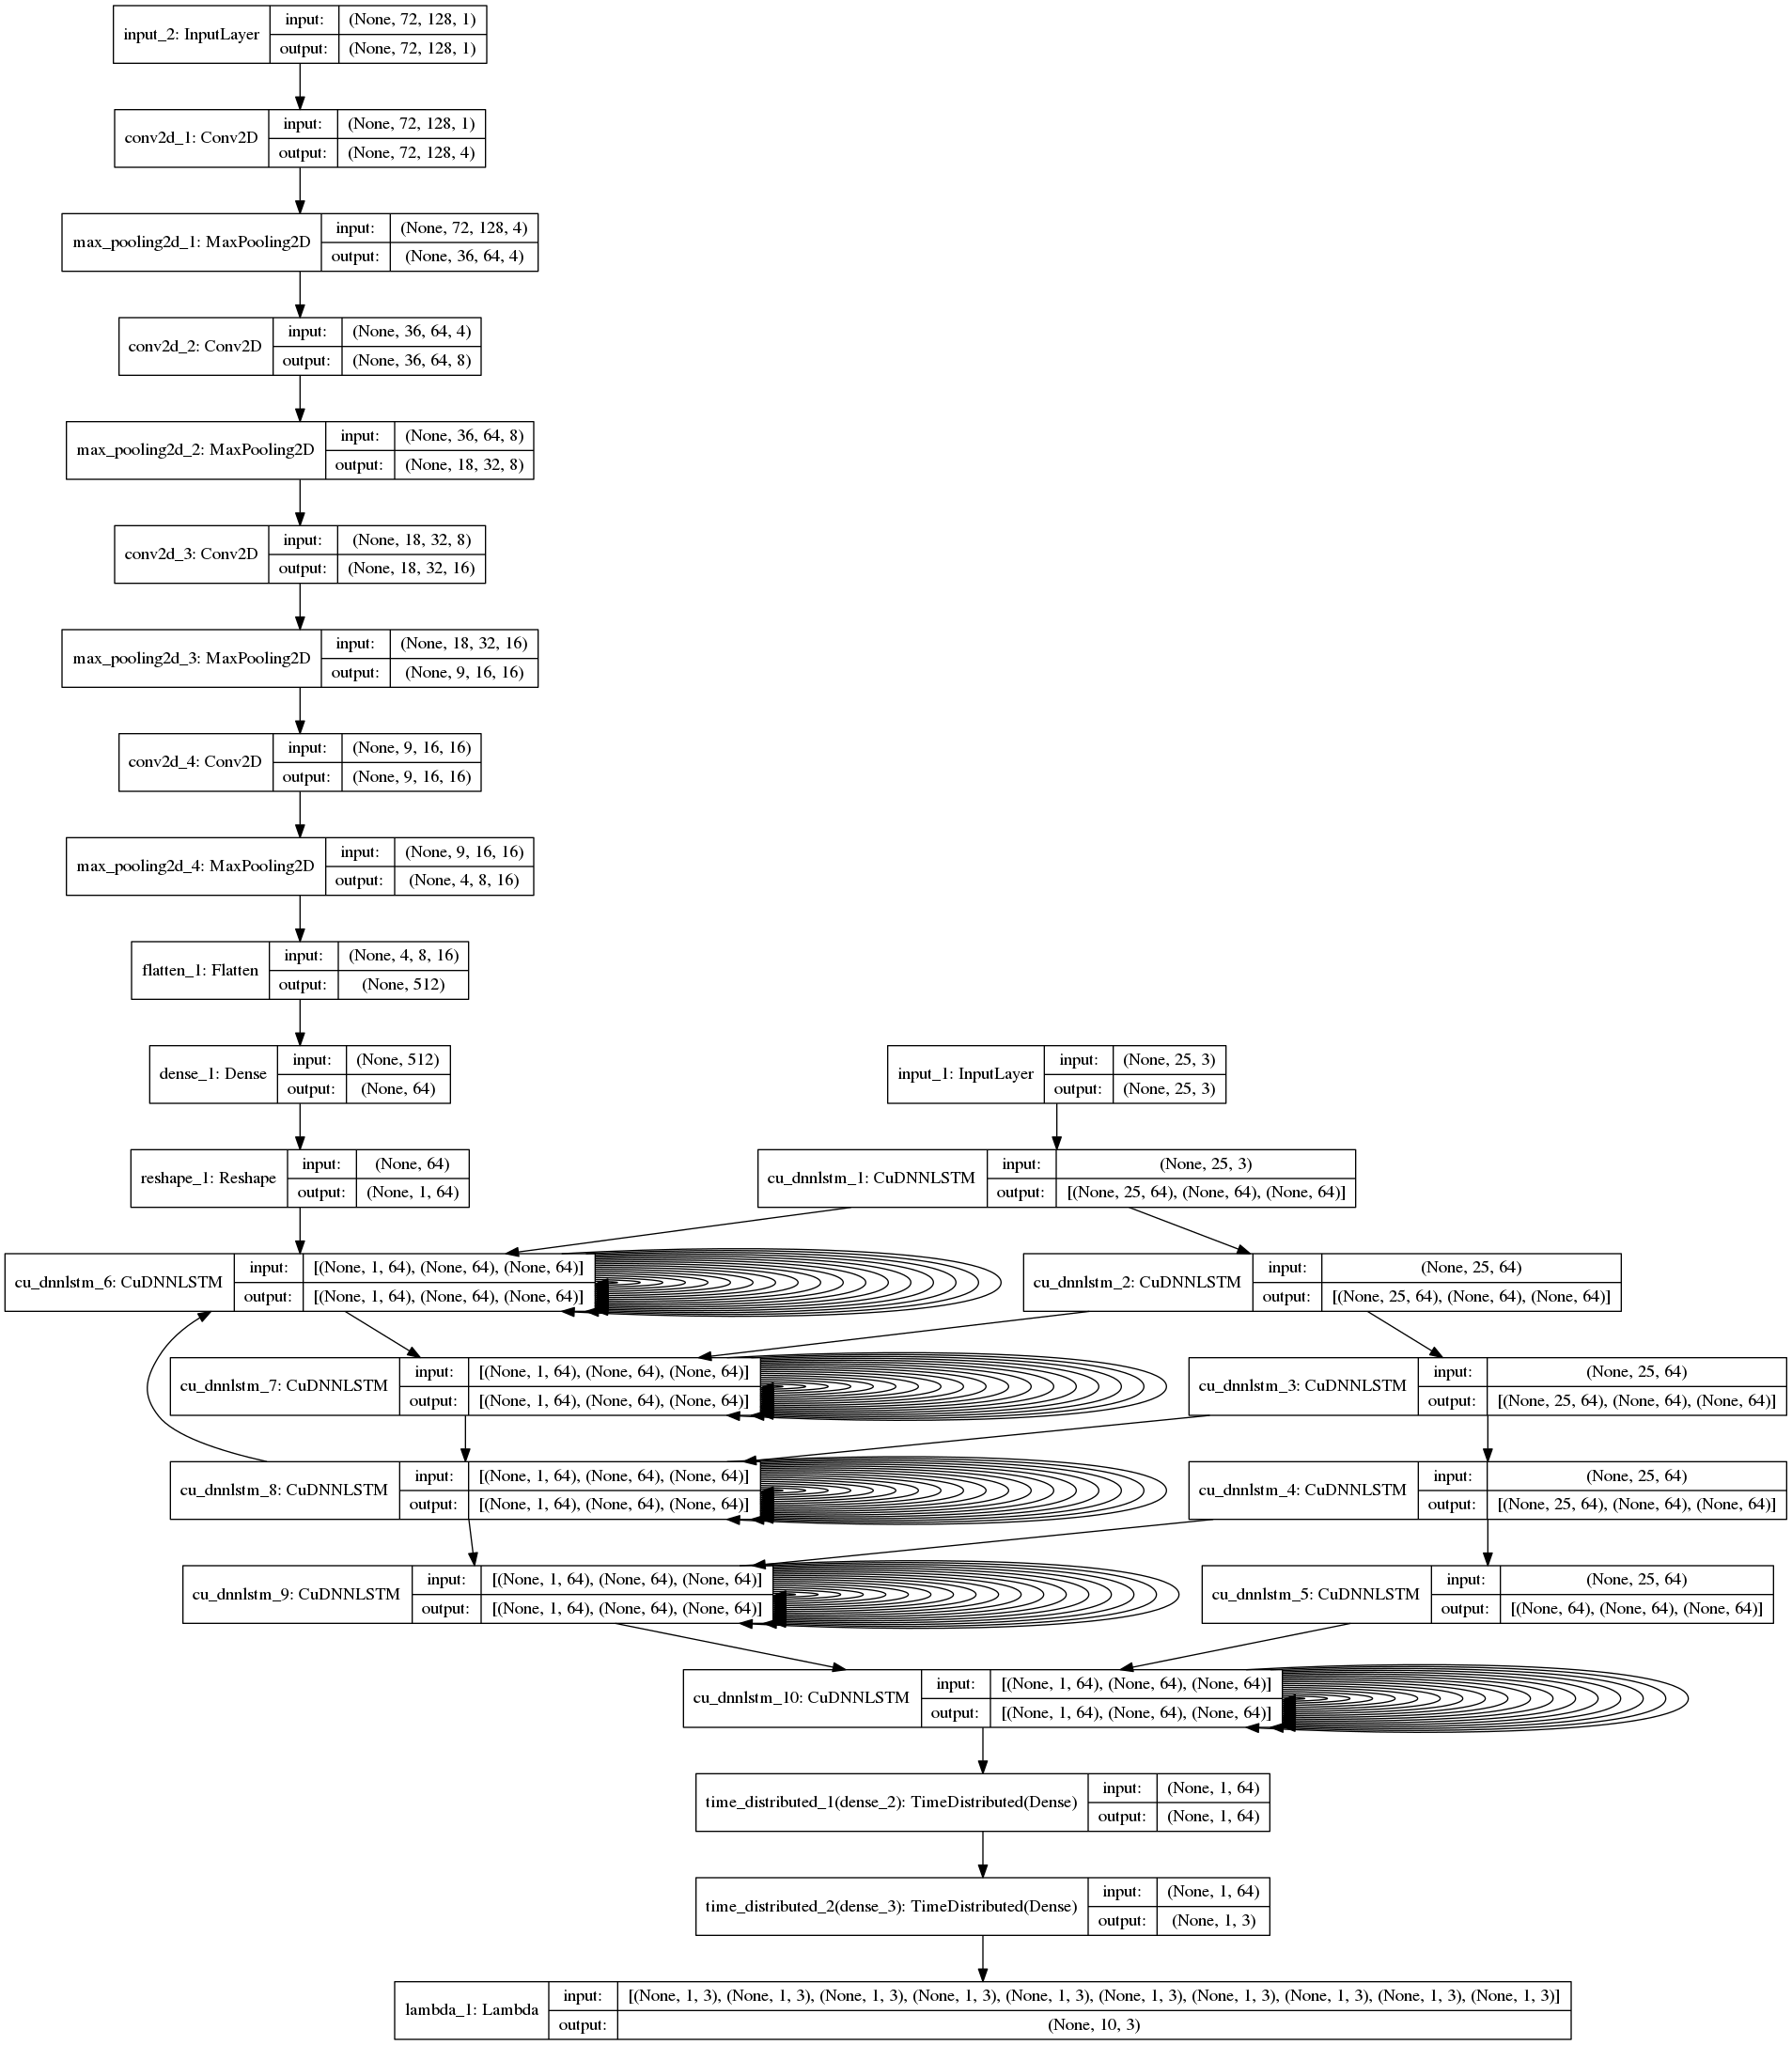

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


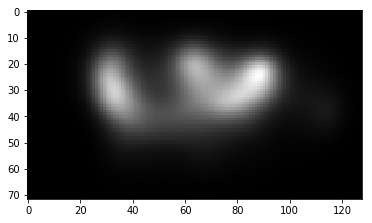

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 41:04 - loss: 0.0594 - rmse: 0.1625

  2/422 [..............................] - ETA: 29:18 - loss: 0.0758 - rmse: 0.2102

  3/422 [..............................] - ETA: 25:04 - loss: 0.0722 - rmse: 0.2101

  4/422 [..............................] - ETA: 22:57 - loss: 0.0785 - rmse: 0.2290

  5/422 [..............................] - ETA: 19:05 - loss: 0.0781 - rmse: 0.2244

  6/422 [..............................] - ETA: 18:41 - loss: 0.0804 - rmse: 0.2303

  7/422 [..............................] - ETA: 18:21 - loss: 0.0745 - rmse: 0.2100

  8/422 [..............................] - ETA: 18:06 - loss: 0.0748 - rmse: 0.2075

  9/422 [..............................] - ETA: 17:41 - loss: 0.0786 - rmse: 0.2137

 10/422 [..............................] - ETA: 16:16 - loss: 0.0789 - rmse: 0.2158

 11/422 [..............................] - ETA: 16:18 - loss: 0.0774 - rmse: 0.2100

 12/422 [..............................] - ETA: 16:16 - loss: 0.0740 - rmse: 0.2003

 13/422 [..............................] - ETA: 16:15 - loss: 0.0689 - rmse: 0.1865

 14/422 [..............................] - ETA: 16:14 - loss: 0.0652 - rmse: 0.1760

 15/422 [>.............................] - ETA: 16:06 - loss: 0.0653 - rmse: 0.1737

 16/422 [>.............................] - ETA: 16:04 - loss: 0.0626 - rmse: 0.1658

 17/422 [>.............................] - ETA: 16:05 - loss: 0.0645 - rmse: 0.1737

 18/422 [>.............................] - ETA: 16:04 - loss: 0.0654 - rmse: 0.1754

 19/422 [>.............................] - ETA: 15:23 - loss: 0.0647 - rmse: 0.1718

 20/422 [>.............................] - ETA: 15:23 - loss: 0.0640 - rmse: 0.1695

 21/422 [>.............................] - ETA: 15:23 - loss: 0.0639 - rmse: 0.1685

 22/422 [>.............................] - ETA: 15:23 - loss: 0.0638 - rmse: 0.1697

 23/422 [>.............................] - ETA: 15:23 - loss: 0.0622 - rmse: 0.1680

 24/422 [>.............................] - ETA: 15:23 - loss: 0.0620 - rmse: 0.1663

 25/422 [>.............................] - ETA: 15:23 - loss: 0.0611 - rmse: 0.1654

 26/422 [>.............................] - ETA: 14:54 - loss: 0.0605 - rmse: 0.1644

 27/422 [>.............................] - ETA: 14:54 - loss: 0.0614 - rmse: 0.1657

 28/422 [>.............................] - ETA: 14:54 - loss: 0.0617 - rmse: 0.1669

 29/422 [=>............................] - ETA: 14:54 - loss: 0.0614 - rmse: 0.1665

 30/422 [=>............................] - ETA: 14:54 - loss: 0.0613 - rmse: 0.1673

 31/422 [=>............................] - ETA: 14:53 - loss: 0.0618 - rmse: 0.1689

 32/422 [=>............................] - ETA: 14:53 - loss: 0.0625 - rmse: 0.1724

 33/422 [=>............................] - ETA: 14:52 - loss: 0.0616 - rmse: 0.1701

 34/422 [=>............................] - ETA: 14:49 - loss: 0.0633 - rmse: 0.1737

 35/422 [=>............................] - ETA: 14:27 - loss: 0.0647 - rmse: 0.1760

 36/422 [=>............................] - ETA: 14:28 - loss: 0.0656 - rmse: 0.1781

 37/422 [=>............................] - ETA: 14:28 - loss: 0.0652 - rmse: 0.1784

 38/422 [=>............................] - ETA: 14:28 - loss: 0.0649 - rmse: 0.1787

 39/422 [=>............................] - ETA: 14:22 - loss: 0.0645 - rmse: 0.1771

 40/422 [=>............................] - ETA: 14:02 - loss: 0.0659 - rmse: 0.1800

 41/422 [=>............................] - ETA: 14:02 - loss: 0.0659 - rmse: 0.1797

 42/422 [=>............................] - ETA: 13:56 - loss: 0.0645 - rmse: 0.1762

 43/422 [==>...........................] - ETA: 13:56 - loss: 0.0646 - rmse: 0.1763

 44/422 [==>...........................] - ETA: 13:56 - loss: 0.0645 - rmse: 0.1779

 45/422 [==>...........................] - ETA: 13:40 - loss: 0.0651 - rmse: 0.1794

 46/422 [==>...........................] - ETA: 13:40 - loss: 0.0646 - rmse: 0.1780

 47/422 [==>...........................] - ETA: 13:25 - loss: 0.0635 - rmse: 0.1751

 48/422 [==>...........................] - ETA: 13:25 - loss: 0.0650 - rmse: 0.1789

 49/422 [==>...........................] - ETA: 13:25 - loss: 0.0647 - rmse: 0.1784

 50/422 [==>...........................] - ETA: 13:25 - loss: 0.0658 - rmse: 0.1809

 51/422 [==>...........................] - ETA: 13:25 - loss: 0.0662 - rmse: 0.1816

 52/422 [==>...........................] - ETA: 13:25 - loss: 0.0660 - rmse: 0.1818

 53/422 [==>...........................] - ETA: 13:24 - loss: 0.0655 - rmse: 0.1802

 54/422 [==>...........................] - ETA: 13:24 - loss: 0.0651 - rmse: 0.1795

 55/422 [==>...........................] - ETA: 13:24 - loss: 0.0649 - rmse: 0.1796

 56/422 [==>...........................] - ETA: 13:21 - loss: 0.0650 - rmse: 0.1794

 57/422 [===>..........................] - ETA: 13:17 - loss: 0.0655 - rmse: 0.1797

 58/422 [===>..........................] - ETA: 13:16 - loss: 0.0649 - rmse: 0.1784

 59/422 [===>..........................] - ETA: 13:16 - loss: 0.0643 - rmse: 0.1768

 60/422 [===>..........................] - ETA: 13:15 - loss: 0.0646 - rmse: 0.1772

 61/422 [===>..........................] - ETA: 13:03 - loss: 0.0647 - rmse: 0.1771

 62/422 [===>..........................] - ETA: 13:01 - loss: 0.0650 - rmse: 0.1772

 63/422 [===>..........................] - ETA: 13:01 - loss: 0.0646 - rmse: 0.1764

 64/422 [===>..........................] - ETA: 12:50 - loss: 0.0644 - rmse: 0.1755

 65/422 [===>..........................] - ETA: 12:49 - loss: 0.0642 - rmse: 0.1756

 66/422 [===>..........................] - ETA: 12:38 - loss: 0.0640 - rmse: 0.1747

 67/422 [===>..........................] - ETA: 12:28 - loss: 0.0637 - rmse: 0.1739

 68/422 [===>..........................] - ETA: 12:27 - loss: 0.0637 - rmse: 0.1739

 69/422 [===>..........................] - ETA: 12:17 - loss: 0.0640 - rmse: 0.1745

 70/422 [===>..........................] - ETA: 12:17 - loss: 0.0645 - rmse: 0.1768

 71/422 [====>.........................] - ETA: 12:17 - loss: 0.0643 - rmse: 0.1760

 72/422 [====>.........................] - ETA: 12:07 - loss: 0.0643 - rmse: 0.1762

 73/422 [====>.........................] - ETA: 12:07 - loss: 0.0646 - rmse: 0.1768

 74/422 [====>.........................] - ETA: 12:05 - loss: 0.0644 - rmse: 0.1760

 75/422 [====>.........................] - ETA: 11:56 - loss: 0.0648 - rmse: 0.1768

 76/422 [====>.........................] - ETA: 11:47 - loss: 0.0651 - rmse: 0.1777

 77/422 [====>.........................] - ETA: 11:47 - loss: 0.0652 - rmse: 0.1778

 78/422 [====>.........................] - ETA: 11:46 - loss: 0.0653 - rmse: 0.1784

 79/422 [====>.........................] - ETA: 11:46 - loss: 0.0650 - rmse: 0.1775

 80/422 [====>.........................] - ETA: 11:38 - loss: 0.0646 - rmse: 0.1763

 81/422 [====>.........................] - ETA: 11:30 - loss: 0.0653 - rmse: 0.1781

 82/422 [====>.........................] - ETA: 11:27 - loss: 0.0658 - rmse: 0.1787

 83/422 [====>.........................] - ETA: 11:26 - loss: 0.0658 - rmse: 0.1790

 84/422 [====>.........................] - ETA: 11:26 - loss: 0.0656 - rmse: 0.1788

 85/422 [=====>........................] - ETA: 11:26 - loss: 0.0651 - rmse: 0.1774

 86/422 [=====>........................] - ETA: 11:26 - loss: 0.0651 - rmse: 0.1774

 87/422 [=====>........................] - ETA: 11:18 - loss: 0.0649 - rmse: 0.1770

 88/422 [=====>........................] - ETA: 11:10 - loss: 0.0647 - rmse: 0.1766

 89/422 [=====>........................] - ETA: 11:10 - loss: 0.0649 - rmse: 0.1768

 90/422 [=====>........................] - ETA: 11:10 - loss: 0.0647 - rmse: 0.1762

 91/422 [=====>........................] - ETA: 11:03 - loss: 0.0647 - rmse: 0.1763

 92/422 [=====>........................] - ETA: 10:56 - loss: 0.0646 - rmse: 0.1764

 93/422 [=====>........................] - ETA: 10:49 - loss: 0.0643 - rmse: 0.1756

 94/422 [=====>........................] - ETA: 10:42 - loss: 0.0645 - rmse: 0.1759

 95/422 [=====>........................] - ETA: 10:42 - loss: 0.0645 - rmse: 0.1760

 96/422 [=====>........................] - ETA: 10:35 - loss: 0.0646 - rmse: 0.1760

 97/422 [=====>........................] - ETA: 10:28 - loss: 0.0644 - rmse: 0.1755

 98/422 [=====>........................] - ETA: 10:28 - loss: 0.0641 - rmse: 0.1747

 99/422 [======>.......................] - ETA: 10:28 - loss: 0.0640 - rmse: 0.1741

100/422 [======>.......................] - ETA: 10:22 - loss: 0.0639 - rmse: 0.1738

101/422 [======>.......................] - ETA: 10:15 - loss: 0.0640 - rmse: 0.1739

102/422 [======>.......................] - ETA: 10:15 - loss: 0.0639 - rmse: 0.1734

103/422 [======>.......................] - ETA: 10:13 - loss: 0.0640 - rmse: 0.1735

104/422 [======>.......................] - ETA: 10:13 - loss: 0.0642 - rmse: 0.1740

105/422 [======>.......................] - ETA: 10:13 - loss: 0.0638 - rmse: 0.1729

106/422 [======>.......................] - ETA: 10:07 - loss: 0.0637 - rmse: 0.1728

107/422 [======>.......................] - ETA: 10:07 - loss: 0.0636 - rmse: 0.1727

108/422 [======>.......................] - ETA: 10:01 - loss: 0.0635 - rmse: 0.1723

109/422 [======>.......................] - ETA: 9:59 - loss: 0.0641 - rmse: 0.1739 

110/422 [======>.......................] - ETA: 9:58 - loss: 0.0640 - rmse: 0.1738

111/422 [======>.......................] - ETA: 9:58 - loss: 0.0638 - rmse: 0.1739

112/422 [======>.......................] - ETA: 9:58 - loss: 0.0636 - rmse: 0.1734

113/422 [=======>......................] - ETA: 9:52 - loss: 0.0641 - rmse: 0.1746

114/422 [=======>......................] - ETA: 9:46 - loss: 0.0640 - rmse: 0.1747

115/422 [=======>......................] - ETA: 9:41 - loss: 0.0641 - rmse: 0.1749

116/422 [=======>......................] - ETA: 9:41 - loss: 0.0641 - rmse: 0.1750

117/422 [=======>......................] - ETA: 9:35 - loss: 0.0643 - rmse: 0.1758

118/422 [=======>......................] - ETA: 9:30 - loss: 0.0643 - rmse: 0.1757

119/422 [=======>......................] - ETA: 9:25 - loss: 0.0640 - rmse: 0.1750

120/422 [=======>......................] - ETA: 9:20 - loss: 0.0639 - rmse: 0.1749

121/422 [=======>......................] - ETA: 9:19 - loss: 0.0640 - rmse: 0.1752

122/422 [=======>......................] - ETA: 9:19 - loss: 0.0639 - rmse: 0.1748

123/422 [=======>......................] - ETA: 9:14 - loss: 0.0638 - rmse: 0.1746

124/422 [=======>......................] - ETA: 9:09 - loss: 0.0637 - rmse: 0.1743

125/422 [=======>......................] - ETA: 9:09 - loss: 0.0639 - rmse: 0.1746

126/422 [=======>......................] - ETA: 9:08 - loss: 0.0637 - rmse: 0.1739

127/422 [========>.....................] - ETA: 9:08 - loss: 0.0641 - rmse: 0.1747

128/422 [========>.....................] - ETA: 9:08 - loss: 0.0638 - rmse: 0.1747

129/422 [========>.....................] - ETA: 9:07 - loss: 0.0638 - rmse: 0.1745

130/422 [========>.....................] - ETA: 9:06 - loss: 0.0636 - rmse: 0.1742

131/422 [========>.....................] - ETA: 9:06 - loss: 0.0638 - rmse: 0.1751

132/422 [========>.....................] - ETA: 9:01 - loss: 0.0639 - rmse: 0.1752

133/422 [========>.....................] - ETA: 9:00 - loss: 0.0639 - rmse: 0.1754

134/422 [========>.....................] - ETA: 8:58 - loss: 0.0640 - rmse: 0.1755

135/422 [========>.....................] - ETA: 8:54 - loss: 0.0639 - rmse: 0.1754

136/422 [========>.....................] - ETA: 8:53 - loss: 0.0641 - rmse: 0.1758

137/422 [========>.....................] - ETA: 8:52 - loss: 0.0637 - rmse: 0.1751

138/422 [========>.....................] - ETA: 8:50 - loss: 0.0640 - rmse: 0.1758

139/422 [========>.....................] - ETA: 8:46 - loss: 0.0643 - rmse: 0.1766

140/422 [========>.....................] - ETA: 8:41 - loss: 0.0644 - rmse: 0.1768

141/422 [=========>....................] - ETA: 8:41 - loss: 0.0642 - rmse: 0.1763

142/422 [=========>....................] - ETA: 8:36 - loss: 0.0642 - rmse: 0.1760

143/422 [=========>....................] - ETA: 8:32 - loss: 0.0640 - rmse: 0.1756

144/422 [=========>....................] - ETA: 8:31 - loss: 0.0640 - rmse: 0.1755

145/422 [=========>....................] - ETA: 8:31 - loss: 0.0640 - rmse: 0.1756

146/422 [=========>....................] - ETA: 8:30 - loss: 0.0647 - rmse: 0.1773

147/422 [=========>....................] - ETA: 8:28 - loss: 0.0648 - rmse: 0.1774

148/422 [=========>....................] - ETA: 8:24 - loss: 0.0646 - rmse: 0.1770

149/422 [=========>....................] - ETA: 8:23 - loss: 0.0647 - rmse: 0.1770

150/422 [=========>....................] - ETA: 8:21 - loss: 0.0646 - rmse: 0.1771

151/422 [=========>....................] - ETA: 8:21 - loss: 0.0646 - rmse: 0.1771

152/422 [=========>....................] - ETA: 8:20 - loss: 0.0645 - rmse: 0.1765

153/422 [=========>....................] - ETA: 8:19 - loss: 0.0644 - rmse: 0.1762

154/422 [=========>....................] - ETA: 8:18 - loss: 0.0645 - rmse: 0.1764

155/422 [==========>...................] - ETA: 8:14 - loss: 0.0643 - rmse: 0.1757

156/422 [==========>...................] - ETA: 8:14 - loss: 0.0642 - rmse: 0.1756

157/422 [==========>...................] - ETA: 8:10 - loss: 0.0641 - rmse: 0.1757

158/422 [==========>...................] - ETA: 8:06 - loss: 0.0642 - rmse: 0.1763

159/422 [==========>...................] - ETA: 8:04 - loss: 0.0642 - rmse: 0.1761

160/422 [==========>...................] - ETA: 8:00 - loss: 0.0642 - rmse: 0.1760

161/422 [==========>...................] - ETA: 7:59 - loss: 0.0643 - rmse: 0.1760

162/422 [==========>...................] - ETA: 7:58 - loss: 0.0643 - rmse: 0.1760

163/422 [==========>...................] - ETA: 7:57 - loss: 0.0644 - rmse: 0.1765

164/422 [==========>...................] - ETA: 7:56 - loss: 0.0644 - rmse: 0.1764

165/422 [==========>...................] - ETA: 7:52 - loss: 0.0643 - rmse: 0.1765

166/422 [==========>...................] - ETA: 7:51 - loss: 0.0644 - rmse: 0.1765

167/422 [==========>...................] - ETA: 7:50 - loss: 0.0643 - rmse: 0.1763

168/422 [==========>...................] - ETA: 7:49 - loss: 0.0642 - rmse: 0.1762

169/422 [===========>..................] - ETA: 7:46 - loss: 0.0640 - rmse: 0.1754

170/422 [===========>..................] - ETA: 7:44 - loss: 0.0641 - rmse: 0.1754

171/422 [===========>..................] - ETA: 7:40 - loss: 0.0641 - rmse: 0.1752

172/422 [===========>..................] - ETA: 7:36 - loss: 0.0642 - rmse: 0.1753

173/422 [===========>..................] - ETA: 7:33 - loss: 0.0641 - rmse: 0.1751

174/422 [===========>..................] - ETA: 7:29 - loss: 0.0642 - rmse: 0.1753

175/422 [===========>..................] - ETA: 7:28 - loss: 0.0643 - rmse: 0.1756

176/422 [===========>..................] - ETA: 7:25 - loss: 0.0641 - rmse: 0.1751

177/422 [===========>..................] - ETA: 7:21 - loss: 0.0642 - rmse: 0.1753

178/422 [===========>..................] - ETA: 7:18 - loss: 0.0642 - rmse: 0.1752

179/422 [===========>..................] - ETA: 7:17 - loss: 0.0645 - rmse: 0.1759

180/422 [===========>..................] - ETA: 7:16 - loss: 0.0645 - rmse: 0.1758

181/422 [===========>..................] - ETA: 7:15 - loss: 0.0645 - rmse: 0.1760

182/422 [===========>..................] - ETA: 7:12 - loss: 0.0647 - rmse: 0.1763

183/422 [============>.................] - ETA: 7:08 - loss: 0.0645 - rmse: 0.1761

184/422 [============>.................] - ETA: 7:05 - loss: 0.0646 - rmse: 0.1763

185/422 [============>.................] - ETA: 7:01 - loss: 0.0646 - rmse: 0.1763

186/422 [============>.................] - ETA: 7:01 - loss: 0.0646 - rmse: 0.1768

187/422 [============>.................] - ETA: 6:57 - loss: 0.0647 - rmse: 0.1768

188/422 [============>.................] - ETA: 6:56 - loss: 0.0646 - rmse: 0.1768

189/422 [============>.................] - ETA: 6:53 - loss: 0.0647 - rmse: 0.1767

190/422 [============>.................] - ETA: 6:52 - loss: 0.0647 - rmse: 0.1769

191/422 [============>.................] - ETA: 6:51 - loss: 0.0645 - rmse: 0.1762

192/422 [============>.................] - ETA: 6:50 - loss: 0.0643 - rmse: 0.1757

193/422 [============>.................] - ETA: 6:47 - loss: 0.0642 - rmse: 0.1756

194/422 [============>.................] - ETA: 6:46 - loss: 0.0644 - rmse: 0.1759

195/422 [============>.................] - ETA: 6:43 - loss: 0.0645 - rmse: 0.1760

196/422 [============>.................] - ETA: 6:40 - loss: 0.0646 - rmse: 0.1763

197/422 [=============>................] - ETA: 6:39 - loss: 0.0645 - rmse: 0.1759

198/422 [=============>................] - ETA: 6:38 - loss: 0.0644 - rmse: 0.1757

199/422 [=============>................] - ETA: 6:37 - loss: 0.0642 - rmse: 0.1754

200/422 [=============>................] - ETA: 6:34 - loss: 0.0641 - rmse: 0.1753

201/422 [=============>................] - ETA: 6:32 - loss: 0.0641 - rmse: 0.1754

202/422 [=============>................] - ETA: 6:31 - loss: 0.0641 - rmse: 0.1753

203/422 [=============>................] - ETA: 6:30 - loss: 0.0643 - rmse: 0.1756

204/422 [=============>................] - ETA: 6:27 - loss: 0.0643 - rmse: 0.1754

205/422 [=============>................] - ETA: 6:26 - loss: 0.0641 - rmse: 0.1749

206/422 [=============>................] - ETA: 6:23 - loss: 0.0642 - rmse: 0.1752

207/422 [=============>................] - ETA: 6:22 - loss: 0.0640 - rmse: 0.1748

208/422 [=============>................] - ETA: 6:21 - loss: 0.0640 - rmse: 0.1748

209/422 [=============>................] - ETA: 6:20 - loss: 0.0641 - rmse: 0.1749

210/422 [=============>................] - ETA: 6:17 - loss: 0.0639 - rmse: 0.1744

211/422 [==============>...............] - ETA: 6:14 - loss: 0.0639 - rmse: 0.1745

212/422 [==============>...............] - ETA: 6:11 - loss: 0.0638 - rmse: 0.1743

213/422 [==============>...............] - ETA: 6:10 - loss: 0.0638 - rmse: 0.1744

214/422 [==============>...............] - ETA: 6:09 - loss: 0.0639 - rmse: 0.1747

215/422 [==============>...............] - ETA: 6:06 - loss: 0.0640 - rmse: 0.1750

216/422 [==============>...............] - ETA: 6:03 - loss: 0.0640 - rmse: 0.1748

217/422 [==============>...............] - ETA: 6:00 - loss: 0.0637 - rmse: 0.1743

218/422 [==============>...............] - ETA: 5:57 - loss: 0.0637 - rmse: 0.1744

219/422 [==============>...............] - ETA: 5:55 - loss: 0.0637 - rmse: 0.1743

220/422 [==============>...............] - ETA: 5:53 - loss: 0.0636 - rmse: 0.1741

221/422 [==============>...............] - ETA: 5:50 - loss: 0.0635 - rmse: 0.1737

222/422 [==============>...............] - ETA: 5:49 - loss: 0.0635 - rmse: 0.1735

223/422 [==============>...............] - ETA: 5:47 - loss: 0.0635 - rmse: 0.1735

224/422 [==============>...............] - ETA: 5:46 - loss: 0.0635 - rmse: 0.1737

225/422 [==============>...............] - ETA: 5:44 - loss: 0.0634 - rmse: 0.1736

226/422 [===============>..............] - ETA: 5:42 - loss: 0.0632 - rmse: 0.1730

227/422 [===============>..............] - ETA: 5:39 - loss: 0.0630 - rmse: 0.1726

228/422 [===============>..............] - ETA: 5:38 - loss: 0.0632 - rmse: 0.1730

229/422 [===============>..............] - ETA: 5:37 - loss: 0.0632 - rmse: 0.1729

230/422 [===============>..............] - ETA: 5:34 - loss: 0.0633 - rmse: 0.1731

231/422 [===============>..............] - ETA: 5:31 - loss: 0.0631 - rmse: 0.1724

232/422 [===============>..............] - ETA: 5:28 - loss: 0.0631 - rmse: 0.1725

233/422 [===============>..............] - ETA: 5:27 - loss: 0.0629 - rmse: 0.1719

234/422 [===============>..............] - ETA: 5:26 - loss: 0.0628 - rmse: 0.1718

235/422 [===============>..............] - ETA: 5:24 - loss: 0.0629 - rmse: 0.1720

236/422 [===============>..............] - ETA: 5:23 - loss: 0.0630 - rmse: 0.1722

237/422 [===============>..............] - ETA: 5:21 - loss: 0.0630 - rmse: 0.1722

238/422 [===============>..............] - ETA: 5:18 - loss: 0.0630 - rmse: 0.1721

239/422 [===============>..............] - ETA: 5:16 - loss: 0.0629 - rmse: 0.1719

240/422 [================>.............] - ETA: 5:13 - loss: 0.0629 - rmse: 0.1720

241/422 [================>.............] - ETA: 5:11 - loss: 0.0631 - rmse: 0.1722

242/422 [================>.............] - ETA: 5:08 - loss: 0.0631 - rmse: 0.1723

243/422 [================>.............] - ETA: 5:07 - loss: 0.0632 - rmse: 0.1724

244/422 [================>.............] - ETA: 5:04 - loss: 0.0634 - rmse: 0.1728

245/422 [================>.............] - ETA: 5:03 - loss: 0.0634 - rmse: 0.1728

246/422 [================>.............] - ETA: 5:01 - loss: 0.0633 - rmse: 0.1726

247/422 [================>.............] - ETA: 4:58 - loss: 0.0633 - rmse: 0.1724

248/422 [================>.............] - ETA: 4:57 - loss: 0.0633 - rmse: 0.1726

249/422 [================>.............] - ETA: 4:56 - loss: 0.0635 - rmse: 0.1730

250/422 [================>.............] - ETA: 4:55 - loss: 0.0637 - rmse: 0.1735

251/422 [================>.............] - ETA: 4:52 - loss: 0.0639 - rmse: 0.1739

252/422 [================>.............] - ETA: 4:51 - loss: 0.0638 - rmse: 0.1738

253/422 [================>.............] - ETA: 4:50 - loss: 0.0639 - rmse: 0.1738

254/422 [=================>............] - ETA: 4:47 - loss: 0.0639 - rmse: 0.1738

255/422 [=================>............] - ETA: 4:45 - loss: 0.0638 - rmse: 0.1737

256/422 [=================>............] - ETA: 4:44 - loss: 0.0638 - rmse: 0.1735

257/422 [=================>............] - ETA: 4:41 - loss: 0.0638 - rmse: 0.1735

258/422 [=================>............] - ETA: 4:39 - loss: 0.0638 - rmse: 0.1735

259/422 [=================>............] - ETA: 4:36 - loss: 0.0638 - rmse: 0.1734

260/422 [=================>............] - ETA: 4:35 - loss: 0.0636 - rmse: 0.1730

261/422 [=================>............] - ETA: 4:33 - loss: 0.0637 - rmse: 0.1733

262/422 [=================>............] - ETA: 4:30 - loss: 0.0638 - rmse: 0.1735

263/422 [=================>............] - ETA: 4:28 - loss: 0.0637 - rmse: 0.1731

264/422 [=================>............] - ETA: 4:27 - loss: 0.0638 - rmse: 0.1732

265/422 [=================>............] - ETA: 4:25 - loss: 0.0636 - rmse: 0.1728

266/422 [=================>............] - ETA: 4:23 - loss: 0.0638 - rmse: 0.1732

267/422 [=================>............] - ETA: 4:20 - loss: 0.0637 - rmse: 0.1731

268/422 [==================>...........] - ETA: 4:18 - loss: 0.0638 - rmse: 0.1732

269/422 [==================>...........] - ETA: 4:17 - loss: 0.0636 - rmse: 0.1728

270/422 [==================>...........] - ETA: 4:15 - loss: 0.0635 - rmse: 0.1727

271/422 [==================>...........] - ETA: 4:12 - loss: 0.0634 - rmse: 0.1724

272/422 [==================>...........] - ETA: 4:10 - loss: 0.0633 - rmse: 0.1723

273/422 [==================>...........] - ETA: 4:09 - loss: 0.0633 - rmse: 0.1724

274/422 [==================>...........] - ETA: 4:06 - loss: 0.0632 - rmse: 0.1720

275/422 [==================>...........] - ETA: 4:04 - loss: 0.0632 - rmse: 0.1720

276/422 [==================>...........] - ETA: 4:03 - loss: 0.0631 - rmse: 0.1716

277/422 [==================>...........] - ETA: 4:02 - loss: 0.0631 - rmse: 0.1717

278/422 [==================>...........] - ETA: 3:59 - loss: 0.0630 - rmse: 0.1713

279/422 [==================>...........] - ETA: 3:58 - loss: 0.0632 - rmse: 0.1718

280/422 [==================>...........] - ETA: 3:56 - loss: 0.0633 - rmse: 0.1719

281/422 [==================>...........] - ETA: 3:55 - loss: 0.0632 - rmse: 0.1716

282/422 [===================>..........] - ETA: 3:52 - loss: 0.0631 - rmse: 0.1712

283/422 [===================>..........] - ETA: 3:50 - loss: 0.0631 - rmse: 0.1711

284/422 [===================>..........] - ETA: 3:48 - loss: 0.0631 - rmse: 0.1714

285/422 [===================>..........] - ETA: 3:47 - loss: 0.0630 - rmse: 0.1710

286/422 [===================>..........] - ETA: 3:45 - loss: 0.0630 - rmse: 0.1710

287/422 [===================>..........] - ETA: 3:43 - loss: 0.0629 - rmse: 0.1709

288/422 [===================>..........] - ETA: 3:42 - loss: 0.0629 - rmse: 0.1708

289/422 [===================>..........] - ETA: 3:41 - loss: 0.0629 - rmse: 0.1707

290/422 [===================>..........] - ETA: 3:39 - loss: 0.0630 - rmse: 0.1712

291/422 [===================>..........] - ETA: 3:38 - loss: 0.0630 - rmse: 0.1712

292/422 [===================>..........] - ETA: 3:36 - loss: 0.0629 - rmse: 0.1708

293/422 [===================>..........] - ETA: 3:34 - loss: 0.0629 - rmse: 0.1708

294/422 [===================>..........] - ETA: 3:32 - loss: 0.0629 - rmse: 0.1709

295/422 [===================>..........] - ETA: 3:30 - loss: 0.0629 - rmse: 0.1707

296/422 [====================>.........] - ETA: 3:29 - loss: 0.0630 - rmse: 0.1711

297/422 [====================>.........] - ETA: 3:27 - loss: 0.0628 - rmse: 0.1706

298/422 [====================>.........] - ETA: 3:25 - loss: 0.0629 - rmse: 0.1710

299/422 [====================>.........] - ETA: 3:23 - loss: 0.0628 - rmse: 0.1708

300/422 [====================>.........] - ETA: 3:21 - loss: 0.0628 - rmse: 0.1706

301/422 [====================>.........] - ETA: 3:19 - loss: 0.0627 - rmse: 0.1704

302/422 [====================>.........] - ETA: 3:17 - loss: 0.0627 - rmse: 0.1703

303/422 [====================>.........] - ETA: 3:15 - loss: 0.0627 - rmse: 0.1706

304/422 [====================>.........] - ETA: 3:14 - loss: 0.0627 - rmse: 0.1707

305/422 [====================>.........] - ETA: 3:12 - loss: 0.0627 - rmse: 0.1707

306/422 [====================>.........] - ETA: 3:10 - loss: 0.0626 - rmse: 0.1705

307/422 [====================>.........] - ETA: 3:08 - loss: 0.0626 - rmse: 0.1704

308/422 [====================>.........] - ETA: 3:06 - loss: 0.0625 - rmse: 0.1703

309/422 [====================>.........] - ETA: 3:05 - loss: 0.0625 - rmse: 0.1702

310/422 [=====================>........] - ETA: 3:04 - loss: 0.0625 - rmse: 0.1702

311/422 [=====================>........] - ETA: 3:02 - loss: 0.0625 - rmse: 0.1703

312/422 [=====================>........] - ETA: 3:00 - loss: 0.0624 - rmse: 0.1702

313/422 [=====================>........] - ETA: 2:58 - loss: 0.0624 - rmse: 0.1704

314/422 [=====================>........] - ETA: 2:56 - loss: 0.0624 - rmse: 0.1701

315/422 [=====================>........] - ETA: 2:54 - loss: 0.0622 - rmse: 0.1698

316/422 [=====================>........] - ETA: 2:52 - loss: 0.0623 - rmse: 0.1700

317/422 [=====================>........] - ETA: 2:50 - loss: 0.0623 - rmse: 0.1701

318/422 [=====================>........] - ETA: 2:48 - loss: 0.0624 - rmse: 0.1703

319/422 [=====================>........] - ETA: 2:47 - loss: 0.0623 - rmse: 0.1701

320/422 [=====================>........] - ETA: 2:45 - loss: 0.0624 - rmse: 0.1703

321/422 [=====================>........] - ETA: 2:43 - loss: 0.0622 - rmse: 0.1698

322/422 [=====================>........] - ETA: 2:41 - loss: 0.0622 - rmse: 0.1696

323/422 [=====================>........] - ETA: 2:40 - loss: 0.0622 - rmse: 0.1696

324/422 [======================>.......] - ETA: 2:38 - loss: 0.0621 - rmse: 0.1693

325/422 [======================>.......] - ETA: 2:36 - loss: 0.0620 - rmse: 0.1691

326/422 [======================>.......] - ETA: 2:34 - loss: 0.0620 - rmse: 0.1691

327/422 [======================>.......] - ETA: 2:32 - loss: 0.0620 - rmse: 0.1693

328/422 [======================>.......] - ETA: 2:30 - loss: 0.0621 - rmse: 0.1694

329/422 [======================>.......] - ETA: 2:28 - loss: 0.0622 - rmse: 0.1699

330/422 [======================>.......] - ETA: 2:26 - loss: 0.0623 - rmse: 0.1701

331/422 [======================>.......] - ETA: 2:25 - loss: 0.0623 - rmse: 0.1702

332/422 [======================>.......] - ETA: 2:23 - loss: 0.0624 - rmse: 0.1705

333/422 [======================>.......] - ETA: 2:22 - loss: 0.0623 - rmse: 0.1703

334/422 [======================>.......] - ETA: 2:20 - loss: 0.0624 - rmse: 0.1704

335/422 [======================>.......] - ETA: 2:18 - loss: 0.0624 - rmse: 0.1704

336/422 [======================>.......] - ETA: 2:16 - loss: 0.0626 - rmse: 0.1707

337/422 [======================>.......] - ETA: 2:14 - loss: 0.0625 - rmse: 0.1705

338/422 [=======================>......] - ETA: 2:12 - loss: 0.0626 - rmse: 0.1707

339/422 [=======================>......] - ETA: 2:10 - loss: 0.0625 - rmse: 0.1704

340/422 [=======================>......] - ETA: 2:09 - loss: 0.0625 - rmse: 0.1703

341/422 [=======================>......] - ETA: 2:07 - loss: 0.0627 - rmse: 0.1708

342/422 [=======================>......] - ETA: 2:05 - loss: 0.0628 - rmse: 0.1711

343/422 [=======================>......] - ETA: 2:04 - loss: 0.0628 - rmse: 0.1711

344/422 [=======================>......] - ETA: 2:02 - loss: 0.0628 - rmse: 0.1711

345/422 [=======================>......] - ETA: 2:00 - loss: 0.0628 - rmse: 0.1711

346/422 [=======================>......] - ETA: 1:59 - loss: 0.0629 - rmse: 0.1712

347/422 [=======================>......] - ETA: 1:57 - loss: 0.0629 - rmse: 0.1714

348/422 [=======================>......] - ETA: 1:56 - loss: 0.0631 - rmse: 0.1717

349/422 [=======================>......] - ETA: 1:54 - loss: 0.0630 - rmse: 0.1714

350/422 [=======================>......] - ETA: 1:53 - loss: 0.0629 - rmse: 0.1712

351/422 [=======================>......] - ETA: 1:52 - loss: 0.0630 - rmse: 0.1714

352/422 [========================>.....] - ETA: 1:50 - loss: 0.0629 - rmse: 0.1712

353/422 [========================>.....] - ETA: 1:48 - loss: 0.0629 - rmse: 0.1713

354/422 [========================>.....] - ETA: 1:47 - loss: 0.0629 - rmse: 0.1711

355/422 [========================>.....] - ETA: 1:45 - loss: 0.0629 - rmse: 0.1711

356/422 [========================>.....] - ETA: 1:43 - loss: 0.0628 - rmse: 0.1712

357/422 [========================>.....] - ETA: 1:42 - loss: 0.0628 - rmse: 0.1710

358/422 [========================>.....] - ETA: 1:40 - loss: 0.0626 - rmse: 0.1706

359/422 [========================>.....] - ETA: 1:38 - loss: 0.0627 - rmse: 0.1708

360/422 [========================>.....] - ETA: 1:37 - loss: 0.0626 - rmse: 0.1706

361/422 [========================>.....] - ETA: 1:35 - loss: 0.0626 - rmse: 0.1705

362/422 [========================>.....] - ETA: 1:34 - loss: 0.0626 - rmse: 0.1705

363/422 [========================>.....] - ETA: 1:32 - loss: 0.0625 - rmse: 0.1703

364/422 [========================>.....] - ETA: 1:31 - loss: 0.0625 - rmse: 0.1702

365/422 [========================>.....] - ETA: 1:29 - loss: 0.0625 - rmse: 0.1703

366/422 [=========================>....] - ETA: 1:27 - loss: 0.0625 - rmse: 0.1701

367/422 [=========================>....] - ETA: 1:25 - loss: 0.0624 - rmse: 0.1700

368/422 [=========================>....] - ETA: 1:24 - loss: 0.0624 - rmse: 0.1699

369/422 [=========================>....] - ETA: 1:22 - loss: 0.0624 - rmse: 0.1699

370/422 [=========================>....] - ETA: 1:21 - loss: 0.0623 - rmse: 0.1698

371/422 [=========================>....] - ETA: 1:19 - loss: 0.0622 - rmse: 0.1694

372/422 [=========================>....] - ETA: 1:18 - loss: 0.0622 - rmse: 0.1693

373/422 [=========================>....] - ETA: 1:16 - loss: 0.0621 - rmse: 0.1692

374/422 [=========================>....] - ETA: 1:15 - loss: 0.0622 - rmse: 0.1694

375/422 [=========================>....] - ETA: 1:13 - loss: 0.0622 - rmse: 0.1694

376/422 [=========================>....] - ETA: 1:12 - loss: 0.0621 - rmse: 0.1691

377/422 [=========================>....] - ETA: 1:10 - loss: 0.0620 - rmse: 0.1690

378/422 [=========================>....] - ETA: 1:08 - loss: 0.0620 - rmse: 0.1690

379/422 [=========================>....] - ETA: 1:07 - loss: 0.0619 - rmse: 0.1690

380/422 [==========================>...] - ETA: 1:05 - loss: 0.0622 - rmse: 0.1695

381/422 [==========================>...] - ETA: 1:04 - loss: 0.0621 - rmse: 0.1693

382/422 [==========================>...] - ETA: 1:02 - loss: 0.0621 - rmse: 0.1692

383/422 [==========================>...] - ETA: 1:01 - loss: 0.0620 - rmse: 0.1690

384/422 [==========================>...] - ETA: 59s - loss: 0.0620 - rmse: 0.1689 

385/422 [==========================>...] - ETA: 57s - loss: 0.0621 - rmse: 0.1690

386/422 [==========================>...] - ETA: 56s - loss: 0.0621 - rmse: 0.1690

387/422 [==========================>...] - ETA: 54s - loss: 0.0621 - rmse: 0.1691

388/422 [==========================>...] - ETA: 53s - loss: 0.0621 - rmse: 0.1693

389/422 [==========================>...] - ETA: 51s - loss: 0.0621 - rmse: 0.1693

390/422 [==========================>...] - ETA: 49s - loss: 0.0621 - rmse: 0.1694

391/422 [==========================>...] - ETA: 48s - loss: 0.0623 - rmse: 0.1699

392/422 [==========================>...] - ETA: 46s - loss: 0.0622 - rmse: 0.1697

393/422 [==========================>...] - ETA: 45s - loss: 0.0622 - rmse: 0.1698

394/422 [===========================>..] - ETA: 43s - loss: 0.0621 - rmse: 0.1696

395/422 [===========================>..] - ETA: 41s - loss: 0.0621 - rmse: 0.1696

396/422 [===========================>..] - ETA: 40s - loss: 0.0620 - rmse: 0.1694

397/422 [===========================>..] - ETA: 38s - loss: 0.0620 - rmse: 0.1693

398/422 [===========================>..] - ETA: 37s - loss: 0.0619 - rmse: 0.1692

399/422 [===========================>..] - ETA: 35s - loss: 0.0619 - rmse: 0.1690

400/422 [===========================>..] - ETA: 33s - loss: 0.0618 - rmse: 0.1687

401/422 [===========================>..] - ETA: 32s - loss: 0.0618 - rmse: 0.1687

402/422 [===========================>..] - ETA: 30s - loss: 0.0618 - rmse: 0.1687

403/422 [===========================>..] - ETA: 29s - loss: 0.0617 - rmse: 0.1686

404/422 [===========================>..] - ETA: 27s - loss: 0.0617 - rmse: 0.1686

405/422 [===========================>..] - ETA: 26s - loss: 0.0617 - rmse: 0.1684

406/422 [===========================>..] - ETA: 24s - loss: 0.0617 - rmse: 0.1685

407/422 [===========================>..] - ETA: 23s - loss: 0.0616 - rmse: 0.1683

408/422 [============================>.] - ETA: 21s - loss: 0.0617 - rmse: 0.1686

409/422 [============================>.] - ETA: 19s - loss: 0.0617 - rmse: 0.1685

410/422 [============================>.] - ETA: 18s - loss: 0.0617 - rmse: 0.1685

411/422 [============================>.] - ETA: 16s - loss: 0.0618 - rmse: 0.1687

412/422 [============================>.] - ETA: 15s - loss: 0.0617 - rmse: 0.1685

413/422 [============================>.] - ETA: 13s - loss: 0.0616 - rmse: 0.1682

414/422 [============================>.] - ETA: 12s - loss: 0.0617 - rmse: 0.1683

415/422 [============================>.] - ETA: 10s - loss: 0.0617 - rmse: 0.1684

416/422 [============================>.] - ETA: 9s - loss: 0.0617 - rmse: 0.1683 

417/422 [============================>.] - ETA: 7s - loss: 0.0617 - rmse: 0.1682

418/422 [============================>.] - ETA: 6s - loss: 0.0617 - rmse: 0.1684

419/422 [============================>.] - ETA: 4s - loss: 0.0617 - rmse: 0.1682

420/422 [============================>.] - ETA: 3s - loss: 0.0616 - rmse: 0.1679

421/422 [============================>.] - ETA: 1s - loss: 0.0615 - rmse: 0.1678

422/422 [==============================] - 703s 2s/step - loss: 0.0615 - rmse: 0.1677 - val_loss: 0.0615 - val_rmse: 0.1755


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_6/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_6/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150


  1/422 [..............................] - ETA: 3:54 - loss: 0.0760 - rmse: 0.1921

  2/422 [..............................] - ETA: 3:59 - loss: 0.0807 - rmse: 0.2004

  3/422 [..............................] - ETA: 3:57 - loss: 0.0772 - rmse: 0.2042

  4/422 [..............................] - ETA: 5:59 - loss: 0.0751 - rmse: 0.1955

  5/422 [..............................] - ETA: 5:34 - loss: 0.0738 - rmse: 0.2053

  6/422 [..............................] - ETA: 5:15 - loss: 0.0743 - rmse: 0.2032

  7/422 [..............................] - ETA: 5:02 - loss: 0.0687 - rmse: 0.1857

  8/422 [..............................] - ETA: 4:52 - loss: 0.0664 - rmse: 0.1776

  9/422 [..............................] - ETA: 4:45 - loss: 0.0675 - rmse: 0.1818

 10/422 [..............................] - ETA: 4:39 - loss: 0.0674 - rmse: 0.1825

 11/422 [..............................] - ETA: 4:33 - loss: 0.0678 - rmse: 0.1832

 12/422 [..............................] - ETA: 4:28 - loss: 0.0714 - rmse: 0.1909

 13/422 [..............................] - ETA: 4:25 - loss: 0.0696 - rmse: 0.1850

 14/422 [..............................] - ETA: 4:22 - loss: 0.0716 - rmse: 0.1881

 15/422 [>.............................] - ETA: 4:20 - loss: 0.0745 - rmse: 0.1983

 16/422 [>.............................] - ETA: 4:17 - loss: 0.0732 - rmse: 0.1956

 17/422 [>.............................] - ETA: 4:13 - loss: 0.0720 - rmse: 0.1907

 18/422 [>.............................] - ETA: 4:11 - loss: 0.0709 - rmse: 0.1867

 19/422 [>.............................] - ETA: 4:09 - loss: 0.0700 - rmse: 0.1844

 20/422 [>.............................] - ETA: 4:07 - loss: 0.0709 - rmse: 0.1894

 21/422 [>.............................] - ETA: 4:05 - loss: 0.0693 - rmse: 0.1847

 22/422 [>.............................] - ETA: 4:04 - loss: 0.0687 - rmse: 0.1834

 23/422 [>.............................] - ETA: 4:02 - loss: 0.0675 - rmse: 0.1805

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0674 - rmse: 0.1800

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0665 - rmse: 0.1767

 26/422 [>.............................] - ETA: 3:55 - loss: 0.0670 - rmse: 0.1794

 27/422 [>.............................] - ETA: 3:54 - loss: 0.0659 - rmse: 0.1764

 28/422 [>.............................] - ETA: 3:53 - loss: 0.0648 - rmse: 0.1743

 29/422 [=>............................] - ETA: 3:52 - loss: 0.0639 - rmse: 0.1742

 30/422 [=>............................] - ETA: 3:51 - loss: 0.0634 - rmse: 0.1729

 31/422 [=>............................] - ETA: 3:50 - loss: 0.0624 - rmse: 0.1699

 32/422 [=>............................] - ETA: 3:49 - loss: 0.0634 - rmse: 0.1726

 33/422 [=>............................] - ETA: 3:48 - loss: 0.0627 - rmse: 0.1700

 34/422 [=>............................] - ETA: 3:47 - loss: 0.0617 - rmse: 0.1670

 35/422 [=>............................] - ETA: 3:46 - loss: 0.0606 - rmse: 0.1636

 36/422 [=>............................] - ETA: 3:45 - loss: 0.0607 - rmse: 0.1640

 37/422 [=>............................] - ETA: 3:44 - loss: 0.0604 - rmse: 0.1632

 38/422 [=>............................] - ETA: 3:43 - loss: 0.0597 - rmse: 0.1611

 39/422 [=>............................] - ETA: 3:41 - loss: 0.0583 - rmse: 0.1578

 40/422 [=>............................] - ETA: 3:40 - loss: 0.0594 - rmse: 0.1612

 41/422 [=>............................] - ETA: 3:38 - loss: 0.0598 - rmse: 0.1627

 42/422 [=>............................] - ETA: 3:38 - loss: 0.0596 - rmse: 0.1626

 43/422 [==>...........................] - ETA: 3:37 - loss: 0.0593 - rmse: 0.1612

 44/422 [==>...........................] - ETA: 3:36 - loss: 0.0588 - rmse: 0.1591

 45/422 [==>...........................] - ETA: 3:36 - loss: 0.0586 - rmse: 0.1588

 46/422 [==>...........................] - ETA: 3:35 - loss: 0.0581 - rmse: 0.1576

 47/422 [==>...........................] - ETA: 3:34 - loss: 0.0576 - rmse: 0.1561

 48/422 [==>...........................] - ETA: 3:33 - loss: 0.0580 - rmse: 0.1579

 49/422 [==>...........................] - ETA: 3:33 - loss: 0.0581 - rmse: 0.1580

 50/422 [==>...........................] - ETA: 3:32 - loss: 0.0580 - rmse: 0.1583

 51/422 [==>...........................] - ETA: 3:31 - loss: 0.0584 - rmse: 0.1596

 52/422 [==>...........................] - ETA: 3:31 - loss: 0.0586 - rmse: 0.1609

 53/422 [==>...........................] - ETA: 3:29 - loss: 0.0590 - rmse: 0.1611

 54/422 [==>...........................] - ETA: 3:28 - loss: 0.0587 - rmse: 0.1602

 55/422 [==>...........................] - ETA: 3:28 - loss: 0.0590 - rmse: 0.1609

 56/422 [==>...........................] - ETA: 3:27 - loss: 0.0591 - rmse: 0.1611

 57/422 [===>..........................] - ETA: 3:26 - loss: 0.0589 - rmse: 0.1601

 58/422 [===>..........................] - ETA: 3:25 - loss: 0.0588 - rmse: 0.1601

 59/422 [===>..........................] - ETA: 3:24 - loss: 0.0589 - rmse: 0.1604

 60/422 [===>..........................] - ETA: 3:24 - loss: 0.0588 - rmse: 0.1606

 61/422 [===>..........................] - ETA: 3:23 - loss: 0.0594 - rmse: 0.1618

 62/422 [===>..........................] - ETA: 3:22 - loss: 0.0589 - rmse: 0.1607

 63/422 [===>..........................] - ETA: 3:22 - loss: 0.0585 - rmse: 0.1597

 64/422 [===>..........................] - ETA: 3:21 - loss: 0.0584 - rmse: 0.1599

 65/422 [===>..........................] - ETA: 3:21 - loss: 0.0583 - rmse: 0.1598

 66/422 [===>..........................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1588

 67/422 [===>..........................] - ETA: 3:19 - loss: 0.0578 - rmse: 0.1587

 68/422 [===>..........................] - ETA: 3:19 - loss: 0.0583 - rmse: 0.1601

 69/422 [===>..........................] - ETA: 3:18 - loss: 0.0586 - rmse: 0.1607

 70/422 [===>..........................] - ETA: 3:17 - loss: 0.0598 - rmse: 0.1635

 71/422 [====>.........................] - ETA: 3:17 - loss: 0.0597 - rmse: 0.1635

 72/422 [====>.........................] - ETA: 3:16 - loss: 0.0600 - rmse: 0.1636

 73/422 [====>.........................] - ETA: 3:15 - loss: 0.0598 - rmse: 0.1629

 74/422 [====>.........................] - ETA: 3:14 - loss: 0.0600 - rmse: 0.1637

 75/422 [====>.........................] - ETA: 3:14 - loss: 0.0598 - rmse: 0.1632

 76/422 [====>.........................] - ETA: 3:13 - loss: 0.0602 - rmse: 0.1640

 77/422 [====>.........................] - ETA: 3:13 - loss: 0.0603 - rmse: 0.1646

 78/422 [====>.........................] - ETA: 3:12 - loss: 0.0602 - rmse: 0.1643

 79/422 [====>.........................] - ETA: 3:12 - loss: 0.0601 - rmse: 0.1638

 80/422 [====>.........................] - ETA: 3:11 - loss: 0.0602 - rmse: 0.1639

 81/422 [====>.........................] - ETA: 3:11 - loss: 0.0600 - rmse: 0.1642

 82/422 [====>.........................] - ETA: 3:10 - loss: 0.0599 - rmse: 0.1637

 83/422 [====>.........................] - ETA: 3:09 - loss: 0.0595 - rmse: 0.1628

 84/422 [====>.........................] - ETA: 3:08 - loss: 0.0600 - rmse: 0.1640

 85/422 [=====>........................] - ETA: 3:08 - loss: 0.0601 - rmse: 0.1641

 86/422 [=====>........................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1631

 87/422 [=====>........................] - ETA: 3:06 - loss: 0.0601 - rmse: 0.1637

 88/422 [=====>........................] - ETA: 3:06 - loss: 0.0600 - rmse: 0.1633

 89/422 [=====>........................] - ETA: 3:05 - loss: 0.0601 - rmse: 0.1636

 90/422 [=====>........................] - ETA: 3:05 - loss: 0.0596 - rmse: 0.1623

 91/422 [=====>........................] - ETA: 3:04 - loss: 0.0600 - rmse: 0.1635

 92/422 [=====>........................] - ETA: 3:03 - loss: 0.0597 - rmse: 0.1632

 93/422 [=====>........................] - ETA: 3:03 - loss: 0.0597 - rmse: 0.1628

 94/422 [=====>........................] - ETA: 3:02 - loss: 0.0596 - rmse: 0.1629

 95/422 [=====>........................] - ETA: 3:02 - loss: 0.0594 - rmse: 0.1624

 96/422 [=====>........................] - ETA: 3:01 - loss: 0.0594 - rmse: 0.1629

 97/422 [=====>........................] - ETA: 3:00 - loss: 0.0595 - rmse: 0.1632

 98/422 [=====>........................] - ETA: 3:00 - loss: 0.0595 - rmse: 0.1630

 99/422 [======>.......................] - ETA: 2:59 - loss: 0.0596 - rmse: 0.1632

100/422 [======>.......................] - ETA: 2:59 - loss: 0.0598 - rmse: 0.1636

101/422 [======>.......................] - ETA: 2:58 - loss: 0.0597 - rmse: 0.1638

102/422 [======>.......................] - ETA: 2:58 - loss: 0.0597 - rmse: 0.1637

103/422 [======>.......................] - ETA: 2:57 - loss: 0.0597 - rmse: 0.1634

104/422 [======>.......................] - ETA: 2:57 - loss: 0.0598 - rmse: 0.1637

105/422 [======>.......................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1628

106/422 [======>.......................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1628

107/422 [======>.......................] - ETA: 2:55 - loss: 0.0598 - rmse: 0.1637

108/422 [======>.......................] - ETA: 2:54 - loss: 0.0602 - rmse: 0.1646

109/422 [======>.......................] - ETA: 2:54 - loss: 0.0598 - rmse: 0.1633

110/422 [======>.......................] - ETA: 2:53 - loss: 0.0599 - rmse: 0.1634

111/422 [======>.......................] - ETA: 2:53 - loss: 0.0601 - rmse: 0.1643

112/422 [======>.......................] - ETA: 2:52 - loss: 0.0606 - rmse: 0.1653

113/422 [=======>......................] - ETA: 2:51 - loss: 0.0601 - rmse: 0.1645

114/422 [=======>......................] - ETA: 2:51 - loss: 0.0599 - rmse: 0.1638

115/422 [=======>......................] - ETA: 2:50 - loss: 0.0597 - rmse: 0.1630

116/422 [=======>......................] - ETA: 2:49 - loss: 0.0597 - rmse: 0.1628

117/422 [=======>......................] - ETA: 2:49 - loss: 0.0597 - rmse: 0.1630

118/422 [=======>......................] - ETA: 2:48 - loss: 0.0597 - rmse: 0.1628

119/422 [=======>......................] - ETA: 2:48 - loss: 0.0596 - rmse: 0.1625

120/422 [=======>......................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1615

121/422 [=======>......................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1612

122/422 [=======>......................] - ETA: 2:46 - loss: 0.0596 - rmse: 0.1620

123/422 [=======>......................] - ETA: 2:46 - loss: 0.0596 - rmse: 0.1622

124/422 [=======>......................] - ETA: 2:45 - loss: 0.0598 - rmse: 0.1628

125/422 [=======>......................] - ETA: 2:44 - loss: 0.0602 - rmse: 0.1637

126/422 [=======>......................] - ETA: 2:44 - loss: 0.0603 - rmse: 0.1641

127/422 [========>.....................] - ETA: 2:43 - loss: 0.0603 - rmse: 0.1638

128/422 [========>.....................] - ETA: 2:43 - loss: 0.0603 - rmse: 0.1637

129/422 [========>.....................] - ETA: 2:42 - loss: 0.0600 - rmse: 0.1628

130/422 [========>.....................] - ETA: 2:42 - loss: 0.0600 - rmse: 0.1629

131/422 [========>.....................] - ETA: 2:41 - loss: 0.0600 - rmse: 0.1630

132/422 [========>.....................] - ETA: 2:41 - loss: 0.0600 - rmse: 0.1633

133/422 [========>.....................] - ETA: 2:40 - loss: 0.0602 - rmse: 0.1638

134/422 [========>.....................] - ETA: 2:39 - loss: 0.0604 - rmse: 0.1643

135/422 [========>.....................] - ETA: 2:39 - loss: 0.0604 - rmse: 0.1642

136/422 [========>.....................] - ETA: 2:38 - loss: 0.0607 - rmse: 0.1651

137/422 [========>.....................] - ETA: 2:38 - loss: 0.0606 - rmse: 0.1651

138/422 [========>.....................] - ETA: 2:37 - loss: 0.0608 - rmse: 0.1656

139/422 [========>.....................] - ETA: 2:37 - loss: 0.0609 - rmse: 0.1662

140/422 [========>.....................] - ETA: 2:36 - loss: 0.0606 - rmse: 0.1654

141/422 [=========>....................] - ETA: 2:36 - loss: 0.0605 - rmse: 0.1657

142/422 [=========>....................] - ETA: 2:35 - loss: 0.0605 - rmse: 0.1655

143/422 [=========>....................] - ETA: 2:34 - loss: 0.0606 - rmse: 0.1657

144/422 [=========>....................] - ETA: 2:33 - loss: 0.0606 - rmse: 0.1657

145/422 [=========>....................] - ETA: 2:33 - loss: 0.0608 - rmse: 0.1661

146/422 [=========>....................] - ETA: 2:32 - loss: 0.0609 - rmse: 0.1662

147/422 [=========>....................] - ETA: 2:32 - loss: 0.0608 - rmse: 0.1661

148/422 [=========>....................] - ETA: 2:31 - loss: 0.0608 - rmse: 0.1660

149/422 [=========>....................] - ETA: 2:31 - loss: 0.0605 - rmse: 0.1653

150/422 [=========>....................] - ETA: 2:30 - loss: 0.0606 - rmse: 0.1655

151/422 [=========>....................] - ETA: 2:30 - loss: 0.0604 - rmse: 0.1655

152/422 [=========>....................] - ETA: 2:29 - loss: 0.0602 - rmse: 0.1650

153/422 [=========>....................] - ETA: 2:28 - loss: 0.0601 - rmse: 0.1649

154/422 [=========>....................] - ETA: 2:28 - loss: 0.0603 - rmse: 0.1652

155/422 [==========>...................] - ETA: 2:27 - loss: 0.0603 - rmse: 0.1657

156/422 [==========>...................] - ETA: 2:27 - loss: 0.0603 - rmse: 0.1655

157/422 [==========>...................] - ETA: 2:26 - loss: 0.0602 - rmse: 0.1654

158/422 [==========>...................] - ETA: 2:26 - loss: 0.0599 - rmse: 0.1647

159/422 [==========>...................] - ETA: 2:25 - loss: 0.0597 - rmse: 0.1645

160/422 [==========>...................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1641

161/422 [==========>...................] - ETA: 2:24 - loss: 0.0596 - rmse: 0.1643

162/422 [==========>...................] - ETA: 2:23 - loss: 0.0595 - rmse: 0.1641

163/422 [==========>...................] - ETA: 2:23 - loss: 0.0594 - rmse: 0.1643

164/422 [==========>...................] - ETA: 2:22 - loss: 0.0598 - rmse: 0.1651

165/422 [==========>...................] - ETA: 2:21 - loss: 0.0597 - rmse: 0.1649

166/422 [==========>...................] - ETA: 2:21 - loss: 0.0596 - rmse: 0.1648

167/422 [==========>...................] - ETA: 2:20 - loss: 0.0597 - rmse: 0.1649

168/422 [==========>...................] - ETA: 2:20 - loss: 0.0597 - rmse: 0.1648

169/422 [===========>..................] - ETA: 2:19 - loss: 0.0599 - rmse: 0.1653

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0599 - rmse: 0.1651

171/422 [===========>..................] - ETA: 2:18 - loss: 0.0598 - rmse: 0.1650

172/422 [===========>..................] - ETA: 2:17 - loss: 0.0598 - rmse: 0.1651

173/422 [===========>..................] - ETA: 2:17 - loss: 0.0595 - rmse: 0.1643

174/422 [===========>..................] - ETA: 2:16 - loss: 0.0598 - rmse: 0.1650

175/422 [===========>..................] - ETA: 2:16 - loss: 0.0597 - rmse: 0.1649

176/422 [===========>..................] - ETA: 2:15 - loss: 0.0595 - rmse: 0.1643

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0595 - rmse: 0.1644

178/422 [===========>..................] - ETA: 2:14 - loss: 0.0593 - rmse: 0.1642

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0594 - rmse: 0.1643

180/422 [===========>..................] - ETA: 2:13 - loss: 0.0592 - rmse: 0.1640

181/422 [===========>..................] - ETA: 2:12 - loss: 0.0593 - rmse: 0.1641

182/422 [===========>..................] - ETA: 2:12 - loss: 0.0594 - rmse: 0.1644

183/422 [============>.................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1643

184/422 [============>.................] - ETA: 2:11 - loss: 0.0593 - rmse: 0.1640

185/422 [============>.................] - ETA: 2:10 - loss: 0.0593 - rmse: 0.1636

186/422 [============>.................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1637

187/422 [============>.................] - ETA: 2:09 - loss: 0.0595 - rmse: 0.1641

188/422 [============>.................] - ETA: 2:08 - loss: 0.0597 - rmse: 0.1648

189/422 [============>.................] - ETA: 2:08 - loss: 0.0598 - rmse: 0.1650

190/422 [============>.................] - ETA: 2:07 - loss: 0.0597 - rmse: 0.1650

191/422 [============>.................] - ETA: 2:07 - loss: 0.0596 - rmse: 0.1648

192/422 [============>.................] - ETA: 2:06 - loss: 0.0595 - rmse: 0.1645

193/422 [============>.................] - ETA: 2:06 - loss: 0.0596 - rmse: 0.1647

194/422 [============>.................] - ETA: 2:05 - loss: 0.0595 - rmse: 0.1645

195/422 [============>.................] - ETA: 2:05 - loss: 0.0596 - rmse: 0.1646

196/422 [============>.................] - ETA: 2:04 - loss: 0.0595 - rmse: 0.1643

197/422 [=============>................] - ETA: 2:03 - loss: 0.0596 - rmse: 0.1643

198/422 [=============>................] - ETA: 2:03 - loss: 0.0597 - rmse: 0.1645

199/422 [=============>................] - ETA: 2:02 - loss: 0.0598 - rmse: 0.1648

200/422 [=============>................] - ETA: 2:02 - loss: 0.0598 - rmse: 0.1651

201/422 [=============>................] - ETA: 2:01 - loss: 0.0598 - rmse: 0.1653

202/422 [=============>................] - ETA: 2:01 - loss: 0.0597 - rmse: 0.1652

203/422 [=============>................] - ETA: 2:00 - loss: 0.0598 - rmse: 0.1657

204/422 [=============>................] - ETA: 1:59 - loss: 0.0598 - rmse: 0.1655

205/422 [=============>................] - ETA: 1:59 - loss: 0.0596 - rmse: 0.1650

206/422 [=============>................] - ETA: 1:58 - loss: 0.0596 - rmse: 0.1653

207/422 [=============>................] - ETA: 1:58 - loss: 0.0594 - rmse: 0.1650

208/422 [=============>................] - ETA: 1:57 - loss: 0.0595 - rmse: 0.1651

209/422 [=============>................] - ETA: 1:57 - loss: 0.0599 - rmse: 0.1662

210/422 [=============>................] - ETA: 1:56 - loss: 0.0599 - rmse: 0.1662

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0600 - rmse: 0.1661

212/422 [==============>...............] - ETA: 1:55 - loss: 0.0600 - rmse: 0.1662

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0599 - rmse: 0.1659

214/422 [==============>...............] - ETA: 1:54 - loss: 0.0599 - rmse: 0.1657

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0599 - rmse: 0.1657

216/422 [==============>...............] - ETA: 1:53 - loss: 0.0598 - rmse: 0.1656

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0597 - rmse: 0.1651

218/422 [==============>...............] - ETA: 1:52 - loss: 0.0596 - rmse: 0.1652

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0596 - rmse: 0.1651

220/422 [==============>...............] - ETA: 1:51 - loss: 0.0596 - rmse: 0.1652

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0597 - rmse: 0.1654

222/422 [==============>...............] - ETA: 1:50 - loss: 0.0595 - rmse: 0.1650

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0596 - rmse: 0.1650

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0596 - rmse: 0.1651

225/422 [==============>...............] - ETA: 1:48 - loss: 0.0595 - rmse: 0.1647

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0595 - rmse: 0.1649

227/422 [===============>..............] - ETA: 1:47 - loss: 0.0595 - rmse: 0.1647

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0593 - rmse: 0.1643

229/422 [===============>..............] - ETA: 1:46 - loss: 0.0594 - rmse: 0.1646

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0593 - rmse: 0.1644

231/422 [===============>..............] - ETA: 1:45 - loss: 0.0592 - rmse: 0.1641

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0593 - rmse: 0.1642

233/422 [===============>..............] - ETA: 1:44 - loss: 0.0592 - rmse: 0.1641

234/422 [===============>..............] - ETA: 1:43 - loss: 0.0592 - rmse: 0.1641

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0592 - rmse: 0.1642

236/422 [===============>..............] - ETA: 1:42 - loss: 0.0592 - rmse: 0.1642

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0592 - rmse: 0.1643

238/422 [===============>..............] - ETA: 1:41 - loss: 0.0592 - rmse: 0.1641

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0592 - rmse: 0.1645

240/422 [================>.............] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1640

241/422 [================>.............] - ETA: 1:39 - loss: 0.0592 - rmse: 0.1644

242/422 [================>.............] - ETA: 1:39 - loss: 0.0590 - rmse: 0.1641

243/422 [================>.............] - ETA: 1:38 - loss: 0.0590 - rmse: 0.1639

244/422 [================>.............] - ETA: 1:38 - loss: 0.0589 - rmse: 0.1637

245/422 [================>.............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1633

246/422 [================>.............] - ETA: 1:36 - loss: 0.0588 - rmse: 0.1638

247/422 [================>.............] - ETA: 1:36 - loss: 0.0589 - rmse: 0.1641

248/422 [================>.............] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1639

249/422 [================>.............] - ETA: 1:35 - loss: 0.0588 - rmse: 0.1637

250/422 [================>.............] - ETA: 1:34 - loss: 0.0588 - rmse: 0.1636

251/422 [================>.............] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1635

252/422 [================>.............] - ETA: 1:33 - loss: 0.0587 - rmse: 0.1635

253/422 [================>.............] - ETA: 1:33 - loss: 0.0588 - rmse: 0.1638

254/422 [=================>............] - ETA: 1:32 - loss: 0.0588 - rmse: 0.1637

255/422 [=================>............] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1637

256/422 [=================>............] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1633

257/422 [=================>............] - ETA: 1:30 - loss: 0.0586 - rmse: 0.1631

258/422 [=================>............] - ETA: 1:30 - loss: 0.0586 - rmse: 0.1632

259/422 [=================>............] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1635

260/422 [=================>............] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1635

261/422 [=================>............] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1635

262/422 [=================>............] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1635

263/422 [=================>............] - ETA: 1:27 - loss: 0.0587 - rmse: 0.1636

264/422 [=================>............] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1636

265/422 [=================>............] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1636

266/422 [=================>............] - ETA: 1:25 - loss: 0.0587 - rmse: 0.1633

267/422 [=================>............] - ETA: 1:25 - loss: 0.0586 - rmse: 0.1632

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0585 - rmse: 0.1632

269/422 [==================>...........] - ETA: 1:24 - loss: 0.0586 - rmse: 0.1633

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0584 - rmse: 0.1629

271/422 [==================>...........] - ETA: 1:23 - loss: 0.0584 - rmse: 0.1627

272/422 [==================>...........] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1628

273/422 [==================>...........] - ETA: 1:22 - loss: 0.0585 - rmse: 0.1628

274/422 [==================>...........] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1627

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1628

276/422 [==================>...........] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1625

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1625

278/422 [==================>...........] - ETA: 1:19 - loss: 0.0584 - rmse: 0.1625

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0583 - rmse: 0.1624

280/422 [==================>...........] - ETA: 1:18 - loss: 0.0582 - rmse: 0.1622

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0582 - rmse: 0.1621

282/422 [===================>..........] - ETA: 1:17 - loss: 0.0582 - rmse: 0.1621

283/422 [===================>..........] - ETA: 1:16 - loss: 0.0583 - rmse: 0.1622

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0585 - rmse: 0.1626

285/422 [===================>..........] - ETA: 1:15 - loss: 0.0584 - rmse: 0.1625

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0584 - rmse: 0.1623

287/422 [===================>..........] - ETA: 1:14 - loss: 0.0584 - rmse: 0.1625

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1627

289/422 [===================>..........] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1625

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0585 - rmse: 0.1625

291/422 [===================>..........] - ETA: 1:12 - loss: 0.0585 - rmse: 0.1625

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0585 - rmse: 0.1625

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0584 - rmse: 0.1621

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0585 - rmse: 0.1623

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1628

296/422 [====================>.........] - ETA: 1:09 - loss: 0.0586 - rmse: 0.1627

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0585 - rmse: 0.1625

298/422 [====================>.........] - ETA: 1:08 - loss: 0.0586 - rmse: 0.1626

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0586 - rmse: 0.1627

300/422 [====================>.........] - ETA: 1:07 - loss: 0.0585 - rmse: 0.1625

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0585 - rmse: 0.1625

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0586 - rmse: 0.1626

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0587 - rmse: 0.1630

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0588 - rmse: 0.1632

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0587 - rmse: 0.1628

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0588 - rmse: 0.1629

307/422 [====================>.........] - ETA: 1:03 - loss: 0.0589 - rmse: 0.1631

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0589 - rmse: 0.1631

309/422 [====================>.........] - ETA: 1:02 - loss: 0.0590 - rmse: 0.1634

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0593 - rmse: 0.1640

311/422 [=====================>........] - ETA: 1:01 - loss: 0.0595 - rmse: 0.1646

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0595 - rmse: 0.1647

313/422 [=====================>........] - ETA: 59s - loss: 0.0597 - rmse: 0.1649 

314/422 [=====================>........] - ETA: 59s - loss: 0.0596 - rmse: 0.1647

315/422 [=====================>........] - ETA: 58s - loss: 0.0596 - rmse: 0.1646

316/422 [=====================>........] - ETA: 58s - loss: 0.0595 - rmse: 0.1646

317/422 [=====================>........] - ETA: 57s - loss: 0.0594 - rmse: 0.1644

318/422 [=====================>........] - ETA: 57s - loss: 0.0595 - rmse: 0.1647

319/422 [=====================>........] - ETA: 56s - loss: 0.0595 - rmse: 0.1648

320/422 [=====================>........] - ETA: 56s - loss: 0.0595 - rmse: 0.1646

321/422 [=====================>........] - ETA: 55s - loss: 0.0594 - rmse: 0.1643

322/422 [=====================>........] - ETA: 54s - loss: 0.0594 - rmse: 0.1644

323/422 [=====================>........] - ETA: 54s - loss: 0.0594 - rmse: 0.1644

324/422 [======================>.......] - ETA: 53s - loss: 0.0594 - rmse: 0.1644

325/422 [======================>.......] - ETA: 53s - loss: 0.0594 - rmse: 0.1643

326/422 [======================>.......] - ETA: 52s - loss: 0.0594 - rmse: 0.1644

327/422 [======================>.......] - ETA: 52s - loss: 0.0596 - rmse: 0.1649

328/422 [======================>.......] - ETA: 51s - loss: 0.0597 - rmse: 0.1652

329/422 [======================>.......] - ETA: 51s - loss: 0.0596 - rmse: 0.1651

330/422 [======================>.......] - ETA: 50s - loss: 0.0596 - rmse: 0.1650

331/422 [======================>.......] - ETA: 49s - loss: 0.0596 - rmse: 0.1649

332/422 [======================>.......] - ETA: 49s - loss: 0.0596 - rmse: 0.1651

333/422 [======================>.......] - ETA: 48s - loss: 0.0596 - rmse: 0.1651

334/422 [======================>.......] - ETA: 48s - loss: 0.0597 - rmse: 0.1653

335/422 [======================>.......] - ETA: 47s - loss: 0.0597 - rmse: 0.1652

336/422 [======================>.......] - ETA: 47s - loss: 0.0596 - rmse: 0.1648

337/422 [======================>.......] - ETA: 46s - loss: 0.0596 - rmse: 0.1648

338/422 [=======================>......] - ETA: 46s - loss: 0.0595 - rmse: 0.1646

339/422 [=======================>......] - ETA: 45s - loss: 0.0594 - rmse: 0.1645

340/422 [=======================>......] - ETA: 45s - loss: 0.0594 - rmse: 0.1644

341/422 [=======================>......] - ETA: 44s - loss: 0.0594 - rmse: 0.1644

342/422 [=======================>......] - ETA: 43s - loss: 0.0595 - rmse: 0.1645

343/422 [=======================>......] - ETA: 43s - loss: 0.0595 - rmse: 0.1645

344/422 [=======================>......] - ETA: 42s - loss: 0.0594 - rmse: 0.1642

345/422 [=======================>......] - ETA: 42s - loss: 0.0594 - rmse: 0.1643

346/422 [=======================>......] - ETA: 41s - loss: 0.0595 - rmse: 0.1644

347/422 [=======================>......] - ETA: 41s - loss: 0.0596 - rmse: 0.1644

348/422 [=======================>......] - ETA: 40s - loss: 0.0595 - rmse: 0.1643

349/422 [=======================>......] - ETA: 40s - loss: 0.0594 - rmse: 0.1639

350/422 [=======================>......] - ETA: 39s - loss: 0.0593 - rmse: 0.1636

351/422 [=======================>......] - ETA: 38s - loss: 0.0592 - rmse: 0.1634

352/422 [========================>.....] - ETA: 38s - loss: 0.0593 - rmse: 0.1635

353/422 [========================>.....] - ETA: 37s - loss: 0.0593 - rmse: 0.1635

354/422 [========================>.....] - ETA: 37s - loss: 0.0592 - rmse: 0.1634

355/422 [========================>.....] - ETA: 36s - loss: 0.0591 - rmse: 0.1631

356/422 [========================>.....] - ETA: 36s - loss: 0.0591 - rmse: 0.1633

357/422 [========================>.....] - ETA: 35s - loss: 0.0591 - rmse: 0.1632

358/422 [========================>.....] - ETA: 35s - loss: 0.0590 - rmse: 0.1631

359/422 [========================>.....] - ETA: 34s - loss: 0.0590 - rmse: 0.1630

360/422 [========================>.....] - ETA: 34s - loss: 0.0589 - rmse: 0.1627

361/422 [========================>.....] - ETA: 33s - loss: 0.0589 - rmse: 0.1626

362/422 [========================>.....] - ETA: 32s - loss: 0.0589 - rmse: 0.1624

363/422 [========================>.....] - ETA: 32s - loss: 0.0588 - rmse: 0.1624

364/422 [========================>.....] - ETA: 31s - loss: 0.0588 - rmse: 0.1624

365/422 [========================>.....] - ETA: 31s - loss: 0.0589 - rmse: 0.1625

366/422 [=========================>....] - ETA: 30s - loss: 0.0588 - rmse: 0.1623

367/422 [=========================>....] - ETA: 30s - loss: 0.0587 - rmse: 0.1620

368/422 [=========================>....] - ETA: 29s - loss: 0.0587 - rmse: 0.1618

369/422 [=========================>....] - ETA: 29s - loss: 0.0586 - rmse: 0.1618

370/422 [=========================>....] - ETA: 28s - loss: 0.0586 - rmse: 0.1617

371/422 [=========================>....] - ETA: 28s - loss: 0.0586 - rmse: 0.1618

372/422 [=========================>....] - ETA: 27s - loss: 0.0586 - rmse: 0.1618

373/422 [=========================>....] - ETA: 26s - loss: 0.0586 - rmse: 0.1618

374/422 [=========================>....] - ETA: 26s - loss: 0.0586 - rmse: 0.1616

375/422 [=========================>....] - ETA: 25s - loss: 0.0585 - rmse: 0.1613

376/422 [=========================>....] - ETA: 25s - loss: 0.0585 - rmse: 0.1613

377/422 [=========================>....] - ETA: 24s - loss: 0.0584 - rmse: 0.1614

378/422 [=========================>....] - ETA: 24s - loss: 0.0584 - rmse: 0.1614

379/422 [=========================>....] - ETA: 23s - loss: 0.0585 - rmse: 0.1616

380/422 [==========================>...] - ETA: 23s - loss: 0.0585 - rmse: 0.1615

381/422 [==========================>...] - ETA: 22s - loss: 0.0586 - rmse: 0.1617

382/422 [==========================>...] - ETA: 21s - loss: 0.0585 - rmse: 0.1615

383/422 [==========================>...] - ETA: 21s - loss: 0.0585 - rmse: 0.1615

384/422 [==========================>...] - ETA: 20s - loss: 0.0585 - rmse: 0.1615

385/422 [==========================>...] - ETA: 20s - loss: 0.0585 - rmse: 0.1615

386/422 [==========================>...] - ETA: 19s - loss: 0.0586 - rmse: 0.1617

387/422 [==========================>...] - ETA: 19s - loss: 0.0587 - rmse: 0.1618

388/422 [==========================>...] - ETA: 18s - loss: 0.0587 - rmse: 0.1618

389/422 [==========================>...] - ETA: 18s - loss: 0.0586 - rmse: 0.1617

390/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1616

391/422 [==========================>...] - ETA: 17s - loss: 0.0586 - rmse: 0.1615

392/422 [==========================>...] - ETA: 16s - loss: 0.0586 - rmse: 0.1615

393/422 [==========================>...] - ETA: 15s - loss: 0.0586 - rmse: 0.1614

394/422 [===========================>..] - ETA: 15s - loss: 0.0586 - rmse: 0.1613

395/422 [===========================>..] - ETA: 14s - loss: 0.0586 - rmse: 0.1613

396/422 [===========================>..] - ETA: 14s - loss: 0.0586 - rmse: 0.1615

397/422 [===========================>..] - ETA: 13s - loss: 0.0588 - rmse: 0.1618

398/422 [===========================>..] - ETA: 13s - loss: 0.0587 - rmse: 0.1617

399/422 [===========================>..] - ETA: 12s - loss: 0.0588 - rmse: 0.1618

400/422 [===========================>..] - ETA: 12s - loss: 0.0588 - rmse: 0.1618

401/422 [===========================>..] - ETA: 11s - loss: 0.0588 - rmse: 0.1619

402/422 [===========================>..] - ETA: 10s - loss: 0.0588 - rmse: 0.1620

403/422 [===========================>..] - ETA: 10s - loss: 0.0588 - rmse: 0.1619

404/422 [===========================>..] - ETA: 9s - loss: 0.0588 - rmse: 0.1618 

405/422 [===========================>..] - ETA: 9s - loss: 0.0587 - rmse: 0.1615

406/422 [===========================>..] - ETA: 8s - loss: 0.0587 - rmse: 0.1615

407/422 [===========================>..] - ETA: 8s - loss: 0.0586 - rmse: 0.1612

408/422 [============================>.] - ETA: 7s - loss: 0.0587 - rmse: 0.1614

409/422 [============================>.] - ETA: 7s - loss: 0.0587 - rmse: 0.1613

410/422 [============================>.] - ETA: 6s - loss: 0.0588 - rmse: 0.1617

411/422 [============================>.] - ETA: 6s - loss: 0.0588 - rmse: 0.1616

412/422 [============================>.] - ETA: 5s - loss: 0.0587 - rmse: 0.1614

413/422 [============================>.] - ETA: 4s - loss: 0.0586 - rmse: 0.1612

414/422 [============================>.] - ETA: 4s - loss: 0.0586 - rmse: 0.1611

415/422 [============================>.] - ETA: 3s - loss: 0.0585 - rmse: 0.1610

416/422 [============================>.] - ETA: 3s - loss: 0.0585 - rmse: 0.1610

417/422 [============================>.] - ETA: 2s - loss: 0.0585 - rmse: 0.1609

418/422 [============================>.] - ETA: 2s - loss: 0.0584 - rmse: 0.1607

419/422 [============================>.] - ETA: 1s - loss: 0.0584 - rmse: 0.1607

420/422 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1609

421/422 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1607

422/422 [==============================] - 267s 632ms/step - loss: 0.0585 - rmse: 0.1610 - val_loss: 0.0594 - val_rmse: 0.1717


Epoch 3/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0667 - rmse: 0.1683

  2/422 [..............................] - ETA: 3:33 - loss: 0.0430 - rmse: 0.1178

  3/422 [..............................] - ETA: 3:40 - loss: 0.0410 - rmse: 0.1250

  4/422 [..............................] - ETA: 3:44 - loss: 0.0432 - rmse: 0.1378

  5/422 [..............................] - ETA: 3:46 - loss: 0.0526 - rmse: 0.1552

  6/422 [..............................] - ETA: 3:45 - loss: 0.0537 - rmse: 0.1636

  7/422 [..............................] - ETA: 3:37 - loss: 0.0534 - rmse: 0.1620

  8/422 [..............................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1588

  9/422 [..............................] - ETA: 3:39 - loss: 0.0538 - rmse: 0.1582

 10/422 [..............................] - ETA: 3:39 - loss: 0.0546 - rmse: 0.1597

 11/422 [..............................] - ETA: 3:40 - loss: 0.0516 - rmse: 0.1497

 12/422 [..............................] - ETA: 3:39 - loss: 0.0494 - rmse: 0.1432

 13/422 [..............................] - ETA: 3:39 - loss: 0.0519 - rmse: 0.1517

 14/422 [..............................] - ETA: 3:40 - loss: 0.0536 - rmse: 0.1543

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0550 - rmse: 0.1584

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0562 - rmse: 0.1619

 17/422 [>.............................] - ETA: 3:40 - loss: 0.0573 - rmse: 0.1635

 18/422 [>.............................] - ETA: 3:40 - loss: 0.0560 - rmse: 0.1591

 19/422 [>.............................] - ETA: 3:39 - loss: 0.0550 - rmse: 0.1567

 20/422 [>.............................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1579

 21/422 [>.............................] - ETA: 3:38 - loss: 0.0544 - rmse: 0.1573

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0549 - rmse: 0.1587

 23/422 [>.............................] - ETA: 3:37 - loss: 0.0548 - rmse: 0.1579

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0551 - rmse: 0.1582

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0555 - rmse: 0.1589

 26/422 [>.............................] - ETA: 3:36 - loss: 0.0571 - rmse: 0.1625

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0571 - rmse: 0.1622

 28/422 [>.............................] - ETA: 3:35 - loss: 0.0568 - rmse: 0.1612

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0576 - rmse: 0.1627

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0576 - rmse: 0.1621

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0582 - rmse: 0.1632

 32/422 [=>............................] - ETA: 3:33 - loss: 0.0577 - rmse: 0.1613

 33/422 [=>............................] - ETA: 3:33 - loss: 0.0570 - rmse: 0.1597

 34/422 [=>............................] - ETA: 3:32 - loss: 0.0572 - rmse: 0.1600

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0567 - rmse: 0.1585

 36/422 [=>............................] - ETA: 3:31 - loss: 0.0564 - rmse: 0.1573

 37/422 [=>............................] - ETA: 3:31 - loss: 0.0575 - rmse: 0.1597

 38/422 [=>............................] - ETA: 3:31 - loss: 0.0567 - rmse: 0.1576

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0568 - rmse: 0.1578

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0589 - rmse: 0.1627

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0596 - rmse: 0.1655

 42/422 [=>............................] - ETA: 3:29 - loss: 0.0595 - rmse: 0.1647

 43/422 [==>...........................] - ETA: 3:28 - loss: 0.0596 - rmse: 0.1645

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0599 - rmse: 0.1658

 45/422 [==>...........................] - ETA: 3:26 - loss: 0.0596 - rmse: 0.1652

 46/422 [==>...........................] - ETA: 3:25 - loss: 0.0598 - rmse: 0.1653

 47/422 [==>...........................] - ETA: 3:25 - loss: 0.0598 - rmse: 0.1654

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0596 - rmse: 0.1649

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0598 - rmse: 0.1646

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0602 - rmse: 0.1649

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0605 - rmse: 0.1652

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0608 - rmse: 0.1660

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0608 - rmse: 0.1661

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0606 - rmse: 0.1660

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0601 - rmse: 0.1644

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0596 - rmse: 0.1629

 57/422 [===>..........................] - ETA: 3:20 - loss: 0.0590 - rmse: 0.1610

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0581 - rmse: 0.1587

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1619

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0592 - rmse: 0.1622

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0591 - rmse: 0.1616

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0589 - rmse: 0.1608

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0590 - rmse: 0.1611

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0589 - rmse: 0.1613

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0592 - rmse: 0.1615

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0590 - rmse: 0.1605

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0584 - rmse: 0.1597

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0581 - rmse: 0.1586

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0587 - rmse: 0.1600

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0594 - rmse: 0.1614

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0598 - rmse: 0.1623

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0595 - rmse: 0.1620

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1617

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0592 - rmse: 0.1614

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1604

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0584 - rmse: 0.1592

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0585 - rmse: 0.1595

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1593

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1597

 81/422 [====>.........................] - ETA: 3:04 - loss: 0.0582 - rmse: 0.1584

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0579 - rmse: 0.1585

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1580

 84/422 [====>.........................] - ETA: 3:02 - loss: 0.0579 - rmse: 0.1580

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0583 - rmse: 0.1588

 86/422 [=====>........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1592

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1597

 88/422 [=====>........................] - ETA: 3:00 - loss: 0.0583 - rmse: 0.1593

 89/422 [=====>........................] - ETA: 3:00 - loss: 0.0583 - rmse: 0.1590

 90/422 [=====>........................] - ETA: 2:59 - loss: 0.0580 - rmse: 0.1580

 91/422 [=====>........................] - ETA: 2:59 - loss: 0.0577 - rmse: 0.1573

 92/422 [=====>........................] - ETA: 2:58 - loss: 0.0578 - rmse: 0.1573

 93/422 [=====>........................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1580

 94/422 [=====>........................] - ETA: 2:57 - loss: 0.0584 - rmse: 0.1582

 95/422 [=====>........................] - ETA: 2:56 - loss: 0.0585 - rmse: 0.1585

 96/422 [=====>........................] - ETA: 2:56 - loss: 0.0585 - rmse: 0.1585

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0583 - rmse: 0.1582

 98/422 [=====>........................] - ETA: 2:55 - loss: 0.0584 - rmse: 0.1590

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0589 - rmse: 0.1602

100/422 [======>.......................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1605

101/422 [======>.......................] - ETA: 2:53 - loss: 0.0590 - rmse: 0.1605

102/422 [======>.......................] - ETA: 2:53 - loss: 0.0588 - rmse: 0.1600

103/422 [======>.......................] - ETA: 2:52 - loss: 0.0590 - rmse: 0.1611

104/422 [======>.......................] - ETA: 2:52 - loss: 0.0591 - rmse: 0.1615

105/422 [======>.......................] - ETA: 2:51 - loss: 0.0587 - rmse: 0.1604

106/422 [======>.......................] - ETA: 2:51 - loss: 0.0588 - rmse: 0.1607

107/422 [======>.......................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1617

108/422 [======>.......................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1617

109/422 [======>.......................] - ETA: 2:49 - loss: 0.0594 - rmse: 0.1619

110/422 [======>.......................] - ETA: 2:48 - loss: 0.0595 - rmse: 0.1623

111/422 [======>.......................] - ETA: 2:48 - loss: 0.0594 - rmse: 0.1616

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0595 - rmse: 0.1621

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0594 - rmse: 0.1620

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0595 - rmse: 0.1620

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1614

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1616

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1619

118/422 [=======>......................] - ETA: 2:44 - loss: 0.0596 - rmse: 0.1626

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0593 - rmse: 0.1622

120/422 [=======>......................] - ETA: 2:43 - loss: 0.0592 - rmse: 0.1617

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0590 - rmse: 0.1612

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0588 - rmse: 0.1605

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0588 - rmse: 0.1606

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1597

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0587 - rmse: 0.1602

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1602

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0589 - rmse: 0.1607

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0590 - rmse: 0.1610

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0590 - rmse: 0.1609

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0588 - rmse: 0.1605

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0588 - rmse: 0.1604

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0587 - rmse: 0.1601

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1598

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1602

135/422 [========>.....................] - ETA: 2:35 - loss: 0.0590 - rmse: 0.1605

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1599

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1597

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1595

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0584 - rmse: 0.1588

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0590 - rmse: 0.1605

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0589 - rmse: 0.1602

142/422 [=========>....................] - ETA: 2:31 - loss: 0.0592 - rmse: 0.1606

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0589 - rmse: 0.1604

144/422 [=========>....................] - ETA: 2:30 - loss: 0.0589 - rmse: 0.1605

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0591 - rmse: 0.1607

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0591 - rmse: 0.1606

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0589 - rmse: 0.1600

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0588 - rmse: 0.1597

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0587 - rmse: 0.1595

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0587 - rmse: 0.1594

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0587 - rmse: 0.1597

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1594

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0587 - rmse: 0.1598

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0585 - rmse: 0.1598

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0584 - rmse: 0.1594

156/422 [==========>...................] - ETA: 2:24 - loss: 0.0585 - rmse: 0.1595

157/422 [==========>...................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1596

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0585 - rmse: 0.1597

159/422 [==========>...................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1602

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0589 - rmse: 0.1603

161/422 [==========>...................] - ETA: 2:21 - loss: 0.0589 - rmse: 0.1600

162/422 [==========>...................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1599

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0591 - rmse: 0.1607

164/422 [==========>...................] - ETA: 2:19 - loss: 0.0593 - rmse: 0.1615

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0596 - rmse: 0.1622

166/422 [==========>...................] - ETA: 2:18 - loss: 0.0597 - rmse: 0.1623

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0599 - rmse: 0.1630

168/422 [==========>...................] - ETA: 2:17 - loss: 0.0600 - rmse: 0.1631

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0601 - rmse: 0.1637

170/422 [===========>..................] - ETA: 2:16 - loss: 0.0600 - rmse: 0.1632

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0599 - rmse: 0.1630

172/422 [===========>..................] - ETA: 2:15 - loss: 0.0599 - rmse: 0.1628

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0599 - rmse: 0.1629

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0598 - rmse: 0.1627

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0597 - rmse: 0.1622

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0598 - rmse: 0.1624

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0596 - rmse: 0.1618

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0593 - rmse: 0.1612

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0594 - rmse: 0.1612

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0597 - rmse: 0.1621

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0595 - rmse: 0.1616

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0595 - rmse: 0.1616

183/422 [============>.................] - ETA: 2:09 - loss: 0.0594 - rmse: 0.1611

184/422 [============>.................] - ETA: 2:09 - loss: 0.0594 - rmse: 0.1611

185/422 [============>.................] - ETA: 2:08 - loss: 0.0592 - rmse: 0.1607

186/422 [============>.................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1607

187/422 [============>.................] - ETA: 2:07 - loss: 0.0590 - rmse: 0.1603

188/422 [============>.................] - ETA: 2:07 - loss: 0.0588 - rmse: 0.1598

189/422 [============>.................] - ETA: 2:06 - loss: 0.0589 - rmse: 0.1598

190/422 [============>.................] - ETA: 2:05 - loss: 0.0589 - rmse: 0.1602

191/422 [============>.................] - ETA: 2:05 - loss: 0.0591 - rmse: 0.1606

192/422 [============>.................] - ETA: 2:04 - loss: 0.0592 - rmse: 0.1611

193/422 [============>.................] - ETA: 2:04 - loss: 0.0591 - rmse: 0.1612

194/422 [============>.................] - ETA: 2:03 - loss: 0.0591 - rmse: 0.1613

195/422 [============>.................] - ETA: 2:03 - loss: 0.0592 - rmse: 0.1615

196/422 [============>.................] - ETA: 2:02 - loss: 0.0591 - rmse: 0.1613

197/422 [=============>................] - ETA: 2:02 - loss: 0.0591 - rmse: 0.1614

198/422 [=============>................] - ETA: 2:01 - loss: 0.0590 - rmse: 0.1610

199/422 [=============>................] - ETA: 2:01 - loss: 0.0590 - rmse: 0.1608

200/422 [=============>................] - ETA: 2:00 - loss: 0.0591 - rmse: 0.1612

201/422 [=============>................] - ETA: 2:00 - loss: 0.0589 - rmse: 0.1608

202/422 [=============>................] - ETA: 1:59 - loss: 0.0589 - rmse: 0.1609

203/422 [=============>................] - ETA: 1:58 - loss: 0.0588 - rmse: 0.1605

204/422 [=============>................] - ETA: 1:58 - loss: 0.0588 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1606

206/422 [=============>................] - ETA: 1:57 - loss: 0.0589 - rmse: 0.1605

207/422 [=============>................] - ETA: 1:56 - loss: 0.0589 - rmse: 0.1605

208/422 [=============>................] - ETA: 1:56 - loss: 0.0587 - rmse: 0.1601

209/422 [=============>................] - ETA: 1:55 - loss: 0.0587 - rmse: 0.1599

210/422 [=============>................] - ETA: 1:55 - loss: 0.0585 - rmse: 0.1597

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0585 - rmse: 0.1596

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0587 - rmse: 0.1601

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0591 - rmse: 0.1609

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0589 - rmse: 0.1603

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1602

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1601

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0590 - rmse: 0.1608

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0590 - rmse: 0.1607

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0591 - rmse: 0.1611

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0592 - rmse: 0.1615

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0591 - rmse: 0.1612

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0590 - rmse: 0.1609

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0590 - rmse: 0.1609

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0590 - rmse: 0.1610

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0588 - rmse: 0.1604

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0589 - rmse: 0.1607

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0589 - rmse: 0.1609

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0590 - rmse: 0.1609

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0590 - rmse: 0.1609

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0590 - rmse: 0.1609

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0591 - rmse: 0.1614

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0590 - rmse: 0.1613

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0592 - rmse: 0.1617

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0594 - rmse: 0.1622

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0594 - rmse: 0.1622

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0594 - rmse: 0.1621

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1619

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0595 - rmse: 0.1626

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1627

240/422 [================>.............] - ETA: 1:39 - loss: 0.0593 - rmse: 0.1622

241/422 [================>.............] - ETA: 1:38 - loss: 0.0593 - rmse: 0.1619

242/422 [================>.............] - ETA: 1:37 - loss: 0.0592 - rmse: 0.1620

243/422 [================>.............] - ETA: 1:37 - loss: 0.0592 - rmse: 0.1621

244/422 [================>.............] - ETA: 1:36 - loss: 0.0592 - rmse: 0.1621

245/422 [================>.............] - ETA: 1:36 - loss: 0.0593 - rmse: 0.1621

246/422 [================>.............] - ETA: 1:35 - loss: 0.0592 - rmse: 0.1618

247/422 [================>.............] - ETA: 1:35 - loss: 0.0593 - rmse: 0.1620

248/422 [================>.............] - ETA: 1:34 - loss: 0.0593 - rmse: 0.1623

249/422 [================>.............] - ETA: 1:34 - loss: 0.0595 - rmse: 0.1627

250/422 [================>.............] - ETA: 1:33 - loss: 0.0597 - rmse: 0.1633

251/422 [================>.............] - ETA: 1:32 - loss: 0.0598 - rmse: 0.1633

252/422 [================>.............] - ETA: 1:32 - loss: 0.0597 - rmse: 0.1632

253/422 [================>.............] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1631

254/422 [=================>............] - ETA: 1:31 - loss: 0.0598 - rmse: 0.1634

255/422 [=================>............] - ETA: 1:30 - loss: 0.0599 - rmse: 0.1636

256/422 [=================>............] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1634

257/422 [=================>............] - ETA: 1:29 - loss: 0.0599 - rmse: 0.1634

258/422 [=================>............] - ETA: 1:29 - loss: 0.0597 - rmse: 0.1632

259/422 [=================>............] - ETA: 1:28 - loss: 0.0597 - rmse: 0.1632

260/422 [=================>............] - ETA: 1:28 - loss: 0.0597 - rmse: 0.1630

261/422 [=================>............] - ETA: 1:27 - loss: 0.0596 - rmse: 0.1630

262/422 [=================>............] - ETA: 1:27 - loss: 0.0596 - rmse: 0.1630

263/422 [=================>............] - ETA: 1:26 - loss: 0.0597 - rmse: 0.1630

264/422 [=================>............] - ETA: 1:25 - loss: 0.0599 - rmse: 0.1634

265/422 [=================>............] - ETA: 1:25 - loss: 0.0599 - rmse: 0.1633

266/422 [=================>............] - ETA: 1:24 - loss: 0.0599 - rmse: 0.1635

267/422 [=================>............] - ETA: 1:24 - loss: 0.0599 - rmse: 0.1637

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0600 - rmse: 0.1638

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0599 - rmse: 0.1636

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0599 - rmse: 0.1638

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0599 - rmse: 0.1639

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0599 - rmse: 0.1639

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0599 - rmse: 0.1639

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0598 - rmse: 0.1636

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0597 - rmse: 0.1633

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0598 - rmse: 0.1635

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0597 - rmse: 0.1634

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0596 - rmse: 0.1633

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0595 - rmse: 0.1630

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0596 - rmse: 0.1631

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0595 - rmse: 0.1628

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0595 - rmse: 0.1630

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0596 - rmse: 0.1634

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0597 - rmse: 0.1634

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0596 - rmse: 0.1632

286/422 [===================>..........] - ETA: 1:13 - loss: 0.0596 - rmse: 0.1631

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0595 - rmse: 0.1627

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1627

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0594 - rmse: 0.1626

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0594 - rmse: 0.1626

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0595 - rmse: 0.1629

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0595 - rmse: 0.1628

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0594 - rmse: 0.1626

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0595 - rmse: 0.1628

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0596 - rmse: 0.1629

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0596 - rmse: 0.1630

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0596 - rmse: 0.1630

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0596 - rmse: 0.1629

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0594 - rmse: 0.1625

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0595 - rmse: 0.1626

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0595 - rmse: 0.1627

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0594 - rmse: 0.1625

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1623

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1622

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0593 - rmse: 0.1621

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1623

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0592 - rmse: 0.1620

308/422 [====================>.........] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1620

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0592 - rmse: 0.1621

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0592 - rmse: 0.1621

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1623

312/422 [=====================>........] - ETA: 59s - loss: 0.0594 - rmse: 0.1625 

313/422 [=====================>........] - ETA: 59s - loss: 0.0593 - rmse: 0.1623

314/422 [=====================>........] - ETA: 58s - loss: 0.0593 - rmse: 0.1624

315/422 [=====================>........] - ETA: 58s - loss: 0.0593 - rmse: 0.1626

316/422 [=====================>........] - ETA: 57s - loss: 0.0592 - rmse: 0.1626

317/422 [=====================>........] - ETA: 57s - loss: 0.0592 - rmse: 0.1625

318/422 [=====================>........] - ETA: 56s - loss: 0.0593 - rmse: 0.1628

319/422 [=====================>........] - ETA: 56s - loss: 0.0592 - rmse: 0.1625

320/422 [=====================>........] - ETA: 55s - loss: 0.0591 - rmse: 0.1623

321/422 [=====================>........] - ETA: 54s - loss: 0.0592 - rmse: 0.1625

322/422 [=====================>........] - ETA: 54s - loss: 0.0592 - rmse: 0.1625

323/422 [=====================>........] - ETA: 53s - loss: 0.0592 - rmse: 0.1624

324/422 [======================>.......] - ETA: 53s - loss: 0.0592 - rmse: 0.1624

325/422 [======================>.......] - ETA: 52s - loss: 0.0591 - rmse: 0.1621

326/422 [======================>.......] - ETA: 52s - loss: 0.0591 - rmse: 0.1620

327/422 [======================>.......] - ETA: 51s - loss: 0.0590 - rmse: 0.1619

328/422 [======================>.......] - ETA: 51s - loss: 0.0590 - rmse: 0.1618

329/422 [======================>.......] - ETA: 50s - loss: 0.0590 - rmse: 0.1619

330/422 [======================>.......] - ETA: 50s - loss: 0.0591 - rmse: 0.1621

331/422 [======================>.......] - ETA: 49s - loss: 0.0590 - rmse: 0.1620

332/422 [======================>.......] - ETA: 48s - loss: 0.0591 - rmse: 0.1620

333/422 [======================>.......] - ETA: 48s - loss: 0.0590 - rmse: 0.1619

334/422 [======================>.......] - ETA: 47s - loss: 0.0590 - rmse: 0.1617

335/422 [======================>.......] - ETA: 47s - loss: 0.0589 - rmse: 0.1616

336/422 [======================>.......] - ETA: 46s - loss: 0.0589 - rmse: 0.1614

337/422 [======================>.......] - ETA: 46s - loss: 0.0588 - rmse: 0.1611

338/422 [=======================>......] - ETA: 45s - loss: 0.0587 - rmse: 0.1610

339/422 [=======================>......] - ETA: 45s - loss: 0.0587 - rmse: 0.1607

340/422 [=======================>......] - ETA: 44s - loss: 0.0587 - rmse: 0.1610

341/422 [=======================>......] - ETA: 44s - loss: 0.0587 - rmse: 0.1611

342/422 [=======================>......] - ETA: 43s - loss: 0.0587 - rmse: 0.1609

343/422 [=======================>......] - ETA: 42s - loss: 0.0587 - rmse: 0.1613

344/422 [=======================>......] - ETA: 42s - loss: 0.0586 - rmse: 0.1609

345/422 [=======================>......] - ETA: 41s - loss: 0.0585 - rmse: 0.1606

346/422 [=======================>......] - ETA: 41s - loss: 0.0584 - rmse: 0.1603

347/422 [=======================>......] - ETA: 40s - loss: 0.0583 - rmse: 0.1601

348/422 [=======================>......] - ETA: 40s - loss: 0.0582 - rmse: 0.1601

349/422 [=======================>......] - ETA: 39s - loss: 0.0582 - rmse: 0.1600

350/422 [=======================>......] - ETA: 39s - loss: 0.0583 - rmse: 0.1602

351/422 [=======================>......] - ETA: 38s - loss: 0.0582 - rmse: 0.1600

352/422 [========================>.....] - ETA: 38s - loss: 0.0583 - rmse: 0.1602

353/422 [========================>.....] - ETA: 37s - loss: 0.0583 - rmse: 0.1603

354/422 [========================>.....] - ETA: 37s - loss: 0.0584 - rmse: 0.1604

355/422 [========================>.....] - ETA: 36s - loss: 0.0584 - rmse: 0.1605

356/422 [========================>.....] - ETA: 35s - loss: 0.0584 - rmse: 0.1604

357/422 [========================>.....] - ETA: 35s - loss: 0.0582 - rmse: 0.1601

358/422 [========================>.....] - ETA: 34s - loss: 0.0583 - rmse: 0.1604

359/422 [========================>.....] - ETA: 34s - loss: 0.0583 - rmse: 0.1603

360/422 [========================>.....] - ETA: 33s - loss: 0.0583 - rmse: 0.1603

361/422 [========================>.....] - ETA: 33s - loss: 0.0584 - rmse: 0.1604

362/422 [========================>.....] - ETA: 32s - loss: 0.0583 - rmse: 0.1603

363/422 [========================>.....] - ETA: 32s - loss: 0.0583 - rmse: 0.1601

364/422 [========================>.....] - ETA: 31s - loss: 0.0583 - rmse: 0.1601

365/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1601

366/422 [=========================>....] - ETA: 30s - loss: 0.0582 - rmse: 0.1601

367/422 [=========================>....] - ETA: 29s - loss: 0.0582 - rmse: 0.1601

368/422 [=========================>....] - ETA: 29s - loss: 0.0583 - rmse: 0.1602

369/422 [=========================>....] - ETA: 28s - loss: 0.0584 - rmse: 0.1605

370/422 [=========================>....] - ETA: 28s - loss: 0.0584 - rmse: 0.1607

371/422 [=========================>....] - ETA: 27s - loss: 0.0584 - rmse: 0.1605

372/422 [=========================>....] - ETA: 27s - loss: 0.0583 - rmse: 0.1604

373/422 [=========================>....] - ETA: 26s - loss: 0.0583 - rmse: 0.1604

374/422 [=========================>....] - ETA: 26s - loss: 0.0582 - rmse: 0.1602

375/422 [=========================>....] - ETA: 25s - loss: 0.0581 - rmse: 0.1599

376/422 [=========================>....] - ETA: 25s - loss: 0.0582 - rmse: 0.1601

377/422 [=========================>....] - ETA: 24s - loss: 0.0583 - rmse: 0.1603

378/422 [=========================>....] - ETA: 23s - loss: 0.0582 - rmse: 0.1601

379/422 [=========================>....] - ETA: 23s - loss: 0.0581 - rmse: 0.1599

380/422 [==========================>...] - ETA: 22s - loss: 0.0581 - rmse: 0.1601

381/422 [==========================>...] - ETA: 22s - loss: 0.0581 - rmse: 0.1602

382/422 [==========================>...] - ETA: 21s - loss: 0.0581 - rmse: 0.1602

383/422 [==========================>...] - ETA: 21s - loss: 0.0581 - rmse: 0.1601

384/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1603

385/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1603

386/422 [==========================>...] - ETA: 19s - loss: 0.0580 - rmse: 0.1602

387/422 [==========================>...] - ETA: 19s - loss: 0.0581 - rmse: 0.1604

388/422 [==========================>...] - ETA: 18s - loss: 0.0581 - rmse: 0.1605

389/422 [==========================>...] - ETA: 17s - loss: 0.0581 - rmse: 0.1604

390/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1603

391/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1602

392/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1601

393/422 [==========================>...] - ETA: 15s - loss: 0.0579 - rmse: 0.1598

394/422 [===========================>..] - ETA: 15s - loss: 0.0578 - rmse: 0.1598

395/422 [===========================>..] - ETA: 14s - loss: 0.0578 - rmse: 0.1597

396/422 [===========================>..] - ETA: 14s - loss: 0.0578 - rmse: 0.1597

397/422 [===========================>..] - ETA: 13s - loss: 0.0578 - rmse: 0.1597

398/422 [===========================>..] - ETA: 13s - loss: 0.0578 - rmse: 0.1597

399/422 [===========================>..] - ETA: 12s - loss: 0.0577 - rmse: 0.1597

400/422 [===========================>..] - ETA: 11s - loss: 0.0578 - rmse: 0.1596

401/422 [===========================>..] - ETA: 11s - loss: 0.0577 - rmse: 0.1595

402/422 [===========================>..] - ETA: 10s - loss: 0.0576 - rmse: 0.1592

403/422 [===========================>..] - ETA: 10s - loss: 0.0575 - rmse: 0.1591

404/422 [===========================>..] - ETA: 9s - loss: 0.0576 - rmse: 0.1592 

405/422 [===========================>..] - ETA: 9s - loss: 0.0574 - rmse: 0.1588

406/422 [===========================>..] - ETA: 8s - loss: 0.0575 - rmse: 0.1589

407/422 [===========================>..] - ETA: 8s - loss: 0.0575 - rmse: 0.1589

408/422 [============================>.] - ETA: 7s - loss: 0.0575 - rmse: 0.1591

409/422 [============================>.] - ETA: 7s - loss: 0.0575 - rmse: 0.1591

410/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1592

411/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1593

412/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1593

413/422 [============================>.] - ETA: 4s - loss: 0.0576 - rmse: 0.1594

414/422 [============================>.] - ETA: 4s - loss: 0.0577 - rmse: 0.1596

415/422 [============================>.] - ETA: 3s - loss: 0.0578 - rmse: 0.1598

416/422 [============================>.] - ETA: 3s - loss: 0.0578 - rmse: 0.1598

417/422 [============================>.] - ETA: 2s - loss: 0.0578 - rmse: 0.1599

418/422 [============================>.] - ETA: 2s - loss: 0.0577 - rmse: 0.1596

419/422 [============================>.] - ETA: 1s - loss: 0.0577 - rmse: 0.1595

420/422 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1594

421/422 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1593

422/422 [==============================] - 264s 627ms/step - loss: 0.0575 - rmse: 0.1593 - val_loss: 0.0591 - val_rmse: 0.1709


Epoch 4/150


  1/422 [..............................] - ETA: 4:00 - loss: 0.0750 - rmse: 0.2147

  2/422 [..............................] - ETA: 3:54 - loss: 0.0637 - rmse: 0.1775

  3/422 [..............................] - ETA: 3:54 - loss: 0.0648 - rmse: 0.1871

  4/422 [..............................] - ETA: 3:51 - loss: 0.0637 - rmse: 0.1817

  5/422 [..............................] - ETA: 3:51 - loss: 0.0618 - rmse: 0.1697

  6/422 [..............................] - ETA: 3:49 - loss: 0.0596 - rmse: 0.1659

  7/422 [..............................] - ETA: 3:48 - loss: 0.0619 - rmse: 0.1679

  8/422 [..............................] - ETA: 3:47 - loss: 0.0583 - rmse: 0.1573

  9/422 [..............................] - ETA: 3:47 - loss: 0.0542 - rmse: 0.1453

 10/422 [..............................] - ETA: 3:47 - loss: 0.0513 - rmse: 0.1399

 11/422 [..............................] - ETA: 3:46 - loss: 0.0473 - rmse: 0.1290

 12/422 [..............................] - ETA: 3:41 - loss: 0.0499 - rmse: 0.1386

 13/422 [..............................] - ETA: 3:41 - loss: 0.0511 - rmse: 0.1414

 14/422 [..............................] - ETA: 3:41 - loss: 0.0509 - rmse: 0.1406

 15/422 [>.............................] - ETA: 3:39 - loss: 0.0526 - rmse: 0.1428

 16/422 [>.............................] - ETA: 3:39 - loss: 0.0508 - rmse: 0.1407

 17/422 [>.............................] - ETA: 3:39 - loss: 0.0523 - rmse: 0.1440

 18/422 [>.............................] - ETA: 3:39 - loss: 0.0536 - rmse: 0.1475

 19/422 [>.............................] - ETA: 3:39 - loss: 0.0542 - rmse: 0.1497

 20/422 [>.............................] - ETA: 3:39 - loss: 0.0542 - rmse: 0.1498

 21/422 [>.............................] - ETA: 3:39 - loss: 0.0540 - rmse: 0.1491

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0534 - rmse: 0.1480

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0536 - rmse: 0.1472

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0544 - rmse: 0.1487

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0537 - rmse: 0.1461

 26/422 [>.............................] - ETA: 3:37 - loss: 0.0536 - rmse: 0.1484

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0534 - rmse: 0.1470

 28/422 [>.............................] - ETA: 3:34 - loss: 0.0548 - rmse: 0.1507

 29/422 [=>............................] - ETA: 3:33 - loss: 0.0536 - rmse: 0.1475

 30/422 [=>............................] - ETA: 3:33 - loss: 0.0527 - rmse: 0.1456

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0533 - rmse: 0.1467

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0520 - rmse: 0.1435

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0526 - rmse: 0.1454

 34/422 [=>............................] - ETA: 3:30 - loss: 0.0525 - rmse: 0.1456

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0522 - rmse: 0.1443

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0517 - rmse: 0.1433

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0509 - rmse: 0.1417

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0524 - rmse: 0.1456

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0523 - rmse: 0.1445

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0523 - rmse: 0.1452

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0523 - rmse: 0.1452

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0526 - rmse: 0.1460

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1462

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1464

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1466

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0537 - rmse: 0.1491

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1466

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1455

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0537 - rmse: 0.1479

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0533 - rmse: 0.1465

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1455

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0536 - rmse: 0.1484

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1490

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0541 - rmse: 0.1497

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0534 - rmse: 0.1480

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1485

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1472

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0538 - rmse: 0.1482

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1486

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1491

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0546 - rmse: 0.1504

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0543 - rmse: 0.1493

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0539 - rmse: 0.1482

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1465

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1472

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1467

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1465

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1477

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0535 - rmse: 0.1472

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0542 - rmse: 0.1491

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1496

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0544 - rmse: 0.1497

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1499

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1503

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1515

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1518

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1513

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1514

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0551 - rmse: 0.1513

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1512

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1512

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1518

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1514

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1516

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1517

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1524

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0553 - rmse: 0.1523

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0558 - rmse: 0.1534

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1527

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1531

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1524

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1534

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1531

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1528

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1519

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0552 - rmse: 0.1515

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1523

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1527

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1528

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0549 - rmse: 0.1517

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0552 - rmse: 0.1520

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0553 - rmse: 0.1522

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1522

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1529

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0555 - rmse: 0.1521

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1533

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1536

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1543

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1541

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0562 - rmse: 0.1550

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1546

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0561 - rmse: 0.1547

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0561 - rmse: 0.1545

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1549

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1543

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0565 - rmse: 0.1555

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0563 - rmse: 0.1550

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1549

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1541

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1547

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1544

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1540

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1541

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1535

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1536

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1542

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0558 - rmse: 0.1539

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1549

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1553

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1555

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1554

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1551

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1547

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0562 - rmse: 0.1546

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0560 - rmse: 0.1541

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1538

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1535

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1540

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1536

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1534

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1533

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1541

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1539

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1538

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1535

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1538

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1537

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1536

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1541

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1550

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1558

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1553

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1549

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1550

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1546

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1542

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1539

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1538

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1540

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1544

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1549

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1546

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1541

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1553

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1551

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1546

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1549

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1552

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1550

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1552

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1551

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1552

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1551

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1549

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1548

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1549

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1551

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1552

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1563

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1562

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1567

183/422 [============>.................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1565

184/422 [============>.................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1565

185/422 [============>.................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1565

186/422 [============>.................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1564

187/422 [============>.................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1569

188/422 [============>.................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1569

189/422 [============>.................] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1572

190/422 [============>.................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1577

191/422 [============>.................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1572

192/422 [============>.................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1573

193/422 [============>.................] - ETA: 2:05 - loss: 0.0570 - rmse: 0.1575

194/422 [============>.................] - ETA: 2:04 - loss: 0.0572 - rmse: 0.1582

195/422 [============>.................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1582

196/422 [============>.................] - ETA: 2:03 - loss: 0.0572 - rmse: 0.1585

197/422 [=============>................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1583

198/422 [=============>................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1592

199/422 [=============>................] - ETA: 2:01 - loss: 0.0574 - rmse: 0.1593

200/422 [=============>................] - ETA: 2:01 - loss: 0.0574 - rmse: 0.1593

201/422 [=============>................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1593

202/422 [=============>................] - ETA: 2:00 - loss: 0.0574 - rmse: 0.1593

203/422 [=============>................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1591

204/422 [=============>................] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1595

205/422 [=============>................] - ETA: 1:58 - loss: 0.0574 - rmse: 0.1590

206/422 [=============>................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1585

207/422 [=============>................] - ETA: 1:57 - loss: 0.0571 - rmse: 0.1581

208/422 [=============>................] - ETA: 1:57 - loss: 0.0570 - rmse: 0.1579

209/422 [=============>................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1573

210/422 [=============>................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1576

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1579

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1577

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0570 - rmse: 0.1578

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0571 - rmse: 0.1583

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1587

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1587

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1591

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1591

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1592

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1588

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1587

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1584

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0573 - rmse: 0.1587

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1586

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1586

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1587

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1590

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1590

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1591

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1593

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0572 - rmse: 0.1589

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1588

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1591

234/422 [===============>..............] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1592

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1590

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0573 - rmse: 0.1592

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0573 - rmse: 0.1591

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1591

240/422 [================>.............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1591

241/422 [================>.............] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1592

242/422 [================>.............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1591

243/422 [================>.............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1586

244/422 [================>.............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1591

245/422 [================>.............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1588

246/422 [================>.............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1590

247/422 [================>.............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1592

248/422 [================>.............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1592

249/422 [================>.............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1594

250/422 [================>.............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1595

251/422 [================>.............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1593

252/422 [================>.............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1594

253/422 [================>.............] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1592

254/422 [=================>............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1590

255/422 [=================>............] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1592

256/422 [=================>............] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1592

257/422 [=================>............] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1593

258/422 [=================>............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1600

259/422 [=================>............] - ETA: 1:29 - loss: 0.0575 - rmse: 0.1601

260/422 [=================>............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1601

261/422 [=================>............] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1600

262/422 [=================>............] - ETA: 1:27 - loss: 0.0574 - rmse: 0.1598

263/422 [=================>............] - ETA: 1:27 - loss: 0.0573 - rmse: 0.1595

264/422 [=================>............] - ETA: 1:26 - loss: 0.0573 - rmse: 0.1595

265/422 [=================>............] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1596

266/422 [=================>............] - ETA: 1:25 - loss: 0.0573 - rmse: 0.1593

267/422 [=================>............] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1590

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1591

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1591

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0572 - rmse: 0.1591

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1591

272/422 [==================>...........] - ETA: 1:22 - loss: 0.0572 - rmse: 0.1589

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1591

274/422 [==================>...........] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1590

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1590

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1595

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1594

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1591

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1590

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1594

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0572 - rmse: 0.1592

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0571 - rmse: 0.1587

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1588

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1596

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0574 - rmse: 0.1597

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1600

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1598

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1602

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1602

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0578 - rmse: 0.1607

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0578 - rmse: 0.1607

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0578 - rmse: 0.1608

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0577 - rmse: 0.1605

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1606

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1606

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1602

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0575 - rmse: 0.1603

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1603

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0575 - rmse: 0.1604

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1603

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0574 - rmse: 0.1602

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1602

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1598

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1601

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0571 - rmse: 0.1597

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0570 - rmse: 0.1593

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1593

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1590

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1591

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1591

313/422 [=====================>........] - ETA: 59s - loss: 0.0569 - rmse: 0.1590 

314/422 [=====================>........] - ETA: 59s - loss: 0.0569 - rmse: 0.1591

315/422 [=====================>........] - ETA: 58s - loss: 0.0570 - rmse: 0.1593

316/422 [=====================>........] - ETA: 58s - loss: 0.0569 - rmse: 0.1592

317/422 [=====================>........] - ETA: 57s - loss: 0.0570 - rmse: 0.1594

318/422 [=====================>........] - ETA: 56s - loss: 0.0570 - rmse: 0.1594

319/422 [=====================>........] - ETA: 56s - loss: 0.0571 - rmse: 0.1596

320/422 [=====================>........] - ETA: 55s - loss: 0.0571 - rmse: 0.1597

321/422 [=====================>........] - ETA: 55s - loss: 0.0570 - rmse: 0.1594

322/422 [=====================>........] - ETA: 54s - loss: 0.0570 - rmse: 0.1591

323/422 [=====================>........] - ETA: 54s - loss: 0.0570 - rmse: 0.1591

324/422 [======================>.......] - ETA: 53s - loss: 0.0570 - rmse: 0.1590

325/422 [======================>.......] - ETA: 53s - loss: 0.0569 - rmse: 0.1591

326/422 [======================>.......] - ETA: 52s - loss: 0.0569 - rmse: 0.1589

327/422 [======================>.......] - ETA: 51s - loss: 0.0568 - rmse: 0.1586

328/422 [======================>.......] - ETA: 51s - loss: 0.0569 - rmse: 0.1589

329/422 [======================>.......] - ETA: 50s - loss: 0.0569 - rmse: 0.1592

330/422 [======================>.......] - ETA: 50s - loss: 0.0570 - rmse: 0.1592

331/422 [======================>.......] - ETA: 49s - loss: 0.0570 - rmse: 0.1593

332/422 [======================>.......] - ETA: 49s - loss: 0.0570 - rmse: 0.1591

333/422 [======================>.......] - ETA: 48s - loss: 0.0570 - rmse: 0.1591

334/422 [======================>.......] - ETA: 48s - loss: 0.0570 - rmse: 0.1593

335/422 [======================>.......] - ETA: 47s - loss: 0.0571 - rmse: 0.1593

336/422 [======================>.......] - ETA: 46s - loss: 0.0571 - rmse: 0.1594

337/422 [======================>.......] - ETA: 46s - loss: 0.0571 - rmse: 0.1594

338/422 [=======================>......] - ETA: 45s - loss: 0.0570 - rmse: 0.1593

339/422 [=======================>......] - ETA: 45s - loss: 0.0570 - rmse: 0.1591

340/422 [=======================>......] - ETA: 44s - loss: 0.0570 - rmse: 0.1594

341/422 [=======================>......] - ETA: 44s - loss: 0.0571 - rmse: 0.1596

342/422 [=======================>......] - ETA: 43s - loss: 0.0570 - rmse: 0.1594

343/422 [=======================>......] - ETA: 43s - loss: 0.0570 - rmse: 0.1593

344/422 [=======================>......] - ETA: 42s - loss: 0.0570 - rmse: 0.1593

345/422 [=======================>......] - ETA: 42s - loss: 0.0571 - rmse: 0.1594

346/422 [=======================>......] - ETA: 41s - loss: 0.0570 - rmse: 0.1590

347/422 [=======================>......] - ETA: 41s - loss: 0.0570 - rmse: 0.1591

348/422 [=======================>......] - ETA: 40s - loss: 0.0570 - rmse: 0.1590

349/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1588

350/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1588

351/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1586

352/422 [========================>.....] - ETA: 38s - loss: 0.0569 - rmse: 0.1586

353/422 [========================>.....] - ETA: 37s - loss: 0.0568 - rmse: 0.1585

354/422 [========================>.....] - ETA: 37s - loss: 0.0568 - rmse: 0.1583

355/422 [========================>.....] - ETA: 36s - loss: 0.0568 - rmse: 0.1583

356/422 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1581

357/422 [========================>.....] - ETA: 35s - loss: 0.0567 - rmse: 0.1582

358/422 [========================>.....] - ETA: 35s - loss: 0.0568 - rmse: 0.1583

359/422 [========================>.....] - ETA: 34s - loss: 0.0569 - rmse: 0.1585

360/422 [========================>.....] - ETA: 33s - loss: 0.0568 - rmse: 0.1584

361/422 [========================>.....] - ETA: 33s - loss: 0.0568 - rmse: 0.1583

362/422 [========================>.....] - ETA: 32s - loss: 0.0569 - rmse: 0.1585

363/422 [========================>.....] - ETA: 32s - loss: 0.0569 - rmse: 0.1585

364/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1584

365/422 [========================>.....] - ETA: 31s - loss: 0.0570 - rmse: 0.1587

366/422 [=========================>....] - ETA: 30s - loss: 0.0570 - rmse: 0.1585

367/422 [=========================>....] - ETA: 30s - loss: 0.0570 - rmse: 0.1588

368/422 [=========================>....] - ETA: 29s - loss: 0.0571 - rmse: 0.1589

369/422 [=========================>....] - ETA: 28s - loss: 0.0570 - rmse: 0.1586

370/422 [=========================>....] - ETA: 28s - loss: 0.0570 - rmse: 0.1586

371/422 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1589

372/422 [=========================>....] - ETA: 27s - loss: 0.0572 - rmse: 0.1590

373/422 [=========================>....] - ETA: 26s - loss: 0.0572 - rmse: 0.1590

374/422 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1591

375/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1589

376/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1589

377/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1589

378/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1589

379/422 [=========================>....] - ETA: 23s - loss: 0.0572 - rmse: 0.1589

380/422 [==========================>...] - ETA: 22s - loss: 0.0571 - rmse: 0.1588

381/422 [==========================>...] - ETA: 22s - loss: 0.0571 - rmse: 0.1585

382/422 [==========================>...] - ETA: 21s - loss: 0.0571 - rmse: 0.1584

383/422 [==========================>...] - ETA: 21s - loss: 0.0571 - rmse: 0.1583

384/422 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1585

385/422 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1584

386/422 [==========================>...] - ETA: 19s - loss: 0.0570 - rmse: 0.1583

387/422 [==========================>...] - ETA: 19s - loss: 0.0570 - rmse: 0.1583

388/422 [==========================>...] - ETA: 18s - loss: 0.0571 - rmse: 0.1585

389/422 [==========================>...] - ETA: 18s - loss: 0.0571 - rmse: 0.1586

390/422 [==========================>...] - ETA: 17s - loss: 0.0570 - rmse: 0.1582

391/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1579

392/422 [==========================>...] - ETA: 16s - loss: 0.0568 - rmse: 0.1578

393/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1580

394/422 [===========================>..] - ETA: 15s - loss: 0.0571 - rmse: 0.1584

395/422 [===========================>..] - ETA: 14s - loss: 0.0571 - rmse: 0.1584

396/422 [===========================>..] - ETA: 14s - loss: 0.0571 - rmse: 0.1584

397/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1585

398/422 [===========================>..] - ETA: 13s - loss: 0.0571 - rmse: 0.1585

399/422 [===========================>..] - ETA: 12s - loss: 0.0572 - rmse: 0.1588

400/422 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1589

401/422 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1588

402/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1589

403/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1590

404/422 [===========================>..] - ETA: 9s - loss: 0.0573 - rmse: 0.1593 

405/422 [===========================>..] - ETA: 9s - loss: 0.0572 - rmse: 0.1590

406/422 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1590

407/422 [===========================>..] - ETA: 8s - loss: 0.0573 - rmse: 0.1592

408/422 [============================>.] - ETA: 7s - loss: 0.0572 - rmse: 0.1589

409/422 [============================>.] - ETA: 7s - loss: 0.0573 - rmse: 0.1591

410/422 [============================>.] - ETA: 6s - loss: 0.0573 - rmse: 0.1590

411/422 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1589

412/422 [============================>.] - ETA: 5s - loss: 0.0573 - rmse: 0.1591

413/422 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1592

414/422 [============================>.] - ETA: 4s - loss: 0.0574 - rmse: 0.1593

415/422 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1593

416/422 [============================>.] - ETA: 3s - loss: 0.0574 - rmse: 0.1593

417/422 [============================>.] - ETA: 2s - loss: 0.0574 - rmse: 0.1591

418/422 [============================>.] - ETA: 2s - loss: 0.0573 - rmse: 0.1592

419/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1595

420/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1594

421/422 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1592

422/422 [==============================] - 266s 629ms/step - loss: 0.0573 - rmse: 0.1592 - val_loss: 0.0586 - val_rmse: 0.1710


Epoch 5/150


  1/422 [..............................] - ETA: 3:48 - loss: 0.0371 - rmse: 0.1014

  2/422 [..............................] - ETA: 3:51 - loss: 0.0413 - rmse: 0.1071

  3/422 [..............................] - ETA: 3:51 - loss: 0.0382 - rmse: 0.1117

  4/422 [..............................] - ETA: 3:52 - loss: 0.0400 - rmse: 0.1125

  5/422 [..............................] - ETA: 3:52 - loss: 0.0386 - rmse: 0.1154

  6/422 [..............................] - ETA: 3:50 - loss: 0.0351 - rmse: 0.1082

  7/422 [..............................] - ETA: 3:50 - loss: 0.0383 - rmse: 0.1193

  8/422 [..............................] - ETA: 3:49 - loss: 0.0393 - rmse: 0.1204

  9/422 [..............................] - ETA: 3:49 - loss: 0.0403 - rmse: 0.1201

 10/422 [..............................] - ETA: 3:49 - loss: 0.0401 - rmse: 0.1251

 11/422 [..............................] - ETA: 3:48 - loss: 0.0436 - rmse: 0.1311

 12/422 [..............................] - ETA: 3:48 - loss: 0.0457 - rmse: 0.1367

 13/422 [..............................] - ETA: 3:48 - loss: 0.0456 - rmse: 0.1350

 14/422 [..............................] - ETA: 3:47 - loss: 0.0479 - rmse: 0.1414

 15/422 [>.............................] - ETA: 3:46 - loss: 0.0454 - rmse: 0.1365

 16/422 [>.............................] - ETA: 3:45 - loss: 0.0470 - rmse: 0.1398

 17/422 [>.............................] - ETA: 3:45 - loss: 0.0465 - rmse: 0.1379

 18/422 [>.............................] - ETA: 3:44 - loss: 0.0445 - rmse: 0.1322

 19/422 [>.............................] - ETA: 3:44 - loss: 0.0465 - rmse: 0.1352

 20/422 [>.............................] - ETA: 3:44 - loss: 0.0460 - rmse: 0.1341

 21/422 [>.............................] - ETA: 3:44 - loss: 0.0446 - rmse: 0.1300

 22/422 [>.............................] - ETA: 3:43 - loss: 0.0442 - rmse: 0.1275

 23/422 [>.............................] - ETA: 3:42 - loss: 0.0442 - rmse: 0.1281

 24/422 [>.............................] - ETA: 3:42 - loss: 0.0449 - rmse: 0.1286

 25/422 [>.............................] - ETA: 3:42 - loss: 0.0458 - rmse: 0.1300

 26/422 [>.............................] - ETA: 3:41 - loss: 0.0464 - rmse: 0.1316

 27/422 [>.............................] - ETA: 3:40 - loss: 0.0466 - rmse: 0.1331

 28/422 [>.............................] - ETA: 3:40 - loss: 0.0471 - rmse: 0.1349

 29/422 [=>............................] - ETA: 3:39 - loss: 0.0465 - rmse: 0.1334

 30/422 [=>............................] - ETA: 3:39 - loss: 0.0469 - rmse: 0.1357

 31/422 [=>............................] - ETA: 3:38 - loss: 0.0471 - rmse: 0.1359

 32/422 [=>............................] - ETA: 3:38 - loss: 0.0477 - rmse: 0.1371

 33/422 [=>............................] - ETA: 3:37 - loss: 0.0476 - rmse: 0.1363

 34/422 [=>............................] - ETA: 3:36 - loss: 0.0479 - rmse: 0.1363

 35/422 [=>............................] - ETA: 3:36 - loss: 0.0484 - rmse: 0.1373

 36/422 [=>............................] - ETA: 3:34 - loss: 0.0495 - rmse: 0.1399

 37/422 [=>............................] - ETA: 3:34 - loss: 0.0522 - rmse: 0.1456

 38/422 [=>............................] - ETA: 3:33 - loss: 0.0517 - rmse: 0.1438

 39/422 [=>............................] - ETA: 3:33 - loss: 0.0520 - rmse: 0.1443

 40/422 [=>............................] - ETA: 3:32 - loss: 0.0528 - rmse: 0.1475

 41/422 [=>............................] - ETA: 3:31 - loss: 0.0530 - rmse: 0.1485

 42/422 [=>............................] - ETA: 3:31 - loss: 0.0524 - rmse: 0.1466

 43/422 [==>...........................] - ETA: 3:29 - loss: 0.0516 - rmse: 0.1446

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0515 - rmse: 0.1445

 45/422 [==>...........................] - ETA: 3:27 - loss: 0.0518 - rmse: 0.1446

 46/422 [==>...........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1490

 47/422 [==>...........................] - ETA: 3:26 - loss: 0.0537 - rmse: 0.1511

 48/422 [==>...........................] - ETA: 3:25 - loss: 0.0531 - rmse: 0.1492

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0530 - rmse: 0.1488

 50/422 [==>...........................] - ETA: 3:24 - loss: 0.0541 - rmse: 0.1511

 51/422 [==>...........................] - ETA: 3:23 - loss: 0.0547 - rmse: 0.1525

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1535

 53/422 [==>...........................] - ETA: 3:22 - loss: 0.0549 - rmse: 0.1526

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0551 - rmse: 0.1532

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1541

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1545

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0550 - rmse: 0.1539

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0551 - rmse: 0.1538

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0553 - rmse: 0.1544

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1546

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0551 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1540

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1527

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0551 - rmse: 0.1539

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0549 - rmse: 0.1534

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0553 - rmse: 0.1549

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0549 - rmse: 0.1540

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1538

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1565

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0555 - rmse: 0.1559

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0555 - rmse: 0.1555

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1551

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1549

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0551 - rmse: 0.1555

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1559

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0550 - rmse: 0.1555

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0544 - rmse: 0.1538

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1542

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0543 - rmse: 0.1544

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1542

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0545 - rmse: 0.1552

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1541

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0539 - rmse: 0.1530

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0541 - rmse: 0.1534

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1537

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0540 - rmse: 0.1529

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0541 - rmse: 0.1529

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1532

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1533

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1522

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1520

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1533

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1526

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1527

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1535

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0551 - rmse: 0.1539

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0550 - rmse: 0.1535

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1535

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1547

100/422 [======>.......................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1547

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1549

102/422 [======>.......................] - ETA: 2:53 - loss: 0.0558 - rmse: 0.1550

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0556 - rmse: 0.1545

104/422 [======>.......................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1541

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0555 - rmse: 0.1543

106/422 [======>.......................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1538

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1539

108/422 [======>.......................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1529

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1535

110/422 [======>.......................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1544

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1561

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1565

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1573

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1572

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1577

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1578

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1580

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1583

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0574 - rmse: 0.1590

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1589

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1589

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1580

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1581

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1590

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0575 - rmse: 0.1593

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1592

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1586

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1582

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1579

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1580

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1578

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0570 - rmse: 0.1579

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1575

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0569 - rmse: 0.1579

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1574

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1578

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1586

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1577

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1578

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1583

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1583

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0572 - rmse: 0.1585

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1589

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1588

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1590

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1589

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1589

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1589

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1589

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1586

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1589

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1581

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1580

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1582

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1575

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1579

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0568 - rmse: 0.1577

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0567 - rmse: 0.1577

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1580

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1583

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1581

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1583

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0571 - rmse: 0.1587

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1588

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1587

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1590

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1589

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1589

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1585

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1581

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1581

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1582

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1581

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1577

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1574

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1576

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1573

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1571

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1578

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1575

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1573

183/422 [============>.................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1576

184/422 [============>.................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1579

185/422 [============>.................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1578

186/422 [============>.................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1573

187/422 [============>.................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1573

188/422 [============>.................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1577

189/422 [============>.................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1572

190/422 [============>.................] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1577

191/422 [============>.................] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1577

192/422 [============>.................] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1575

193/422 [============>.................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1579

194/422 [============>.................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1576

195/422 [============>.................] - ETA: 2:04 - loss: 0.0569 - rmse: 0.1583

196/422 [============>.................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1580

197/422 [=============>................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1579

198/422 [=============>................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1584

199/422 [=============>................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1580

200/422 [=============>................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1584

201/422 [=============>................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1589

202/422 [=============>................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1594

203/422 [=============>................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1592

204/422 [=============>................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1595

205/422 [=============>................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1601

206/422 [=============>................] - ETA: 1:58 - loss: 0.0578 - rmse: 0.1607

207/422 [=============>................] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1606

208/422 [=============>................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1613

209/422 [=============>................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1611

210/422 [=============>................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1607

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1604

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1603

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1600

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0575 - rmse: 0.1599

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1601

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1601

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1602

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1597

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1596

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1597

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1597

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1596

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0573 - rmse: 0.1590

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1589

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0571 - rmse: 0.1588

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1588

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1587

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1589

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0574 - rmse: 0.1592

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1594

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1597

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1597

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0577 - rmse: 0.1599

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0577 - rmse: 0.1598

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1597

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0576 - rmse: 0.1596

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1592

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0576 - rmse: 0.1596

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1597

240/422 [================>.............] - ETA: 1:39 - loss: 0.0577 - rmse: 0.1597

241/422 [================>.............] - ETA: 1:38 - loss: 0.0576 - rmse: 0.1596

242/422 [================>.............] - ETA: 1:37 - loss: 0.0577 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:37 - loss: 0.0577 - rmse: 0.1596

244/422 [================>.............] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1598

245/422 [================>.............] - ETA: 1:36 - loss: 0.0579 - rmse: 0.1601

246/422 [================>.............] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1607

247/422 [================>.............] - ETA: 1:35 - loss: 0.0580 - rmse: 0.1601

248/422 [================>.............] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1599

249/422 [================>.............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1597

250/422 [================>.............] - ETA: 1:33 - loss: 0.0576 - rmse: 0.1593

251/422 [================>.............] - ETA: 1:33 - loss: 0.0578 - rmse: 0.1595

252/422 [================>.............] - ETA: 1:32 - loss: 0.0578 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:31 - loss: 0.0578 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1596

256/422 [=================>............] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1593

257/422 [=================>............] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1594

258/422 [=================>............] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1595

259/422 [=================>............] - ETA: 1:28 - loss: 0.0578 - rmse: 0.1598

260/422 [=================>............] - ETA: 1:28 - loss: 0.0579 - rmse: 0.1600

261/422 [=================>............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1599

262/422 [=================>............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1601

263/422 [=================>............] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1599

264/422 [=================>............] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1599

265/422 [=================>............] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1602

266/422 [=================>............] - ETA: 1:24 - loss: 0.0578 - rmse: 0.1598

267/422 [=================>............] - ETA: 1:24 - loss: 0.0579 - rmse: 0.1603

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1602

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0577 - rmse: 0.1597

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1596

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1595

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1594

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1594

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1595

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1597

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1599

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0577 - rmse: 0.1598

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1595

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1592

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1592

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1591

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1592

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1594

284/422 [===================>..........] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1594

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1595

286/422 [===================>..........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1593

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1590

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1588

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1588

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1588

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1592

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1588

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1588

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1588

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1590

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1591

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1587

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1587

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1585

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1584

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1584

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1584

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1582

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1582

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1582

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1582

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1583

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1581

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0567 - rmse: 0.1580

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1577

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1576

312/422 [=====================>........] - ETA: 59s - loss: 0.0566 - rmse: 0.1575 

313/422 [=====================>........] - ETA: 59s - loss: 0.0564 - rmse: 0.1571

314/422 [=====================>........] - ETA: 58s - loss: 0.0563 - rmse: 0.1568

315/422 [=====================>........] - ETA: 58s - loss: 0.0563 - rmse: 0.1568

316/422 [=====================>........] - ETA: 57s - loss: 0.0564 - rmse: 0.1572

317/422 [=====================>........] - ETA: 57s - loss: 0.0563 - rmse: 0.1570

318/422 [=====================>........] - ETA: 56s - loss: 0.0564 - rmse: 0.1570

319/422 [=====================>........] - ETA: 56s - loss: 0.0563 - rmse: 0.1568

320/422 [=====================>........] - ETA: 55s - loss: 0.0562 - rmse: 0.1566

321/422 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1566

322/422 [=====================>........] - ETA: 54s - loss: 0.0562 - rmse: 0.1566

323/422 [=====================>........] - ETA: 53s - loss: 0.0562 - rmse: 0.1567

324/422 [======================>.......] - ETA: 53s - loss: 0.0562 - rmse: 0.1568

325/422 [======================>.......] - ETA: 52s - loss: 0.0562 - rmse: 0.1566

326/422 [======================>.......] - ETA: 52s - loss: 0.0561 - rmse: 0.1565

327/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1567

328/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1565

329/422 [======================>.......] - ETA: 50s - loss: 0.0562 - rmse: 0.1567

330/422 [======================>.......] - ETA: 50s - loss: 0.0562 - rmse: 0.1568

331/422 [======================>.......] - ETA: 49s - loss: 0.0564 - rmse: 0.1572

332/422 [======================>.......] - ETA: 49s - loss: 0.0563 - rmse: 0.1571

333/422 [======================>.......] - ETA: 48s - loss: 0.0565 - rmse: 0.1574

334/422 [======================>.......] - ETA: 47s - loss: 0.0565 - rmse: 0.1575

335/422 [======================>.......] - ETA: 47s - loss: 0.0564 - rmse: 0.1573

336/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1573

337/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1575

338/422 [=======================>......] - ETA: 45s - loss: 0.0565 - rmse: 0.1574

339/422 [=======================>......] - ETA: 45s - loss: 0.0565 - rmse: 0.1575

340/422 [=======================>......] - ETA: 44s - loss: 0.0564 - rmse: 0.1571

341/422 [=======================>......] - ETA: 44s - loss: 0.0563 - rmse: 0.1570

342/422 [=======================>......] - ETA: 43s - loss: 0.0562 - rmse: 0.1567

343/422 [=======================>......] - ETA: 43s - loss: 0.0561 - rmse: 0.1564

344/422 [=======================>......] - ETA: 42s - loss: 0.0560 - rmse: 0.1562

345/422 [=======================>......] - ETA: 41s - loss: 0.0561 - rmse: 0.1562

346/422 [=======================>......] - ETA: 41s - loss: 0.0560 - rmse: 0.1562

347/422 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1564

348/422 [=======================>......] - ETA: 40s - loss: 0.0560 - rmse: 0.1561

349/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1559

350/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1557

351/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1559

352/422 [========================>.....] - ETA: 38s - loss: 0.0559 - rmse: 0.1557

353/422 [========================>.....] - ETA: 37s - loss: 0.0559 - rmse: 0.1556

354/422 [========================>.....] - ETA: 37s - loss: 0.0558 - rmse: 0.1553

355/422 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1553

356/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1553

357/422 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1552

358/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1553

359/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1553

360/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1554

361/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1555

362/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1555

363/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1556

364/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1559

365/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1561

366/422 [=========================>....] - ETA: 30s - loss: 0.0559 - rmse: 0.1562

367/422 [=========================>....] - ETA: 29s - loss: 0.0559 - rmse: 0.1561

368/422 [=========================>....] - ETA: 29s - loss: 0.0559 - rmse: 0.1560

369/422 [=========================>....] - ETA: 28s - loss: 0.0561 - rmse: 0.1564

370/422 [=========================>....] - ETA: 28s - loss: 0.0561 - rmse: 0.1565

371/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1566

372/422 [=========================>....] - ETA: 27s - loss: 0.0561 - rmse: 0.1566

373/422 [=========================>....] - ETA: 26s - loss: 0.0562 - rmse: 0.1569

374/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1571

375/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1571

376/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1571

377/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1571

378/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1569

379/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1570

380/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1573

381/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1573

382/422 [==========================>...] - ETA: 21s - loss: 0.0565 - rmse: 0.1575

383/422 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1574

384/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1573

385/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1575

386/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1575

387/422 [==========================>...] - ETA: 19s - loss: 0.0565 - rmse: 0.1578

388/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1577

389/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1576

390/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1575

391/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1576

392/422 [==========================>...] - ETA: 16s - loss: 0.0565 - rmse: 0.1579

393/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1578

394/422 [===========================>..] - ETA: 15s - loss: 0.0565 - rmse: 0.1576

395/422 [===========================>..] - ETA: 14s - loss: 0.0565 - rmse: 0.1575

396/422 [===========================>..] - ETA: 14s - loss: 0.0564 - rmse: 0.1574

397/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1575

398/422 [===========================>..] - ETA: 13s - loss: 0.0567 - rmse: 0.1581

399/422 [===========================>..] - ETA: 12s - loss: 0.0567 - rmse: 0.1582

400/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1582

401/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1584

402/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1585

403/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1585

404/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1584 

405/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1585

406/422 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1585

407/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1585

408/422 [============================>.] - ETA: 7s - loss: 0.0566 - rmse: 0.1583

409/422 [============================>.] - ETA: 7s - loss: 0.0565 - rmse: 0.1582

410/422 [============================>.] - ETA: 6s - loss: 0.0565 - rmse: 0.1582

411/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1583

412/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1584

413/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1585

414/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1587

415/422 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1586

416/422 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1587

417/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1587

418/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1588

419/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1588

420/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1590

422/422 [==============================] - 265s 627ms/step - loss: 0.0569 - rmse: 0.1590 - val_loss: 0.0584 - val_rmse: 0.1708


Epoch 6/150


  1/422 [..............................] - ETA: 3:53 - loss: 0.0418 - rmse: 0.0907

  2/422 [..............................] - ETA: 3:53 - loss: 0.0487 - rmse: 0.1131

  3/422 [..............................] - ETA: 3:53 - loss: 0.0666 - rmse: 0.1660

  4/422 [..............................] - ETA: 3:52 - loss: 0.0591 - rmse: 0.1588

  5/422 [..............................] - ETA: 3:52 - loss: 0.0588 - rmse: 0.1577

  6/422 [..............................] - ETA: 3:52 - loss: 0.0530 - rmse: 0.1465

  7/422 [..............................] - ETA: 3:50 - loss: 0.0588 - rmse: 0.1613

  8/422 [..............................] - ETA: 3:49 - loss: 0.0590 - rmse: 0.1598

  9/422 [..............................] - ETA: 3:42 - loss: 0.0546 - rmse: 0.1486

 10/422 [..............................] - ETA: 3:39 - loss: 0.0565 - rmse: 0.1515

 11/422 [..............................] - ETA: 3:39 - loss: 0.0562 - rmse: 0.1493

 12/422 [..............................] - ETA: 3:38 - loss: 0.0537 - rmse: 0.1428

 13/422 [..............................] - ETA: 3:38 - loss: 0.0525 - rmse: 0.1422

 14/422 [..............................] - ETA: 3:38 - loss: 0.0524 - rmse: 0.1421

 15/422 [>.............................] - ETA: 3:37 - loss: 0.0530 - rmse: 0.1436

 16/422 [>.............................] - ETA: 3:37 - loss: 0.0533 - rmse: 0.1440

 17/422 [>.............................] - ETA: 3:37 - loss: 0.0541 - rmse: 0.1454

 18/422 [>.............................] - ETA: 3:37 - loss: 0.0548 - rmse: 0.1473

 19/422 [>.............................] - ETA: 3:37 - loss: 0.0531 - rmse: 0.1424

 20/422 [>.............................] - ETA: 3:37 - loss: 0.0531 - rmse: 0.1431

 21/422 [>.............................] - ETA: 3:36 - loss: 0.0534 - rmse: 0.1428

 22/422 [>.............................] - ETA: 3:36 - loss: 0.0547 - rmse: 0.1484

 23/422 [>.............................] - ETA: 3:36 - loss: 0.0556 - rmse: 0.1523

 24/422 [>.............................] - ETA: 3:34 - loss: 0.0577 - rmse: 0.1572

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0567 - rmse: 0.1537

 26/422 [>.............................] - ETA: 3:34 - loss: 0.0574 - rmse: 0.1561

 27/422 [>.............................] - ETA: 3:34 - loss: 0.0592 - rmse: 0.1593

 28/422 [>.............................] - ETA: 3:33 - loss: 0.0584 - rmse: 0.1582

 29/422 [=>............................] - ETA: 3:33 - loss: 0.0571 - rmse: 0.1544

 30/422 [=>............................] - ETA: 3:33 - loss: 0.0572 - rmse: 0.1550

 31/422 [=>............................] - ETA: 3:32 - loss: 0.0568 - rmse: 0.1550

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0567 - rmse: 0.1555

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1576

 34/422 [=>............................] - ETA: 3:31 - loss: 0.0564 - rmse: 0.1545

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0564 - rmse: 0.1540

 36/422 [=>............................] - ETA: 3:30 - loss: 0.0566 - rmse: 0.1545

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1563

 38/422 [=>............................] - ETA: 3:29 - loss: 0.0570 - rmse: 0.1562

 39/422 [=>............................] - ETA: 3:28 - loss: 0.0564 - rmse: 0.1545

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0567 - rmse: 0.1552

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0568 - rmse: 0.1550

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0572 - rmse: 0.1564

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0565 - rmse: 0.1564

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0560 - rmse: 0.1554

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0560 - rmse: 0.1554

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0560 - rmse: 0.1559

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1548

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0555 - rmse: 0.1541

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0551 - rmse: 0.1531

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0546 - rmse: 0.1517

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0550 - rmse: 0.1522

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1524

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1533

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0556 - rmse: 0.1539

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1532

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1533

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1542

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0554 - rmse: 0.1536

 59/422 [===>..........................] - ETA: 3:19 - loss: 0.0555 - rmse: 0.1539

 60/422 [===>..........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1550

 61/422 [===>..........................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1540

 62/422 [===>..........................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1563

 63/422 [===>..........................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1561

 64/422 [===>..........................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1547

 65/422 [===>..........................] - ETA: 3:16 - loss: 0.0552 - rmse: 0.1555

 66/422 [===>..........................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1556

 67/422 [===>..........................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1572

 68/422 [===>..........................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1573

 69/422 [===>..........................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1572

 70/422 [===>..........................] - ETA: 3:13 - loss: 0.0563 - rmse: 0.1577

 71/422 [====>.........................] - ETA: 3:13 - loss: 0.0566 - rmse: 0.1581

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0569 - rmse: 0.1588

 73/422 [====>.........................] - ETA: 3:12 - loss: 0.0572 - rmse: 0.1594

 74/422 [====>.........................] - ETA: 3:11 - loss: 0.0569 - rmse: 0.1584

 75/422 [====>.........................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1582

 76/422 [====>.........................] - ETA: 3:10 - loss: 0.0571 - rmse: 0.1590

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0571 - rmse: 0.1588

 78/422 [====>.........................] - ETA: 3:09 - loss: 0.0573 - rmse: 0.1599

 79/422 [====>.........................] - ETA: 3:09 - loss: 0.0570 - rmse: 0.1592

 80/422 [====>.........................] - ETA: 3:08 - loss: 0.0574 - rmse: 0.1600

 81/422 [====>.........................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1584

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1585

 83/422 [====>.........................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1585

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1592

 85/422 [=====>........................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1590

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0571 - rmse: 0.1592

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1595

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0569 - rmse: 0.1586

 89/422 [=====>........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1587

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0569 - rmse: 0.1584

 91/422 [=====>........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1577

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1580

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0570 - rmse: 0.1583

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1585

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1574

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0570 - rmse: 0.1575

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1575

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1574

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1575

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1571

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0568 - rmse: 0.1575

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1579

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0574 - rmse: 0.1588

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1584

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1576

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1578

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1568

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1563

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1561

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1566

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0562 - rmse: 0.1567

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1575

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1577

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1575

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0564 - rmse: 0.1571

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0566 - rmse: 0.1574

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0566 - rmse: 0.1575

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0567 - rmse: 0.1579

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0565 - rmse: 0.1574

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1575

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1588

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1589

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1578

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1571

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1566

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1560

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0559 - rmse: 0.1558

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0560 - rmse: 0.1563

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1559

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1557

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1557

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1557

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1557

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1555

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1557

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1564

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1575

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1575

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1575

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1573

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1573

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1571

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1569

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1562

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1565

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1568

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0562 - rmse: 0.1571

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1568

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1564

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1563

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1559

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1558

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1558

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1562

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1561

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1559

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1558

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1555

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1557

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1549

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1555

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1556

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1562

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1564

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1569

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1567

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1572

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1569

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1572

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1569

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1564

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1556

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1563

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1562

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1561

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1559

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1558

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1562

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1557

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1558

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1560

183/422 [============>.................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1556

184/422 [============>.................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1555

185/422 [============>.................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1553

186/422 [============>.................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1550

187/422 [============>.................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1545

188/422 [============>.................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1539

189/422 [============>.................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1540

190/422 [============>.................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1542

191/422 [============>.................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1544

192/422 [============>.................] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1548

193/422 [============>.................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1548

194/422 [============>.................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1545

195/422 [============>.................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1541

196/422 [============>.................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1536

197/422 [=============>................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1537

198/422 [=============>................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1539

199/422 [=============>................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1536

200/422 [=============>................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1536

201/422 [=============>................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1539

202/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1540

203/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1542

204/422 [=============>................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1540

205/422 [=============>................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1538

206/422 [=============>................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1541

207/422 [=============>................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1544

208/422 [=============>................] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1540

209/422 [=============>................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1541

210/422 [=============>................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1542

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1542

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1543

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1545

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1543

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1541

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1541

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1540

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1540

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0546 - rmse: 0.1537

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1538

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1539

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1539

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1544

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1550

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1551

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1554

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1553

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1549

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1552

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1548

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1547

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1545

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1549

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1543

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1545

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1550

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1552

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1553

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1563

240/422 [================>.............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1558

241/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1557

242/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1557

243/422 [================>.............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1557

244/422 [================>.............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1560

245/422 [================>.............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1561

246/422 [================>.............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1560

247/422 [================>.............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1563

249/422 [================>.............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1567

250/422 [================>.............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1566

251/422 [================>.............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1572

252/422 [================>.............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1569

253/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1567

254/422 [=================>............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1567

255/422 [=================>............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1571

256/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1568

257/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1569

258/422 [=================>............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1564

259/422 [=================>............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1565

260/422 [=================>............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1564

262/422 [=================>............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1561

263/422 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1560

264/422 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1554

267/422 [=================>............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1552

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1555

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1554

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1558

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1558

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1561

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1565

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1566

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1572

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1579

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1584

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1582

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1583

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1582

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1587

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1586

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1584

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1584

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1582

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1585

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1586

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1584

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1583

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1583

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1583

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1583

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1583

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1579

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1577

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1576

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1573

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1575

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1574

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1577

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1582

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1581

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1581

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1582

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1584

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1582

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1583

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1584

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1584

312/422 [=====================>........] - ETA: 59s - loss: 0.0565 - rmse: 0.1586 

313/422 [=====================>........] - ETA: 59s - loss: 0.0564 - rmse: 0.1586

314/422 [=====================>........] - ETA: 58s - loss: 0.0564 - rmse: 0.1586

315/422 [=====================>........] - ETA: 58s - loss: 0.0564 - rmse: 0.1586

316/422 [=====================>........] - ETA: 57s - loss: 0.0564 - rmse: 0.1584

317/422 [=====================>........] - ETA: 57s - loss: 0.0563 - rmse: 0.1582

318/422 [=====================>........] - ETA: 56s - loss: 0.0562 - rmse: 0.1580

319/422 [=====================>........] - ETA: 56s - loss: 0.0561 - rmse: 0.1576

320/422 [=====================>........] - ETA: 55s - loss: 0.0561 - rmse: 0.1575

321/422 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1573

322/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1575

323/422 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1576

324/422 [======================>.......] - ETA: 53s - loss: 0.0560 - rmse: 0.1577

325/422 [======================>.......] - ETA: 52s - loss: 0.0560 - rmse: 0.1578

326/422 [======================>.......] - ETA: 52s - loss: 0.0561 - rmse: 0.1579

327/422 [======================>.......] - ETA: 51s - loss: 0.0560 - rmse: 0.1577

328/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1579

329/422 [======================>.......] - ETA: 50s - loss: 0.0562 - rmse: 0.1581

330/422 [======================>.......] - ETA: 50s - loss: 0.0562 - rmse: 0.1580

331/422 [======================>.......] - ETA: 49s - loss: 0.0562 - rmse: 0.1581

332/422 [======================>.......] - ETA: 49s - loss: 0.0562 - rmse: 0.1583

333/422 [======================>.......] - ETA: 48s - loss: 0.0562 - rmse: 0.1582

334/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1580

335/422 [======================>.......] - ETA: 47s - loss: 0.0561 - rmse: 0.1580

336/422 [======================>.......] - ETA: 46s - loss: 0.0561 - rmse: 0.1579

337/422 [======================>.......] - ETA: 46s - loss: 0.0561 - rmse: 0.1580

338/422 [=======================>......] - ETA: 45s - loss: 0.0561 - rmse: 0.1579

339/422 [=======================>......] - ETA: 45s - loss: 0.0561 - rmse: 0.1580

340/422 [=======================>......] - ETA: 44s - loss: 0.0561 - rmse: 0.1578

341/422 [=======================>......] - ETA: 44s - loss: 0.0562 - rmse: 0.1581

342/422 [=======================>......] - ETA: 43s - loss: 0.0561 - rmse: 0.1580

343/422 [=======================>......] - ETA: 43s - loss: 0.0562 - rmse: 0.1582

344/422 [=======================>......] - ETA: 42s - loss: 0.0562 - rmse: 0.1584

345/422 [=======================>......] - ETA: 41s - loss: 0.0562 - rmse: 0.1583

346/422 [=======================>......] - ETA: 41s - loss: 0.0562 - rmse: 0.1584

347/422 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1581

348/422 [=======================>......] - ETA: 40s - loss: 0.0561 - rmse: 0.1581

349/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1581

350/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1581

351/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1581

352/422 [========================>.....] - ETA: 38s - loss: 0.0562 - rmse: 0.1583

353/422 [========================>.....] - ETA: 37s - loss: 0.0561 - rmse: 0.1583

354/422 [========================>.....] - ETA: 37s - loss: 0.0562 - rmse: 0.1584

355/422 [========================>.....] - ETA: 36s - loss: 0.0563 - rmse: 0.1585

356/422 [========================>.....] - ETA: 35s - loss: 0.0562 - rmse: 0.1585

357/422 [========================>.....] - ETA: 35s - loss: 0.0561 - rmse: 0.1582

358/422 [========================>.....] - ETA: 34s - loss: 0.0561 - rmse: 0.1583

359/422 [========================>.....] - ETA: 34s - loss: 0.0561 - rmse: 0.1581

360/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1579

361/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1580

362/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1581

363/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1583

364/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1584

365/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1582

366/422 [=========================>....] - ETA: 30s - loss: 0.0562 - rmse: 0.1587

367/422 [=========================>....] - ETA: 29s - loss: 0.0562 - rmse: 0.1586

368/422 [=========================>....] - ETA: 29s - loss: 0.0563 - rmse: 0.1588

369/422 [=========================>....] - ETA: 28s - loss: 0.0563 - rmse: 0.1589

370/422 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1592

371/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1590

372/422 [=========================>....] - ETA: 27s - loss: 0.0564 - rmse: 0.1591

373/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1592

374/422 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1593

375/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1592

376/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1593

377/422 [=========================>....] - ETA: 24s - loss: 0.0565 - rmse: 0.1594

378/422 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1592

379/422 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1591

380/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1592

381/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1592

382/422 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1590

383/422 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1591

384/422 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1590

385/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1590

386/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1591

387/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1589

388/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1590

389/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1588

390/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1585

391/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1584

392/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1583

393/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1586

394/422 [===========================>..] - ETA: 15s - loss: 0.0562 - rmse: 0.1586

395/422 [===========================>..] - ETA: 14s - loss: 0.0561 - rmse: 0.1584

396/422 [===========================>..] - ETA: 14s - loss: 0.0561 - rmse: 0.1585

397/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1585

398/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1586

399/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1584

400/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

401/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1582

402/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1583

403/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1584

404/422 [===========================>..] - ETA: 9s - loss: 0.0561 - rmse: 0.1582 

405/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1587

406/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1587

407/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1585

408/422 [============================>.] - ETA: 7s - loss: 0.0563 - rmse: 0.1587

409/422 [============================>.] - ETA: 7s - loss: 0.0562 - rmse: 0.1587

410/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1585

411/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1584

412/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1584

413/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1585

414/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1585

415/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1584

416/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1582

418/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1583

419/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1586

420/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

421/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1589

422/422 [==============================] - 266s 630ms/step - loss: 0.0564 - rmse: 0.1590 - val_loss: 0.0578 - val_rmse: 0.1703


Epoch 7/150


  1/422 [..............................] - ETA: 2:54 - loss: 0.0488 - rmse: 0.1511

  2/422 [..............................] - ETA: 3:22 - loss: 0.0409 - rmse: 0.1156

  3/422 [..............................] - ETA: 3:32 - loss: 0.0485 - rmse: 0.1326

  4/422 [..............................] - ETA: 3:35 - loss: 0.0481 - rmse: 0.1418

  5/422 [..............................] - ETA: 3:36 - loss: 0.0602 - rmse: 0.1712

  6/422 [..............................] - ETA: 3:37 - loss: 0.0597 - rmse: 0.1671

  7/422 [..............................] - ETA: 3:38 - loss: 0.0609 - rmse: 0.1788

  8/422 [..............................] - ETA: 3:39 - loss: 0.0594 - rmse: 0.1765

  9/422 [..............................] - ETA: 3:39 - loss: 0.0595 - rmse: 0.1734

 10/422 [..............................] - ETA: 3:39 - loss: 0.0598 - rmse: 0.1734

 11/422 [..............................] - ETA: 3:39 - loss: 0.0581 - rmse: 0.1681

 12/422 [..............................] - ETA: 3:37 - loss: 0.0566 - rmse: 0.1628

 13/422 [..............................] - ETA: 3:38 - loss: 0.0565 - rmse: 0.1643

 14/422 [..............................] - ETA: 3:38 - loss: 0.0571 - rmse: 0.1696

 15/422 [>.............................] - ETA: 3:38 - loss: 0.0574 - rmse: 0.1695

 16/422 [>.............................] - ETA: 3:38 - loss: 0.0565 - rmse: 0.1649

 17/422 [>.............................] - ETA: 3:38 - loss: 0.0549 - rmse: 0.1600

 18/422 [>.............................] - ETA: 3:38 - loss: 0.0552 - rmse: 0.1606

 19/422 [>.............................] - ETA: 3:38 - loss: 0.0546 - rmse: 0.1602

 20/422 [>.............................] - ETA: 3:38 - loss: 0.0552 - rmse: 0.1618

 21/422 [>.............................] - ETA: 3:38 - loss: 0.0552 - rmse: 0.1617

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0559 - rmse: 0.1630

 23/422 [>.............................] - ETA: 3:37 - loss: 0.0572 - rmse: 0.1652

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0580 - rmse: 0.1676

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0582 - rmse: 0.1675

 26/422 [>.............................] - ETA: 3:36 - loss: 0.0583 - rmse: 0.1676

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0584 - rmse: 0.1671

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0592 - rmse: 0.1706

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0587 - rmse: 0.1686

 30/422 [=>............................] - ETA: 3:35 - loss: 0.0580 - rmse: 0.1674

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0571 - rmse: 0.1652

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0576 - rmse: 0.1669

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0574 - rmse: 0.1664

 34/422 [=>............................] - ETA: 3:32 - loss: 0.0576 - rmse: 0.1677

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0580 - rmse: 0.1677

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1682

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0582 - rmse: 0.1682

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0597 - rmse: 0.1720

 39/422 [=>............................] - ETA: 3:28 - loss: 0.0596 - rmse: 0.1723

 40/422 [=>............................] - ETA: 3:28 - loss: 0.0600 - rmse: 0.1729

 41/422 [=>............................] - ETA: 3:27 - loss: 0.0599 - rmse: 0.1725

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0591 - rmse: 0.1713

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0589 - rmse: 0.1704

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0592 - rmse: 0.1707

 45/422 [==>...........................] - ETA: 3:26 - loss: 0.0592 - rmse: 0.1701

 46/422 [==>...........................] - ETA: 3:25 - loss: 0.0590 - rmse: 0.1695

 47/422 [==>...........................] - ETA: 3:25 - loss: 0.0585 - rmse: 0.1680

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0582 - rmse: 0.1669

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0581 - rmse: 0.1668

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0579 - rmse: 0.1664

 51/422 [==>...........................] - ETA: 3:23 - loss: 0.0576 - rmse: 0.1656

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0585 - rmse: 0.1676

 53/422 [==>...........................] - ETA: 3:22 - loss: 0.0580 - rmse: 0.1667

 54/422 [==>...........................] - ETA: 3:22 - loss: 0.0582 - rmse: 0.1667

 55/422 [==>...........................] - ETA: 3:21 - loss: 0.0585 - rmse: 0.1669

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1655

 57/422 [===>..........................] - ETA: 3:20 - loss: 0.0573 - rmse: 0.1649

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1645

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0582 - rmse: 0.1664

 60/422 [===>..........................] - ETA: 3:18 - loss: 0.0583 - rmse: 0.1665

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0576 - rmse: 0.1646

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0576 - rmse: 0.1649

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0578 - rmse: 0.1653

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0581 - rmse: 0.1670

 65/422 [===>..........................] - ETA: 3:15 - loss: 0.0584 - rmse: 0.1679

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1706

 67/422 [===>..........................] - ETA: 3:14 - loss: 0.0595 - rmse: 0.1715

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0597 - rmse: 0.1722

 69/422 [===>..........................] - ETA: 3:13 - loss: 0.0603 - rmse: 0.1735

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0600 - rmse: 0.1733

 71/422 [====>.........................] - ETA: 3:12 - loss: 0.0597 - rmse: 0.1725

 72/422 [====>.........................] - ETA: 3:11 - loss: 0.0594 - rmse: 0.1710

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0592 - rmse: 0.1706

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1698

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0588 - rmse: 0.1692

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0592 - rmse: 0.1702

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0599 - rmse: 0.1718

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0598 - rmse: 0.1716

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0608 - rmse: 0.1744

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0618 - rmse: 0.1765

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0619 - rmse: 0.1773

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0619 - rmse: 0.1772

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0619 - rmse: 0.1769

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0618 - rmse: 0.1768

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0613 - rmse: 0.1753

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0615 - rmse: 0.1757

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0614 - rmse: 0.1756

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0617 - rmse: 0.1766

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0619 - rmse: 0.1769

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0616 - rmse: 0.1763

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0618 - rmse: 0.1773

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0617 - rmse: 0.1770

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0621 - rmse: 0.1775

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0622 - rmse: 0.1778

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0622 - rmse: 0.1777

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0624 - rmse: 0.1788

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0623 - rmse: 0.1785

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0620 - rmse: 0.1774

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0619 - rmse: 0.1773

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0618 - rmse: 0.1770

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0615 - rmse: 0.1760

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0614 - rmse: 0.1760

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0612 - rmse: 0.1759

104/422 [======>.......................] - ETA: 2:54 - loss: 0.0610 - rmse: 0.1754

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0610 - rmse: 0.1751

106/422 [======>.......................] - ETA: 2:53 - loss: 0.0615 - rmse: 0.1760

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0612 - rmse: 0.1752

108/422 [======>.......................] - ETA: 2:52 - loss: 0.0612 - rmse: 0.1753

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0615 - rmse: 0.1758

110/422 [======>.......................] - ETA: 2:51 - loss: 0.0612 - rmse: 0.1750

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0609 - rmse: 0.1746

112/422 [======>.......................] - ETA: 2:50 - loss: 0.0610 - rmse: 0.1746

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0609 - rmse: 0.1744

114/422 [=======>......................] - ETA: 2:49 - loss: 0.0611 - rmse: 0.1745

115/422 [=======>......................] - ETA: 2:48 - loss: 0.0610 - rmse: 0.1742

116/422 [=======>......................] - ETA: 2:48 - loss: 0.0609 - rmse: 0.1736

117/422 [=======>......................] - ETA: 2:47 - loss: 0.0608 - rmse: 0.1738

118/422 [=======>......................] - ETA: 2:47 - loss: 0.0605 - rmse: 0.1729

119/422 [=======>......................] - ETA: 2:46 - loss: 0.0604 - rmse: 0.1729

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0605 - rmse: 0.1731

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0603 - rmse: 0.1726

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0604 - rmse: 0.1732

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0604 - rmse: 0.1731

124/422 [=======>......................] - ETA: 2:43 - loss: 0.0604 - rmse: 0.1733

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0608 - rmse: 0.1740

126/422 [=======>......................] - ETA: 2:42 - loss: 0.0607 - rmse: 0.1734

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0606 - rmse: 0.1733

128/422 [========>.....................] - ETA: 2:41 - loss: 0.0608 - rmse: 0.1737

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0608 - rmse: 0.1737

130/422 [========>.....................] - ETA: 2:40 - loss: 0.0607 - rmse: 0.1734

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0608 - rmse: 0.1735

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0608 - rmse: 0.1736

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0605 - rmse: 0.1729

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0604 - rmse: 0.1724

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0603 - rmse: 0.1719

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0600 - rmse: 0.1710

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0600 - rmse: 0.1711

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0600 - rmse: 0.1711

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0597 - rmse: 0.1703

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0596 - rmse: 0.1700

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0594 - rmse: 0.1695

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0592 - rmse: 0.1692

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0590 - rmse: 0.1687

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0589 - rmse: 0.1685

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0588 - rmse: 0.1682

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0589 - rmse: 0.1684

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0590 - rmse: 0.1684

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0590 - rmse: 0.1684

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0589 - rmse: 0.1682

150/422 [=========>....................] - ETA: 2:29 - loss: 0.0588 - rmse: 0.1679

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0588 - rmse: 0.1681

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1676

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1672

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0586 - rmse: 0.1676

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0586 - rmse: 0.1676

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0586 - rmse: 0.1676

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1675

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0587 - rmse: 0.1679

159/422 [==========>...................] - ETA: 2:24 - loss: 0.0587 - rmse: 0.1676

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1667

161/422 [==========>...................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1663

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1663

163/422 [==========>...................] - ETA: 2:22 - loss: 0.0584 - rmse: 0.1665

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1664

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0587 - rmse: 0.1673

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1673

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0588 - rmse: 0.1676

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0589 - rmse: 0.1678

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0586 - rmse: 0.1671

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0584 - rmse: 0.1664

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0584 - rmse: 0.1665

172/422 [===========>..................] - ETA: 2:17 - loss: 0.0584 - rmse: 0.1663

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0583 - rmse: 0.1660

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0581 - rmse: 0.1657

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1654

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0581 - rmse: 0.1655

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0583 - rmse: 0.1660

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0585 - rmse: 0.1664

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0590 - rmse: 0.1674

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0589 - rmse: 0.1673

181/422 [===========>..................] - ETA: 2:12 - loss: 0.0587 - rmse: 0.1669

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0587 - rmse: 0.1668

183/422 [============>.................] - ETA: 2:11 - loss: 0.0587 - rmse: 0.1669

184/422 [============>.................] - ETA: 2:10 - loss: 0.0589 - rmse: 0.1674

185/422 [============>.................] - ETA: 2:09 - loss: 0.0590 - rmse: 0.1677

186/422 [============>.................] - ETA: 2:09 - loss: 0.0588 - rmse: 0.1673

187/422 [============>.................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1679

188/422 [============>.................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1680

189/422 [============>.................] - ETA: 2:07 - loss: 0.0590 - rmse: 0.1678

190/422 [============>.................] - ETA: 2:07 - loss: 0.0589 - rmse: 0.1675

191/422 [============>.................] - ETA: 2:06 - loss: 0.0589 - rmse: 0.1674

192/422 [============>.................] - ETA: 2:06 - loss: 0.0588 - rmse: 0.1672

193/422 [============>.................] - ETA: 2:05 - loss: 0.0586 - rmse: 0.1664

194/422 [============>.................] - ETA: 2:05 - loss: 0.0587 - rmse: 0.1668

195/422 [============>.................] - ETA: 2:04 - loss: 0.0586 - rmse: 0.1667

196/422 [============>.................] - ETA: 2:03 - loss: 0.0584 - rmse: 0.1661

197/422 [=============>................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1659

198/422 [=============>................] - ETA: 2:02 - loss: 0.0582 - rmse: 0.1655

199/422 [=============>................] - ETA: 2:02 - loss: 0.0582 - rmse: 0.1653

200/422 [=============>................] - ETA: 2:01 - loss: 0.0581 - rmse: 0.1654

201/422 [=============>................] - ETA: 2:01 - loss: 0.0581 - rmse: 0.1655

202/422 [=============>................] - ETA: 2:00 - loss: 0.0582 - rmse: 0.1655

203/422 [=============>................] - ETA: 2:00 - loss: 0.0582 - rmse: 0.1656

204/422 [=============>................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1656

205/422 [=============>................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1655

206/422 [=============>................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1655

207/422 [=============>................] - ETA: 1:57 - loss: 0.0582 - rmse: 0.1659

208/422 [=============>................] - ETA: 1:57 - loss: 0.0580 - rmse: 0.1655

209/422 [=============>................] - ETA: 1:56 - loss: 0.0580 - rmse: 0.1653

210/422 [=============>................] - ETA: 1:55 - loss: 0.0580 - rmse: 0.1653

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0580 - rmse: 0.1654

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0580 - rmse: 0.1654

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0580 - rmse: 0.1654

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0579 - rmse: 0.1650

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0580 - rmse: 0.1652

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0579 - rmse: 0.1648

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0581 - rmse: 0.1653

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0579 - rmse: 0.1648

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0577 - rmse: 0.1644

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0577 - rmse: 0.1645

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0578 - rmse: 0.1647

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0579 - rmse: 0.1652

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1647

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1647

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0579 - rmse: 0.1647

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1646

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1646

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1646

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1650

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0579 - rmse: 0.1651

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1653

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1656

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0579 - rmse: 0.1650

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1645

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0578 - rmse: 0.1646

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1642

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0578 - rmse: 0.1644

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0577 - rmse: 0.1641

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0575 - rmse: 0.1635

240/422 [================>.............] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1637

241/422 [================>.............] - ETA: 1:38 - loss: 0.0577 - rmse: 0.1637

242/422 [================>.............] - ETA: 1:38 - loss: 0.0576 - rmse: 0.1636

243/422 [================>.............] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1635

244/422 [================>.............] - ETA: 1:37 - loss: 0.0576 - rmse: 0.1634

245/422 [================>.............] - ETA: 1:36 - loss: 0.0576 - rmse: 0.1636

246/422 [================>.............] - ETA: 1:36 - loss: 0.0577 - rmse: 0.1637

247/422 [================>.............] - ETA: 1:35 - loss: 0.0575 - rmse: 0.1632

248/422 [================>.............] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1631

249/422 [================>.............] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1634

250/422 [================>.............] - ETA: 1:33 - loss: 0.0575 - rmse: 0.1634

251/422 [================>.............] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1633

252/422 [================>.............] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1631

253/422 [================>.............] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1629

254/422 [=================>............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1629

255/422 [=================>............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1628

256/422 [=================>............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1630

257/422 [=================>............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1631

258/422 [=================>............] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1635

259/422 [=================>............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1635

260/422 [=================>............] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1633

261/422 [=================>............] - ETA: 1:27 - loss: 0.0575 - rmse: 0.1635

262/422 [=================>............] - ETA: 1:27 - loss: 0.0576 - rmse: 0.1635

263/422 [=================>............] - ETA: 1:26 - loss: 0.0577 - rmse: 0.1636

264/422 [=================>............] - ETA: 1:26 - loss: 0.0576 - rmse: 0.1635

265/422 [=================>............] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1632

266/422 [=================>............] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1634

267/422 [=================>............] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1631

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0575 - rmse: 0.1629

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1627

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1628

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1631

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1626

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0575 - rmse: 0.1627

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0574 - rmse: 0.1625

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1627

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1625

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1624

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1625

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1626

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1626

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1624

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1626

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1629

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1629

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1632

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1631

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1634

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1630

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1630

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1633

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1631

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1631

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1628

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1626

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0575 - rmse: 0.1626

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1622

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0574 - rmse: 0.1621

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1618

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1619

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1620

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1620

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1620

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0573 - rmse: 0.1622

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1623

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1622

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0574 - rmse: 0.1624

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1624

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1625

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1625

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0575 - rmse: 0.1628

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1626

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1626

313/422 [=====================>........] - ETA: 59s - loss: 0.0574 - rmse: 0.1625 

314/422 [=====================>........] - ETA: 58s - loss: 0.0574 - rmse: 0.1624

315/422 [=====================>........] - ETA: 58s - loss: 0.0575 - rmse: 0.1625

316/422 [=====================>........] - ETA: 57s - loss: 0.0574 - rmse: 0.1622

317/422 [=====================>........] - ETA: 57s - loss: 0.0575 - rmse: 0.1623

318/422 [=====================>........] - ETA: 56s - loss: 0.0574 - rmse: 0.1622

319/422 [=====================>........] - ETA: 56s - loss: 0.0575 - rmse: 0.1623

320/422 [=====================>........] - ETA: 55s - loss: 0.0574 - rmse: 0.1621

321/422 [=====================>........] - ETA: 55s - loss: 0.0574 - rmse: 0.1620

322/422 [=====================>........] - ETA: 54s - loss: 0.0573 - rmse: 0.1618

323/422 [=====================>........] - ETA: 54s - loss: 0.0571 - rmse: 0.1614

324/422 [======================>.......] - ETA: 53s - loss: 0.0571 - rmse: 0.1615

325/422 [======================>.......] - ETA: 52s - loss: 0.0571 - rmse: 0.1616

326/422 [======================>.......] - ETA: 52s - loss: 0.0571 - rmse: 0.1615

327/422 [======================>.......] - ETA: 51s - loss: 0.0570 - rmse: 0.1613

328/422 [======================>.......] - ETA: 51s - loss: 0.0570 - rmse: 0.1612

329/422 [======================>.......] - ETA: 50s - loss: 0.0569 - rmse: 0.1610

330/422 [======================>.......] - ETA: 50s - loss: 0.0569 - rmse: 0.1609

331/422 [======================>.......] - ETA: 49s - loss: 0.0569 - rmse: 0.1608

332/422 [======================>.......] - ETA: 49s - loss: 0.0568 - rmse: 0.1606

333/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1608

334/422 [======================>.......] - ETA: 48s - loss: 0.0568 - rmse: 0.1607

335/422 [======================>.......] - ETA: 47s - loss: 0.0567 - rmse: 0.1608

336/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1606

337/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1605

338/422 [=======================>......] - ETA: 45s - loss: 0.0566 - rmse: 0.1602

339/422 [=======================>......] - ETA: 45s - loss: 0.0567 - rmse: 0.1604

340/422 [=======================>......] - ETA: 44s - loss: 0.0567 - rmse: 0.1604

341/422 [=======================>......] - ETA: 44s - loss: 0.0567 - rmse: 0.1603

342/422 [=======================>......] - ETA: 43s - loss: 0.0566 - rmse: 0.1600

343/422 [=======================>......] - ETA: 43s - loss: 0.0565 - rmse: 0.1598

344/422 [=======================>......] - ETA: 42s - loss: 0.0564 - rmse: 0.1596

345/422 [=======================>......] - ETA: 42s - loss: 0.0564 - rmse: 0.1595

346/422 [=======================>......] - ETA: 41s - loss: 0.0564 - rmse: 0.1594

347/422 [=======================>......] - ETA: 40s - loss: 0.0563 - rmse: 0.1592

348/422 [=======================>......] - ETA: 40s - loss: 0.0564 - rmse: 0.1594

349/422 [=======================>......] - ETA: 39s - loss: 0.0565 - rmse: 0.1594

350/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1596

351/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1597

352/422 [========================>.....] - ETA: 38s - loss: 0.0566 - rmse: 0.1599

353/422 [========================>.....] - ETA: 37s - loss: 0.0566 - rmse: 0.1597

354/422 [========================>.....] - ETA: 37s - loss: 0.0565 - rmse: 0.1596

355/422 [========================>.....] - ETA: 36s - loss: 0.0565 - rmse: 0.1594

356/422 [========================>.....] - ETA: 36s - loss: 0.0565 - rmse: 0.1595

357/422 [========================>.....] - ETA: 35s - loss: 0.0567 - rmse: 0.1598

358/422 [========================>.....] - ETA: 34s - loss: 0.0567 - rmse: 0.1599

359/422 [========================>.....] - ETA: 34s - loss: 0.0567 - rmse: 0.1599

360/422 [========================>.....] - ETA: 33s - loss: 0.0567 - rmse: 0.1599

361/422 [========================>.....] - ETA: 33s - loss: 0.0568 - rmse: 0.1600

362/422 [========================>.....] - ETA: 32s - loss: 0.0567 - rmse: 0.1598

363/422 [========================>.....] - ETA: 32s - loss: 0.0567 - rmse: 0.1597

364/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1597

365/422 [========================>.....] - ETA: 31s - loss: 0.0567 - rmse: 0.1601

366/422 [=========================>....] - ETA: 30s - loss: 0.0566 - rmse: 0.1599

367/422 [=========================>....] - ETA: 29s - loss: 0.0566 - rmse: 0.1598

368/422 [=========================>....] - ETA: 29s - loss: 0.0565 - rmse: 0.1597

369/422 [=========================>....] - ETA: 28s - loss: 0.0566 - rmse: 0.1599

370/422 [=========================>....] - ETA: 28s - loss: 0.0566 - rmse: 0.1599

371/422 [=========================>....] - ETA: 27s - loss: 0.0567 - rmse: 0.1602

372/422 [=========================>....] - ETA: 27s - loss: 0.0566 - rmse: 0.1599

373/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1600

374/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1599

375/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1599

376/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1600

377/422 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1598

378/422 [=========================>....] - ETA: 24s - loss: 0.0564 - rmse: 0.1595

379/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1594

380/422 [==========================>...] - ETA: 22s - loss: 0.0562 - rmse: 0.1591

381/422 [==========================>...] - ETA: 22s - loss: 0.0562 - rmse: 0.1589

382/422 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1590

383/422 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1590

384/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1589

385/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1588

386/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1586

387/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1585

388/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

389/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1584

390/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1585

391/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1586

392/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

393/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1584

394/422 [===========================>..] - ETA: 15s - loss: 0.0560 - rmse: 0.1581

395/422 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1581

396/422 [===========================>..] - ETA: 14s - loss: 0.0559 - rmse: 0.1581

397/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1579

398/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1582

399/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1583

400/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1586

401/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1586

402/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1590

403/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1591

404/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 

405/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1590

406/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1589

407/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1587

408/422 [============================>.] - ETA: 7s - loss: 0.0561 - rmse: 0.1586

409/422 [============================>.] - ETA: 7s - loss: 0.0562 - rmse: 0.1587

410/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1588

411/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1586

412/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1585

413/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1584

414/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1589

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

416/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1586

417/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

418/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1590

419/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1588

420/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1586

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1584

422/422 [==============================] - 266s 630ms/step - loss: 0.0561 - rmse: 0.1585 - val_loss: 0.0577 - val_rmse: 0.1700


Epoch 8/150


  1/422 [..............................] - ETA: 3:59 - loss: 0.0485 - rmse: 0.1784

  2/422 [..............................] - ETA: 3:59 - loss: 0.0550 - rmse: 0.1814

  3/422 [..............................] - ETA: 3:57 - loss: 0.0539 - rmse: 0.1714

  4/422 [..............................] - ETA: 3:56 - loss: 0.0579 - rmse: 0.1739

  5/422 [..............................] - ETA: 3:54 - loss: 0.0607 - rmse: 0.1834

  6/422 [..............................] - ETA: 3:52 - loss: 0.0633 - rmse: 0.1955

  7/422 [..............................] - ETA: 3:52 - loss: 0.0619 - rmse: 0.1917

  8/422 [..............................] - ETA: 3:44 - loss: 0.0666 - rmse: 0.2000

  9/422 [..............................] - ETA: 3:44 - loss: 0.0642 - rmse: 0.1937

 10/422 [..............................] - ETA: 3:45 - loss: 0.0615 - rmse: 0.1851

 11/422 [..............................] - ETA: 3:45 - loss: 0.0603 - rmse: 0.1789

 12/422 [..............................] - ETA: 3:39 - loss: 0.0618 - rmse: 0.1792

 13/422 [..............................] - ETA: 3:39 - loss: 0.0625 - rmse: 0.1807

 14/422 [..............................] - ETA: 3:40 - loss: 0.0649 - rmse: 0.1858

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0632 - rmse: 0.1811

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0618 - rmse: 0.1754

 17/422 [>.............................] - ETA: 3:40 - loss: 0.0627 - rmse: 0.1789

 18/422 [>.............................] - ETA: 3:39 - loss: 0.0603 - rmse: 0.1716

 19/422 [>.............................] - ETA: 3:39 - loss: 0.0606 - rmse: 0.1714

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0605 - rmse: 0.1708

 21/422 [>.............................] - ETA: 3:40 - loss: 0.0582 - rmse: 0.1644

 22/422 [>.............................] - ETA: 3:40 - loss: 0.0574 - rmse: 0.1633

 23/422 [>.............................] - ETA: 3:39 - loss: 0.0571 - rmse: 0.1638

 24/422 [>.............................] - ETA: 3:39 - loss: 0.0552 - rmse: 0.1581

 25/422 [>.............................] - ETA: 3:38 - loss: 0.0556 - rmse: 0.1614

 26/422 [>.............................] - ETA: 3:38 - loss: 0.0552 - rmse: 0.1601

 27/422 [>.............................] - ETA: 3:37 - loss: 0.0543 - rmse: 0.1571

 28/422 [>.............................] - ETA: 3:35 - loss: 0.0540 - rmse: 0.1565

 29/422 [=>............................] - ETA: 3:34 - loss: 0.0545 - rmse: 0.1576

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0550 - rmse: 0.1586

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0556 - rmse: 0.1596

 32/422 [=>............................] - ETA: 3:33 - loss: 0.0556 - rmse: 0.1605

 33/422 [=>............................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1597

 34/422 [=>............................] - ETA: 3:30 - loss: 0.0549 - rmse: 0.1591

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0555 - rmse: 0.1599

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0548 - rmse: 0.1598

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0550 - rmse: 0.1600

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0552 - rmse: 0.1601

 39/422 [=>............................] - ETA: 3:28 - loss: 0.0544 - rmse: 0.1574

 40/422 [=>............................] - ETA: 3:28 - loss: 0.0546 - rmse: 0.1582

 41/422 [=>............................] - ETA: 3:27 - loss: 0.0553 - rmse: 0.1597

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0550 - rmse: 0.1602

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0548 - rmse: 0.1602

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0551 - rmse: 0.1615

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0558 - rmse: 0.1627

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0558 - rmse: 0.1621

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1620

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1618

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0568 - rmse: 0.1638

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0569 - rmse: 0.1638

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0562 - rmse: 0.1617

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0557 - rmse: 0.1606

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0555 - rmse: 0.1595

 54/422 [==>...........................] - ETA: 3:19 - loss: 0.0558 - rmse: 0.1606

 55/422 [==>...........................] - ETA: 3:18 - loss: 0.0558 - rmse: 0.1602

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1603

 57/422 [===>..........................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1592

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0552 - rmse: 0.1585

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1581

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0549 - rmse: 0.1572

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0544 - rmse: 0.1559

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0544 - rmse: 0.1555

 63/422 [===>..........................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1552

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1551

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0545 - rmse: 0.1559

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1546

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0547 - rmse: 0.1562

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1564

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0549 - rmse: 0.1561

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0550 - rmse: 0.1565

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1557

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1566

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0557 - rmse: 0.1579

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1580

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1597

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0564 - rmse: 0.1599

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1586

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0560 - rmse: 0.1589

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1580

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0555 - rmse: 0.1576

 81/422 [====>.........................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1570

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1563

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1558

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1560

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1557

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1553

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0545 - rmse: 0.1555

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0545 - rmse: 0.1556

 89/422 [=====>........................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1554

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1557

 91/422 [=====>........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1552

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1559

 93/422 [=====>........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1547

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1539

 95/422 [=====>........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1551

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1558

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1549

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1557

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1554

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1577

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0552 - rmse: 0.1580

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1578

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1577

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0555 - rmse: 0.1583

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1595

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1595

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1591

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1593

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1587

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1579

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1579

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1579

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1577

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1577

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1587

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1587

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1582

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1585

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1584

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1581

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1576

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1587

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1590

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1584

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1580

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1586

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1585

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1579

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0559 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1582

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1578

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1585

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1583

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1584

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1583

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1581

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1594

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1590

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1588

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1586

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1584

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1597

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1595

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1602

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1599

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1595

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1594

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1594

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1595

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1593

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1602

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1597

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1591

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1588

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1590

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1588

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1589

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1586

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1590

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1588

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1595

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1597

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1595

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0565 - rmse: 0.1597

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1599

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1600

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1607

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0569 - rmse: 0.1607

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1615

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1611

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1615

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1615

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0572 - rmse: 0.1616

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1619

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1619

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1617

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1617

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0574 - rmse: 0.1621

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1623

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0573 - rmse: 0.1618

181/422 [===========>..................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1615

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1610

183/422 [============>.................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1606

184/422 [============>.................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1605

185/422 [============>.................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1603

186/422 [============>.................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1602

187/422 [============>.................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1601

188/422 [============>.................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1594

189/422 [============>.................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1600

190/422 [============>.................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1598

191/422 [============>.................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1597

192/422 [============>.................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1591

193/422 [============>.................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1592

194/422 [============>.................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1595

195/422 [============>.................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1595

196/422 [============>.................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1598

197/422 [=============>................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1598

198/422 [=============>................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1595

199/422 [=============>................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1598

200/422 [=============>................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1599

201/422 [=============>................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1599

202/422 [=============>................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1595

203/422 [=============>................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1593

204/422 [=============>................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1593

205/422 [=============>................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1589

206/422 [=============>................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1589

207/422 [=============>................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1591

208/422 [=============>................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1586

209/422 [=============>................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1585

210/422 [=============>................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1583

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1584

212/422 [==============>...............] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1585

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1589

214/422 [==============>...............] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1590

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1589

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1585

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1586

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1589

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1587

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1588

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1587

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1587

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1586

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1582

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1584

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1587

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1584

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1585

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1583

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1589

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1590

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1591

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1593

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1594

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1597

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1592

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1596

240/422 [================>.............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1593

241/422 [================>.............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1601

242/422 [================>.............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1598

243/422 [================>.............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1598

244/422 [================>.............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1599

245/422 [================>.............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1596

246/422 [================>.............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1595

247/422 [================>.............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1594

248/422 [================>.............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1595

249/422 [================>.............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1596

250/422 [================>.............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1595

251/422 [================>.............] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1591

252/422 [================>.............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1592

253/422 [================>.............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1593

254/422 [=================>............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1595

255/422 [=================>............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1593

256/422 [=================>............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1590

257/422 [=================>............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1591

259/422 [=================>............] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1589

260/422 [=================>............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1591

261/422 [=================>............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1592

262/422 [=================>............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1589

263/422 [=================>............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1588

264/422 [=================>............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1586

265/422 [=================>............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1590

267/422 [=================>............] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1590

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1588

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1589

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1590

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1588

272/422 [==================>...........] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1584

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1584

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1588

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1589

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1591

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1589

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1592

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1591

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1585

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1585

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1587

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1585

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1582

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1584

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1583

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1581

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1577

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1580

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1579

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1579

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1582

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1581

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1581

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1578

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1578

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1580

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1580

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1581

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1582

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1585

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1585

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1591

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1592

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1591

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1591

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1590

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1592

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1592

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1593

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1592

313/422 [=====================>........] - ETA: 59s - loss: 0.0563 - rmse: 0.1594 

314/422 [=====================>........] - ETA: 59s - loss: 0.0563 - rmse: 0.1592

315/422 [=====================>........] - ETA: 58s - loss: 0.0563 - rmse: 0.1592

316/422 [=====================>........] - ETA: 57s - loss: 0.0563 - rmse: 0.1593

317/422 [=====================>........] - ETA: 57s - loss: 0.0563 - rmse: 0.1593

318/422 [=====================>........] - ETA: 56s - loss: 0.0564 - rmse: 0.1594

319/422 [=====================>........] - ETA: 56s - loss: 0.0564 - rmse: 0.1593

320/422 [=====================>........] - ETA: 55s - loss: 0.0564 - rmse: 0.1596

321/422 [=====================>........] - ETA: 55s - loss: 0.0563 - rmse: 0.1593

322/422 [=====================>........] - ETA: 54s - loss: 0.0563 - rmse: 0.1595

323/422 [=====================>........] - ETA: 54s - loss: 0.0564 - rmse: 0.1595

324/422 [======================>.......] - ETA: 53s - loss: 0.0564 - rmse: 0.1595

325/422 [======================>.......] - ETA: 53s - loss: 0.0565 - rmse: 0.1599

326/422 [======================>.......] - ETA: 52s - loss: 0.0565 - rmse: 0.1597

327/422 [======================>.......] - ETA: 51s - loss: 0.0565 - rmse: 0.1598

328/422 [======================>.......] - ETA: 51s - loss: 0.0566 - rmse: 0.1599

329/422 [======================>.......] - ETA: 50s - loss: 0.0565 - rmse: 0.1599

330/422 [======================>.......] - ETA: 50s - loss: 0.0565 - rmse: 0.1598

331/422 [======================>.......] - ETA: 49s - loss: 0.0565 - rmse: 0.1599

332/422 [======================>.......] - ETA: 49s - loss: 0.0566 - rmse: 0.1602

333/422 [======================>.......] - ETA: 48s - loss: 0.0566 - rmse: 0.1601

334/422 [======================>.......] - ETA: 48s - loss: 0.0566 - rmse: 0.1602

335/422 [======================>.......] - ETA: 47s - loss: 0.0567 - rmse: 0.1605

336/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1606

337/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1608

338/422 [=======================>......] - ETA: 45s - loss: 0.0568 - rmse: 0.1605

339/422 [=======================>......] - ETA: 45s - loss: 0.0569 - rmse: 0.1609

340/422 [=======================>......] - ETA: 44s - loss: 0.0569 - rmse: 0.1609

341/422 [=======================>......] - ETA: 44s - loss: 0.0568 - rmse: 0.1608

342/422 [=======================>......] - ETA: 43s - loss: 0.0568 - rmse: 0.1609

343/422 [=======================>......] - ETA: 43s - loss: 0.0567 - rmse: 0.1607

344/422 [=======================>......] - ETA: 42s - loss: 0.0567 - rmse: 0.1608

345/422 [=======================>......] - ETA: 42s - loss: 0.0566 - rmse: 0.1606

346/422 [=======================>......] - ETA: 41s - loss: 0.0566 - rmse: 0.1604

347/422 [=======================>......] - ETA: 41s - loss: 0.0567 - rmse: 0.1607

348/422 [=======================>......] - ETA: 40s - loss: 0.0566 - rmse: 0.1605

349/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1605

350/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1604

351/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1605

352/422 [========================>.....] - ETA: 38s - loss: 0.0566 - rmse: 0.1604

353/422 [========================>.....] - ETA: 37s - loss: 0.0567 - rmse: 0.1605

354/422 [========================>.....] - ETA: 37s - loss: 0.0566 - rmse: 0.1603

355/422 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1608

356/422 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1607

357/422 [========================>.....] - ETA: 35s - loss: 0.0566 - rmse: 0.1605

358/422 [========================>.....] - ETA: 34s - loss: 0.0565 - rmse: 0.1603

359/422 [========================>.....] - ETA: 34s - loss: 0.0564 - rmse: 0.1600

360/422 [========================>.....] - ETA: 33s - loss: 0.0564 - rmse: 0.1598

361/422 [========================>.....] - ETA: 33s - loss: 0.0563 - rmse: 0.1597

362/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1597

363/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1598

364/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1601

365/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1598

366/422 [=========================>....] - ETA: 30s - loss: 0.0564 - rmse: 0.1601

367/422 [=========================>....] - ETA: 30s - loss: 0.0564 - rmse: 0.1601

368/422 [=========================>....] - ETA: 29s - loss: 0.0565 - rmse: 0.1602

369/422 [=========================>....] - ETA: 28s - loss: 0.0565 - rmse: 0.1604

370/422 [=========================>....] - ETA: 28s - loss: 0.0565 - rmse: 0.1604

371/422 [=========================>....] - ETA: 27s - loss: 0.0565 - rmse: 0.1603

372/422 [=========================>....] - ETA: 27s - loss: 0.0565 - rmse: 0.1603

373/422 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1603

374/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1600

375/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1598

376/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1596

377/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1593

378/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1594

379/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1591

380/422 [==========================>...] - ETA: 22s - loss: 0.0562 - rmse: 0.1593

381/422 [==========================>...] - ETA: 22s - loss: 0.0563 - rmse: 0.1594

382/422 [==========================>...] - ETA: 21s - loss: 0.0563 - rmse: 0.1594

383/422 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1593

384/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1593

385/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1591

386/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1588

387/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1591

388/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1593

389/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1593

390/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1592

391/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1594

392/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1592

393/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1592

394/422 [===========================>..] - ETA: 15s - loss: 0.0561 - rmse: 0.1589

395/422 [===========================>..] - ETA: 14s - loss: 0.0560 - rmse: 0.1587

396/422 [===========================>..] - ETA: 14s - loss: 0.0561 - rmse: 0.1588

397/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

398/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1586

399/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

400/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1586

401/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1585

402/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1586

403/422 [===========================>..] - ETA: 10s - loss: 0.0560 - rmse: 0.1587

404/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1589 

405/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1588

406/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1585

407/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1586

408/422 [============================>.] - ETA: 7s - loss: 0.0560 - rmse: 0.1587

409/422 [============================>.] - ETA: 7s - loss: 0.0560 - rmse: 0.1587

410/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

411/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1585

412/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1586

413/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

414/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1587

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1585

416/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1585

418/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1584

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1584

420/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1582

422/422 [==============================] - 266s 630ms/step - loss: 0.0558 - rmse: 0.1580 - val_loss: 0.0576 - val_rmse: 0.1703


Epoch 9/150


  1/422 [..............................] - ETA: 3:56 - loss: 0.0526 - rmse: 0.1503

  2/422 [..............................] - ETA: 4:04 - loss: 0.0443 - rmse: 0.1318

  3/422 [..............................] - ETA: 3:51 - loss: 0.0427 - rmse: 0.1228

  4/422 [..............................] - ETA: 3:35 - loss: 0.0523 - rmse: 0.1382

  5/422 [..............................] - ETA: 3:39 - loss: 0.0530 - rmse: 0.1389

  6/422 [..............................] - ETA: 3:41 - loss: 0.0518 - rmse: 0.1389

  7/422 [..............................] - ETA: 3:43 - loss: 0.0522 - rmse: 0.1432

  8/422 [..............................] - ETA: 3:44 - loss: 0.0511 - rmse: 0.1395

  9/422 [..............................] - ETA: 3:44 - loss: 0.0510 - rmse: 0.1396

 10/422 [..............................] - ETA: 3:44 - loss: 0.0485 - rmse: 0.1345

 11/422 [..............................] - ETA: 3:45 - loss: 0.0459 - rmse: 0.1299

 12/422 [..............................] - ETA: 3:44 - loss: 0.0437 - rmse: 0.1227

 13/422 [..............................] - ETA: 3:44 - loss: 0.0435 - rmse: 0.1248

 14/422 [..............................] - ETA: 3:43 - loss: 0.0447 - rmse: 0.1294

 15/422 [>.............................] - ETA: 3:43 - loss: 0.0440 - rmse: 0.1269

 16/422 [>.............................] - ETA: 3:39 - loss: 0.0444 - rmse: 0.1265

 17/422 [>.............................] - ETA: 3:39 - loss: 0.0451 - rmse: 0.1290

 18/422 [>.............................] - ETA: 3:39 - loss: 0.0468 - rmse: 0.1343

 19/422 [>.............................] - ETA: 3:38 - loss: 0.0479 - rmse: 0.1388

 20/422 [>.............................] - ETA: 3:39 - loss: 0.0484 - rmse: 0.1404

 21/422 [>.............................] - ETA: 3:38 - loss: 0.0494 - rmse: 0.1434

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0489 - rmse: 0.1417

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0487 - rmse: 0.1404

 24/422 [>.............................] - ETA: 3:36 - loss: 0.0495 - rmse: 0.1421

 25/422 [>.............................] - ETA: 3:35 - loss: 0.0488 - rmse: 0.1398

 26/422 [>.............................] - ETA: 3:35 - loss: 0.0485 - rmse: 0.1404

 27/422 [>.............................] - ETA: 3:35 - loss: 0.0486 - rmse: 0.1416

 28/422 [>.............................] - ETA: 3:34 - loss: 0.0489 - rmse: 0.1421

 29/422 [=>............................] - ETA: 3:34 - loss: 0.0487 - rmse: 0.1415

 30/422 [=>............................] - ETA: 3:33 - loss: 0.0495 - rmse: 0.1433

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0498 - rmse: 0.1434

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0496 - rmse: 0.1425

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0501 - rmse: 0.1441

 34/422 [=>............................] - ETA: 3:32 - loss: 0.0500 - rmse: 0.1436

 35/422 [=>............................] - ETA: 3:31 - loss: 0.0497 - rmse: 0.1430

 36/422 [=>............................] - ETA: 3:30 - loss: 0.0501 - rmse: 0.1438

 37/422 [=>............................] - ETA: 3:30 - loss: 0.0512 - rmse: 0.1469

 38/422 [=>............................] - ETA: 3:30 - loss: 0.0514 - rmse: 0.1471

 39/422 [=>............................] - ETA: 3:29 - loss: 0.0517 - rmse: 0.1474

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0519 - rmse: 0.1480

 41/422 [=>............................] - ETA: 3:27 - loss: 0.0510 - rmse: 0.1455

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0510 - rmse: 0.1463

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0512 - rmse: 0.1463

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0518 - rmse: 0.1472

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0521 - rmse: 0.1479

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0534 - rmse: 0.1514

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0537 - rmse: 0.1520

 48/422 [==>...........................] - ETA: 3:22 - loss: 0.0536 - rmse: 0.1526

 49/422 [==>...........................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1522

 50/422 [==>...........................] - ETA: 3:21 - loss: 0.0530 - rmse: 0.1513

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0530 - rmse: 0.1510

 52/422 [==>...........................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1508

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0536 - rmse: 0.1516

 54/422 [==>...........................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1517

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1522

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1512

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1517

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0538 - rmse: 0.1520

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0539 - rmse: 0.1522

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0538 - rmse: 0.1520

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1522

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0540 - rmse: 0.1524

 63/422 [===>..........................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1542

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0546 - rmse: 0.1537

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0542 - rmse: 0.1527

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1520

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1522

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1520

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0536 - rmse: 0.1518

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0539 - rmse: 0.1528

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1537

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1537

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0546 - rmse: 0.1547

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0544 - rmse: 0.1540

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0542 - rmse: 0.1530

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1537

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1540

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0538 - rmse: 0.1525

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1526

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1525

 81/422 [====>.........................] - ETA: 3:04 - loss: 0.0532 - rmse: 0.1516

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1533

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0539 - rmse: 0.1536

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0541 - rmse: 0.1542

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1551

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1550

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1543

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1546

 89/422 [=====>........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1550

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1557

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1550

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1550

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1551

 95/422 [=====>........................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1553

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1543

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1550

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1540

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1543

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1547

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1544

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1540

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0541 - rmse: 0.1544

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1555

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1548

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1550

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1558

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1567

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1568

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0547 - rmse: 0.1560

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1562

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1570

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0551 - rmse: 0.1570

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1578

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1590

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1588

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1582

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1581

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1574

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1567

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0551 - rmse: 0.1571

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0550 - rmse: 0.1565

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1563

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1561

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1560

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1560

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1559

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1563

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0551 - rmse: 0.1562

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1570

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1571

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1569

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1574

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1575

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1573

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1583

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1579

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1576

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1577

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1571

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1571

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1569

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1567

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1568

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1566

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1562

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1559

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1563

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1563

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1561

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1554

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1547

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1541

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1532

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1533

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1535

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0544 - rmse: 0.1533

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1541

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1539

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1543

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1544

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1547

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1545

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1543

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1539

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1541

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0544 - rmse: 0.1538

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1533

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1536

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1529

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1538

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1538

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1538

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1537

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1540

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1541

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0542 - rmse: 0.1539

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0540 - rmse: 0.1536

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0539 - rmse: 0.1531

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1526

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1522

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1520

183/422 [============>.................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1518

184/422 [============>.................] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1522

185/422 [============>.................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1520

186/422 [============>.................] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1522

187/422 [============>.................] - ETA: 2:08 - loss: 0.0535 - rmse: 0.1515

188/422 [============>.................] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1517

189/422 [============>.................] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1525

190/422 [============>.................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1535

191/422 [============>.................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1531

192/422 [============>.................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1529

193/422 [============>.................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1532

194/422 [============>.................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1533

195/422 [============>.................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1528

196/422 [============>.................] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1524

197/422 [=============>................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1527

198/422 [=============>................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1525

199/422 [=============>................] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1520

200/422 [=============>................] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1520

201/422 [=============>................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1516

202/422 [=============>................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1516

203/422 [=============>................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1516

204/422 [=============>................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1515

205/422 [=============>................] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1516

206/422 [=============>................] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1514

207/422 [=============>................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1519

208/422 [=============>................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1528

209/422 [=============>................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1530

210/422 [=============>................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1535

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1537

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1541

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1540

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1534

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1536

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1538

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1538

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1539

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1544

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1546

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1546

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1544

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1548

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1545

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1543

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1541

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1543

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1545

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1540

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1537

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1538

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1539

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1541

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1544

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1540

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1541

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1545

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1543

240/422 [================>.............] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1542

241/422 [================>.............] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1543

242/422 [================>.............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1547

243/422 [================>.............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1548

244/422 [================>.............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1547

245/422 [================>.............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1546

246/422 [================>.............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1541

247/422 [================>.............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1540

248/422 [================>.............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1545

249/422 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1545

250/422 [================>.............] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1546

251/422 [================>.............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1543

252/422 [================>.............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1541

253/422 [================>.............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1541

254/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1542

255/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1542

256/422 [=================>............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1542

257/422 [=================>............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1539

258/422 [=================>............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1540

259/422 [=================>............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1542

260/422 [=================>............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1541

261/422 [=================>............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1543

262/422 [=================>............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1544

263/422 [=================>............] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1542

264/422 [=================>............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1546

265/422 [=================>............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1546

266/422 [=================>............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1545

267/422 [=================>............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1546

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1547

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1546

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1548

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1547

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1546

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1547

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1549

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1553

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1554

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1552

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1551

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1549

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1547

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1546

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1548

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1551

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1551

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1552

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1553

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1554

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1564

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1563

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1561

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1562

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1562

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1564

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1566

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1566

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1563

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1566

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1564

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1564

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1564

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1561

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1562

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1563

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1567

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1566

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1565

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1563

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1564

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1561

313/422 [=====================>........] - ETA: 59s - loss: 0.0556 - rmse: 0.1559 

314/422 [=====================>........] - ETA: 58s - loss: 0.0556 - rmse: 0.1558

315/422 [=====================>........] - ETA: 58s - loss: 0.0556 - rmse: 0.1558

316/422 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1556

317/422 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1556

318/422 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1555

319/422 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1557

320/422 [=====================>........] - ETA: 55s - loss: 0.0554 - rmse: 0.1556

321/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1558

322/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1560

323/422 [=====================>........] - ETA: 54s - loss: 0.0554 - rmse: 0.1557

324/422 [======================>.......] - ETA: 53s - loss: 0.0554 - rmse: 0.1558

325/422 [======================>.......] - ETA: 52s - loss: 0.0554 - rmse: 0.1557

326/422 [======================>.......] - ETA: 52s - loss: 0.0555 - rmse: 0.1559

327/422 [======================>.......] - ETA: 51s - loss: 0.0554 - rmse: 0.1559

328/422 [======================>.......] - ETA: 51s - loss: 0.0554 - rmse: 0.1556

329/422 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1558

330/422 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1558

331/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1560

332/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1561

333/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1562

334/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1562

335/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1564

336/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1568

337/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1568

338/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1566

339/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1564

340/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1566

341/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1565

342/422 [=======================>......] - ETA: 43s - loss: 0.0556 - rmse: 0.1568

343/422 [=======================>......] - ETA: 43s - loss: 0.0555 - rmse: 0.1566

344/422 [=======================>......] - ETA: 42s - loss: 0.0555 - rmse: 0.1567

345/422 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1563

346/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1565

347/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1564

348/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1563

349/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1566

350/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1566

351/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1565

352/422 [========================>.....] - ETA: 38s - loss: 0.0555 - rmse: 0.1566

353/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1563

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1563

355/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1563

356/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1562

357/422 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1561

358/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1563

359/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1563

360/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1563

361/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1563

362/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1560

363/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1560

364/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1557

365/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1558

366/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1560

367/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1563

368/422 [=========================>....] - ETA: 29s - loss: 0.0554 - rmse: 0.1563

369/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1563

370/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1565

371/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1566

372/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1566

373/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1565

374/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1564

375/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1564

376/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1565

377/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1566

378/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1566

379/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1566

380/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1564

381/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1562

382/422 [==========================>...] - ETA: 21s - loss: 0.0553 - rmse: 0.1560

383/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1557

384/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1559

385/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1560

386/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1561

387/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1558

388/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1563

389/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1562

390/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1561

391/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1561

392/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1561

393/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1562

394/422 [===========================>..] - ETA: 15s - loss: 0.0554 - rmse: 0.1563

395/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1565

396/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1565

397/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1565

398/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1564

399/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1564

400/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1567

401/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1568

402/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1569

403/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1571

404/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1575 

405/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1575

406/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

407/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

408/422 [============================>.] - ETA: 7s - loss: 0.0558 - rmse: 0.1579

409/422 [============================>.] - ETA: 7s - loss: 0.0558 - rmse: 0.1579

410/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1578

411/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1576

412/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

413/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1574

414/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1580

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

416/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1578

418/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1579

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1582

420/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1583

422/422 [==============================] - 266s 630ms/step - loss: 0.0559 - rmse: 0.1585 - val_loss: 0.0572 - val_rmse: 0.1693


Epoch 10/150


  1/422 [..............................] - ETA: 3:55 - loss: 0.0519 - rmse: 0.1199

  2/422 [..............................] - ETA: 3:55 - loss: 0.0515 - rmse: 0.1259

  3/422 [..............................] - ETA: 3:56 - loss: 0.0569 - rmse: 0.1416

  4/422 [..............................] - ETA: 3:53 - loss: 0.0704 - rmse: 0.1835

  5/422 [..............................] - ETA: 3:54 - loss: 0.0706 - rmse: 0.1840

  6/422 [..............................] - ETA: 3:51 - loss: 0.0631 - rmse: 0.1653

  7/422 [..............................] - ETA: 3:51 - loss: 0.0576 - rmse: 0.1604

  8/422 [..............................] - ETA: 3:50 - loss: 0.0570 - rmse: 0.1561

  9/422 [..............................] - ETA: 3:50 - loss: 0.0580 - rmse: 0.1604

 10/422 [..............................] - ETA: 3:50 - loss: 0.0595 - rmse: 0.1656

 11/422 [..............................] - ETA: 3:49 - loss: 0.0562 - rmse: 0.1558

 12/422 [..............................] - ETA: 3:48 - loss: 0.0539 - rmse: 0.1506

 13/422 [..............................] - ETA: 3:48 - loss: 0.0552 - rmse: 0.1544

 14/422 [..............................] - ETA: 3:47 - loss: 0.0542 - rmse: 0.1541

 15/422 [>.............................] - ETA: 3:47 - loss: 0.0535 - rmse: 0.1516

 16/422 [>.............................] - ETA: 3:43 - loss: 0.0527 - rmse: 0.1495

 17/422 [>.............................] - ETA: 3:42 - loss: 0.0513 - rmse: 0.1445

 18/422 [>.............................] - ETA: 3:41 - loss: 0.0539 - rmse: 0.1528

 19/422 [>.............................] - ETA: 3:40 - loss: 0.0584 - rmse: 0.1635

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0571 - rmse: 0.1596

 21/422 [>.............................] - ETA: 3:39 - loss: 0.0569 - rmse: 0.1599

 22/422 [>.............................] - ETA: 3:39 - loss: 0.0549 - rmse: 0.1559

 23/422 [>.............................] - ETA: 3:39 - loss: 0.0559 - rmse: 0.1598

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1561

 25/422 [>.............................] - ETA: 3:38 - loss: 0.0550 - rmse: 0.1559

 26/422 [>.............................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1520

 27/422 [>.............................] - ETA: 3:37 - loss: 0.0546 - rmse: 0.1534

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0537 - rmse: 0.1504

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0548 - rmse: 0.1530

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0555 - rmse: 0.1549

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0574 - rmse: 0.1589

 32/422 [=>............................] - ETA: 3:33 - loss: 0.0573 - rmse: 0.1591

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0584 - rmse: 0.1618

 34/422 [=>............................] - ETA: 3:32 - loss: 0.0582 - rmse: 0.1622

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0584 - rmse: 0.1623

 36/422 [=>............................] - ETA: 3:30 - loss: 0.0593 - rmse: 0.1647

 37/422 [=>............................] - ETA: 3:30 - loss: 0.0594 - rmse: 0.1649

 38/422 [=>............................] - ETA: 3:29 - loss: 0.0600 - rmse: 0.1659

 39/422 [=>............................] - ETA: 3:29 - loss: 0.0598 - rmse: 0.1660

 40/422 [=>............................] - ETA: 3:28 - loss: 0.0604 - rmse: 0.1675

 41/422 [=>............................] - ETA: 3:28 - loss: 0.0605 - rmse: 0.1680

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0609 - rmse: 0.1701

 43/422 [==>...........................] - ETA: 3:27 - loss: 0.0614 - rmse: 0.1711

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0616 - rmse: 0.1712

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0618 - rmse: 0.1712

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0614 - rmse: 0.1708

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0613 - rmse: 0.1714

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0608 - rmse: 0.1699

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0608 - rmse: 0.1697

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0607 - rmse: 0.1692

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0608 - rmse: 0.1691

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0605 - rmse: 0.1685

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0607 - rmse: 0.1690

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0606 - rmse: 0.1687

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0610 - rmse: 0.1710

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0613 - rmse: 0.1724

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0611 - rmse: 0.1715

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0609 - rmse: 0.1710

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0610 - rmse: 0.1713

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0611 - rmse: 0.1716

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0608 - rmse: 0.1707

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0612 - rmse: 0.1716

 63/422 [===>..........................] - ETA: 3:16 - loss: 0.0606 - rmse: 0.1696

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0600 - rmse: 0.1678

 65/422 [===>..........................] - ETA: 3:15 - loss: 0.0595 - rmse: 0.1666

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0596 - rmse: 0.1668

 67/422 [===>..........................] - ETA: 3:14 - loss: 0.0596 - rmse: 0.1669

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0592 - rmse: 0.1667

 69/422 [===>..........................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1677

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0592 - rmse: 0.1682

 71/422 [====>.........................] - ETA: 3:12 - loss: 0.0594 - rmse: 0.1686

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0589 - rmse: 0.1670

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0587 - rmse: 0.1667

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0584 - rmse: 0.1661

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1657

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0584 - rmse: 0.1656

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1650

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0578 - rmse: 0.1640

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1623

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1624

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1627

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0570 - rmse: 0.1617

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0571 - rmse: 0.1622

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0569 - rmse: 0.1616

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0569 - rmse: 0.1615

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1615

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1604

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0563 - rmse: 0.1600

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0562 - rmse: 0.1598

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0562 - rmse: 0.1595

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0566 - rmse: 0.1606

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1617

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0570 - rmse: 0.1619

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1612

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1611

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0570 - rmse: 0.1617

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0571 - rmse: 0.1625

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0573 - rmse: 0.1628

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0573 - rmse: 0.1626

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0573 - rmse: 0.1625

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0574 - rmse: 0.1632

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0575 - rmse: 0.1633

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0575 - rmse: 0.1630

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1622

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1609

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0572 - rmse: 0.1621

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1630

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0572 - rmse: 0.1622

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1619

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0570 - rmse: 0.1619

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1620

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0572 - rmse: 0.1626

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1623

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0571 - rmse: 0.1619

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1620

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0567 - rmse: 0.1609

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1610

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0566 - rmse: 0.1603

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1596

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1590

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1590

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1598

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1590

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1591

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1589

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1597

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1593

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1590

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1591

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1592

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1592

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1598

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1597

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1593

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1607

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1607

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1604

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1604

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1606

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1597

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1595

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1588

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1581

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1576

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1576

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1572

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1570

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1575

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1576

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1574

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1576

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1581

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1583

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1583

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1583

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1584

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1582

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1589

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1586

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1585

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1587

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1586

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1583

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1586

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1590

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1594

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1601

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1603

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1600

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1600

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1603

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1605

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1602

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1604

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1600

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1599

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1605

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1604

181/422 [===========>..................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1605

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1607

183/422 [============>.................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1610

184/422 [============>.................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1606

185/422 [============>.................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1600

186/422 [============>.................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1597

187/422 [============>.................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1591

188/422 [============>.................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1593

189/422 [============>.................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1590

190/422 [============>.................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1596

191/422 [============>.................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1593

192/422 [============>.................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1595

193/422 [============>.................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1597

194/422 [============>.................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1598

195/422 [============>.................] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1600

196/422 [============>.................] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1601

197/422 [=============>................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1603

198/422 [=============>................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1597

199/422 [=============>................] - ETA: 2:02 - loss: 0.0566 - rmse: 0.1601

200/422 [=============>................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1599

201/422 [=============>................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1603

202/422 [=============>................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1604

203/422 [=============>................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1605

204/422 [=============>................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1602

206/422 [=============>................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1598

207/422 [=============>................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1599

208/422 [=============>................] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1599

209/422 [=============>................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1600

210/422 [=============>................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1600

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1597

212/422 [==============>...............] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1597

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1596

214/422 [==============>...............] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1605

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1607

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1603

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1604

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1604

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1609

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1607

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1609

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1607

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1612

225/422 [==============>...............] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1609

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1606

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1601

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1604

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1600

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1599

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1597

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1597

234/422 [===============>..............] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1602

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1600

236/422 [===============>..............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1599

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1598

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1595

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1596

240/422 [================>.............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1595

241/422 [================>.............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1591

242/422 [================>.............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1591

243/422 [================>.............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1595

244/422 [================>.............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1596

245/422 [================>.............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1596

246/422 [================>.............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1593

247/422 [================>.............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1598

248/422 [================>.............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1593

249/422 [================>.............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1595

250/422 [================>.............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1592

252/422 [================>.............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1596

253/422 [================>.............] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1592

255/422 [=================>............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1593

256/422 [=================>............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1592

257/422 [=================>............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1592

258/422 [=================>............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1593

259/422 [=================>............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1597

260/422 [=================>............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1596

261/422 [=================>............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1596

262/422 [=================>............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1593

263/422 [=================>............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1597

264/422 [=================>............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1594

265/422 [=================>............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1593

266/422 [=================>............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1594

267/422 [=================>............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1594

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1595

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1594

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1592

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1593

272/422 [==================>...........] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1595

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1595

274/422 [==================>...........] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1593

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1592

276/422 [==================>...........] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1591

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1588

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1587

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1584

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1584

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1587

283/422 [===================>..........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1585

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1588

285/422 [===================>..........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1588

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1588

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1588

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1589

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1591

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1589

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1586

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1592

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1594

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1595

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1592

296/422 [====================>.........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1591

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1590

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1590

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1588

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1586

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1591

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1591

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1590

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1590

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1593

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1593

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1594

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1596

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1593

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1594

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1593

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1594

313/422 [=====================>........] - ETA: 59s - loss: 0.0559 - rmse: 0.1595 

314/422 [=====================>........] - ETA: 59s - loss: 0.0559 - rmse: 0.1593

315/422 [=====================>........] - ETA: 58s - loss: 0.0560 - rmse: 0.1595

316/422 [=====================>........] - ETA: 58s - loss: 0.0559 - rmse: 0.1593

317/422 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1589

318/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1591

319/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1588

320/422 [=====================>........] - ETA: 55s - loss: 0.0558 - rmse: 0.1588

321/422 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1584

322/422 [=====================>........] - ETA: 54s - loss: 0.0557 - rmse: 0.1586

323/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1588

324/422 [======================>.......] - ETA: 53s - loss: 0.0557 - rmse: 0.1586

325/422 [======================>.......] - ETA: 53s - loss: 0.0557 - rmse: 0.1585

326/422 [======================>.......] - ETA: 52s - loss: 0.0557 - rmse: 0.1584

327/422 [======================>.......] - ETA: 51s - loss: 0.0557 - rmse: 0.1583

328/422 [======================>.......] - ETA: 51s - loss: 0.0556 - rmse: 0.1582

329/422 [======================>.......] - ETA: 50s - loss: 0.0556 - rmse: 0.1581

330/422 [======================>.......] - ETA: 50s - loss: 0.0555 - rmse: 0.1577

331/422 [======================>.......] - ETA: 49s - loss: 0.0556 - rmse: 0.1580

332/422 [======================>.......] - ETA: 49s - loss: 0.0556 - rmse: 0.1580

333/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1579

334/422 [======================>.......] - ETA: 48s - loss: 0.0555 - rmse: 0.1577

335/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1581

336/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1580

337/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1584

338/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1583

339/422 [=======================>......] - ETA: 45s - loss: 0.0559 - rmse: 0.1587

340/422 [=======================>......] - ETA: 44s - loss: 0.0559 - rmse: 0.1589

341/422 [=======================>......] - ETA: 44s - loss: 0.0559 - rmse: 0.1590

342/422 [=======================>......] - ETA: 43s - loss: 0.0559 - rmse: 0.1588

343/422 [=======================>......] - ETA: 43s - loss: 0.0559 - rmse: 0.1588

344/422 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1587

345/422 [=======================>......] - ETA: 42s - loss: 0.0559 - rmse: 0.1586

346/422 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1585

347/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1582

348/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1581

349/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1581

350/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1579

351/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1578

352/422 [========================>.....] - ETA: 38s - loss: 0.0556 - rmse: 0.1578

353/422 [========================>.....] - ETA: 37s - loss: 0.0558 - rmse: 0.1585

354/422 [========================>.....] - ETA: 37s - loss: 0.0557 - rmse: 0.1582

355/422 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1582

356/422 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1582

357/422 [========================>.....] - ETA: 35s - loss: 0.0558 - rmse: 0.1583

358/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1581

359/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1578

360/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1577

361/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1576

362/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1577

363/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1577

364/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1577

365/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1576

366/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1574

367/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1573

368/422 [=========================>....] - ETA: 29s - loss: 0.0554 - rmse: 0.1573

369/422 [=========================>....] - ETA: 29s - loss: 0.0555 - rmse: 0.1574

370/422 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1575

371/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1575

372/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1577

373/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1579

374/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1576

375/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1576

376/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1576

377/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1578

378/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1577

379/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1578

380/422 [==========================>...] - ETA: 22s - loss: 0.0557 - rmse: 0.1578

381/422 [==========================>...] - ETA: 22s - loss: 0.0557 - rmse: 0.1579

382/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1578

383/422 [==========================>...] - ETA: 21s - loss: 0.0558 - rmse: 0.1580

384/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1580

385/422 [==========================>...] - ETA: 20s - loss: 0.0558 - rmse: 0.1580

386/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1579

387/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

388/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1581

389/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1582

390/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1583

391/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1583

392/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1582

393/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1583

394/422 [===========================>..] - ETA: 15s - loss: 0.0557 - rmse: 0.1582

395/422 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

396/422 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1585

397/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1583

398/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1585

399/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1586

400/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1585

401/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1584

402/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1584

403/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1585

404/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1582 

405/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1583

406/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1581

407/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1580

408/422 [============================>.] - ETA: 7s - loss: 0.0557 - rmse: 0.1582

409/422 [============================>.] - ETA: 7s - loss: 0.0558 - rmse: 0.1582

410/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1581

411/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1580

412/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1578

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1579

414/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1577

415/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1578

416/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1579

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1579

418/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1579

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1578

420/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1577

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1577

422/422 [==============================] - 266s 630ms/step - loss: 0.0556 - rmse: 0.1579 - val_loss: 0.0571 - val_rmse: 0.1692


Epoch 11/150


  1/422 [..............................] - ETA: 3:52 - loss: 0.0554 - rmse: 0.1819

  2/422 [..............................] - ETA: 3:37 - loss: 0.0567 - rmse: 0.1572

  3/422 [..............................] - ETA: 3:39 - loss: 0.0544 - rmse: 0.1507

  4/422 [..............................] - ETA: 3:43 - loss: 0.0544 - rmse: 0.1545

  5/422 [..............................] - ETA: 3:43 - loss: 0.0464 - rmse: 0.1309

  6/422 [..............................] - ETA: 3:45 - loss: 0.0457 - rmse: 0.1319

  7/422 [..............................] - ETA: 3:45 - loss: 0.0467 - rmse: 0.1331

  8/422 [..............................] - ETA: 3:46 - loss: 0.0463 - rmse: 0.1306

  9/422 [..............................] - ETA: 3:45 - loss: 0.0522 - rmse: 0.1462

 10/422 [..............................] - ETA: 3:45 - loss: 0.0491 - rmse: 0.1368

 11/422 [..............................] - ETA: 3:44 - loss: 0.0511 - rmse: 0.1414

 12/422 [..............................] - ETA: 3:44 - loss: 0.0477 - rmse: 0.1317

 13/422 [..............................] - ETA: 3:44 - loss: 0.0480 - rmse: 0.1323

 14/422 [..............................] - ETA: 3:44 - loss: 0.0465 - rmse: 0.1285

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0481 - rmse: 0.1344

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0509 - rmse: 0.1401

 17/422 [>.............................] - ETA: 3:40 - loss: 0.0527 - rmse: 0.1447

 18/422 [>.............................] - ETA: 3:40 - loss: 0.0520 - rmse: 0.1431

 19/422 [>.............................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1434

 20/422 [>.............................] - ETA: 3:39 - loss: 0.0516 - rmse: 0.1453

 21/422 [>.............................] - ETA: 3:39 - loss: 0.0526 - rmse: 0.1489

 22/422 [>.............................] - ETA: 3:39 - loss: 0.0530 - rmse: 0.1490

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0525 - rmse: 0.1473

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0524 - rmse: 0.1473

 25/422 [>.............................] - ETA: 3:38 - loss: 0.0560 - rmse: 0.1551

 26/422 [>.............................] - ETA: 3:37 - loss: 0.0568 - rmse: 0.1569

 27/422 [>.............................] - ETA: 3:37 - loss: 0.0565 - rmse: 0.1570

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0563 - rmse: 0.1587

 29/422 [=>............................] - ETA: 3:36 - loss: 0.0569 - rmse: 0.1598

 30/422 [=>............................] - ETA: 3:35 - loss: 0.0565 - rmse: 0.1585

 31/422 [=>............................] - ETA: 3:35 - loss: 0.0559 - rmse: 0.1561

 32/422 [=>............................] - ETA: 3:34 - loss: 0.0549 - rmse: 0.1526

 33/422 [=>............................] - ETA: 3:34 - loss: 0.0541 - rmse: 0.1517

 34/422 [=>............................] - ETA: 3:33 - loss: 0.0545 - rmse: 0.1520

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0540 - rmse: 0.1511

 36/422 [=>............................] - ETA: 3:31 - loss: 0.0542 - rmse: 0.1514

 37/422 [=>............................] - ETA: 3:31 - loss: 0.0544 - rmse: 0.1520

 38/422 [=>............................] - ETA: 3:31 - loss: 0.0552 - rmse: 0.1553

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1565

 40/422 [=>............................] - ETA: 3:28 - loss: 0.0551 - rmse: 0.1563

 41/422 [=>............................] - ETA: 3:27 - loss: 0.0550 - rmse: 0.1554

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0550 - rmse: 0.1547

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0546 - rmse: 0.1540

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0550 - rmse: 0.1547

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0551 - rmse: 0.1554

 46/422 [==>...........................] - ETA: 3:23 - loss: 0.0550 - rmse: 0.1548

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0546 - rmse: 0.1534

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0541 - rmse: 0.1521

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0546 - rmse: 0.1541

 50/422 [==>...........................] - ETA: 3:21 - loss: 0.0546 - rmse: 0.1536

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0540 - rmse: 0.1515

 52/422 [==>...........................] - ETA: 3:20 - loss: 0.0543 - rmse: 0.1524

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1510

 54/422 [==>...........................] - ETA: 3:19 - loss: 0.0541 - rmse: 0.1518

 55/422 [==>...........................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1538

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0547 - rmse: 0.1528

 57/422 [===>..........................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1535

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0552 - rmse: 0.1544

 59/422 [===>..........................] - ETA: 3:16 - loss: 0.0551 - rmse: 0.1541

 60/422 [===>..........................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1543

 61/422 [===>..........................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1549

 62/422 [===>..........................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1546

 63/422 [===>..........................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1528

 64/422 [===>..........................] - ETA: 3:13 - loss: 0.0545 - rmse: 0.1514

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0544 - rmse: 0.1506

 66/422 [===>..........................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1508

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1521

 68/422 [===>..........................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1525

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0550 - rmse: 0.1524

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1525

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1538

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1528

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1519

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1526

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1529

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1528

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0551 - rmse: 0.1539

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0553 - rmse: 0.1545

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1559

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1557

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0557 - rmse: 0.1562

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1559

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0557 - rmse: 0.1563

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0558 - rmse: 0.1565

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0558 - rmse: 0.1567

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0559 - rmse: 0.1570

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1562

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1551

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1542

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1544

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1554

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0551 - rmse: 0.1552

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0552 - rmse: 0.1552

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1542

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1542

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1546

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1544

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0548 - rmse: 0.1545

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1539

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1541

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1532

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1530

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1528

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1519

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1521

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1522

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1521

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1518

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1509

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0532 - rmse: 0.1502

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0533 - rmse: 0.1502

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1496

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1496

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0530 - rmse: 0.1495

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0529 - rmse: 0.1493

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0533 - rmse: 0.1505

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0532 - rmse: 0.1500

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1503

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0532 - rmse: 0.1496

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0529 - rmse: 0.1489

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0530 - rmse: 0.1492

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0529 - rmse: 0.1487

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1487

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1488

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0529 - rmse: 0.1490

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1497

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0534 - rmse: 0.1501

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1498

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1503

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1504

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0533 - rmse: 0.1498

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1499

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1502

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0533 - rmse: 0.1496

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1492

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0532 - rmse: 0.1492

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1500

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0536 - rmse: 0.1502

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0536 - rmse: 0.1505

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1496

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1493

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0534 - rmse: 0.1499

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1502

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1498

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0532 - rmse: 0.1493

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1489

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1494

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1502

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0534 - rmse: 0.1498

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0532 - rmse: 0.1496

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1497

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1495

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0532 - rmse: 0.1495

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0532 - rmse: 0.1495

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0532 - rmse: 0.1497

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0531 - rmse: 0.1495

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0532 - rmse: 0.1496

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0532 - rmse: 0.1497

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0532 - rmse: 0.1499

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1494

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0529 - rmse: 0.1490

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0529 - rmse: 0.1488

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0529 - rmse: 0.1490

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1491

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0530 - rmse: 0.1492

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0531 - rmse: 0.1496

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0532 - rmse: 0.1500

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0535 - rmse: 0.1506

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1500

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1502

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0533 - rmse: 0.1503

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0534 - rmse: 0.1503

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1499

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1498

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1497

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1496

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0532 - rmse: 0.1499

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1500

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1502

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1503

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1501

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0534 - rmse: 0.1502

183/422 [============>.................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1505

184/422 [============>.................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1506

185/422 [============>.................] - ETA: 2:08 - loss: 0.0534 - rmse: 0.1504

186/422 [============>.................] - ETA: 2:08 - loss: 0.0535 - rmse: 0.1512

187/422 [============>.................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1513

188/422 [============>.................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1513

189/422 [============>.................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1512

190/422 [============>.................] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1517

191/422 [============>.................] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1518

192/422 [============>.................] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1516

193/422 [============>.................] - ETA: 2:04 - loss: 0.0539 - rmse: 0.1518

194/422 [============>.................] - ETA: 2:04 - loss: 0.0540 - rmse: 0.1519

195/422 [============>.................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1523

196/422 [============>.................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1529

197/422 [=============>................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1530

198/422 [=============>................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1532

199/422 [=============>................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1538

200/422 [=============>................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1536

201/422 [=============>................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1539

202/422 [=============>................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1538

203/422 [=============>................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1538

204/422 [=============>................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1539

205/422 [=============>................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1544

206/422 [=============>................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1548

207/422 [=============>................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1550

208/422 [=============>................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1551

209/422 [=============>................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1549

210/422 [=============>................] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1548

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1550

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1548

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1552

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1557

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1562

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1560

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1556

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1557

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1558

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1555

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1555

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1552

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1556

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1550

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1549

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1550

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1550

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1549

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1552

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1554

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1554

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1553

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1553

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1553

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1554

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1555

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1562

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1567

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1567

240/422 [================>.............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1569

241/422 [================>.............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1570

242/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1575

243/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1575

244/422 [================>.............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1576

245/422 [================>.............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1577

246/422 [================>.............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1578

247/422 [================>.............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1577

248/422 [================>.............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1578

249/422 [================>.............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1583

250/422 [================>.............] - ETA: 1:33 - loss: 0.0562 - rmse: 0.1581

251/422 [================>.............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1580

252/422 [================>.............] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1576

253/422 [================>.............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1578

254/422 [=================>............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1577

255/422 [=================>............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1577

256/422 [=================>............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1578

257/422 [=================>............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1579

258/422 [=================>............] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1576

259/422 [=================>............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1579

260/422 [=================>............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1585

261/422 [=================>............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1583

262/422 [=================>............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1580

263/422 [=================>............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1580

264/422 [=================>............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1579

265/422 [=================>............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1576

266/422 [=================>............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1574

267/422 [=================>............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1575

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1573

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1574

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1572

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1569

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1564

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1563

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1565

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1564

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1569

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1572

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1572

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1576

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1579

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1578

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1580

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1580

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1581

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1582

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1578

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1576

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1579

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1576

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1574

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1574

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1572

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1573

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1575

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1572

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1574

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1570

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1569

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1570

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1568

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1569

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1571

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1574

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1573

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1573

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1573

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1572

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1572

312/422 [=====================>........] - ETA: 59s - loss: 0.0559 - rmse: 0.1575 

313/422 [=====================>........] - ETA: 59s - loss: 0.0558 - rmse: 0.1572

314/422 [=====================>........] - ETA: 58s - loss: 0.0557 - rmse: 0.1570

315/422 [=====================>........] - ETA: 58s - loss: 0.0557 - rmse: 0.1571

316/422 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1572

317/422 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1574

318/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1574

319/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1570

320/422 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1571

321/422 [=====================>........] - ETA: 55s - loss: 0.0557 - rmse: 0.1571

322/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1567

323/422 [=====================>........] - ETA: 53s - loss: 0.0554 - rmse: 0.1565

324/422 [======================>.......] - ETA: 53s - loss: 0.0554 - rmse: 0.1566

325/422 [======================>.......] - ETA: 52s - loss: 0.0554 - rmse: 0.1565

326/422 [======================>.......] - ETA: 52s - loss: 0.0556 - rmse: 0.1569

327/422 [======================>.......] - ETA: 51s - loss: 0.0556 - rmse: 0.1570

328/422 [======================>.......] - ETA: 51s - loss: 0.0555 - rmse: 0.1569

329/422 [======================>.......] - ETA: 50s - loss: 0.0556 - rmse: 0.1572

330/422 [======================>.......] - ETA: 50s - loss: 0.0557 - rmse: 0.1576

331/422 [======================>.......] - ETA: 49s - loss: 0.0557 - rmse: 0.1576

332/422 [======================>.......] - ETA: 49s - loss: 0.0556 - rmse: 0.1575

333/422 [======================>.......] - ETA: 48s - loss: 0.0557 - rmse: 0.1578

334/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1577

335/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1577

336/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1576

337/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1574

338/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1575

339/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1573

340/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1574

341/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1570

342/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1569

343/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1569

344/422 [=======================>......] - ETA: 42s - loss: 0.0553 - rmse: 0.1567

345/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1567

346/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1566

347/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1565

348/422 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1562

349/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1566

350/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1568

351/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1569

352/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1568

353/422 [========================>.....] - ETA: 37s - loss: 0.0553 - rmse: 0.1569

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1571

355/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1569

356/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1569

357/422 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1568

358/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1568

359/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1569

360/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1568

361/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1574

362/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1573

363/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1573

364/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1572

365/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1573

366/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1572

367/422 [=========================>....] - ETA: 30s - loss: 0.0555 - rmse: 0.1575

368/422 [=========================>....] - ETA: 29s - loss: 0.0556 - rmse: 0.1576

369/422 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1578

370/422 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1579

371/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1579

372/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1579

373/422 [=========================>....] - ETA: 26s - loss: 0.0557 - rmse: 0.1578

374/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1575

375/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1574

376/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1576

377/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1574

378/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1573

379/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1573

380/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

381/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1572

382/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1571

383/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1570

384/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1569

385/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1568

386/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1567

387/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1566

388/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1568

389/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1569

390/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1567

391/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1567

392/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1568

393/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1568

394/422 [===========================>..] - ETA: 15s - loss: 0.0555 - rmse: 0.1570

395/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1569

396/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1568

397/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1573

398/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1571

399/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1570

400/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1568

401/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1570

402/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1569

403/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1567

404/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1567 

405/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1565

406/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1564

407/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

408/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1560

409/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1564

410/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1565

411/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1565

412/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1567

413/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

414/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1571

415/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1571

416/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1571

418/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

420/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1577

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1577

422/422 [==============================] - 266s 630ms/step - loss: 0.0557 - rmse: 0.1577 - val_loss: 0.0574 - val_rmse: 0.1698


Epoch 12/150


  1/422 [..............................] - ETA: 4:03 - loss: 0.0614 - rmse: 0.1511

  2/422 [..............................] - ETA: 3:55 - loss: 0.0540 - rmse: 0.1395

  3/422 [..............................] - ETA: 3:52 - loss: 0.0489 - rmse: 0.1304

  4/422 [..............................] - ETA: 3:53 - loss: 0.0622 - rmse: 0.1575

  5/422 [..............................] - ETA: 3:53 - loss: 0.0609 - rmse: 0.1624

  6/422 [..............................] - ETA: 3:54 - loss: 0.0628 - rmse: 0.1747

  7/422 [..............................] - ETA: 3:52 - loss: 0.0618 - rmse: 0.1780

  8/422 [..............................] - ETA: 3:51 - loss: 0.0604 - rmse: 0.1717

  9/422 [..............................] - ETA: 3:44 - loss: 0.0623 - rmse: 0.1723

 10/422 [..............................] - ETA: 3:44 - loss: 0.0606 - rmse: 0.1664

 11/422 [..............................] - ETA: 3:44 - loss: 0.0580 - rmse: 0.1620

 12/422 [..............................] - ETA: 3:44 - loss: 0.0546 - rmse: 0.1525

 13/422 [..............................] - ETA: 3:44 - loss: 0.0570 - rmse: 0.1583

 14/422 [..............................] - ETA: 3:44 - loss: 0.0548 - rmse: 0.1525

 15/422 [>.............................] - ETA: 3:44 - loss: 0.0561 - rmse: 0.1575

 16/422 [>.............................] - ETA: 3:44 - loss: 0.0554 - rmse: 0.1551

 17/422 [>.............................] - ETA: 3:41 - loss: 0.0559 - rmse: 0.1566

 18/422 [>.............................] - ETA: 3:41 - loss: 0.0555 - rmse: 0.1578

 19/422 [>.............................] - ETA: 3:41 - loss: 0.0546 - rmse: 0.1562

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0533 - rmse: 0.1516

 21/422 [>.............................] - ETA: 3:40 - loss: 0.0537 - rmse: 0.1533

 22/422 [>.............................] - ETA: 3:37 - loss: 0.0535 - rmse: 0.1518

 23/422 [>.............................] - ETA: 3:37 - loss: 0.0527 - rmse: 0.1503

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0529 - rmse: 0.1507

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0524 - rmse: 0.1483

 26/422 [>.............................] - ETA: 3:36 - loss: 0.0535 - rmse: 0.1541

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0543 - rmse: 0.1554

 28/422 [>.............................] - ETA: 3:35 - loss: 0.0532 - rmse: 0.1541

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0541 - rmse: 0.1573

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0546 - rmse: 0.1583

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0549 - rmse: 0.1587

 32/422 [=>............................] - ETA: 3:33 - loss: 0.0565 - rmse: 0.1626

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0563 - rmse: 0.1611

 34/422 [=>............................] - ETA: 3:30 - loss: 0.0574 - rmse: 0.1626

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0568 - rmse: 0.1611

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0566 - rmse: 0.1615

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0566 - rmse: 0.1607

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0564 - rmse: 0.1599

 39/422 [=>............................] - ETA: 3:26 - loss: 0.0568 - rmse: 0.1614

 40/422 [=>............................] - ETA: 3:25 - loss: 0.0567 - rmse: 0.1616

 41/422 [=>............................] - ETA: 3:25 - loss: 0.0562 - rmse: 0.1602

 42/422 [=>............................] - ETA: 3:24 - loss: 0.0563 - rmse: 0.1599

 43/422 [==>...........................] - ETA: 3:24 - loss: 0.0554 - rmse: 0.1574

 44/422 [==>...........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1581

 45/422 [==>...........................] - ETA: 3:23 - loss: 0.0561 - rmse: 0.1596

 46/422 [==>...........................] - ETA: 3:23 - loss: 0.0556 - rmse: 0.1586

 47/422 [==>...........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1570

 48/422 [==>...........................] - ETA: 3:22 - loss: 0.0546 - rmse: 0.1557

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0546 - rmse: 0.1551

 50/422 [==>...........................] - ETA: 3:21 - loss: 0.0553 - rmse: 0.1573

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1555

 52/422 [==>...........................] - ETA: 3:20 - loss: 0.0548 - rmse: 0.1554

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0543 - rmse: 0.1539

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0547 - rmse: 0.1553

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1547

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0549 - rmse: 0.1564

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1562

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0549 - rmse: 0.1568

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0545 - rmse: 0.1556

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0540 - rmse: 0.1541

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0549 - rmse: 0.1557

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1559

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0548 - rmse: 0.1553

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1563

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1566

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0554 - rmse: 0.1565

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0560 - rmse: 0.1577

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1574

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1570

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0566 - rmse: 0.1591

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0562 - rmse: 0.1583

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0562 - rmse: 0.1582

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0572 - rmse: 0.1608

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0573 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1603

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1609

 77/422 [====>.........................] - ETA: 3:06 - loss: 0.0575 - rmse: 0.1620

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0575 - rmse: 0.1617

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0573 - rmse: 0.1608

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0572 - rmse: 0.1603

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0567 - rmse: 0.1588

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0566 - rmse: 0.1586

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1581

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1585

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1582

 86/422 [=====>........................] - ETA: 3:01 - loss: 0.0562 - rmse: 0.1576

 87/422 [=====>........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1578

 88/422 [=====>........................] - ETA: 3:00 - loss: 0.0562 - rmse: 0.1583

 89/422 [=====>........................] - ETA: 2:59 - loss: 0.0561 - rmse: 0.1579

 90/422 [=====>........................] - ETA: 2:58 - loss: 0.0561 - rmse: 0.1581

 91/422 [=====>........................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1583

 92/422 [=====>........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1579

 93/422 [=====>........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1577

 94/422 [=====>........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1570

 95/422 [=====>........................] - ETA: 2:56 - loss: 0.0555 - rmse: 0.1569

 96/422 [=====>........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1571

 97/422 [=====>........................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1573

 98/422 [=====>........................] - ETA: 2:54 - loss: 0.0556 - rmse: 0.1572

 99/422 [======>.......................] - ETA: 2:54 - loss: 0.0554 - rmse: 0.1567

100/422 [======>.......................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1585

101/422 [======>.......................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1585

102/422 [======>.......................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1577

103/422 [======>.......................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1579

104/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1579

105/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1579

106/422 [======>.......................] - ETA: 2:51 - loss: 0.0558 - rmse: 0.1577

107/422 [======>.......................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1578

108/422 [======>.......................] - ETA: 2:49 - loss: 0.0560 - rmse: 0.1579

109/422 [======>.......................] - ETA: 2:49 - loss: 0.0562 - rmse: 0.1584

110/422 [======>.......................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1592

111/422 [======>.......................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1595

112/422 [======>.......................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1592

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1586

114/422 [=======>......................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1575

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1576

116/422 [=======>......................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1578

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1573

118/422 [=======>......................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1573

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1570

120/422 [=======>......................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1574

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1569

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0555 - rmse: 0.1574

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1576

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0556 - rmse: 0.1577

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1578

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1577

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1575

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0551 - rmse: 0.1567

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1557

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1555

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1555

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1554

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0548 - rmse: 0.1553

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1554

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1550

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1555

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0545 - rmse: 0.1555

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1553

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1544

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1541

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1535

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1532

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1533

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0538 - rmse: 0.1530

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0536 - rmse: 0.1526

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0538 - rmse: 0.1528

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0537 - rmse: 0.1525

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0534 - rmse: 0.1519

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0533 - rmse: 0.1515

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0532 - rmse: 0.1514

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1510

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1508

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1518

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0532 - rmse: 0.1514

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1518

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1520

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1520

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1515

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0534 - rmse: 0.1518

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0535 - rmse: 0.1522

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1519

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1518

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0535 - rmse: 0.1519

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1520

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0534 - rmse: 0.1520

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0534 - rmse: 0.1523

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1529

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0536 - rmse: 0.1530

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1538

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1538

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0537 - rmse: 0.1534

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1536

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1537

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1539

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1539

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1535

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1529

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0537 - rmse: 0.1532

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0538 - rmse: 0.1536

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1534

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1533

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0537 - rmse: 0.1533

183/422 [============>.................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1526

184/422 [============>.................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1528

185/422 [============>.................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1529

186/422 [============>.................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1531

187/422 [============>.................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1531

188/422 [============>.................] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1533

189/422 [============>.................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1536

190/422 [============>.................] - ETA: 2:06 - loss: 0.0540 - rmse: 0.1542

191/422 [============>.................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1535

192/422 [============>.................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1547

193/422 [============>.................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1549

194/422 [============>.................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1545

195/422 [============>.................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1543

196/422 [============>.................] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1541

197/422 [=============>................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1540

198/422 [=============>................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1541

199/422 [=============>................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1549

200/422 [=============>................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1554

201/422 [=============>................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1560

202/422 [=============>................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1555

203/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1554

204/422 [=============>................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1549

205/422 [=============>................] - ETA: 1:58 - loss: 0.0542 - rmse: 0.1544

206/422 [=============>................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1543

207/422 [=============>................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1552

208/422 [=============>................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1549

209/422 [=============>................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1550

210/422 [=============>................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1546

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1543

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1544

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1548

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1551

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1545

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1551

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1548

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1549

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1550

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1548

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1549

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1551

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1550

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1548

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1549

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1546

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1542

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1543

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1548

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1549

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1552

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1554

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1557

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1555

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1554

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1550

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1552

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1549

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1556

240/422 [================>.............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1557

241/422 [================>.............] - ETA: 1:38 - loss: 0.0547 - rmse: 0.1560

242/422 [================>.............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1563

243/422 [================>.............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1560

244/422 [================>.............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1563

245/422 [================>.............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1563

246/422 [================>.............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1564

247/422 [================>.............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1565

249/422 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1565

250/422 [================>.............] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1567

251/422 [================>.............] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1567

252/422 [================>.............] - ETA: 1:32 - loss: 0.0549 - rmse: 0.1564

253/422 [================>.............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1564

254/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1562

255/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1563

256/422 [=================>............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1563

257/422 [=================>............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1569

259/422 [=================>............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1570

260/422 [=================>............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1574

261/422 [=================>............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1574

262/422 [=================>............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1573

264/422 [=================>............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1574

265/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1572

266/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1572

267/422 [=================>............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1568

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1569

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1569

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1570

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1573

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1570

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1566

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1568

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1568

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1570

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1572

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1572

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1570

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1571

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1567

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1563

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1565

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1564

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1563

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1563

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1566

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1568

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1570

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1573

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1572

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1574

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1574

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1576

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1579

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1579

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1577

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1578

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1582

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1581

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1576

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1573

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1573

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1573

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1574

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1574

312/422 [=====================>........] - ETA: 59s - loss: 0.0554 - rmse: 0.1573 

313/422 [=====================>........] - ETA: 59s - loss: 0.0554 - rmse: 0.1573

314/422 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1571

315/422 [=====================>........] - ETA: 58s - loss: 0.0554 - rmse: 0.1574

316/422 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1577

317/422 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1578

318/422 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1578

319/422 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1576

320/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1578

321/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1578

322/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1576

323/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1576

324/422 [======================>.......] - ETA: 53s - loss: 0.0556 - rmse: 0.1580

325/422 [======================>.......] - ETA: 52s - loss: 0.0557 - rmse: 0.1581

326/422 [======================>.......] - ETA: 52s - loss: 0.0557 - rmse: 0.1582

327/422 [======================>.......] - ETA: 51s - loss: 0.0559 - rmse: 0.1584

328/422 [======================>.......] - ETA: 51s - loss: 0.0559 - rmse: 0.1585

329/422 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1586

330/422 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1587

331/422 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1586

332/422 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1585

333/422 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1584

334/422 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1586

335/422 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1586

336/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1585

337/422 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1584

338/422 [=======================>......] - ETA: 45s - loss: 0.0559 - rmse: 0.1586

339/422 [=======================>......] - ETA: 45s - loss: 0.0558 - rmse: 0.1584

340/422 [=======================>......] - ETA: 44s - loss: 0.0558 - rmse: 0.1582

341/422 [=======================>......] - ETA: 44s - loss: 0.0558 - rmse: 0.1582

342/422 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1581

343/422 [=======================>......] - ETA: 43s - loss: 0.0558 - rmse: 0.1582

344/422 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1582

345/422 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1582

346/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1582

347/422 [=======================>......] - ETA: 40s - loss: 0.0558 - rmse: 0.1583

348/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1582

349/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1580

350/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1579

351/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1577

352/422 [========================>.....] - ETA: 38s - loss: 0.0555 - rmse: 0.1575

353/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1577

354/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1575

355/422 [========================>.....] - ETA: 36s - loss: 0.0557 - rmse: 0.1579

356/422 [========================>.....] - ETA: 35s - loss: 0.0558 - rmse: 0.1583

357/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1579

358/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1578

359/422 [========================>.....] - ETA: 34s - loss: 0.0558 - rmse: 0.1581

360/422 [========================>.....] - ETA: 33s - loss: 0.0557 - rmse: 0.1579

361/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1580

362/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1580

363/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1581

364/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1582

365/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1582

366/422 [=========================>....] - ETA: 30s - loss: 0.0558 - rmse: 0.1581

367/422 [=========================>....] - ETA: 29s - loss: 0.0559 - rmse: 0.1584

368/422 [=========================>....] - ETA: 29s - loss: 0.0558 - rmse: 0.1583

369/422 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1582

370/422 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1583

371/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1585

372/422 [=========================>....] - ETA: 27s - loss: 0.0559 - rmse: 0.1584

373/422 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1584

374/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1582

375/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1583

376/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1585

377/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1584

378/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1584

379/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1585

380/422 [==========================>...] - ETA: 22s - loss: 0.0559 - rmse: 0.1585

381/422 [==========================>...] - ETA: 22s - loss: 0.0559 - rmse: 0.1587

382/422 [==========================>...] - ETA: 21s - loss: 0.0560 - rmse: 0.1588

383/422 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1591

384/422 [==========================>...] - ETA: 20s - loss: 0.0560 - rmse: 0.1588

385/422 [==========================>...] - ETA: 20s - loss: 0.0559 - rmse: 0.1586

386/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1586

387/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1587

388/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1584

389/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1583

390/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1582

391/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1579

392/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1578

393/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1579

394/422 [===========================>..] - ETA: 15s - loss: 0.0556 - rmse: 0.1579

395/422 [===========================>..] - ETA: 14s - loss: 0.0557 - rmse: 0.1582

396/422 [===========================>..] - ETA: 14s - loss: 0.0556 - rmse: 0.1581

397/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1581

398/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1582

399/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1582

400/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1582

401/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1582

402/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1584

403/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1584

404/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1587 

405/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1587

406/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1591

407/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1589

408/422 [============================>.] - ETA: 7s - loss: 0.0559 - rmse: 0.1587

409/422 [============================>.] - ETA: 7s - loss: 0.0559 - rmse: 0.1586

410/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

411/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1584

412/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1584

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

414/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1585

416/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1584

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1582

418/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1580

420/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1578

422/422 [==============================] - 266s 631ms/step - loss: 0.0555 - rmse: 0.1576 - val_loss: 0.0574 - val_rmse: 0.1700


Epoch 13/150


  1/422 [..............................] - ETA: 3:53 - loss: 0.0804 - rmse: 0.2722

  2/422 [..............................] - ETA: 3:53 - loss: 0.0669 - rmse: 0.2176

  3/422 [..............................] - ETA: 3:54 - loss: 0.0644 - rmse: 0.2007

  4/422 [..............................] - ETA: 3:54 - loss: 0.0687 - rmse: 0.2058

  5/422 [..............................] - ETA: 3:55 - loss: 0.0604 - rmse: 0.1808

  6/422 [..............................] - ETA: 3:54 - loss: 0.0555 - rmse: 0.1703

  7/422 [..............................] - ETA: 3:52 - loss: 0.0614 - rmse: 0.1876

  8/422 [..............................] - ETA: 3:52 - loss: 0.0586 - rmse: 0.1769

  9/422 [..............................] - ETA: 3:51 - loss: 0.0577 - rmse: 0.1718

 10/422 [..............................] - ETA: 3:50 - loss: 0.0576 - rmse: 0.1693

 11/422 [..............................] - ETA: 3:49 - loss: 0.0558 - rmse: 0.1659

 12/422 [..............................] - ETA: 3:48 - loss: 0.0546 - rmse: 0.1649

 13/422 [..............................] - ETA: 3:48 - loss: 0.0557 - rmse: 0.1673

 14/422 [..............................] - ETA: 3:47 - loss: 0.0540 - rmse: 0.1607

 15/422 [>.............................] - ETA: 3:47 - loss: 0.0537 - rmse: 0.1611

 16/422 [>.............................] - ETA: 3:46 - loss: 0.0522 - rmse: 0.1552

 17/422 [>.............................] - ETA: 3:45 - loss: 0.0546 - rmse: 0.1616

 18/422 [>.............................] - ETA: 3:45 - loss: 0.0560 - rmse: 0.1691

 19/422 [>.............................] - ETA: 3:41 - loss: 0.0565 - rmse: 0.1704

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0569 - rmse: 0.1691

 21/422 [>.............................] - ETA: 3:40 - loss: 0.0572 - rmse: 0.1702

 22/422 [>.............................] - ETA: 3:39 - loss: 0.0560 - rmse: 0.1656

 23/422 [>.............................] - ETA: 3:39 - loss: 0.0556 - rmse: 0.1635

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0566 - rmse: 0.1658

 25/422 [>.............................] - ETA: 3:38 - loss: 0.0556 - rmse: 0.1631

 26/422 [>.............................] - ETA: 3:38 - loss: 0.0562 - rmse: 0.1649

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0573 - rmse: 0.1668

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0570 - rmse: 0.1671

 29/422 [=>............................] - ETA: 3:36 - loss: 0.0571 - rmse: 0.1672

 30/422 [=>............................] - ETA: 3:35 - loss: 0.0570 - rmse: 0.1667

 31/422 [=>............................] - ETA: 3:35 - loss: 0.0561 - rmse: 0.1639

 32/422 [=>............................] - ETA: 3:35 - loss: 0.0570 - rmse: 0.1674

 33/422 [=>............................] - ETA: 3:34 - loss: 0.0565 - rmse: 0.1665

 34/422 [=>............................] - ETA: 3:34 - loss: 0.0560 - rmse: 0.1652

 35/422 [=>............................] - ETA: 3:33 - loss: 0.0559 - rmse: 0.1648

 36/422 [=>............................] - ETA: 3:33 - loss: 0.0563 - rmse: 0.1654

 37/422 [=>............................] - ETA: 3:32 - loss: 0.0558 - rmse: 0.1638

 38/422 [=>............................] - ETA: 3:32 - loss: 0.0555 - rmse: 0.1628

 39/422 [=>............................] - ETA: 3:31 - loss: 0.0556 - rmse: 0.1624

 40/422 [=>............................] - ETA: 3:31 - loss: 0.0556 - rmse: 0.1618

 41/422 [=>............................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1621

 42/422 [=>............................] - ETA: 3:30 - loss: 0.0554 - rmse: 0.1614

 43/422 [==>...........................] - ETA: 3:30 - loss: 0.0549 - rmse: 0.1603

 44/422 [==>...........................] - ETA: 3:29 - loss: 0.0551 - rmse: 0.1605

 45/422 [==>...........................] - ETA: 3:29 - loss: 0.0540 - rmse: 0.1573

 46/422 [==>...........................] - ETA: 3:28 - loss: 0.0537 - rmse: 0.1565

 47/422 [==>...........................] - ETA: 3:28 - loss: 0.0536 - rmse: 0.1556

 48/422 [==>...........................] - ETA: 3:27 - loss: 0.0535 - rmse: 0.1546

 49/422 [==>...........................] - ETA: 3:26 - loss: 0.0534 - rmse: 0.1547

 50/422 [==>...........................] - ETA: 3:26 - loss: 0.0532 - rmse: 0.1539

 51/422 [==>...........................] - ETA: 3:25 - loss: 0.0534 - rmse: 0.1540

 52/422 [==>...........................] - ETA: 3:24 - loss: 0.0535 - rmse: 0.1542

 53/422 [==>...........................] - ETA: 3:24 - loss: 0.0531 - rmse: 0.1528

 54/422 [==>...........................] - ETA: 3:23 - loss: 0.0532 - rmse: 0.1523

 55/422 [==>...........................] - ETA: 3:23 - loss: 0.0532 - rmse: 0.1528

 56/422 [==>...........................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1529

 57/422 [===>..........................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1525

 58/422 [===>..........................] - ETA: 3:21 - loss: 0.0534 - rmse: 0.1534

 59/422 [===>..........................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1545

 60/422 [===>..........................] - ETA: 3:20 - loss: 0.0537 - rmse: 0.1543

 61/422 [===>..........................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1534

 62/422 [===>..........................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1539

 63/422 [===>..........................] - ETA: 3:17 - loss: 0.0530 - rmse: 0.1523

 64/422 [===>..........................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1523

 65/422 [===>..........................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1526

 66/422 [===>..........................] - ETA: 3:16 - loss: 0.0526 - rmse: 0.1524

 67/422 [===>..........................] - ETA: 3:15 - loss: 0.0526 - rmse: 0.1520

 68/422 [===>..........................] - ETA: 3:15 - loss: 0.0526 - rmse: 0.1516

 69/422 [===>..........................] - ETA: 3:14 - loss: 0.0522 - rmse: 0.1504

 70/422 [===>..........................] - ETA: 3:14 - loss: 0.0522 - rmse: 0.1501

 71/422 [====>.........................] - ETA: 3:13 - loss: 0.0523 - rmse: 0.1501

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0524 - rmse: 0.1501

 73/422 [====>.........................] - ETA: 3:11 - loss: 0.0520 - rmse: 0.1489

 74/422 [====>.........................] - ETA: 3:11 - loss: 0.0522 - rmse: 0.1494

 75/422 [====>.........................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1494

 76/422 [====>.........................] - ETA: 3:10 - loss: 0.0525 - rmse: 0.1504

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0532 - rmse: 0.1515

 78/422 [====>.........................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1530

 79/422 [====>.........................] - ETA: 3:08 - loss: 0.0533 - rmse: 0.1514

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0529 - rmse: 0.1503

 81/422 [====>.........................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1511

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0531 - rmse: 0.1510

 83/422 [====>.........................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1523

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1532

 85/422 [=====>........................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1529

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0538 - rmse: 0.1521

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1524

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1526

 89/422 [=====>........................] - ETA: 3:03 - loss: 0.0541 - rmse: 0.1529

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1528

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1537

 93/422 [=====>........................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1534

 94/422 [=====>........................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1528

 95/422 [=====>........................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1529

 96/422 [=====>........................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1523

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0532 - rmse: 0.1525

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0531 - rmse: 0.1521

 99/422 [======>.......................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1525

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0531 - rmse: 0.1524

101/422 [======>.......................] - ETA: 2:56 - loss: 0.0529 - rmse: 0.1517

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0530 - rmse: 0.1519

103/422 [======>.......................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1522

104/422 [======>.......................] - ETA: 2:54 - loss: 0.0534 - rmse: 0.1529

105/422 [======>.......................] - ETA: 2:54 - loss: 0.0539 - rmse: 0.1546

106/422 [======>.......................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1549

107/422 [======>.......................] - ETA: 2:53 - loss: 0.0540 - rmse: 0.1552

108/422 [======>.......................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1549

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1544

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1558

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1554

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1554

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1549

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1559

115/422 [=======>......................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1561

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1556

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1553

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1554

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0542 - rmse: 0.1551

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1547

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1556

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1561

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1565

124/422 [=======>......................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1566

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1567

126/422 [=======>......................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1567

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1560

128/422 [========>.....................] - ETA: 2:41 - loss: 0.0546 - rmse: 0.1561

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1567

130/422 [========>.....................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1563

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1564

132/422 [========>.....................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1561

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1556

134/422 [========>.....................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1560

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1562

136/422 [========>.....................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1559

137/422 [========>.....................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1556

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1558

139/422 [========>.....................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1558

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1560

141/422 [=========>....................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1553

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1553

143/422 [=========>....................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1549

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1552

145/422 [=========>....................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1545

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0537 - rmse: 0.1542

147/422 [=========>....................] - ETA: 2:31 - loss: 0.0537 - rmse: 0.1540

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1537

149/422 [=========>....................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1534

150/422 [=========>....................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1543

151/422 [=========>....................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1544

152/422 [=========>....................] - ETA: 2:28 - loss: 0.0541 - rmse: 0.1549

153/422 [=========>....................] - ETA: 2:28 - loss: 0.0545 - rmse: 0.1559

154/422 [=========>....................] - ETA: 2:27 - loss: 0.0545 - rmse: 0.1559

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1561

156/422 [==========>...................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1576

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1588

158/422 [==========>...................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1588

159/422 [==========>...................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1582

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1584

161/422 [==========>...................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1585

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1588

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1586

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1585

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1590

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1590

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1584

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1582

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1581

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1587

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1586

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1584

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1584

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1578

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1584

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1579

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1579

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1576

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1573

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1571

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1572

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1571

183/422 [============>.................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1571

184/422 [============>.................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1576

185/422 [============>.................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1580

186/422 [============>.................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1582

187/422 [============>.................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1584

188/422 [============>.................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1586

189/422 [============>.................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1588

190/422 [============>.................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1586

191/422 [============>.................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1583

192/422 [============>.................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1587

193/422 [============>.................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1589

194/422 [============>.................] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1585

195/422 [============>.................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1587

196/422 [============>.................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1586

197/422 [=============>................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1591

198/422 [=============>................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1593

199/422 [=============>................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1593

200/422 [=============>................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1592

201/422 [=============>................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1595

202/422 [=============>................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1596

203/422 [=============>................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1589

204/422 [=============>................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1591

205/422 [=============>................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1593

206/422 [=============>................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1595

207/422 [=============>................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1595

210/422 [=============>................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1593

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1595

212/422 [==============>...............] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1598

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1598

214/422 [==============>...............] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1592

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1595

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1594

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1592

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1594

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1592

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1587

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1591

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1594

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1593

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1588

225/422 [==============>...............] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1588

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1586

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1585

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1588

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1585

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1583

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1580

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1581

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1584

234/422 [===============>..............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1585

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1585

236/422 [===============>..............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1584

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1588

238/422 [===============>..............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1592

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1591

240/422 [================>.............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1596

241/422 [================>.............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1594

242/422 [================>.............] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1592

244/422 [================>.............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1592

245/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1596

246/422 [================>.............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1597

247/422 [================>.............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1592

248/422 [================>.............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1593

249/422 [================>.............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1589

250/422 [================>.............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1586

251/422 [================>.............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1585

252/422 [================>.............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1588

253/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1587

254/422 [=================>............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1585

256/422 [=================>............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1586

257/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1592

259/422 [=================>............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1592

260/422 [=================>............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1593

261/422 [=================>............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1595

262/422 [=================>............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1593

263/422 [=================>............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1591

264/422 [=================>............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1592

265/422 [=================>............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1590

267/422 [=================>............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1587

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1585

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1584

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1586

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1584

272/422 [==================>...........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1587

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1588

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1589

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1589

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1590

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1589

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1588

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1588

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1588

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1584

283/422 [===================>..........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1581

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1577

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1576

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1578

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1579

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1577

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1572

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1569

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1576

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1575

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1573

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1573

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1570

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1571

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1578

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1577

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1581

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1585

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1586

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1587

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1588

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1588

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1589

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1586

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1589

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1588

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1585

313/422 [=====================>........] - ETA: 59s - loss: 0.0560 - rmse: 0.1588 

314/422 [=====================>........] - ETA: 59s - loss: 0.0559 - rmse: 0.1585

315/422 [=====================>........] - ETA: 58s - loss: 0.0559 - rmse: 0.1584

316/422 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1584

317/422 [=====================>........] - ETA: 57s - loss: 0.0559 - rmse: 0.1585

318/422 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1585

319/422 [=====================>........] - ETA: 56s - loss: 0.0558 - rmse: 0.1583

320/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1586

321/422 [=====================>........] - ETA: 55s - loss: 0.0559 - rmse: 0.1585

322/422 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1585

323/422 [=====================>........] - ETA: 54s - loss: 0.0559 - rmse: 0.1586

324/422 [======================>.......] - ETA: 53s - loss: 0.0559 - rmse: 0.1587

325/422 [======================>.......] - ETA: 53s - loss: 0.0559 - rmse: 0.1585

326/422 [======================>.......] - ETA: 52s - loss: 0.0559 - rmse: 0.1586

327/422 [======================>.......] - ETA: 51s - loss: 0.0559 - rmse: 0.1585

328/422 [======================>.......] - ETA: 51s - loss: 0.0558 - rmse: 0.1584

329/422 [======================>.......] - ETA: 50s - loss: 0.0559 - rmse: 0.1584

330/422 [======================>.......] - ETA: 50s - loss: 0.0558 - rmse: 0.1583

331/422 [======================>.......] - ETA: 49s - loss: 0.0557 - rmse: 0.1582

332/422 [======================>.......] - ETA: 49s - loss: 0.0558 - rmse: 0.1584

333/422 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1583

334/422 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1583

335/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1582

336/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1580

337/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1577

338/422 [=======================>......] - ETA: 45s - loss: 0.0555 - rmse: 0.1576

339/422 [=======================>......] - ETA: 45s - loss: 0.0555 - rmse: 0.1575

340/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1574

341/422 [=======================>......] - ETA: 44s - loss: 0.0554 - rmse: 0.1572

342/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1570

343/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1571

344/422 [=======================>......] - ETA: 42s - loss: 0.0555 - rmse: 0.1571

345/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1573

346/422 [=======================>......] - ETA: 41s - loss: 0.0555 - rmse: 0.1574

347/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1574

348/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1571

349/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1571

350/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1571

351/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1571

352/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1572

353/422 [========================>.....] - ETA: 37s - loss: 0.0555 - rmse: 0.1574

354/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1578

355/422 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1579

356/422 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1580

357/422 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1577

358/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1579

359/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1579

360/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1580

361/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1581

362/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1584

363/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1585

364/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1586

365/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1584

366/422 [=========================>....] - ETA: 30s - loss: 0.0559 - rmse: 0.1587

367/422 [=========================>....] - ETA: 30s - loss: 0.0558 - rmse: 0.1586

368/422 [=========================>....] - ETA: 29s - loss: 0.0558 - rmse: 0.1585

369/422 [=========================>....] - ETA: 28s - loss: 0.0558 - rmse: 0.1586

370/422 [=========================>....] - ETA: 28s - loss: 0.0560 - rmse: 0.1590

371/422 [=========================>....] - ETA: 27s - loss: 0.0558 - rmse: 0.1587

372/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1583

373/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1585

374/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1585

375/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1588

376/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1586

377/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1585

378/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1582

379/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1581

380/422 [==========================>...] - ETA: 22s - loss: 0.0557 - rmse: 0.1583

381/422 [==========================>...] - ETA: 22s - loss: 0.0557 - rmse: 0.1583

382/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1584

383/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1582

384/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1581

385/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1579

386/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1578

387/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1580

388/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1580

389/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1579

390/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1580

391/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1579

392/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1579

393/422 [==========================>...] - ETA: 15s - loss: 0.0555 - rmse: 0.1579

394/422 [===========================>..] - ETA: 15s - loss: 0.0555 - rmse: 0.1579

395/422 [===========================>..] - ETA: 14s - loss: 0.0555 - rmse: 0.1578

396/422 [===========================>..] - ETA: 14s - loss: 0.0555 - rmse: 0.1578

397/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1580

398/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1583

399/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1580

400/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1582

401/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1582

402/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1581

403/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1580

404/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1577 

405/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1577

406/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1574

407/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1574

408/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1572

409/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1573

410/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1573

411/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1573

412/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1575

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1572

414/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1572

416/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1572

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1577

418/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

420/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1576

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1577

422/422 [==============================] - 266s 631ms/step - loss: 0.0554 - rmse: 0.1577 - val_loss: 0.0572 - val_rmse: 0.1693


Epoch 14/150


  1/422 [..............................] - ETA: 3:52 - loss: 0.0427 - rmse: 0.1353

  2/422 [..............................] - ETA: 3:53 - loss: 0.0453 - rmse: 0.1563

  3/422 [..............................] - ETA: 3:32 - loss: 0.0508 - rmse: 0.1657

  4/422 [..............................] - ETA: 3:36 - loss: 0.0435 - rmse: 0.1377

  5/422 [..............................] - ETA: 3:39 - loss: 0.0550 - rmse: 0.1579

  6/422 [..............................] - ETA: 3:36 - loss: 0.0564 - rmse: 0.1592

  7/422 [..............................] - ETA: 3:37 - loss: 0.0536 - rmse: 0.1554

  8/422 [..............................] - ETA: 3:39 - loss: 0.0523 - rmse: 0.1501

  9/422 [..............................] - ETA: 3:36 - loss: 0.0545 - rmse: 0.1524

 10/422 [..............................] - ETA: 3:37 - loss: 0.0513 - rmse: 0.1418

 11/422 [..............................] - ETA: 3:37 - loss: 0.0523 - rmse: 0.1455

 12/422 [..............................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1486

 13/422 [..............................] - ETA: 3:38 - loss: 0.0537 - rmse: 0.1490

 14/422 [..............................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1484

 15/422 [>.............................] - ETA: 3:34 - loss: 0.0567 - rmse: 0.1554

 16/422 [>.............................] - ETA: 3:34 - loss: 0.0582 - rmse: 0.1626

 17/422 [>.............................] - ETA: 3:33 - loss: 0.0598 - rmse: 0.1655

 18/422 [>.............................] - ETA: 3:33 - loss: 0.0595 - rmse: 0.1671

 19/422 [>.............................] - ETA: 3:33 - loss: 0.0601 - rmse: 0.1697

 20/422 [>.............................] - ETA: 3:30 - loss: 0.0596 - rmse: 0.1672

 21/422 [>.............................] - ETA: 3:30 - loss: 0.0592 - rmse: 0.1649

 22/422 [>.............................] - ETA: 3:30 - loss: 0.0572 - rmse: 0.1596

 23/422 [>.............................] - ETA: 3:30 - loss: 0.0573 - rmse: 0.1600

 24/422 [>.............................] - ETA: 3:30 - loss: 0.0561 - rmse: 0.1562

 25/422 [>.............................] - ETA: 3:30 - loss: 0.0552 - rmse: 0.1531

 26/422 [>.............................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1522

 27/422 [>.............................] - ETA: 3:30 - loss: 0.0545 - rmse: 0.1501

 28/422 [>.............................] - ETA: 3:30 - loss: 0.0556 - rmse: 0.1546

 29/422 [=>............................] - ETA: 3:30 - loss: 0.0552 - rmse: 0.1542

 30/422 [=>............................] - ETA: 3:30 - loss: 0.0556 - rmse: 0.1549

 31/422 [=>............................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1542

 32/422 [=>............................] - ETA: 3:30 - loss: 0.0557 - rmse: 0.1557

 33/422 [=>............................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1551

 34/422 [=>............................] - ETA: 3:29 - loss: 0.0561 - rmse: 0.1576

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0556 - rmse: 0.1568

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1567

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0544 - rmse: 0.1554

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0544 - rmse: 0.1560

 39/422 [=>............................] - ETA: 3:28 - loss: 0.0566 - rmse: 0.1607

 40/422 [=>............................] - ETA: 3:28 - loss: 0.0564 - rmse: 0.1593

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0569 - rmse: 0.1598

 42/422 [=>............................] - ETA: 3:25 - loss: 0.0563 - rmse: 0.1583

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0566 - rmse: 0.1591

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0565 - rmse: 0.1593

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0562 - rmse: 0.1583

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0569 - rmse: 0.1606

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0568 - rmse: 0.1599

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0562 - rmse: 0.1580

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1564

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0556 - rmse: 0.1560

 51/422 [==>...........................] - ETA: 3:21 - loss: 0.0557 - rmse: 0.1563

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0564 - rmse: 0.1582

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0567 - rmse: 0.1586

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0568 - rmse: 0.1592

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0569 - rmse: 0.1597

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0567 - rmse: 0.1590

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0568 - rmse: 0.1601

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0567 - rmse: 0.1598

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0566 - rmse: 0.1601

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0566 - rmse: 0.1600

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0570 - rmse: 0.1608

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0571 - rmse: 0.1609

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0567 - rmse: 0.1598

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0567 - rmse: 0.1594

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0575 - rmse: 0.1609

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1621

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0578 - rmse: 0.1624

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1633

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0582 - rmse: 0.1632

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0579 - rmse: 0.1632

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0573 - rmse: 0.1619

 72/422 [====>.........................] - ETA: 3:11 - loss: 0.0576 - rmse: 0.1623

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1612

 74/422 [====>.........................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1627

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1622

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0580 - rmse: 0.1635

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1627

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1613

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0571 - rmse: 0.1601

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0573 - rmse: 0.1611

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0575 - rmse: 0.1619

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1606

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1607

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1606

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0568 - rmse: 0.1602

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1590

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0562 - rmse: 0.1588

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0569 - rmse: 0.1609

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1607

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0563 - rmse: 0.1594

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1601

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0563 - rmse: 0.1596

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1594

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1581

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0561 - rmse: 0.1587

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0564 - rmse: 0.1593

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1584

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0563 - rmse: 0.1589

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1592

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1598

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1607

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1609

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1610

104/422 [======>.......................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1610

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1612

106/422 [======>.......................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1603

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0567 - rmse: 0.1599

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1596

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1598

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1590

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0565 - rmse: 0.1592

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1590

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0566 - rmse: 0.1590

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1596

115/422 [=======>......................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1607

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0573 - rmse: 0.1609

117/422 [=======>......................] - ETA: 2:47 - loss: 0.0572 - rmse: 0.1605

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1600

119/422 [=======>......................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1596

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1598

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1591

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1592

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1592

124/422 [=======>......................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1593

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0565 - rmse: 0.1587

126/422 [=======>......................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1580

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1574

128/422 [========>.....................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1577

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1578

130/422 [========>.....................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1577

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0563 - rmse: 0.1583

132/422 [========>.....................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1577

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1573

134/422 [========>.....................] - ETA: 2:38 - loss: 0.0562 - rmse: 0.1575

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1577

136/422 [========>.....................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1580

137/422 [========>.....................] - ETA: 2:36 - loss: 0.0561 - rmse: 0.1580

138/422 [========>.....................] - ETA: 2:36 - loss: 0.0562 - rmse: 0.1582

139/422 [========>.....................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1577

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1583

141/422 [=========>....................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1582

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1584

143/422 [=========>....................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1575

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1566

145/422 [=========>....................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1562

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1572

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1578

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1576

150/422 [=========>....................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1574

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1578

152/422 [=========>....................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1572

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1576

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1569

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1581

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1584

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1590

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1590

159/422 [==========>...................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1589

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1596

161/422 [==========>...................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1592

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1594

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1586

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1594

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1592

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0565 - rmse: 0.1590

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1591

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1588

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1583

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1581

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1582

172/422 [===========>..................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1584

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1587

174/422 [===========>..................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1581

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1582

176/422 [===========>..................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1581

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1579

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1572

179/422 [===========>..................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1569

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1578

181/422 [===========>..................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1583

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1582

183/422 [============>.................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1583

184/422 [============>.................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1580

185/422 [============>.................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1579

186/422 [============>.................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1577

187/422 [============>.................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1582

188/422 [============>.................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1581

189/422 [============>.................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1576

190/422 [============>.................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1582

191/422 [============>.................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1579

192/422 [============>.................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1575

193/422 [============>.................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1575

194/422 [============>.................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1579

195/422 [============>.................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1580

196/422 [============>.................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1577

197/422 [=============>................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1580

198/422 [=============>................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1582

199/422 [=============>................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1581

200/422 [=============>................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1581

201/422 [=============>................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1585

202/422 [=============>................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1588

203/422 [=============>................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1590

204/422 [=============>................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1589

205/422 [=============>................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1590

206/422 [=============>................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1593

207/422 [=============>................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1592

208/422 [=============>................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1598

210/422 [=============>................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1596

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1601

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1601

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1597

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1593

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1593

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1595

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1592

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1592

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1589

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1587

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1584

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1582

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1581

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1580

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1579

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1579

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1576

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1576

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1577

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1574

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1573

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1573

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1575

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1577

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1575

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1575

240/422 [================>.............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1571

241/422 [================>.............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1571

242/422 [================>.............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1565

243/422 [================>.............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1564

244/422 [================>.............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1559

245/422 [================>.............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1560

246/422 [================>.............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1560

247/422 [================>.............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1559

248/422 [================>.............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1560

249/422 [================>.............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1558

250/422 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1558

251/422 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1559

252/422 [================>.............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1560

253/422 [================>.............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1557

254/422 [=================>............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1560

255/422 [=================>............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1561

256/422 [=================>............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1567

257/422 [=================>............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1570

259/422 [=================>............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1569

260/422 [=================>............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1569

261/422 [=================>............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1568

262/422 [=================>............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1572

263/422 [=================>............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1571

264/422 [=================>............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1568

265/422 [=================>............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1571

267/422 [=================>............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1573

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1572

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1570

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1569

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1570

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1571

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1570

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1567

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1568

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1564

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1568

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1568

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1569

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1571

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1569

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1564

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1565

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1564

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1566

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1566

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1569

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1565

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1562

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1561

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1564

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1562

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1561

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1560

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1558

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1558

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1558

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1559

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1559

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1559

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1555

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1558

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1558

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1558

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1554

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1552

313/422 [=====================>........] - ETA: 59s - loss: 0.0548 - rmse: 0.1553 

314/422 [=====================>........] - ETA: 58s - loss: 0.0547 - rmse: 0.1552

315/422 [=====================>........] - ETA: 58s - loss: 0.0548 - rmse: 0.1554

316/422 [=====================>........] - ETA: 57s - loss: 0.0548 - rmse: 0.1554

317/422 [=====================>........] - ETA: 57s - loss: 0.0547 - rmse: 0.1552

318/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1552

319/422 [=====================>........] - ETA: 56s - loss: 0.0547 - rmse: 0.1550

320/422 [=====================>........] - ETA: 55s - loss: 0.0547 - rmse: 0.1551

321/422 [=====================>........] - ETA: 55s - loss: 0.0548 - rmse: 0.1553

322/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1554

323/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1554

324/422 [======================>.......] - ETA: 53s - loss: 0.0549 - rmse: 0.1557

325/422 [======================>.......] - ETA: 52s - loss: 0.0548 - rmse: 0.1555

326/422 [======================>.......] - ETA: 52s - loss: 0.0549 - rmse: 0.1555

327/422 [======================>.......] - ETA: 51s - loss: 0.0549 - rmse: 0.1555

328/422 [======================>.......] - ETA: 51s - loss: 0.0549 - rmse: 0.1556

329/422 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1557

330/422 [======================>.......] - ETA: 50s - loss: 0.0550 - rmse: 0.1558

331/422 [======================>.......] - ETA: 49s - loss: 0.0549 - rmse: 0.1556

332/422 [======================>.......] - ETA: 49s - loss: 0.0548 - rmse: 0.1555

333/422 [======================>.......] - ETA: 48s - loss: 0.0550 - rmse: 0.1558

334/422 [======================>.......] - ETA: 48s - loss: 0.0552 - rmse: 0.1565

335/422 [======================>.......] - ETA: 47s - loss: 0.0552 - rmse: 0.1566

336/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1564

337/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1565

338/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1566

339/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1567

340/422 [=======================>......] - ETA: 44s - loss: 0.0553 - rmse: 0.1568

341/422 [=======================>......] - ETA: 44s - loss: 0.0552 - rmse: 0.1565

342/422 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1564

343/422 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1562

344/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1559

345/422 [=======================>......] - ETA: 42s - loss: 0.0548 - rmse: 0.1555

346/422 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1558

347/422 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1557

348/422 [=======================>......] - ETA: 40s - loss: 0.0549 - rmse: 0.1558

349/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

350/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1561

351/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1561

352/422 [========================>.....] - ETA: 38s - loss: 0.0550 - rmse: 0.1561

353/422 [========================>.....] - ETA: 37s - loss: 0.0550 - rmse: 0.1559

354/422 [========================>.....] - ETA: 37s - loss: 0.0550 - rmse: 0.1560

355/422 [========================>.....] - ETA: 36s - loss: 0.0550 - rmse: 0.1560

356/422 [========================>.....] - ETA: 36s - loss: 0.0549 - rmse: 0.1559

357/422 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1557

358/422 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1558

359/422 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1557

360/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1556

361/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1559

362/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1559

363/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1564

364/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1563

365/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1565

366/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1565

367/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1563

368/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1562

369/422 [=========================>....] - ETA: 28s - loss: 0.0550 - rmse: 0.1561

370/422 [=========================>....] - ETA: 28s - loss: 0.0550 - rmse: 0.1563

371/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1562

372/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1562

373/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1562

374/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1560

375/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1562

376/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1564

377/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1563

378/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1561

379/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1560

380/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1559

381/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1559

382/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1558

383/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1559

384/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1562

385/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1563

386/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1564

387/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1565

388/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1565

389/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1566

390/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1567

391/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1566

392/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1567

393/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1567

394/422 [===========================>..] - ETA: 15s - loss: 0.0551 - rmse: 0.1567

395/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1567

396/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1567

397/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1567

398/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1568

399/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1569

400/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1567

401/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1566

402/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1568

403/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1569

404/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1569 

405/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1569

406/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1573

407/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1572

408/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1570

409/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1572

410/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1570

411/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1571

412/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1574

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1574

414/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1574

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1573

416/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1570

418/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1570

419/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1572

420/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1574

422/422 [==============================] - 266s 631ms/step - loss: 0.0554 - rmse: 0.1575 - val_loss: 0.0572 - val_rmse: 0.1689


Epoch 15/150


  1/422 [..............................] - ETA: 3:58 - loss: 0.0628 - rmse: 0.1597

  2/422 [..............................] - ETA: 3:56 - loss: 0.0656 - rmse: 0.1698

  3/422 [..............................] - ETA: 3:34 - loss: 0.0750 - rmse: 0.1864

  4/422 [..............................] - ETA: 3:36 - loss: 0.0638 - rmse: 0.1787

  5/422 [..............................] - ETA: 3:40 - loss: 0.0657 - rmse: 0.1901

  6/422 [..............................] - ETA: 3:42 - loss: 0.0657 - rmse: 0.1892

  7/422 [..............................] - ETA: 3:43 - loss: 0.0643 - rmse: 0.1824

  8/422 [..............................] - ETA: 3:43 - loss: 0.0586 - rmse: 0.1663

  9/422 [..............................] - ETA: 3:37 - loss: 0.0598 - rmse: 0.1662

 10/422 [..............................] - ETA: 3:37 - loss: 0.0601 - rmse: 0.1667

 11/422 [..............................] - ETA: 3:37 - loss: 0.0557 - rmse: 0.1543

 12/422 [..............................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1520

 13/422 [..............................] - ETA: 3:38 - loss: 0.0528 - rmse: 0.1452

 14/422 [..............................] - ETA: 3:38 - loss: 0.0523 - rmse: 0.1439

 15/422 [>.............................] - ETA: 3:37 - loss: 0.0582 - rmse: 0.1581

 16/422 [>.............................] - ETA: 3:37 - loss: 0.0596 - rmse: 0.1619

 17/422 [>.............................] - ETA: 3:37 - loss: 0.0598 - rmse: 0.1614

 18/422 [>.............................] - ETA: 3:37 - loss: 0.0577 - rmse: 0.1554

 19/422 [>.............................] - ETA: 3:37 - loss: 0.0572 - rmse: 0.1529

 20/422 [>.............................] - ETA: 3:36 - loss: 0.0560 - rmse: 0.1501

 21/422 [>.............................] - ETA: 3:36 - loss: 0.0550 - rmse: 0.1474

 22/422 [>.............................] - ETA: 3:35 - loss: 0.0537 - rmse: 0.1439

 23/422 [>.............................] - ETA: 3:35 - loss: 0.0558 - rmse: 0.1495

 24/422 [>.............................] - ETA: 3:35 - loss: 0.0554 - rmse: 0.1508

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0546 - rmse: 0.1490

 26/422 [>.............................] - ETA: 3:34 - loss: 0.0541 - rmse: 0.1485

 27/422 [>.............................] - ETA: 3:34 - loss: 0.0550 - rmse: 0.1523

 28/422 [>.............................] - ETA: 3:34 - loss: 0.0557 - rmse: 0.1538

 29/422 [=>............................] - ETA: 3:33 - loss: 0.0569 - rmse: 0.1571

 30/422 [=>............................] - ETA: 3:33 - loss: 0.0571 - rmse: 0.1582

 31/422 [=>............................] - ETA: 3:33 - loss: 0.0565 - rmse: 0.1573

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0561 - rmse: 0.1572

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0560 - rmse: 0.1570

 34/422 [=>............................] - ETA: 3:32 - loss: 0.0554 - rmse: 0.1551

 35/422 [=>............................] - ETA: 3:31 - loss: 0.0541 - rmse: 0.1516

 36/422 [=>............................] - ETA: 3:31 - loss: 0.0542 - rmse: 0.1518

 37/422 [=>............................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1518

 38/422 [=>............................] - ETA: 3:30 - loss: 0.0549 - rmse: 0.1549

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0554 - rmse: 0.1566

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0559 - rmse: 0.1574

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0556 - rmse: 0.1566

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0561 - rmse: 0.1570

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1552

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0551 - rmse: 0.1535

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0548 - rmse: 0.1525

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1530

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0555 - rmse: 0.1538

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0557 - rmse: 0.1544

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0559 - rmse: 0.1548

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0559 - rmse: 0.1545

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1540

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0555 - rmse: 0.1528

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0558 - rmse: 0.1542

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0550 - rmse: 0.1527

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0554 - rmse: 0.1539

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0563 - rmse: 0.1554

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1548

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1544

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0556 - rmse: 0.1549

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0564 - rmse: 0.1570

 61/422 [===>..........................] - ETA: 3:17 - loss: 0.0562 - rmse: 0.1572

 62/422 [===>..........................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1565

 63/422 [===>..........................] - ETA: 3:16 - loss: 0.0562 - rmse: 0.1579

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1577

 65/422 [===>..........................] - ETA: 3:15 - loss: 0.0557 - rmse: 0.1566

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0556 - rmse: 0.1562

 67/422 [===>..........................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1571

 68/422 [===>..........................] - ETA: 3:14 - loss: 0.0559 - rmse: 0.1583

 69/422 [===>..........................] - ETA: 3:13 - loss: 0.0558 - rmse: 0.1581

 70/422 [===>..........................] - ETA: 3:13 - loss: 0.0558 - rmse: 0.1577

 71/422 [====>.........................] - ETA: 3:12 - loss: 0.0556 - rmse: 0.1576

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1585

 73/422 [====>.........................] - ETA: 3:11 - loss: 0.0558 - rmse: 0.1582

 74/422 [====>.........................] - ETA: 3:11 - loss: 0.0560 - rmse: 0.1590

 75/422 [====>.........................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1603

 76/422 [====>.........................] - ETA: 3:10 - loss: 0.0558 - rmse: 0.1590

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1591

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0559 - rmse: 0.1595

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1599

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1601

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1586

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0551 - rmse: 0.1581

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1585

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0553 - rmse: 0.1580

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1587

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1584

 87/422 [=====>........................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1580

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1574

 89/422 [=====>........................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1568

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1567

 91/422 [=====>........................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1569

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1576

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1588

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0557 - rmse: 0.1593

 95/422 [=====>........................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1591

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1597

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1583

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1582

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1586

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1588

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0554 - rmse: 0.1583

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1584

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0558 - rmse: 0.1593

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1599

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1599

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1604

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1611

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1609

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1611

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1615

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1609

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1607

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0568 - rmse: 0.1619

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0568 - rmse: 0.1621

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1623

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1624

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1628

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1628

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1629

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1628

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1632

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1631

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1627

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1625

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0573 - rmse: 0.1627

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1623

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1623

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1612

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1609

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1609

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1610

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0569 - rmse: 0.1615

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0570 - rmse: 0.1616

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0570 - rmse: 0.1617

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1629

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1631

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0574 - rmse: 0.1634

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1631

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1625

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0569 - rmse: 0.1617

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1622

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1635

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1631

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0575 - rmse: 0.1633

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1629

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1626

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1628

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1624

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1620

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0573 - rmse: 0.1625

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1623

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0573 - rmse: 0.1623

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1627

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1625

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1629

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1625

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1623

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1624

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1617

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0568 - rmse: 0.1613

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1607

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1615

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1608

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1609

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1609

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1611

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1625

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1621

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1622

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1624

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1626

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1621

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1614

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1615

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1616

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1618

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1611

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1614

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1610

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1605

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1604

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1603

183/422 [============>.................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1608

184/422 [============>.................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1605

185/422 [============>.................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1605

186/422 [============>.................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1606

187/422 [============>.................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1602

188/422 [============>.................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1601

189/422 [============>.................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1606

190/422 [============>.................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1602

191/422 [============>.................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1605

192/422 [============>.................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1605

193/422 [============>.................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1599

194/422 [============>.................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1595

195/422 [============>.................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1596

196/422 [============>.................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1596

197/422 [=============>................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1596

198/422 [=============>................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1594

199/422 [=============>................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1588

200/422 [=============>................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1590

201/422 [=============>................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1592

202/422 [=============>................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1590

203/422 [=============>................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1588

204/422 [=============>................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1586

205/422 [=============>................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1589

206/422 [=============>................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1587

207/422 [=============>................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1588

208/422 [=============>................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1587

209/422 [=============>................] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1590

210/422 [=============>................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1589

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1590

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1591

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1594

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1597

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1595

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1592

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1589

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1588

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1587

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1590

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1589

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1590

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1588

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1587

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1587

227/422 [===============>..............] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1585

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1586

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1583

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1582

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0556 - rmse: 0.1585

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1582

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1582

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1582

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1582

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1578

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1574

238/422 [===============>..............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1574

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1572

240/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1568

241/422 [================>.............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1573

242/422 [================>.............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1572

244/422 [================>.............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1572

245/422 [================>.............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1573

246/422 [================>.............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1572

247/422 [================>.............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1574

248/422 [================>.............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1570

249/422 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1569

250/422 [================>.............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1578

252/422 [================>.............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1576

253/422 [================>.............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1578

254/422 [=================>............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1579

255/422 [=================>............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1579

256/422 [=================>............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1582

257/422 [=================>............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1580

258/422 [=================>............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1577

259/422 [=================>............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1579

260/422 [=================>............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1580

261/422 [=================>............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1582

262/422 [=================>............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1583

264/422 [=================>............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1582

265/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1582

266/422 [=================>............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1589

267/422 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1593

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1594

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1593

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1591

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1586

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1585

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1583

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1583

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1584

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1585

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1586

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1584

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1584

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1584

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1586

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1582

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1578

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1576

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1579

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1579

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1581

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1583

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1583

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1585

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1589

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1589

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1592

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1595

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1594

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1592

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1592

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1590

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1590

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1590

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0560 - rmse: 0.1592

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1593

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1591

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1589

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1594

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1594

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1595

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1594

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1595

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1595

312/422 [=====================>........] - ETA: 59s - loss: 0.0561 - rmse: 0.1598 

313/422 [=====================>........] - ETA: 59s - loss: 0.0560 - rmse: 0.1596

314/422 [=====================>........] - ETA: 58s - loss: 0.0558 - rmse: 0.1593

315/422 [=====================>........] - ETA: 58s - loss: 0.0557 - rmse: 0.1591

316/422 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1591

317/422 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1590

318/422 [=====================>........] - ETA: 56s - loss: 0.0557 - rmse: 0.1590

319/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1589

320/422 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1589

321/422 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1590

322/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1586

323/422 [=====================>........] - ETA: 53s - loss: 0.0557 - rmse: 0.1589

324/422 [======================>.......] - ETA: 53s - loss: 0.0556 - rmse: 0.1588

325/422 [======================>.......] - ETA: 52s - loss: 0.0555 - rmse: 0.1586

326/422 [======================>.......] - ETA: 52s - loss: 0.0555 - rmse: 0.1586

327/422 [======================>.......] - ETA: 51s - loss: 0.0555 - rmse: 0.1586

328/422 [======================>.......] - ETA: 51s - loss: 0.0557 - rmse: 0.1590

329/422 [======================>.......] - ETA: 50s - loss: 0.0556 - rmse: 0.1588

330/422 [======================>.......] - ETA: 50s - loss: 0.0555 - rmse: 0.1585

331/422 [======================>.......] - ETA: 49s - loss: 0.0555 - rmse: 0.1588

332/422 [======================>.......] - ETA: 48s - loss: 0.0556 - rmse: 0.1590

333/422 [======================>.......] - ETA: 48s - loss: 0.0557 - rmse: 0.1593

334/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1590

335/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1593

336/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1592

337/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1592

338/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1592

339/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1591

340/422 [=======================>......] - ETA: 44s - loss: 0.0558 - rmse: 0.1592

341/422 [=======================>......] - ETA: 44s - loss: 0.0557 - rmse: 0.1592

342/422 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1592

343/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1589

344/422 [=======================>......] - ETA: 42s - loss: 0.0558 - rmse: 0.1592

345/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1590

346/422 [=======================>......] - ETA: 41s - loss: 0.0557 - rmse: 0.1589

347/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1590

348/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1590

349/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1590

350/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1593

351/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1592

352/422 [========================>.....] - ETA: 38s - loss: 0.0556 - rmse: 0.1589

353/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1588

354/422 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1589

355/422 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1589

356/422 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1586

357/422 [========================>.....] - ETA: 35s - loss: 0.0556 - rmse: 0.1586

358/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1587

359/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1586

360/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1583

361/422 [========================>.....] - ETA: 33s - loss: 0.0554 - rmse: 0.1582

362/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1581

363/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1580

364/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1584

365/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1584

366/422 [=========================>....] - ETA: 30s - loss: 0.0556 - rmse: 0.1585

367/422 [=========================>....] - ETA: 29s - loss: 0.0557 - rmse: 0.1587

368/422 [=========================>....] - ETA: 29s - loss: 0.0557 - rmse: 0.1587

369/422 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1585

370/422 [=========================>....] - ETA: 28s - loss: 0.0556 - rmse: 0.1584

371/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1583

372/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1582

373/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1583

374/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1582

375/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1581

376/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1580

377/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1579

378/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1577

379/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1574

380/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1576

381/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1576

382/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1574

383/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1573

384/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1575

385/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1575

386/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1575

387/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1577

388/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1579

389/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1579

390/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1579

391/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1579

392/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1578

393/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1577

394/422 [===========================>..] - ETA: 15s - loss: 0.0554 - rmse: 0.1578

395/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1579

396/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1578

397/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1579

398/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1582

399/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1582

400/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1581

401/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1580

402/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1582

403/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1579

404/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1580 

405/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1580

406/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1577

407/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1578

408/422 [============================>.] - ETA: 7s - loss: 0.0554 - rmse: 0.1577

409/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1576

410/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1579

411/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1581

412/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1582

413/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1579

414/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1578

415/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

416/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1576

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1574

418/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1573

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1572

422/422 [==============================] - 265s 629ms/step - loss: 0.0554 - rmse: 0.1574 - val_loss: 0.0571 - val_rmse: 0.1691


Epoch 16/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0724 - rmse: 0.1764

  2/422 [..............................] - ETA: 3:39 - loss: 0.0483 - rmse: 0.1332

  3/422 [..............................] - ETA: 3:44 - loss: 0.0467 - rmse: 0.1232

  4/422 [..............................] - ETA: 3:46 - loss: 0.0476 - rmse: 0.1287

  5/422 [..............................] - ETA: 3:45 - loss: 0.0510 - rmse: 0.1384

  6/422 [..............................] - ETA: 3:44 - loss: 0.0528 - rmse: 0.1438

  7/422 [..............................] - ETA: 3:45 - loss: 0.0570 - rmse: 0.1527

  8/422 [..............................] - ETA: 3:46 - loss: 0.0556 - rmse: 0.1509

  9/422 [..............................] - ETA: 3:46 - loss: 0.0543 - rmse: 0.1473

 10/422 [..............................] - ETA: 3:46 - loss: 0.0517 - rmse: 0.1390

 11/422 [..............................] - ETA: 3:45 - loss: 0.0531 - rmse: 0.1438

 12/422 [..............................] - ETA: 3:46 - loss: 0.0554 - rmse: 0.1538

 13/422 [..............................] - ETA: 3:41 - loss: 0.0565 - rmse: 0.1547

 14/422 [..............................] - ETA: 3:41 - loss: 0.0549 - rmse: 0.1508

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0562 - rmse: 0.1527

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0563 - rmse: 0.1537

 17/422 [>.............................] - ETA: 3:40 - loss: 0.0570 - rmse: 0.1552

 18/422 [>.............................] - ETA: 3:40 - loss: 0.0563 - rmse: 0.1531

 19/422 [>.............................] - ETA: 3:38 - loss: 0.0562 - rmse: 0.1521

 20/422 [>.............................] - ETA: 3:38 - loss: 0.0558 - rmse: 0.1533

 21/422 [>.............................] - ETA: 3:38 - loss: 0.0547 - rmse: 0.1502

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0563 - rmse: 0.1551

 23/422 [>.............................] - ETA: 3:35 - loss: 0.0559 - rmse: 0.1548

 24/422 [>.............................] - ETA: 3:35 - loss: 0.0558 - rmse: 0.1541

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0568 - rmse: 0.1563

 26/422 [>.............................] - ETA: 3:34 - loss: 0.0585 - rmse: 0.1606

 27/422 [>.............................] - ETA: 3:34 - loss: 0.0590 - rmse: 0.1616

 28/422 [>.............................] - ETA: 3:34 - loss: 0.0591 - rmse: 0.1616

 29/422 [=>............................] - ETA: 3:33 - loss: 0.0588 - rmse: 0.1619

 30/422 [=>............................] - ETA: 3:33 - loss: 0.0584 - rmse: 0.1605

 31/422 [=>............................] - ETA: 3:32 - loss: 0.0579 - rmse: 0.1612

 32/422 [=>............................] - ETA: 3:31 - loss: 0.0581 - rmse: 0.1613

 33/422 [=>............................] - ETA: 3:31 - loss: 0.0578 - rmse: 0.1606

 34/422 [=>............................] - ETA: 3:30 - loss: 0.0575 - rmse: 0.1597

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0568 - rmse: 0.1573

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0569 - rmse: 0.1578

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0582 - rmse: 0.1607

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0604 - rmse: 0.1655

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0603 - rmse: 0.1665

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0597 - rmse: 0.1651

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0594 - rmse: 0.1661

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0593 - rmse: 0.1655

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0591 - rmse: 0.1652

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0602 - rmse: 0.1676

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0598 - rmse: 0.1669

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0599 - rmse: 0.1673

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0597 - rmse: 0.1674

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0601 - rmse: 0.1694

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0602 - rmse: 0.1697

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0602 - rmse: 0.1700

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0602 - rmse: 0.1695

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0604 - rmse: 0.1703

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0604 - rmse: 0.1701

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0607 - rmse: 0.1713

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0611 - rmse: 0.1722

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0610 - rmse: 0.1721

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0609 - rmse: 0.1717

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0602 - rmse: 0.1698

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0600 - rmse: 0.1690

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0601 - rmse: 0.1688

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0597 - rmse: 0.1679

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0590 - rmse: 0.1659

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0591 - rmse: 0.1657

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0599 - rmse: 0.1684

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1665

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1663

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1667

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0595 - rmse: 0.1670

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0592 - rmse: 0.1664

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0594 - rmse: 0.1671

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0591 - rmse: 0.1664

 72/422 [====>.........................] - ETA: 3:11 - loss: 0.0589 - rmse: 0.1656

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0589 - rmse: 0.1656

 74/422 [====>.........................] - ETA: 3:10 - loss: 0.0586 - rmse: 0.1652

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0584 - rmse: 0.1645

 76/422 [====>.........................] - ETA: 3:09 - loss: 0.0587 - rmse: 0.1652

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0585 - rmse: 0.1645

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1635

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0577 - rmse: 0.1622

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0577 - rmse: 0.1621

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0574 - rmse: 0.1621

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1627

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0576 - rmse: 0.1625

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0575 - rmse: 0.1625

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0573 - rmse: 0.1617

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1617

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1615

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1623

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1617

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1611

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1603

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0563 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1603

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0559 - rmse: 0.1590

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0561 - rmse: 0.1597

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1589

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1578

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1580

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0550 - rmse: 0.1566

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1562

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1559

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1551

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1549

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1541

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0541 - rmse: 0.1545

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1543

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1537

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1540

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1553

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1555

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1556

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0542 - rmse: 0.1547

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1545

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0545 - rmse: 0.1547

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1547

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1550

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1552

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1558

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1558

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1558

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1550

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1556

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1556

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1561

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1562

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0548 - rmse: 0.1569

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1562

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0545 - rmse: 0.1558

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1556

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1553

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1551

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1548

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1553

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1560

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0549 - rmse: 0.1568

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1565

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1572

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1575

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1576

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1577

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0548 - rmse: 0.1573

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1573

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0548 - rmse: 0.1573

144/422 [=========>....................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1573

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1572

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1571

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1566

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1561

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1554

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0545 - rmse: 0.1556

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1550

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1550

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1552

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1558

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1560

156/422 [==========>...................] - ETA: 2:24 - loss: 0.0546 - rmse: 0.1558

157/422 [==========>...................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1559

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1561

159/422 [==========>...................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1562

160/422 [==========>...................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1566

161/422 [==========>...................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1565

162/422 [==========>...................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1559

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1560

164/422 [==========>...................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1561

165/422 [==========>...................] - ETA: 2:18 - loss: 0.0547 - rmse: 0.1566

166/422 [==========>...................] - ETA: 2:18 - loss: 0.0545 - rmse: 0.1561

167/422 [==========>...................] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1564

168/422 [==========>...................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1565

169/422 [===========>..................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1569

170/422 [===========>..................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1569

171/422 [===========>..................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1570

172/422 [===========>..................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1568

173/422 [===========>..................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1566

174/422 [===========>..................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1574

175/422 [===========>..................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1576

176/422 [===========>..................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1582

177/422 [===========>..................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1581

178/422 [===========>..................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1577

179/422 [===========>..................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1571

180/422 [===========>..................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1571

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0550 - rmse: 0.1570

182/422 [===========>..................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1569

183/422 [============>.................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1570

184/422 [============>.................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1568

185/422 [============>.................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1572

186/422 [============>.................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1573

187/422 [============>.................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1574

188/422 [============>.................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1571

189/422 [============>.................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1577

190/422 [============>.................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1580

191/422 [============>.................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1582

192/422 [============>.................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1582

193/422 [============>.................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1582

194/422 [============>.................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1579

195/422 [============>.................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1582

196/422 [============>.................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1586

197/422 [=============>................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1584

198/422 [=============>................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1591

199/422 [=============>................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1587

200/422 [=============>................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1589

201/422 [=============>................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1590

202/422 [=============>................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1590

203/422 [=============>................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1594

204/422 [=============>................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1592

205/422 [=============>................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1592

206/422 [=============>................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1589

207/422 [=============>................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1589

208/422 [=============>................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1591

209/422 [=============>................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1587

210/422 [=============>................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1589

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1590

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1591

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1591

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1599

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1599

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1601

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1603

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0561 - rmse: 0.1606

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1604

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1604

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1601

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1602

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1601

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1605

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1605

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1604

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1606

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1608

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1606

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1608

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1614

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1617

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1617

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1618

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1612

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1614

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1612

240/422 [================>.............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1613

241/422 [================>.............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1610

242/422 [================>.............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1613

243/422 [================>.............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1615

244/422 [================>.............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1616

245/422 [================>.............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1616

246/422 [================>.............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1621

247/422 [================>.............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1619

248/422 [================>.............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1619

249/422 [================>.............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1616

250/422 [================>.............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1620

251/422 [================>.............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1624

252/422 [================>.............] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1621

253/422 [================>.............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1623

254/422 [=================>............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1624

255/422 [=================>............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1620

256/422 [=================>............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1618

257/422 [=================>............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1613

258/422 [=================>............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1616

259/422 [=================>............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1618

260/422 [=================>............] - ETA: 1:28 - loss: 0.0564 - rmse: 0.1616

261/422 [=================>............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1615

262/422 [=================>............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1620

263/422 [=================>............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1621

264/422 [=================>............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1617

265/422 [=================>............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1614

266/422 [=================>............] - ETA: 1:24 - loss: 0.0563 - rmse: 0.1611

267/422 [=================>............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1610

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1609

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1609

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1605

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1604

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1613

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1611

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1615

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1616

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1613

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1612

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1614

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1612

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1613

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1614

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1612

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1610

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1613

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1611

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1611

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1616

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1615

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1614

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1616

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1614

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1615

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1618

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1618

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0567 - rmse: 0.1621

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1624

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1623

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0568 - rmse: 0.1621

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0568 - rmse: 0.1620

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1622

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1619

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0568 - rmse: 0.1620

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1616

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1614

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1613

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1613

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1610

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1608

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1606

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1607

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1606

312/422 [=====================>........] - ETA: 59s - loss: 0.0562 - rmse: 0.1605 

313/422 [=====================>........] - ETA: 59s - loss: 0.0561 - rmse: 0.1602

314/422 [=====================>........] - ETA: 58s - loss: 0.0562 - rmse: 0.1601

315/422 [=====================>........] - ETA: 58s - loss: 0.0561 - rmse: 0.1602

316/422 [=====================>........] - ETA: 57s - loss: 0.0560 - rmse: 0.1600

317/422 [=====================>........] - ETA: 57s - loss: 0.0560 - rmse: 0.1598

318/422 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1595

319/422 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1596

320/422 [=====================>........] - ETA: 55s - loss: 0.0558 - rmse: 0.1596

321/422 [=====================>........] - ETA: 54s - loss: 0.0558 - rmse: 0.1594

322/422 [=====================>........] - ETA: 54s - loss: 0.0557 - rmse: 0.1592

323/422 [=====================>........] - ETA: 53s - loss: 0.0559 - rmse: 0.1596

324/422 [======================>.......] - ETA: 53s - loss: 0.0560 - rmse: 0.1599

325/422 [======================>.......] - ETA: 52s - loss: 0.0561 - rmse: 0.1602

326/422 [======================>.......] - ETA: 52s - loss: 0.0562 - rmse: 0.1604

327/422 [======================>.......] - ETA: 51s - loss: 0.0562 - rmse: 0.1604

328/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1600

329/422 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1598

330/422 [======================>.......] - ETA: 50s - loss: 0.0558 - rmse: 0.1595

331/422 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1595

332/422 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1594

333/422 [======================>.......] - ETA: 48s - loss: 0.0558 - rmse: 0.1592

334/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1590

335/422 [======================>.......] - ETA: 47s - loss: 0.0557 - rmse: 0.1589

336/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1588

337/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1587

338/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1587

339/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1586

340/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1586

341/422 [=======================>......] - ETA: 44s - loss: 0.0557 - rmse: 0.1587

342/422 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1586

343/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1584

344/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1582

345/422 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1588

346/422 [=======================>......] - ETA: 41s - loss: 0.0558 - rmse: 0.1587

347/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1585

348/422 [=======================>......] - ETA: 40s - loss: 0.0557 - rmse: 0.1584

349/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1582

350/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1584

351/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1583

352/422 [========================>.....] - ETA: 38s - loss: 0.0556 - rmse: 0.1580

353/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1581

354/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1580

355/422 [========================>.....] - ETA: 36s - loss: 0.0555 - rmse: 0.1578

356/422 [========================>.....] - ETA: 35s - loss: 0.0555 - rmse: 0.1578

357/422 [========================>.....] - ETA: 35s - loss: 0.0555 - rmse: 0.1579

358/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1579

359/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1583

360/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1579

361/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1579

362/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1576

363/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1577

364/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1575

365/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1574

366/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1574

367/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1574

368/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1574

369/422 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1573

370/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1571

371/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1568

372/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1569

373/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1567

374/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1567

375/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1567

376/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1568

377/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1568

378/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1567

379/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1564

380/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1562

381/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1563

382/422 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1565

383/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1566

384/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1566

385/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1567

386/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1567

387/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1567

388/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1567

389/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1566

390/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1566

391/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1567

392/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1569

393/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1566

394/422 [===========================>..] - ETA: 15s - loss: 0.0551 - rmse: 0.1565

395/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1567

396/422 [===========================>..] - ETA: 14s - loss: 0.0552 - rmse: 0.1567

397/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1570

398/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1568

399/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1569

400/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1569

401/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1568

402/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1568

403/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1566

404/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1569 

405/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1569

406/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1568

407/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1569

408/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1568

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1568

410/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1568

412/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1570

413/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1569

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1569

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1567

416/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1565

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1567

418/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1565

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1565

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1567

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1568

422/422 [==============================] - 266s 629ms/step - loss: 0.0551 - rmse: 0.1568 - val_loss: 0.0571 - val_rmse: 0.1693


Epoch 17/150


  1/422 [..............................] - ETA: 3:52 - loss: 0.0515 - rmse: 0.1404

  2/422 [..............................] - ETA: 3:55 - loss: 0.0479 - rmse: 0.1411

  3/422 [..............................] - ETA: 3:33 - loss: 0.0688 - rmse: 0.1974

  4/422 [..............................] - ETA: 3:37 - loss: 0.0646 - rmse: 0.1793

  5/422 [..............................] - ETA: 3:40 - loss: 0.0558 - rmse: 0.1531

  6/422 [..............................] - ETA: 3:42 - loss: 0.0588 - rmse: 0.1642

  7/422 [..............................] - ETA: 3:42 - loss: 0.0556 - rmse: 0.1550

  8/422 [..............................] - ETA: 3:43 - loss: 0.0565 - rmse: 0.1572

  9/422 [..............................] - ETA: 3:37 - loss: 0.0551 - rmse: 0.1551

 10/422 [..............................] - ETA: 3:37 - loss: 0.0542 - rmse: 0.1536

 11/422 [..............................] - ETA: 3:35 - loss: 0.0550 - rmse: 0.1545

 12/422 [..............................] - ETA: 3:36 - loss: 0.0580 - rmse: 0.1632

 13/422 [..............................] - ETA: 3:36 - loss: 0.0597 - rmse: 0.1714

 14/422 [..............................] - ETA: 3:37 - loss: 0.0590 - rmse: 0.1691

 15/422 [>.............................] - ETA: 3:37 - loss: 0.0598 - rmse: 0.1724

 16/422 [>.............................] - ETA: 3:35 - loss: 0.0605 - rmse: 0.1723

 17/422 [>.............................] - ETA: 3:35 - loss: 0.0590 - rmse: 0.1684

 18/422 [>.............................] - ETA: 3:36 - loss: 0.0601 - rmse: 0.1730

 19/422 [>.............................] - ETA: 3:32 - loss: 0.0602 - rmse: 0.1735

 20/422 [>.............................] - ETA: 3:32 - loss: 0.0602 - rmse: 0.1742

 21/422 [>.............................] - ETA: 3:32 - loss: 0.0593 - rmse: 0.1718

 22/422 [>.............................] - ETA: 3:32 - loss: 0.0587 - rmse: 0.1711

 23/422 [>.............................] - ETA: 3:32 - loss: 0.0593 - rmse: 0.1720

 24/422 [>.............................] - ETA: 3:32 - loss: 0.0582 - rmse: 0.1685

 25/422 [>.............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1664

 26/422 [>.............................] - ETA: 3:32 - loss: 0.0588 - rmse: 0.1695

 27/422 [>.............................] - ETA: 3:32 - loss: 0.0588 - rmse: 0.1691

 28/422 [>.............................] - ETA: 3:32 - loss: 0.0578 - rmse: 0.1659

 29/422 [=>............................] - ETA: 3:31 - loss: 0.0574 - rmse: 0.1640

 30/422 [=>............................] - ETA: 3:31 - loss: 0.0572 - rmse: 0.1634

 31/422 [=>............................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1600

 32/422 [=>............................] - ETA: 3:31 - loss: 0.0567 - rmse: 0.1632

 33/422 [=>............................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1606

 34/422 [=>............................] - ETA: 3:29 - loss: 0.0548 - rmse: 0.1576

 35/422 [=>............................] - ETA: 3:28 - loss: 0.0547 - rmse: 0.1587

 36/422 [=>............................] - ETA: 3:28 - loss: 0.0542 - rmse: 0.1567

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1547

 38/422 [=>............................] - ETA: 3:27 - loss: 0.0533 - rmse: 0.1543

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0536 - rmse: 0.1559

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0541 - rmse: 0.1570

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0541 - rmse: 0.1573

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0542 - rmse: 0.1575

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0542 - rmse: 0.1586

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0543 - rmse: 0.1584

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0540 - rmse: 0.1576

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0537 - rmse: 0.1572

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0541 - rmse: 0.1577

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0534 - rmse: 0.1555

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0533 - rmse: 0.1559

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0534 - rmse: 0.1567

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0530 - rmse: 0.1563

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1555

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1557

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0531 - rmse: 0.1554

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0529 - rmse: 0.1545

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0527 - rmse: 0.1539

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0522 - rmse: 0.1528

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0521 - rmse: 0.1523

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0520 - rmse: 0.1516

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0517 - rmse: 0.1509

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0521 - rmse: 0.1513

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0520 - rmse: 0.1504

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0522 - rmse: 0.1512

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0521 - rmse: 0.1512

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0521 - rmse: 0.1517

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0518 - rmse: 0.1504

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0518 - rmse: 0.1508

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0532 - rmse: 0.1536

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0534 - rmse: 0.1548

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0539 - rmse: 0.1562

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0535 - rmse: 0.1550

 72/422 [====>.........................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1551

 73/422 [====>.........................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1548

 74/422 [====>.........................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1556

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1560

 76/422 [====>.........................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1568

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0545 - rmse: 0.1583

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0544 - rmse: 0.1581

 79/422 [====>.........................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1577

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0541 - rmse: 0.1574

 81/422 [====>.........................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1578

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1575

 83/422 [====>.........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1574

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1577

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1583

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1581

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0541 - rmse: 0.1569

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0540 - rmse: 0.1570

 89/422 [=====>........................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1565

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1563

 91/422 [=====>........................] - ETA: 3:02 - loss: 0.0537 - rmse: 0.1563

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0537 - rmse: 0.1568

 93/422 [=====>........................] - ETA: 3:01 - loss: 0.0537 - rmse: 0.1567

 94/422 [=====>........................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1577

 95/422 [=====>........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1567

 96/422 [=====>........................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1568

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1575

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1585

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1593

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1596

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1597

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0550 - rmse: 0.1598

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1591

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1585

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1595

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1597

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0551 - rmse: 0.1596

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1601

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1600

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1597

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1593

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1594

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1596

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1599

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1589

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1591

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1592

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0550 - rmse: 0.1589

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1583

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0551 - rmse: 0.1587

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1584

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1589

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1589

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1589

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1587

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1585

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1579

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1575

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1569

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1570

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0546 - rmse: 0.1571

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1563

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1561

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1556

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1556

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0540 - rmse: 0.1550

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1548

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1555

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0543 - rmse: 0.1558

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1561

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0541 - rmse: 0.1553

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1545

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0538 - rmse: 0.1546

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1554

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0542 - rmse: 0.1554

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0542 - rmse: 0.1554

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1554

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1555

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0543 - rmse: 0.1557

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0542 - rmse: 0.1553

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0543 - rmse: 0.1553

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0542 - rmse: 0.1554

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1550

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1550

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0540 - rmse: 0.1550

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0542 - rmse: 0.1552

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1550

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1544

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1543

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1548

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1547

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0542 - rmse: 0.1553

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1554

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1549

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1545

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1544

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1545

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1547

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1542

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1539

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1537

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1534

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1538

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0540 - rmse: 0.1543

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0540 - rmse: 0.1541

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0540 - rmse: 0.1541

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0541 - rmse: 0.1543

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0541 - rmse: 0.1546

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0542 - rmse: 0.1547

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1549

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1550

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1554

183/422 [============>.................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1551

184/422 [============>.................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1552

185/422 [============>.................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1554

186/422 [============>.................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1557

187/422 [============>.................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1559

188/422 [============>.................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1563

189/422 [============>.................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1562

190/422 [============>.................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1563

191/422 [============>.................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1562

192/422 [============>.................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1566

193/422 [============>.................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1566

194/422 [============>.................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1565

195/422 [============>.................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1561

196/422 [============>.................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1567

197/422 [=============>................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1569

198/422 [=============>................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1564

199/422 [=============>................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1562

200/422 [=============>................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1563

201/422 [=============>................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1565

202/422 [=============>................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1570

203/422 [=============>................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1566

204/422 [=============>................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1570

205/422 [=============>................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1574

206/422 [=============>................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1577

207/422 [=============>................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1580

208/422 [=============>................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1578

209/422 [=============>................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1580

210/422 [=============>................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1577

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1578

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1584

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1584

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1584

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1583

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1586

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1584

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1584

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1578

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1575

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1575

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1571

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1571

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1567

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1570

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1568

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1566

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1570

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1569

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1564

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1562

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1563

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1561

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1562

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1560

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1557

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1558

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1559

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1554

240/422 [================>.............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1551

241/422 [================>.............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1549

242/422 [================>.............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1550

243/422 [================>.............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1549

244/422 [================>.............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1552

245/422 [================>.............] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1552

246/422 [================>.............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1548

247/422 [================>.............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1543

248/422 [================>.............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1542

249/422 [================>.............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1542

250/422 [================>.............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1547

252/422 [================>.............] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1546

253/422 [================>.............] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1551

254/422 [=================>............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1553

255/422 [=================>............] - ETA: 1:31 - loss: 0.0543 - rmse: 0.1554

256/422 [=================>............] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1553

257/422 [=================>............] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1549

258/422 [=================>............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1548

259/422 [=================>............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1551

260/422 [=================>............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1549

261/422 [=================>............] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1548

262/422 [=================>............] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1547

263/422 [=================>............] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1542

264/422 [=================>............] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1544

265/422 [=================>............] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1544

266/422 [=================>............] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1540

267/422 [=================>............] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1538

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1543

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1544

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1546

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1551

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1548

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1549

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1547

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1547

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1551

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1556

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1556

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1557

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1558

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1559

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1559

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1561

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1559

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1558

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1560

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1559

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1567

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1569

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1566

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1567

294/422 [===================>..........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1571

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1573

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1572

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1573

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1575

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1578

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1579

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1576

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1576

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1575

305/422 [====================>.........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1573

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1573

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1576

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1577

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1578

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1579

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1581

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1581

313/422 [=====================>........] - ETA: 59s - loss: 0.0553 - rmse: 0.1581 

314/422 [=====================>........] - ETA: 59s - loss: 0.0553 - rmse: 0.1581

315/422 [=====================>........] - ETA: 58s - loss: 0.0552 - rmse: 0.1579

316/422 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1578

317/422 [=====================>........] - ETA: 57s - loss: 0.0552 - rmse: 0.1578

318/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1576

319/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1575

320/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1575

321/422 [=====================>........] - ETA: 55s - loss: 0.0552 - rmse: 0.1577

322/422 [=====================>........] - ETA: 54s - loss: 0.0551 - rmse: 0.1576

323/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1577

324/422 [======================>.......] - ETA: 53s - loss: 0.0551 - rmse: 0.1576

325/422 [======================>.......] - ETA: 53s - loss: 0.0552 - rmse: 0.1576

326/422 [======================>.......] - ETA: 52s - loss: 0.0551 - rmse: 0.1573

327/422 [======================>.......] - ETA: 51s - loss: 0.0551 - rmse: 0.1574

328/422 [======================>.......] - ETA: 51s - loss: 0.0552 - rmse: 0.1576

329/422 [======================>.......] - ETA: 50s - loss: 0.0552 - rmse: 0.1577

330/422 [======================>.......] - ETA: 50s - loss: 0.0552 - rmse: 0.1576

331/422 [======================>.......] - ETA: 49s - loss: 0.0552 - rmse: 0.1577

332/422 [======================>.......] - ETA: 49s - loss: 0.0551 - rmse: 0.1576

333/422 [======================>.......] - ETA: 48s - loss: 0.0551 - rmse: 0.1575

334/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1578

335/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1575

336/422 [======================>.......] - ETA: 47s - loss: 0.0550 - rmse: 0.1572

337/422 [======================>.......] - ETA: 46s - loss: 0.0552 - rmse: 0.1578

338/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1578

339/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1578

340/422 [=======================>......] - ETA: 44s - loss: 0.0552 - rmse: 0.1576

341/422 [=======================>......] - ETA: 44s - loss: 0.0551 - rmse: 0.1575

342/422 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1577

343/422 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1578

344/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1579

345/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1579

346/422 [=======================>......] - ETA: 41s - loss: 0.0552 - rmse: 0.1578

347/422 [=======================>......] - ETA: 40s - loss: 0.0552 - rmse: 0.1579

348/422 [=======================>......] - ETA: 40s - loss: 0.0551 - rmse: 0.1576

349/422 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1577

350/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1575

351/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1579

352/422 [========================>.....] - ETA: 38s - loss: 0.0552 - rmse: 0.1577

353/422 [========================>.....] - ETA: 37s - loss: 0.0553 - rmse: 0.1579

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1580

355/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1581

356/422 [========================>.....] - ETA: 36s - loss: 0.0555 - rmse: 0.1585

357/422 [========================>.....] - ETA: 35s - loss: 0.0557 - rmse: 0.1590

358/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1589

359/422 [========================>.....] - ETA: 34s - loss: 0.0557 - rmse: 0.1589

360/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1587

361/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1588

362/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1587

363/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1585

364/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1584

365/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1584

366/422 [=========================>....] - ETA: 30s - loss: 0.0555 - rmse: 0.1586

367/422 [=========================>....] - ETA: 30s - loss: 0.0555 - rmse: 0.1585

368/422 [=========================>....] - ETA: 29s - loss: 0.0556 - rmse: 0.1587

369/422 [=========================>....] - ETA: 28s - loss: 0.0555 - rmse: 0.1586

370/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1586

371/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1582

372/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1579

373/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1582

374/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1581

375/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1584

376/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1583

377/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1582

378/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1579

379/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1578

380/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1576

381/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1576

382/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1575

383/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1577

384/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1578

385/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1578

386/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1581

387/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1578

388/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1578

389/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1575

390/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1577

391/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1576

392/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1577

393/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1576

394/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1577

395/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1577

396/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1578

397/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1577

398/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1578

399/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1578

400/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1582

401/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1580

402/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1577

403/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1578

404/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1575 

405/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1574

406/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1575

407/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1575

408/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1576

409/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1574

410/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

411/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1573

412/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1572

413/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1570

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1569

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1569

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1569

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1571

418/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1573

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1572

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1571

422/422 [==============================] - 266s 632ms/step - loss: 0.0551 - rmse: 0.1568 - val_loss: 0.0567 - val_rmse: 0.1684


Epoch 18/150


  1/422 [..............................] - ETA: 3:53 - loss: 0.0212 - rmse: 0.0525

  2/422 [..............................] - ETA: 3:54 - loss: 0.0459 - rmse: 0.1271

  3/422 [..............................] - ETA: 3:52 - loss: 0.0628 - rmse: 0.1813

  4/422 [..............................] - ETA: 3:44 - loss: 0.0754 - rmse: 0.2053

  5/422 [..............................] - ETA: 3:45 - loss: 0.0729 - rmse: 0.1986

  6/422 [..............................] - ETA: 3:35 - loss: 0.0716 - rmse: 0.1978

  7/422 [..............................] - ETA: 3:38 - loss: 0.0679 - rmse: 0.1896

  8/422 [..............................] - ETA: 3:38 - loss: 0.0647 - rmse: 0.1811

  9/422 [..............................] - ETA: 3:39 - loss: 0.0609 - rmse: 0.1687

 10/422 [..............................] - ETA: 3:39 - loss: 0.0599 - rmse: 0.1641

 11/422 [..............................] - ETA: 3:40 - loss: 0.0579 - rmse: 0.1589

 12/422 [..............................] - ETA: 3:40 - loss: 0.0599 - rmse: 0.1632

 13/422 [..............................] - ETA: 3:40 - loss: 0.0576 - rmse: 0.1582

 14/422 [..............................] - ETA: 3:40 - loss: 0.0573 - rmse: 0.1601

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0565 - rmse: 0.1597

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0566 - rmse: 0.1599

 17/422 [>.............................] - ETA: 3:36 - loss: 0.0585 - rmse: 0.1627

 18/422 [>.............................] - ETA: 3:36 - loss: 0.0585 - rmse: 0.1619

 19/422 [>.............................] - ETA: 3:36 - loss: 0.0573 - rmse: 0.1590

 20/422 [>.............................] - ETA: 3:36 - loss: 0.0572 - rmse: 0.1603

 21/422 [>.............................] - ETA: 3:36 - loss: 0.0577 - rmse: 0.1608

 22/422 [>.............................] - ETA: 3:33 - loss: 0.0578 - rmse: 0.1619

 23/422 [>.............................] - ETA: 3:33 - loss: 0.0575 - rmse: 0.1603

 24/422 [>.............................] - ETA: 3:33 - loss: 0.0570 - rmse: 0.1593

 25/422 [>.............................] - ETA: 3:32 - loss: 0.0577 - rmse: 0.1618

 26/422 [>.............................] - ETA: 3:32 - loss: 0.0584 - rmse: 0.1639

 27/422 [>.............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1612

 28/422 [>.............................] - ETA: 3:31 - loss: 0.0573 - rmse: 0.1614

 29/422 [=>............................] - ETA: 3:31 - loss: 0.0570 - rmse: 0.1601

 30/422 [=>............................] - ETA: 3:31 - loss: 0.0578 - rmse: 0.1611

 31/422 [=>............................] - ETA: 3:30 - loss: 0.0592 - rmse: 0.1646

 32/422 [=>............................] - ETA: 3:30 - loss: 0.0589 - rmse: 0.1631

 33/422 [=>............................] - ETA: 3:30 - loss: 0.0594 - rmse: 0.1648

 34/422 [=>............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1626

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0589 - rmse: 0.1640

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0583 - rmse: 0.1628

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0576 - rmse: 0.1609

 38/422 [=>............................] - ETA: 3:27 - loss: 0.0578 - rmse: 0.1631

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0587 - rmse: 0.1648

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0598 - rmse: 0.1672

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0596 - rmse: 0.1667

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0599 - rmse: 0.1678

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0597 - rmse: 0.1675

 44/422 [==>...........................] - ETA: 3:25 - loss: 0.0586 - rmse: 0.1643

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0581 - rmse: 0.1625

 46/422 [==>...........................] - ETA: 3:24 - loss: 0.0577 - rmse: 0.1625

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0574 - rmse: 0.1616

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0578 - rmse: 0.1625

 49/422 [==>...........................] - ETA: 3:23 - loss: 0.0573 - rmse: 0.1616

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0569 - rmse: 0.1602

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0569 - rmse: 0.1602

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0571 - rmse: 0.1608

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0572 - rmse: 0.1609

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0570 - rmse: 0.1601

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0572 - rmse: 0.1611

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0572 - rmse: 0.1607

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0567 - rmse: 0.1594

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0573 - rmse: 0.1608

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0575 - rmse: 0.1611

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0576 - rmse: 0.1610

 61/422 [===>..........................] - ETA: 3:17 - loss: 0.0579 - rmse: 0.1622

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0583 - rmse: 0.1631

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0577 - rmse: 0.1622

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0585 - rmse: 0.1642

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0584 - rmse: 0.1640

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0595 - rmse: 0.1667

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0597 - rmse: 0.1669

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0597 - rmse: 0.1668

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0595 - rmse: 0.1669

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0602 - rmse: 0.1684

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0599 - rmse: 0.1676

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0598 - rmse: 0.1677

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0596 - rmse: 0.1672

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0595 - rmse: 0.1668

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0598 - rmse: 0.1676

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0596 - rmse: 0.1671

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0596 - rmse: 0.1669

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0594 - rmse: 0.1663

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0589 - rmse: 0.1653

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0589 - rmse: 0.1653

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0591 - rmse: 0.1657

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1670

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0591 - rmse: 0.1669

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0589 - rmse: 0.1664

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0591 - rmse: 0.1679

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0589 - rmse: 0.1670

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0586 - rmse: 0.1662

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0583 - rmse: 0.1654

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0584 - rmse: 0.1656

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1652

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0582 - rmse: 0.1653

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0579 - rmse: 0.1647

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1651

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0578 - rmse: 0.1641

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1629

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0573 - rmse: 0.1629

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0572 - rmse: 0.1625

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0570 - rmse: 0.1622

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1611

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1613

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0567 - rmse: 0.1616

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0568 - rmse: 0.1619

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1616

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0570 - rmse: 0.1622

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0572 - rmse: 0.1632

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1637

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1633

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1625

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0568 - rmse: 0.1618

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0567 - rmse: 0.1615

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1623

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1622

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1615

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0568 - rmse: 0.1616

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0572 - rmse: 0.1627

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0574 - rmse: 0.1632

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0572 - rmse: 0.1631

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1623

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1622

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1622

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1626

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0576 - rmse: 0.1633

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0575 - rmse: 0.1630

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1624

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0573 - rmse: 0.1625

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1625

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1627

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0575 - rmse: 0.1630

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0578 - rmse: 0.1639

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0579 - rmse: 0.1641

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0585 - rmse: 0.1654

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1652

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1648

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0584 - rmse: 0.1649

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0583 - rmse: 0.1647

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0581 - rmse: 0.1641

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0585 - rmse: 0.1652

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0584 - rmse: 0.1648

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0584 - rmse: 0.1648

140/422 [========>.....................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1653

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0584 - rmse: 0.1648

142/422 [=========>....................] - ETA: 2:31 - loss: 0.0584 - rmse: 0.1648

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0584 - rmse: 0.1651

144/422 [=========>....................] - ETA: 2:30 - loss: 0.0583 - rmse: 0.1648

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0582 - rmse: 0.1644

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1644

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1643

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0577 - rmse: 0.1639

149/422 [=========>....................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1640

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1640

151/422 [=========>....................] - ETA: 2:26 - loss: 0.0581 - rmse: 0.1648

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0579 - rmse: 0.1643

153/422 [=========>....................] - ETA: 2:25 - loss: 0.0582 - rmse: 0.1648

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1649

155/422 [==========>...................] - ETA: 2:24 - loss: 0.0583 - rmse: 0.1647

156/422 [==========>...................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1648

157/422 [==========>...................] - ETA: 2:23 - loss: 0.0582 - rmse: 0.1644

158/422 [==========>...................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1644

159/422 [==========>...................] - ETA: 2:22 - loss: 0.0582 - rmse: 0.1645

160/422 [==========>...................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1644

161/422 [==========>...................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1645

162/422 [==========>...................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1641

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1639

164/422 [==========>...................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1635

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1632

166/422 [==========>...................] - ETA: 2:18 - loss: 0.0581 - rmse: 0.1637

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1632

168/422 [==========>...................] - ETA: 2:17 - loss: 0.0579 - rmse: 0.1632

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0578 - rmse: 0.1635

170/422 [===========>..................] - ETA: 2:16 - loss: 0.0578 - rmse: 0.1634

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0578 - rmse: 0.1633

172/422 [===========>..................] - ETA: 2:15 - loss: 0.0579 - rmse: 0.1634

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0580 - rmse: 0.1636

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0578 - rmse: 0.1630

175/422 [===========>..................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1622

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1623

177/422 [===========>..................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1621

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1623

179/422 [===========>..................] - ETA: 2:11 - loss: 0.0575 - rmse: 0.1622

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0576 - rmse: 0.1624

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1625

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1629

183/422 [============>.................] - ETA: 2:09 - loss: 0.0578 - rmse: 0.1633

184/422 [============>.................] - ETA: 2:09 - loss: 0.0580 - rmse: 0.1638

185/422 [============>.................] - ETA: 2:08 - loss: 0.0580 - rmse: 0.1639

186/422 [============>.................] - ETA: 2:08 - loss: 0.0578 - rmse: 0.1634

187/422 [============>.................] - ETA: 2:07 - loss: 0.0578 - rmse: 0.1635

188/422 [============>.................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1633

189/422 [============>.................] - ETA: 2:06 - loss: 0.0577 - rmse: 0.1632

190/422 [============>.................] - ETA: 2:05 - loss: 0.0578 - rmse: 0.1632

191/422 [============>.................] - ETA: 2:05 - loss: 0.0576 - rmse: 0.1625

192/422 [============>.................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1628

193/422 [============>.................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1628

194/422 [============>.................] - ETA: 2:03 - loss: 0.0578 - rmse: 0.1629

195/422 [============>.................] - ETA: 2:03 - loss: 0.0577 - rmse: 0.1625

196/422 [============>.................] - ETA: 2:02 - loss: 0.0577 - rmse: 0.1625

197/422 [=============>................] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1618

198/422 [=============>................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1614

199/422 [=============>................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1610

200/422 [=============>................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1608

201/422 [=============>................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1609

202/422 [=============>................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1606

203/422 [=============>................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1609

204/422 [=============>................] - ETA: 1:58 - loss: 0.0569 - rmse: 0.1608

205/422 [=============>................] - ETA: 1:57 - loss: 0.0570 - rmse: 0.1610

206/422 [=============>................] - ETA: 1:57 - loss: 0.0570 - rmse: 0.1607

207/422 [=============>................] - ETA: 1:56 - loss: 0.0570 - rmse: 0.1608

208/422 [=============>................] - ETA: 1:56 - loss: 0.0570 - rmse: 0.1607

209/422 [=============>................] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1602

210/422 [=============>................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1600

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1602

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1598

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1598

214/422 [==============>...............] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1594

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1592

216/422 [==============>...............] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1593

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1597

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1594

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1592

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1591

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1591

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1591

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1592

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1590

225/422 [==============>...............] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1590

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1590

227/422 [===============>..............] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1589

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1587

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1589

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1585

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1586

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1582

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1581

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1581

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1576

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1575

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1571

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1575

240/422 [================>.............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1573

241/422 [================>.............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1572

242/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1575

243/422 [================>.............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1574

244/422 [================>.............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1577

245/422 [================>.............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1577

246/422 [================>.............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1578

247/422 [================>.............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1575

248/422 [================>.............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1580

249/422 [================>.............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1581

250/422 [================>.............] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1585

251/422 [================>.............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1582

252/422 [================>.............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1582

253/422 [================>.............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1580

254/422 [=================>............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:30 - loss: 0.0560 - rmse: 0.1580

256/422 [=================>............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1585

257/422 [=================>............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1582

258/422 [=================>............] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1582

259/422 [=================>............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1581

260/422 [=================>............] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1580

261/422 [=================>............] - ETA: 1:27 - loss: 0.0562 - rmse: 0.1584

262/422 [=================>............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1582

264/422 [=================>............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1580

265/422 [=================>............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1581

266/422 [=================>............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1582

267/422 [=================>............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1584

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1584

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1580

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1580

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1581

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1584

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1582

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1579

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1581

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1578

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1576

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1572

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1571

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1571

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1572

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1572

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1569

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1559

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1558

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1557

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1553

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1553

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1553

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1555

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1555

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1554

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1557

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1559

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1559

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1561

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1567

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1567

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1565

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1564

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1564

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1563

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1564

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1562

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1561

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1562

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1561

312/422 [=====================>........] - ETA: 59s - loss: 0.0551 - rmse: 0.1560 

313/422 [=====================>........] - ETA: 59s - loss: 0.0550 - rmse: 0.1558

314/422 [=====================>........] - ETA: 58s - loss: 0.0550 - rmse: 0.1558

315/422 [=====================>........] - ETA: 58s - loss: 0.0550 - rmse: 0.1557

316/422 [=====================>........] - ETA: 57s - loss: 0.0550 - rmse: 0.1557

317/422 [=====================>........] - ETA: 57s - loss: 0.0550 - rmse: 0.1558

318/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1561

319/422 [=====================>........] - ETA: 56s - loss: 0.0551 - rmse: 0.1560

320/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1556

321/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1557

322/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1554

323/422 [=====================>........] - ETA: 53s - loss: 0.0547 - rmse: 0.1551

324/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1551

325/422 [======================>.......] - ETA: 52s - loss: 0.0546 - rmse: 0.1548

326/422 [======================>.......] - ETA: 52s - loss: 0.0546 - rmse: 0.1551

327/422 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1554

328/422 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1553

329/422 [======================>.......] - ETA: 50s - loss: 0.0547 - rmse: 0.1553

330/422 [======================>.......] - ETA: 50s - loss: 0.0547 - rmse: 0.1551

331/422 [======================>.......] - ETA: 49s - loss: 0.0546 - rmse: 0.1548

332/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1552

333/422 [======================>.......] - ETA: 48s - loss: 0.0548 - rmse: 0.1553

334/422 [======================>.......] - ETA: 47s - loss: 0.0547 - rmse: 0.1552

335/422 [======================>.......] - ETA: 47s - loss: 0.0548 - rmse: 0.1554

336/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1555

337/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1553

338/422 [=======================>......] - ETA: 45s - loss: 0.0548 - rmse: 0.1552

339/422 [=======================>......] - ETA: 45s - loss: 0.0549 - rmse: 0.1553

340/422 [=======================>......] - ETA: 44s - loss: 0.0549 - rmse: 0.1556

341/422 [=======================>......] - ETA: 44s - loss: 0.0549 - rmse: 0.1556

342/422 [=======================>......] - ETA: 43s - loss: 0.0548 - rmse: 0.1553

343/422 [=======================>......] - ETA: 43s - loss: 0.0549 - rmse: 0.1555

344/422 [=======================>......] - ETA: 42s - loss: 0.0548 - rmse: 0.1555

345/422 [=======================>......] - ETA: 42s - loss: 0.0548 - rmse: 0.1555

346/422 [=======================>......] - ETA: 41s - loss: 0.0548 - rmse: 0.1555

347/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1555

348/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1555

349/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1556

350/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1554

351/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1558

352/422 [========================>.....] - ETA: 38s - loss: 0.0550 - rmse: 0.1559

353/422 [========================>.....] - ETA: 37s - loss: 0.0550 - rmse: 0.1560

354/422 [========================>.....] - ETA: 37s - loss: 0.0550 - rmse: 0.1559

355/422 [========================>.....] - ETA: 36s - loss: 0.0549 - rmse: 0.1557

356/422 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1558

357/422 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1557

358/422 [========================>.....] - ETA: 34s - loss: 0.0549 - rmse: 0.1557

359/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1558

360/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1559

361/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1559

362/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1558

363/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1557

364/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1556

365/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1557

366/422 [=========================>....] - ETA: 30s - loss: 0.0550 - rmse: 0.1558

367/422 [=========================>....] - ETA: 30s - loss: 0.0550 - rmse: 0.1558

368/422 [=========================>....] - ETA: 29s - loss: 0.0549 - rmse: 0.1555

369/422 [=========================>....] - ETA: 28s - loss: 0.0549 - rmse: 0.1556

370/422 [=========================>....] - ETA: 28s - loss: 0.0548 - rmse: 0.1554

371/422 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1555

372/422 [=========================>....] - ETA: 27s - loss: 0.0549 - rmse: 0.1555

373/422 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1556

374/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1561

375/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1558

376/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1559

377/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1559

378/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1561

379/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1562

380/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1564

381/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1563

382/422 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1564

383/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1570

384/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1570

385/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1568

386/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1569

387/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1571

388/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1571

389/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1573

390/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1572

391/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1572

392/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1573

393/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1574

394/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1574

395/422 [===========================>..] - ETA: 14s - loss: 0.0552 - rmse: 0.1573

396/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1575

397/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1575

398/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1574

399/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1574

400/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1574

401/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1570

402/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1572

403/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1573

404/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1575 

405/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1578

406/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1576

407/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1576

408/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1577

409/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1578

410/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1576

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1575

412/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1575

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1574

414/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1570

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1570

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1570

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1571

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1571

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1571

422/422 [==============================] - 265s 628ms/step - loss: 0.0552 - rmse: 0.1572 - val_loss: 0.0571 - val_rmse: 0.1692


Epoch 19/150


  1/422 [..............................] - ETA: 3:59 - loss: 0.0065 - rmse: 0.0192

  2/422 [..............................] - ETA: 3:25 - loss: 0.0377 - rmse: 0.0918

  3/422 [..............................] - ETA: 3:34 - loss: 0.0401 - rmse: 0.1090

  4/422 [..............................] - ETA: 3:38 - loss: 0.0438 - rmse: 0.1275

  5/422 [..............................] - ETA: 3:33 - loss: 0.0576 - rmse: 0.1573

  6/422 [..............................] - ETA: 3:37 - loss: 0.0602 - rmse: 0.1683

  7/422 [..............................] - ETA: 3:40 - loss: 0.0612 - rmse: 0.1689

  8/422 [..............................] - ETA: 3:40 - loss: 0.0606 - rmse: 0.1727

  9/422 [..............................] - ETA: 3:40 - loss: 0.0586 - rmse: 0.1672

 10/422 [..............................] - ETA: 3:41 - loss: 0.0606 - rmse: 0.1720

 11/422 [..............................] - ETA: 3:40 - loss: 0.0580 - rmse: 0.1646

 12/422 [..............................] - ETA: 3:40 - loss: 0.0565 - rmse: 0.1602

 13/422 [..............................] - ETA: 3:38 - loss: 0.0577 - rmse: 0.1609

 14/422 [..............................] - ETA: 3:38 - loss: 0.0576 - rmse: 0.1625

 15/422 [>.............................] - ETA: 3:38 - loss: 0.0577 - rmse: 0.1615

 16/422 [>.............................] - ETA: 3:37 - loss: 0.0571 - rmse: 0.1642

 17/422 [>.............................] - ETA: 3:37 - loss: 0.0585 - rmse: 0.1691

 18/422 [>.............................] - ETA: 3:37 - loss: 0.0582 - rmse: 0.1672

 19/422 [>.............................] - ETA: 3:35 - loss: 0.0585 - rmse: 0.1670

 20/422 [>.............................] - ETA: 3:35 - loss: 0.0574 - rmse: 0.1636

 21/422 [>.............................] - ETA: 3:35 - loss: 0.0580 - rmse: 0.1648

 22/422 [>.............................] - ETA: 3:34 - loss: 0.0580 - rmse: 0.1638

 23/422 [>.............................] - ETA: 3:35 - loss: 0.0574 - rmse: 0.1629

 24/422 [>.............................] - ETA: 3:33 - loss: 0.0586 - rmse: 0.1650

 25/422 [>.............................] - ETA: 3:33 - loss: 0.0590 - rmse: 0.1661

 26/422 [>.............................] - ETA: 3:33 - loss: 0.0592 - rmse: 0.1670

 27/422 [>.............................] - ETA: 3:32 - loss: 0.0584 - rmse: 0.1654

 28/422 [>.............................] - ETA: 3:33 - loss: 0.0569 - rmse: 0.1614

 29/422 [=>............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1620

 30/422 [=>............................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1615

 31/422 [=>............................] - ETA: 3:32 - loss: 0.0568 - rmse: 0.1599

 32/422 [=>............................] - ETA: 3:31 - loss: 0.0568 - rmse: 0.1602

 33/422 [=>............................] - ETA: 3:31 - loss: 0.0566 - rmse: 0.1605

 34/422 [=>............................] - ETA: 3:31 - loss: 0.0574 - rmse: 0.1620

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0572 - rmse: 0.1607

 36/422 [=>............................] - ETA: 3:30 - loss: 0.0562 - rmse: 0.1579

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0558 - rmse: 0.1577

 38/422 [=>............................] - ETA: 3:29 - loss: 0.0550 - rmse: 0.1553

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0559 - rmse: 0.1576

 40/422 [=>............................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1583

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0562 - rmse: 0.1580

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0559 - rmse: 0.1567

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0558 - rmse: 0.1561

 44/422 [==>...........................] - ETA: 3:24 - loss: 0.0558 - rmse: 0.1560

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0558 - rmse: 0.1558

 46/422 [==>...........................] - ETA: 3:23 - loss: 0.0562 - rmse: 0.1565

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0560 - rmse: 0.1557

 48/422 [==>...........................] - ETA: 3:22 - loss: 0.0571 - rmse: 0.1595

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0566 - rmse: 0.1580

 50/422 [==>...........................] - ETA: 3:21 - loss: 0.0561 - rmse: 0.1566

 51/422 [==>...........................] - ETA: 3:20 - loss: 0.0563 - rmse: 0.1567

 52/422 [==>...........................] - ETA: 3:20 - loss: 0.0566 - rmse: 0.1581

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0562 - rmse: 0.1576

 54/422 [==>...........................] - ETA: 3:19 - loss: 0.0569 - rmse: 0.1592

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0567 - rmse: 0.1586

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0572 - rmse: 0.1597

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0571 - rmse: 0.1599

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0570 - rmse: 0.1595

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0567 - rmse: 0.1584

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0566 - rmse: 0.1577

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0563 - rmse: 0.1566

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1562

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0562 - rmse: 0.1560

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0559 - rmse: 0.1552

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1547

 66/422 [===>..........................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1538

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1540

 68/422 [===>..........................] - ETA: 3:11 - loss: 0.0551 - rmse: 0.1542

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1562

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0560 - rmse: 0.1561

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0559 - rmse: 0.1561

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1557

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1568

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1572

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0565 - rmse: 0.1583

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1579

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1579

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0560 - rmse: 0.1570

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1560

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0556 - rmse: 0.1561

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1561

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1564

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0554 - rmse: 0.1567

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0556 - rmse: 0.1568

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1564

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1571

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1565

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1565

 89/422 [=====>........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1571

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1563

 91/422 [=====>........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1580

 92/422 [=====>........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1582

 93/422 [=====>........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1571

 94/422 [=====>........................] - ETA: 2:57 - loss: 0.0556 - rmse: 0.1572

 95/422 [=====>........................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1560

 96/422 [=====>........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1564

 97/422 [=====>........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1568

 98/422 [=====>........................] - ETA: 2:55 - loss: 0.0552 - rmse: 0.1562

 99/422 [======>.......................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1559

100/422 [======>.......................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1552

101/422 [======>.......................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1555

102/422 [======>.......................] - ETA: 2:53 - loss: 0.0554 - rmse: 0.1566

103/422 [======>.......................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1557

104/422 [======>.......................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1559

105/422 [======>.......................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1562

106/422 [======>.......................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1574

107/422 [======>.......................] - ETA: 2:50 - loss: 0.0555 - rmse: 0.1568

108/422 [======>.......................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1567

109/422 [======>.......................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1562

110/422 [======>.......................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1555

111/422 [======>.......................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1545

112/422 [======>.......................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1551

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1545

114/422 [=======>......................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1547

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1548

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1546

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1543

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1540

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1549

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1548

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0547 - rmse: 0.1545

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1547

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1546

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1546

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1553

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1558

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1555

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0553 - rmse: 0.1553

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1555

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1558

131/422 [========>.....................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1560

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1557

133/422 [========>.....................] - ETA: 2:36 - loss: 0.0553 - rmse: 0.1548

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1548

135/422 [========>.....................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1544

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1539

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0550 - rmse: 0.1538

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0552 - rmse: 0.1545

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0553 - rmse: 0.1549

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1544

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1550

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1545

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1548

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1546

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1556

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1553

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1545

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1549

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1543

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0550 - rmse: 0.1541

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1542

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1554

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1552

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1554

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1556

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1568

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1562

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1559

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1557

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1559

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1557

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1556

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1559

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1561

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1559

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0554 - rmse: 0.1559

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1561

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0554 - rmse: 0.1562

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1559

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1565

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1559

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1558

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1563

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1564

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1561

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1562

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1559

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1561

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1561

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1559

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1564

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1571

183/422 [============>.................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1573

184/422 [============>.................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1574

185/422 [============>.................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1575

186/422 [============>.................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1576

187/422 [============>.................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1579

188/422 [============>.................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1581

189/422 [============>.................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1585

190/422 [============>.................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1585

191/422 [============>.................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1583

192/422 [============>.................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1586

193/422 [============>.................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1584

194/422 [============>.................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1580

195/422 [============>.................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1579

196/422 [============>.................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1585

197/422 [=============>................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1587

198/422 [=============>................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1587

199/422 [=============>................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1590

200/422 [=============>................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1591

201/422 [=============>................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1589

202/422 [=============>................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1584

203/422 [=============>................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1590

204/422 [=============>................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1590

205/422 [=============>................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1589

206/422 [=============>................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1590

207/422 [=============>................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1590

208/422 [=============>................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1591

209/422 [=============>................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1590

210/422 [=============>................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1592

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1591

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1594

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1592

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1591

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1592

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1592

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1586

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1588

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1590

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1590

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1589

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1583

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1587

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1590

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1586

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1589

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1590

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1585

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1586

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1587

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1585

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1585

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1580

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1580

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1578

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1578

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1583

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1583

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1581

240/422 [================>.............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1576

241/422 [================>.............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1575

242/422 [================>.............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1572

244/422 [================>.............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1575

245/422 [================>.............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1575

246/422 [================>.............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1575

247/422 [================>.............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1577

248/422 [================>.............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1577

249/422 [================>.............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1576

250/422 [================>.............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1580

251/422 [================>.............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1580

252/422 [================>.............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1581

253/422 [================>.............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1582

254/422 [=================>............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1577

255/422 [=================>............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1576

256/422 [=================>............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1577

257/422 [=================>............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1573

258/422 [=================>............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1570

259/422 [=================>............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1568

260/422 [=================>............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1569

261/422 [=================>............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1573

262/422 [=================>............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1577

264/422 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1572

265/422 [=================>............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1572

266/422 [=================>............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1573

267/422 [=================>............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1573

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1574

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1575

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1574

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1575

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1572

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1573

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1576

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1574

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1572

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1572

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1574

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1575

281/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1578

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1579

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1579

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1580

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1581

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1581

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1586

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1585

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1583

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1582

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1584

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1585

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1582

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1580

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1577

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1578

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1583

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1580

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1578

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1579

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1582

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1581

303/422 [====================>.........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1582

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1581

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1583

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1585

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1586

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1583

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1582

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1582

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1582

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1581

313/422 [=====================>........] - ETA: 59s - loss: 0.0555 - rmse: 0.1578 

314/422 [=====================>........] - ETA: 59s - loss: 0.0556 - rmse: 0.1580

315/422 [=====================>........] - ETA: 58s - loss: 0.0556 - rmse: 0.1580

316/422 [=====================>........] - ETA: 57s - loss: 0.0556 - rmse: 0.1582

317/422 [=====================>........] - ETA: 57s - loss: 0.0557 - rmse: 0.1582

318/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1583

319/422 [=====================>........] - ETA: 56s - loss: 0.0556 - rmse: 0.1582

320/422 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1582

321/422 [=====================>........] - ETA: 55s - loss: 0.0555 - rmse: 0.1578

322/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1579

323/422 [=====================>........] - ETA: 53s - loss: 0.0555 - rmse: 0.1579

324/422 [======================>.......] - ETA: 53s - loss: 0.0556 - rmse: 0.1580

325/422 [======================>.......] - ETA: 52s - loss: 0.0556 - rmse: 0.1579

326/422 [======================>.......] - ETA: 52s - loss: 0.0556 - rmse: 0.1581

327/422 [======================>.......] - ETA: 51s - loss: 0.0556 - rmse: 0.1579

328/422 [======================>.......] - ETA: 51s - loss: 0.0556 - rmse: 0.1579

329/422 [======================>.......] - ETA: 50s - loss: 0.0556 - rmse: 0.1582

330/422 [======================>.......] - ETA: 50s - loss: 0.0555 - rmse: 0.1579

331/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1576

332/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1577

333/422 [======================>.......] - ETA: 48s - loss: 0.0554 - rmse: 0.1577

334/422 [======================>.......] - ETA: 47s - loss: 0.0556 - rmse: 0.1580

335/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1578

336/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1575

337/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1578

338/422 [=======================>......] - ETA: 45s - loss: 0.0555 - rmse: 0.1576

339/422 [=======================>......] - ETA: 45s - loss: 0.0555 - rmse: 0.1576

340/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1575

341/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1572

342/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1570

343/422 [=======================>......] - ETA: 43s - loss: 0.0555 - rmse: 0.1573

344/422 [=======================>......] - ETA: 42s - loss: 0.0555 - rmse: 0.1572

345/422 [=======================>......] - ETA: 41s - loss: 0.0555 - rmse: 0.1572

346/422 [=======================>......] - ETA: 41s - loss: 0.0555 - rmse: 0.1572

347/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1573

348/422 [=======================>......] - ETA: 40s - loss: 0.0556 - rmse: 0.1575

349/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1574

350/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1572

351/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1569

352/422 [========================>.....] - ETA: 38s - loss: 0.0555 - rmse: 0.1571

353/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1568

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1569

355/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1572

356/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1570

357/422 [========================>.....] - ETA: 35s - loss: 0.0555 - rmse: 0.1573

358/422 [========================>.....] - ETA: 34s - loss: 0.0555 - rmse: 0.1575

359/422 [========================>.....] - ETA: 34s - loss: 0.0556 - rmse: 0.1577

360/422 [========================>.....] - ETA: 33s - loss: 0.0556 - rmse: 0.1577

361/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1583

362/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1580

363/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1578

364/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1578

365/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1576

366/422 [=========================>....] - ETA: 30s - loss: 0.0556 - rmse: 0.1577

367/422 [=========================>....] - ETA: 30s - loss: 0.0556 - rmse: 0.1579

368/422 [=========================>....] - ETA: 29s - loss: 0.0557 - rmse: 0.1580

369/422 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1581

370/422 [=========================>....] - ETA: 28s - loss: 0.0557 - rmse: 0.1579

371/422 [=========================>....] - ETA: 27s - loss: 0.0556 - rmse: 0.1579

372/422 [=========================>....] - ETA: 27s - loss: 0.0557 - rmse: 0.1581

373/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1579

374/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1579

375/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1578

376/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1576

377/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1576

378/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1576

379/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1576

380/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1577

381/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1581

382/422 [==========================>...] - ETA: 21s - loss: 0.0557 - rmse: 0.1582

383/422 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1581

384/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1581

385/422 [==========================>...] - ETA: 20s - loss: 0.0557 - rmse: 0.1582

386/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1579

387/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1578

388/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1576

389/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1577

390/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1577

391/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1576

392/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1576

393/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1575

394/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1572

395/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1576

396/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1576

397/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1574

398/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1573

399/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1573

400/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1570

401/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1571

402/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1569

403/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1568

404/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1569 

405/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1572

406/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1571

407/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1572

408/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1571

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1570

410/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1570

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1569

412/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1568

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1572

414/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1572

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1571

416/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1572

418/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1571

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1570

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1569

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1567

422/422 [==============================] - 266s 629ms/step - loss: 0.0550 - rmse: 0.1565 - val_loss: 0.0567 - val_rmse: 0.1680


Epoch 20/150


  1/422 [..............................] - ETA: 3:03 - loss: 0.0441 - rmse: 0.1382

  2/422 [..............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1864

  3/422 [..............................] - ETA: 3:36 - loss: 0.0570 - rmse: 0.1760

  4/422 [..............................] - ETA: 3:39 - loss: 0.0553 - rmse: 0.1638

  5/422 [..............................] - ETA: 3:42 - loss: 0.0599 - rmse: 0.1740

  6/422 [..............................] - ETA: 3:44 - loss: 0.0560 - rmse: 0.1719

  7/422 [..............................] - ETA: 3:44 - loss: 0.0635 - rmse: 0.1907

  8/422 [..............................] - ETA: 3:43 - loss: 0.0603 - rmse: 0.1775

  9/422 [..............................] - ETA: 3:44 - loss: 0.0585 - rmse: 0.1708

 10/422 [..............................] - ETA: 3:44 - loss: 0.0607 - rmse: 0.1755

 11/422 [..............................] - ETA: 3:44 - loss: 0.0578 - rmse: 0.1654

 12/422 [..............................] - ETA: 3:41 - loss: 0.0582 - rmse: 0.1663

 13/422 [..............................] - ETA: 3:41 - loss: 0.0552 - rmse: 0.1586

 14/422 [..............................] - ETA: 3:40 - loss: 0.0544 - rmse: 0.1602

 15/422 [>.............................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1564

 16/422 [>.............................] - ETA: 3:38 - loss: 0.0540 - rmse: 0.1567

 17/422 [>.............................] - ETA: 3:38 - loss: 0.0589 - rmse: 0.1701

 18/422 [>.............................] - ETA: 3:38 - loss: 0.0573 - rmse: 0.1651

 19/422 [>.............................] - ETA: 3:38 - loss: 0.0570 - rmse: 0.1627

 20/422 [>.............................] - ETA: 3:38 - loss: 0.0574 - rmse: 0.1648

 21/422 [>.............................] - ETA: 3:37 - loss: 0.0575 - rmse: 0.1639

 22/422 [>.............................] - ETA: 3:37 - loss: 0.0574 - rmse: 0.1648

 23/422 [>.............................] - ETA: 3:37 - loss: 0.0572 - rmse: 0.1644

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0568 - rmse: 0.1628

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0561 - rmse: 0.1603

 26/422 [>.............................] - ETA: 3:34 - loss: 0.0555 - rmse: 0.1575

 27/422 [>.............................] - ETA: 3:33 - loss: 0.0544 - rmse: 0.1542

 28/422 [>.............................] - ETA: 3:33 - loss: 0.0547 - rmse: 0.1548

 29/422 [=>............................] - ETA: 3:33 - loss: 0.0549 - rmse: 0.1554

 30/422 [=>............................] - ETA: 3:32 - loss: 0.0538 - rmse: 0.1517

 31/422 [=>............................] - ETA: 3:32 - loss: 0.0545 - rmse: 0.1546

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0546 - rmse: 0.1539

 33/422 [=>............................] - ETA: 3:31 - loss: 0.0545 - rmse: 0.1534

 34/422 [=>............................] - ETA: 3:31 - loss: 0.0561 - rmse: 0.1575

 35/422 [=>............................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1580

 36/422 [=>............................] - ETA: 3:30 - loss: 0.0560 - rmse: 0.1582

 37/422 [=>............................] - ETA: 3:30 - loss: 0.0559 - rmse: 0.1581

 38/422 [=>............................] - ETA: 3:29 - loss: 0.0555 - rmse: 0.1569

 39/422 [=>............................] - ETA: 3:29 - loss: 0.0547 - rmse: 0.1549

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0556 - rmse: 0.1563

 41/422 [=>............................] - ETA: 3:27 - loss: 0.0551 - rmse: 0.1550

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0554 - rmse: 0.1554

 43/422 [==>...........................] - ETA: 3:26 - loss: 0.0565 - rmse: 0.1578

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0558 - rmse: 0.1557

 45/422 [==>...........................] - ETA: 3:25 - loss: 0.0568 - rmse: 0.1580

 46/422 [==>...........................] - ETA: 3:25 - loss: 0.0565 - rmse: 0.1571

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0560 - rmse: 0.1556

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0559 - rmse: 0.1552

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0564 - rmse: 0.1566

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0562 - rmse: 0.1563

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0561 - rmse: 0.1567

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1561

 53/422 [==>...........................] - ETA: 3:22 - loss: 0.0555 - rmse: 0.1555

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1554

 55/422 [==>...........................] - ETA: 3:21 - loss: 0.0553 - rmse: 0.1556

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1550

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1547

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1553

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0563 - rmse: 0.1579

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0564 - rmse: 0.1583

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0567 - rmse: 0.1588

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0563 - rmse: 0.1579

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0561 - rmse: 0.1570

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1573

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0560 - rmse: 0.1579

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1584

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0568 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 3:12 - loss: 0.0567 - rmse: 0.1601

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0561 - rmse: 0.1582

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0565 - rmse: 0.1595

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1595

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1594

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0565 - rmse: 0.1594

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0567 - rmse: 0.1608

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0564 - rmse: 0.1604

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1610

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1614

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1608

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1630

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1622

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0574 - rmse: 0.1635

 83/422 [====>.........................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1627

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0570 - rmse: 0.1626

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1624

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0567 - rmse: 0.1613

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1616

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1619

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1616

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1615

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1616

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1609

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0570 - rmse: 0.1619

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1615

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0569 - rmse: 0.1617

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1617

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0569 - rmse: 0.1614

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1612

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0567 - rmse: 0.1608

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0572 - rmse: 0.1619

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0576 - rmse: 0.1627

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1637

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0577 - rmse: 0.1629

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0578 - rmse: 0.1631

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0574 - rmse: 0.1621

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1621

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0573 - rmse: 0.1614

108/422 [======>.......................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1608

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0568 - rmse: 0.1605

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0567 - rmse: 0.1600

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1596

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1597

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1590

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1588

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0562 - rmse: 0.1590

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1586

117/422 [=======>......................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1588

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1588

119/422 [=======>......................] - ETA: 2:44 - loss: 0.0565 - rmse: 0.1592

120/422 [=======>......................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1599

121/422 [=======>......................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1600

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1601

123/422 [=======>......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1607

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1607

125/422 [=======>......................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1598

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0569 - rmse: 0.1603

127/422 [========>.....................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1607

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1601

129/422 [========>.....................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1602

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1607

131/422 [========>.....................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1597

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1590

133/422 [========>.....................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1587

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1591

135/422 [========>.....................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1593

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0562 - rmse: 0.1596

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1594

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1601

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1603

140/422 [========>.....................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1601

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1594

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0560 - rmse: 0.1595

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1595

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1592

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1593

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1589

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1593

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1602

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1599

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1595

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1593

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1591

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1592

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1592

155/422 [==========>...................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1584

156/422 [==========>...................] - ETA: 2:24 - loss: 0.0554 - rmse: 0.1580

157/422 [==========>...................] - ETA: 2:23 - loss: 0.0552 - rmse: 0.1576

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1576

159/422 [==========>...................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1574

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1572

161/422 [==========>...................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1570

162/422 [==========>...................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1572

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1566

164/422 [==========>...................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1564

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1567

166/422 [==========>...................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1563

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1569

168/422 [==========>...................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1573

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1574

170/422 [===========>..................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1585

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1581

172/422 [===========>..................] - ETA: 2:15 - loss: 0.0553 - rmse: 0.1580

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1577

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1575

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1573

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1575

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1575

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1578

179/422 [===========>..................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1578

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1579

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0553 - rmse: 0.1582

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1585

183/422 [============>.................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1584

184/422 [============>.................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1586

185/422 [============>.................] - ETA: 2:08 - loss: 0.0554 - rmse: 0.1585

186/422 [============>.................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1582

187/422 [============>.................] - ETA: 2:07 - loss: 0.0553 - rmse: 0.1583

188/422 [============>.................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1582

189/422 [============>.................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1576

190/422 [============>.................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1575

191/422 [============>.................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1571

192/422 [============>.................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1570

193/422 [============>.................] - ETA: 2:04 - loss: 0.0548 - rmse: 0.1570

194/422 [============>.................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1569

195/422 [============>.................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1563

196/422 [============>.................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1564

197/422 [=============>................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1560

198/422 [=============>................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1558

199/422 [=============>................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1561

200/422 [=============>................] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1559

201/422 [=============>................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1553

202/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1562

203/422 [=============>................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1564

204/422 [=============>................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1569

205/422 [=============>................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1575

206/422 [=============>................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1579

208/422 [=============>................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1584

209/422 [=============>................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1585

210/422 [=============>................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1587

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1585

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1579

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1579

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1578

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1581

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1581

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1582

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1584

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1585

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1586

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1586

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1584

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1584

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1584

227/422 [===============>..............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1579

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1578

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1578

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1579

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1580

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1581

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1582

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1584

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1586

236/422 [===============>..............] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1584

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1584

238/422 [===============>..............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1585

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1585

240/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1585

241/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1582

242/422 [================>.............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1583

243/422 [================>.............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1585

244/422 [================>.............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1581

245/422 [================>.............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1579

246/422 [================>.............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1579

247/422 [================>.............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1574

248/422 [================>.............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1574

249/422 [================>.............] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1574

251/422 [================>.............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1570

252/422 [================>.............] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1569

253/422 [================>.............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1572

254/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1577

255/422 [=================>............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1577

256/422 [=================>............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1575

257/422 [=================>............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1577

258/422 [=================>............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1577

259/422 [=================>............] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1577

260/422 [=================>............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1576

261/422 [=================>............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1576

262/422 [=================>............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1571

264/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1573

265/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1572

266/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1576

267/422 [=================>............] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1576

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1580

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1581

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1580

271/422 [==================>...........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1582

273/422 [==================>...........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1581

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1578

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1576

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1574

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1571

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1572

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1576

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1577

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1577

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1576

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1573

284/422 [===================>..........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1572

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1571

286/422 [===================>..........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1572

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1573

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1571

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1571

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1573

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1569

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1567

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1565

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1569

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1572

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1572

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1572

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1576

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1575

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1575

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1574

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1575

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1573

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1574

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1573

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1572

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1569

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1569

312/422 [=====================>........] - ETA: 59s - loss: 0.0545 - rmse: 0.1565 

313/422 [=====================>........] - ETA: 59s - loss: 0.0544 - rmse: 0.1562

314/422 [=====================>........] - ETA: 58s - loss: 0.0542 - rmse: 0.1558

315/422 [=====================>........] - ETA: 58s - loss: 0.0543 - rmse: 0.1560

316/422 [=====================>........] - ETA: 57s - loss: 0.0544 - rmse: 0.1561

317/422 [=====================>........] - ETA: 57s - loss: 0.0544 - rmse: 0.1561

318/422 [=====================>........] - ETA: 56s - loss: 0.0543 - rmse: 0.1559

319/422 [=====================>........] - ETA: 56s - loss: 0.0543 - rmse: 0.1559

320/422 [=====================>........] - ETA: 55s - loss: 0.0544 - rmse: 0.1560

321/422 [=====================>........] - ETA: 54s - loss: 0.0543 - rmse: 0.1558

322/422 [=====================>........] - ETA: 54s - loss: 0.0543 - rmse: 0.1557

323/422 [=====================>........] - ETA: 53s - loss: 0.0544 - rmse: 0.1558

324/422 [======================>.......] - ETA: 53s - loss: 0.0544 - rmse: 0.1559

325/422 [======================>.......] - ETA: 52s - loss: 0.0543 - rmse: 0.1556

326/422 [======================>.......] - ETA: 52s - loss: 0.0543 - rmse: 0.1556

327/422 [======================>.......] - ETA: 51s - loss: 0.0542 - rmse: 0.1553

328/422 [======================>.......] - ETA: 51s - loss: 0.0542 - rmse: 0.1554

329/422 [======================>.......] - ETA: 50s - loss: 0.0541 - rmse: 0.1552

330/422 [======================>.......] - ETA: 50s - loss: 0.0542 - rmse: 0.1553

331/422 [======================>.......] - ETA: 49s - loss: 0.0542 - rmse: 0.1551

332/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1554

333/422 [======================>.......] - ETA: 48s - loss: 0.0544 - rmse: 0.1556

334/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1559

335/422 [======================>.......] - ETA: 47s - loss: 0.0546 - rmse: 0.1562

336/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1560

337/422 [======================>.......] - ETA: 46s - loss: 0.0546 - rmse: 0.1564

338/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1565

339/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1564

340/422 [=======================>......] - ETA: 44s - loss: 0.0546 - rmse: 0.1564

341/422 [=======================>......] - ETA: 44s - loss: 0.0546 - rmse: 0.1564

342/422 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1568

343/422 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1565

344/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1563

345/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1566

346/422 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1562

347/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1561

348/422 [=======================>......] - ETA: 40s - loss: 0.0545 - rmse: 0.1561

349/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1562

350/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1564

351/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1563

352/422 [========================>.....] - ETA: 38s - loss: 0.0545 - rmse: 0.1562

353/422 [========================>.....] - ETA: 37s - loss: 0.0546 - rmse: 0.1563

354/422 [========================>.....] - ETA: 37s - loss: 0.0545 - rmse: 0.1561

355/422 [========================>.....] - ETA: 36s - loss: 0.0547 - rmse: 0.1565

356/422 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1566

357/422 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1566

358/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1567

359/422 [========================>.....] - ETA: 34s - loss: 0.0550 - rmse: 0.1571

360/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1569

361/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1569

362/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1571

363/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1570

364/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1569

365/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1570

366/422 [=========================>....] - ETA: 30s - loss: 0.0550 - rmse: 0.1571

367/422 [=========================>....] - ETA: 29s - loss: 0.0550 - rmse: 0.1571

368/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1572

369/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1573

370/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1573

371/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1572

372/422 [=========================>....] - ETA: 27s - loss: 0.0550 - rmse: 0.1572

373/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1577

374/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1578

375/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1577

376/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1576

377/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1575

378/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1573

379/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1573

380/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1575

381/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1572

382/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1574

383/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1571

384/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1572

385/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1574

386/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1572

387/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1571

388/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1570

389/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1568

390/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1568

391/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1567

392/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1569

393/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1569

394/422 [===========================>..] - ETA: 15s - loss: 0.0549 - rmse: 0.1565

395/422 [===========================>..] - ETA: 14s - loss: 0.0549 - rmse: 0.1566

396/422 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1567

397/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1566

398/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1566

399/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1568

400/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1567

401/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1567

402/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1565

403/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1563

404/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1565 

405/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1566

406/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1565

407/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1567

408/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1570

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1569

410/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1567

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1567

412/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1569

413/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1568

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1568

415/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1566

416/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1566

417/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1566

418/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1568

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1569

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1569

422/422 [==============================] - 266s 630ms/step - loss: 0.0550 - rmse: 0.1567 - val_loss: 0.0569 - val_rmse: 0.1688


Epoch 21/150


  1/422 [..............................] - ETA: 3:45 - loss: 0.0329 - rmse: 0.0850

  2/422 [..............................] - ETA: 3:49 - loss: 0.0398 - rmse: 0.1055

  3/422 [..............................] - ETA: 3:48 - loss: 0.0486 - rmse: 0.1326

  4/422 [..............................] - ETA: 3:49 - loss: 0.0494 - rmse: 0.1340

  5/422 [..............................] - ETA: 3:48 - loss: 0.0529 - rmse: 0.1417

  6/422 [..............................] - ETA: 3:48 - loss: 0.0506 - rmse: 0.1385

  7/422 [..............................] - ETA: 3:47 - loss: 0.0537 - rmse: 0.1462

  8/422 [..............................] - ETA: 3:47 - loss: 0.0531 - rmse: 0.1450

  9/422 [..............................] - ETA: 3:47 - loss: 0.0531 - rmse: 0.1468

 10/422 [..............................] - ETA: 3:47 - loss: 0.0502 - rmse: 0.1412

 11/422 [..............................] - ETA: 3:47 - loss: 0.0523 - rmse: 0.1476

 12/422 [..............................] - ETA: 3:46 - loss: 0.0514 - rmse: 0.1447

 13/422 [..............................] - ETA: 3:46 - loss: 0.0495 - rmse: 0.1387

 14/422 [..............................] - ETA: 3:46 - loss: 0.0505 - rmse: 0.1409

 15/422 [>.............................] - ETA: 3:45 - loss: 0.0491 - rmse: 0.1366

 16/422 [>.............................] - ETA: 3:43 - loss: 0.0484 - rmse: 0.1345

 17/422 [>.............................] - ETA: 3:42 - loss: 0.0477 - rmse: 0.1324

 18/422 [>.............................] - ETA: 3:42 - loss: 0.0483 - rmse: 0.1333

 19/422 [>.............................] - ETA: 3:41 - loss: 0.0489 - rmse: 0.1353

 20/422 [>.............................] - ETA: 3:41 - loss: 0.0486 - rmse: 0.1344

 21/422 [>.............................] - ETA: 3:41 - loss: 0.0492 - rmse: 0.1359

 22/422 [>.............................] - ETA: 3:40 - loss: 0.0485 - rmse: 0.1344

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0500 - rmse: 0.1380

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0487 - rmse: 0.1358

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0497 - rmse: 0.1382

 26/422 [>.............................] - ETA: 3:37 - loss: 0.0498 - rmse: 0.1383

 27/422 [>.............................] - ETA: 3:37 - loss: 0.0505 - rmse: 0.1402

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0498 - rmse: 0.1379

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0502 - rmse: 0.1387

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0519 - rmse: 0.1431

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0516 - rmse: 0.1414

 32/422 [=>............................] - ETA: 3:34 - loss: 0.0521 - rmse: 0.1435

 33/422 [=>............................] - ETA: 3:33 - loss: 0.0512 - rmse: 0.1407

 34/422 [=>............................] - ETA: 3:33 - loss: 0.0513 - rmse: 0.1405

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0512 - rmse: 0.1406

 36/422 [=>............................] - ETA: 3:31 - loss: 0.0513 - rmse: 0.1404

 37/422 [=>............................] - ETA: 3:31 - loss: 0.0521 - rmse: 0.1423

 38/422 [=>............................] - ETA: 3:30 - loss: 0.0520 - rmse: 0.1432

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1431

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0514 - rmse: 0.1424

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0515 - rmse: 0.1434

 42/422 [=>............................] - ETA: 3:28 - loss: 0.0510 - rmse: 0.1416

 43/422 [==>...........................] - ETA: 3:28 - loss: 0.0513 - rmse: 0.1424

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0532 - rmse: 0.1479

 45/422 [==>...........................] - ETA: 3:27 - loss: 0.0530 - rmse: 0.1481

 46/422 [==>...........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1481

 47/422 [==>...........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1493

 48/422 [==>...........................] - ETA: 3:25 - loss: 0.0528 - rmse: 0.1486

 49/422 [==>...........................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1477

 50/422 [==>...........................] - ETA: 3:24 - loss: 0.0522 - rmse: 0.1478

 51/422 [==>...........................] - ETA: 3:24 - loss: 0.0530 - rmse: 0.1497

 52/422 [==>...........................] - ETA: 3:23 - loss: 0.0529 - rmse: 0.1494

 53/422 [==>...........................] - ETA: 3:23 - loss: 0.0524 - rmse: 0.1478

 54/422 [==>...........................] - ETA: 3:22 - loss: 0.0523 - rmse: 0.1485

 55/422 [==>...........................] - ETA: 3:21 - loss: 0.0521 - rmse: 0.1488

 56/422 [==>...........................] - ETA: 3:21 - loss: 0.0517 - rmse: 0.1476

 57/422 [===>..........................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1475

 58/422 [===>..........................] - ETA: 3:20 - loss: 0.0516 - rmse: 0.1477

 59/422 [===>..........................] - ETA: 3:20 - loss: 0.0514 - rmse: 0.1469

 60/422 [===>..........................] - ETA: 3:19 - loss: 0.0513 - rmse: 0.1470

 61/422 [===>..........................] - ETA: 3:19 - loss: 0.0515 - rmse: 0.1479

 62/422 [===>..........................] - ETA: 3:18 - loss: 0.0516 - rmse: 0.1482

 63/422 [===>..........................] - ETA: 3:18 - loss: 0.0515 - rmse: 0.1479

 64/422 [===>..........................] - ETA: 3:17 - loss: 0.0512 - rmse: 0.1468

 65/422 [===>..........................] - ETA: 3:16 - loss: 0.0516 - rmse: 0.1475

 66/422 [===>..........................] - ETA: 3:16 - loss: 0.0519 - rmse: 0.1488

 67/422 [===>..........................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1502

 68/422 [===>..........................] - ETA: 3:14 - loss: 0.0525 - rmse: 0.1502

 69/422 [===>..........................] - ETA: 3:14 - loss: 0.0522 - rmse: 0.1499

 70/422 [===>..........................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1519

 71/422 [====>.........................] - ETA: 3:13 - loss: 0.0527 - rmse: 0.1507

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0530 - rmse: 0.1511

 73/422 [====>.........................] - ETA: 3:12 - loss: 0.0525 - rmse: 0.1500

 74/422 [====>.........................] - ETA: 3:11 - loss: 0.0528 - rmse: 0.1505

 75/422 [====>.........................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1513

 76/422 [====>.........................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1515

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0531 - rmse: 0.1513

 78/422 [====>.........................] - ETA: 3:09 - loss: 0.0533 - rmse: 0.1521

 79/422 [====>.........................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1529

 80/422 [====>.........................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1533

 81/422 [====>.........................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1536

 82/422 [====>.........................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1535

 83/422 [====>.........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1543

 84/422 [====>.........................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1529

 85/422 [=====>........................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1541

 86/422 [=====>........................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1539

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0542 - rmse: 0.1539

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0544 - rmse: 0.1543

 89/422 [=====>........................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1536

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1542

 91/422 [=====>........................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1529

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1519

 93/422 [=====>........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1517

 94/422 [=====>........................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1527

 95/422 [=====>........................] - ETA: 3:00 - loss: 0.0539 - rmse: 0.1523

 96/422 [=====>........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1524

 97/422 [=====>........................] - ETA: 2:59 - loss: 0.0534 - rmse: 0.1514

 98/422 [=====>........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1516

 99/422 [======>.......................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1514

100/422 [======>.......................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1510

101/422 [======>.......................] - ETA: 2:56 - loss: 0.0532 - rmse: 0.1506

102/422 [======>.......................] - ETA: 2:56 - loss: 0.0531 - rmse: 0.1503

103/422 [======>.......................] - ETA: 2:55 - loss: 0.0532 - rmse: 0.1505

104/422 [======>.......................] - ETA: 2:55 - loss: 0.0534 - rmse: 0.1510

105/422 [======>.......................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1519

106/422 [======>.......................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1517

107/422 [======>.......................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1522

108/422 [======>.......................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1522

109/422 [======>.......................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1526

110/422 [======>.......................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1530

111/422 [======>.......................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1521

112/422 [======>.......................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1516

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1522

114/422 [=======>......................] - ETA: 2:49 - loss: 0.0533 - rmse: 0.1517

115/422 [=======>......................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1518

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0531 - rmse: 0.1511

117/422 [=======>......................] - ETA: 2:47 - loss: 0.0530 - rmse: 0.1513

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0530 - rmse: 0.1510

119/422 [=======>......................] - ETA: 2:46 - loss: 0.0530 - rmse: 0.1510

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0527 - rmse: 0.1501

121/422 [=======>......................] - ETA: 2:45 - loss: 0.0527 - rmse: 0.1500

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0525 - rmse: 0.1493

123/422 [=======>......................] - ETA: 2:44 - loss: 0.0525 - rmse: 0.1495

124/422 [=======>......................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1499

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1500

126/422 [=======>......................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1504

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0529 - rmse: 0.1502

128/422 [========>.....................] - ETA: 2:41 - loss: 0.0528 - rmse: 0.1501

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1513

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0532 - rmse: 0.1514

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0532 - rmse: 0.1512

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1519

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1521

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1528

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0538 - rmse: 0.1531

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0536 - rmse: 0.1526

137/422 [========>.....................] - ETA: 2:36 - loss: 0.0536 - rmse: 0.1527

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1524

139/422 [========>.....................] - ETA: 2:35 - loss: 0.0535 - rmse: 0.1527

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0535 - rmse: 0.1528

141/422 [=========>....................] - ETA: 2:34 - loss: 0.0533 - rmse: 0.1525

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1524

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1519

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0534 - rmse: 0.1526

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0533 - rmse: 0.1523

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1527

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0532 - rmse: 0.1519

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0533 - rmse: 0.1519

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1512

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1512

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0532 - rmse: 0.1516

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1511

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0529 - rmse: 0.1506

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1506

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1504

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0527 - rmse: 0.1501

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0526 - rmse: 0.1499

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0527 - rmse: 0.1502

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1495

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0527 - rmse: 0.1504

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0528 - rmse: 0.1506

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0527 - rmse: 0.1505

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0527 - rmse: 0.1505

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0527 - rmse: 0.1507

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0525 - rmse: 0.1501

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0527 - rmse: 0.1509

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1507

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1511

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1518

170/422 [===========>..................] - ETA: 2:18 - loss: 0.0532 - rmse: 0.1523

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1528

172/422 [===========>..................] - ETA: 2:17 - loss: 0.0533 - rmse: 0.1529

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0533 - rmse: 0.1530

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1531

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1532

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1532

177/422 [===========>..................] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1534

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1536

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1537

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1534

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1536

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1530

183/422 [============>.................] - ETA: 2:10 - loss: 0.0534 - rmse: 0.1530

184/422 [============>.................] - ETA: 2:10 - loss: 0.0534 - rmse: 0.1531

185/422 [============>.................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1531

186/422 [============>.................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1532

187/422 [============>.................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1529

188/422 [============>.................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1528

189/422 [============>.................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1529

190/422 [============>.................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1527

191/422 [============>.................] - ETA: 2:06 - loss: 0.0535 - rmse: 0.1533

192/422 [============>.................] - ETA: 2:06 - loss: 0.0535 - rmse: 0.1532

193/422 [============>.................] - ETA: 2:05 - loss: 0.0535 - rmse: 0.1533

194/422 [============>.................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1543

195/422 [============>.................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1541

196/422 [============>.................] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1539

197/422 [=============>................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1542

198/422 [=============>................] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1538

199/422 [=============>................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1536

200/422 [=============>................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1540

201/422 [=============>................] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1543

202/422 [=============>................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1542

203/422 [=============>................] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1543

204/422 [=============>................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1549

205/422 [=============>................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1544

206/422 [=============>................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1544

207/422 [=============>................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1549

208/422 [=============>................] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1546

209/422 [=============>................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1547

210/422 [=============>................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1548

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1546

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1546

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1549

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1550

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1552

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1553

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1547

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1550

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1551

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1552

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1552

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1554

223/422 [==============>...............] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1556

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1557

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1560

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1558

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1557

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1553

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1554

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1552

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1550

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1545

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1540

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0537 - rmse: 0.1540

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1544

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1539

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1539

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1542

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1540

240/422 [================>.............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1546

241/422 [================>.............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1546

242/422 [================>.............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1548

243/422 [================>.............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1553

244/422 [================>.............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1554

245/422 [================>.............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1553

246/422 [================>.............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1555

247/422 [================>.............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1553

248/422 [================>.............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1557

249/422 [================>.............] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1559

250/422 [================>.............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1560

251/422 [================>.............] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1559

252/422 [================>.............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1559

253/422 [================>.............] - ETA: 1:32 - loss: 0.0544 - rmse: 0.1558

254/422 [=================>............] - ETA: 1:31 - loss: 0.0543 - rmse: 0.1555

255/422 [=================>............] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1555

256/422 [=================>............] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1556

257/422 [=================>............] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1555

258/422 [=================>............] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1555

259/422 [=================>............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1558

260/422 [=================>............] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1556

261/422 [=================>............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1557

262/422 [=================>............] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1562

263/422 [=================>............] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1564

265/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1562

266/422 [=================>............] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1569

267/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1567

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1561

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1564

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1563

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1566

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1566

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1571

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1572

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1571

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1570

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1570

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1569

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1567

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1567

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1571

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1573

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1575

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1576

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1575

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1575

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1580

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1577

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1579

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1575

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1574

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1574

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1573

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1575

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1579

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1579

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1585

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1586

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1585

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1584

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1585

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1584

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1587

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1587

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1585

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1582

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1582

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1585

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1588

313/422 [=====================>........] - ETA: 59s - loss: 0.0555 - rmse: 0.1590 

314/422 [=====================>........] - ETA: 58s - loss: 0.0555 - rmse: 0.1589

315/422 [=====================>........] - ETA: 58s - loss: 0.0556 - rmse: 0.1591

316/422 [=====================>........] - ETA: 57s - loss: 0.0558 - rmse: 0.1597

317/422 [=====================>........] - ETA: 57s - loss: 0.0559 - rmse: 0.1598

318/422 [=====================>........] - ETA: 56s - loss: 0.0559 - rmse: 0.1597

319/422 [=====================>........] - ETA: 56s - loss: 0.0560 - rmse: 0.1599

320/422 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1599

321/422 [=====================>........] - ETA: 55s - loss: 0.0560 - rmse: 0.1599

322/422 [=====================>........] - ETA: 54s - loss: 0.0560 - rmse: 0.1600

323/422 [=====================>........] - ETA: 53s - loss: 0.0560 - rmse: 0.1600

324/422 [======================>.......] - ETA: 53s - loss: 0.0561 - rmse: 0.1600

325/422 [======================>.......] - ETA: 52s - loss: 0.0561 - rmse: 0.1601

326/422 [======================>.......] - ETA: 52s - loss: 0.0561 - rmse: 0.1600

327/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1601

328/422 [======================>.......] - ETA: 51s - loss: 0.0561 - rmse: 0.1600

329/422 [======================>.......] - ETA: 50s - loss: 0.0561 - rmse: 0.1601

330/422 [======================>.......] - ETA: 50s - loss: 0.0560 - rmse: 0.1600

331/422 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1597

332/422 [======================>.......] - ETA: 49s - loss: 0.0559 - rmse: 0.1596

333/422 [======================>.......] - ETA: 48s - loss: 0.0559 - rmse: 0.1596

334/422 [======================>.......] - ETA: 47s - loss: 0.0558 - rmse: 0.1594

335/422 [======================>.......] - ETA: 47s - loss: 0.0559 - rmse: 0.1596

336/422 [======================>.......] - ETA: 46s - loss: 0.0558 - rmse: 0.1592

337/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1589

338/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1589

339/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1589

340/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1586

341/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1584

342/422 [=======================>......] - ETA: 43s - loss: 0.0555 - rmse: 0.1583

343/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1581

344/422 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1582

345/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1580

346/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1582

347/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1582

348/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1579

349/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1578

350/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1578

351/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1578

352/422 [========================>.....] - ETA: 38s - loss: 0.0553 - rmse: 0.1578

353/422 [========================>.....] - ETA: 37s - loss: 0.0553 - rmse: 0.1578

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1580

355/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1579

356/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1577

357/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1577

358/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1576

359/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1576

360/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1576

361/422 [========================>.....] - ETA: 33s - loss: 0.0553 - rmse: 0.1577

362/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1577

363/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1577

364/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1574

365/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1572

366/422 [=========================>....] - ETA: 30s - loss: 0.0551 - rmse: 0.1571

367/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1575

368/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1577

369/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1574

370/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1573

371/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1575

372/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1574

373/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1574

374/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1572

375/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1573

376/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1572

377/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1572

378/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1570

379/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1569

380/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1568

381/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1568

382/422 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1568

383/422 [==========================>...] - ETA: 21s - loss: 0.0550 - rmse: 0.1569

384/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1570

385/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1570

386/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1571

387/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1572

388/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1569

389/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1568

390/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1565

391/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

392/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

393/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1563

394/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1562

395/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1561

396/422 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1559

397/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1560

398/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1562

399/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1560

400/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1560

401/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1562

402/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1561

403/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1560

404/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1559 

405/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1558

406/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1558

407/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1560

408/422 [============================>.] - ETA: 7s - loss: 0.0549 - rmse: 0.1562

409/422 [============================>.] - ETA: 7s - loss: 0.0549 - rmse: 0.1563

410/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1561

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1559

412/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1562

413/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1564

414/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1565

415/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1566

416/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1567

417/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1567

418/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1567

420/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1567

422/422 [==============================] - 266s 630ms/step - loss: 0.0549 - rmse: 0.1565 - val_loss: 0.0570 - val_rmse: 0.1691


Epoch 22/150


  1/422 [..............................] - ETA: 4:02 - loss: 0.0845 - rmse: 0.2261

  2/422 [..............................] - ETA: 3:54 - loss: 0.0730 - rmse: 0.1944

  3/422 [..............................] - ETA: 3:55 - loss: 0.0652 - rmse: 0.1814

  4/422 [..............................] - ETA: 3:52 - loss: 0.0636 - rmse: 0.1719

  5/422 [..............................] - ETA: 3:51 - loss: 0.0595 - rmse: 0.1620

  6/422 [..............................] - ETA: 3:50 - loss: 0.0569 - rmse: 0.1536

  7/422 [..............................] - ETA: 3:49 - loss: 0.0552 - rmse: 0.1496

  8/422 [..............................] - ETA: 3:49 - loss: 0.0547 - rmse: 0.1463

  9/422 [..............................] - ETA: 3:49 - loss: 0.0516 - rmse: 0.1373

 10/422 [..............................] - ETA: 3:48 - loss: 0.0514 - rmse: 0.1463

 11/422 [..............................] - ETA: 3:45 - loss: 0.0525 - rmse: 0.1494

 12/422 [..............................] - ETA: 3:45 - loss: 0.0530 - rmse: 0.1510

 13/422 [..............................] - ETA: 3:44 - loss: 0.0542 - rmse: 0.1585

 14/422 [..............................] - ETA: 3:44 - loss: 0.0510 - rmse: 0.1518

 15/422 [>.............................] - ETA: 3:43 - loss: 0.0544 - rmse: 0.1606

 16/422 [>.............................] - ETA: 3:42 - loss: 0.0543 - rmse: 0.1611

 17/422 [>.............................] - ETA: 3:42 - loss: 0.0527 - rmse: 0.1561

 18/422 [>.............................] - ETA: 3:42 - loss: 0.0515 - rmse: 0.1513

 19/422 [>.............................] - ETA: 3:41 - loss: 0.0508 - rmse: 0.1497

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0499 - rmse: 0.1472

 21/422 [>.............................] - ETA: 3:38 - loss: 0.0516 - rmse: 0.1503

 22/422 [>.............................] - ETA: 3:37 - loss: 0.0534 - rmse: 0.1554

 23/422 [>.............................] - ETA: 3:37 - loss: 0.0572 - rmse: 0.1634

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0580 - rmse: 0.1668

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0586 - rmse: 0.1690

 26/422 [>.............................] - ETA: 3:36 - loss: 0.0598 - rmse: 0.1712

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0605 - rmse: 0.1724

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0603 - rmse: 0.1726

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0592 - rmse: 0.1698

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0586 - rmse: 0.1673

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0599 - rmse: 0.1706

 32/422 [=>............................] - ETA: 3:34 - loss: 0.0597 - rmse: 0.1697

 33/422 [=>............................] - ETA: 3:33 - loss: 0.0601 - rmse: 0.1712

 34/422 [=>............................] - ETA: 3:33 - loss: 0.0598 - rmse: 0.1704

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0596 - rmse: 0.1693

 36/422 [=>............................] - ETA: 3:32 - loss: 0.0609 - rmse: 0.1737

 37/422 [=>............................] - ETA: 3:31 - loss: 0.0611 - rmse: 0.1745

 38/422 [=>............................] - ETA: 3:30 - loss: 0.0611 - rmse: 0.1739

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0610 - rmse: 0.1737

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0609 - rmse: 0.1728

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0601 - rmse: 0.1705

 42/422 [=>............................] - ETA: 3:28 - loss: 0.0598 - rmse: 0.1704

 43/422 [==>...........................] - ETA: 3:28 - loss: 0.0592 - rmse: 0.1685

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0591 - rmse: 0.1680

 45/422 [==>...........................] - ETA: 3:27 - loss: 0.0586 - rmse: 0.1672

 46/422 [==>...........................] - ETA: 3:26 - loss: 0.0585 - rmse: 0.1668

 47/422 [==>...........................] - ETA: 3:26 - loss: 0.0588 - rmse: 0.1676

 48/422 [==>...........................] - ETA: 3:25 - loss: 0.0590 - rmse: 0.1681

 49/422 [==>...........................] - ETA: 3:25 - loss: 0.0593 - rmse: 0.1691

 50/422 [==>...........................] - ETA: 3:24 - loss: 0.0584 - rmse: 0.1668

 51/422 [==>...........................] - ETA: 3:24 - loss: 0.0600 - rmse: 0.1711

 52/422 [==>...........................] - ETA: 3:23 - loss: 0.0594 - rmse: 0.1691

 53/422 [==>...........................] - ETA: 3:23 - loss: 0.0608 - rmse: 0.1724

 54/422 [==>...........................] - ETA: 3:21 - loss: 0.0608 - rmse: 0.1725

 55/422 [==>...........................] - ETA: 3:21 - loss: 0.0609 - rmse: 0.1728

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0605 - rmse: 0.1718

 57/422 [===>..........................] - ETA: 3:20 - loss: 0.0614 - rmse: 0.1741

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0612 - rmse: 0.1733

 59/422 [===>..........................] - ETA: 3:19 - loss: 0.0607 - rmse: 0.1717

 60/422 [===>..........................] - ETA: 3:18 - loss: 0.0609 - rmse: 0.1717

 61/422 [===>..........................] - ETA: 3:17 - loss: 0.0606 - rmse: 0.1718

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0612 - rmse: 0.1736

 63/422 [===>..........................] - ETA: 3:16 - loss: 0.0608 - rmse: 0.1725

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0612 - rmse: 0.1731

 65/422 [===>..........................] - ETA: 3:15 - loss: 0.0617 - rmse: 0.1740

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0611 - rmse: 0.1722

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0618 - rmse: 0.1738

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0616 - rmse: 0.1730

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0617 - rmse: 0.1731

 70/422 [===>..........................] - ETA: 3:11 - loss: 0.0619 - rmse: 0.1731

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0620 - rmse: 0.1732

 72/422 [====>.........................] - ETA: 3:10 - loss: 0.0620 - rmse: 0.1732

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0620 - rmse: 0.1733

 74/422 [====>.........................] - ETA: 3:09 - loss: 0.0616 - rmse: 0.1721

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0623 - rmse: 0.1737

 76/422 [====>.........................] - ETA: 3:08 - loss: 0.0624 - rmse: 0.1742

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0623 - rmse: 0.1743

 78/422 [====>.........................] - ETA: 3:07 - loss: 0.0622 - rmse: 0.1742

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0622 - rmse: 0.1747

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0619 - rmse: 0.1740

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0620 - rmse: 0.1739

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0617 - rmse: 0.1732

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0614 - rmse: 0.1720

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0611 - rmse: 0.1714

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0608 - rmse: 0.1710

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0610 - rmse: 0.1717

 87/422 [=====>........................] - ETA: 3:03 - loss: 0.0608 - rmse: 0.1715

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0604 - rmse: 0.1706

 89/422 [=====>........................] - ETA: 3:02 - loss: 0.0607 - rmse: 0.1712

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0605 - rmse: 0.1708

 91/422 [=====>........................] - ETA: 3:01 - loss: 0.0601 - rmse: 0.1697

 92/422 [=====>........................] - ETA: 3:00 - loss: 0.0598 - rmse: 0.1686

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0593 - rmse: 0.1671

 94/422 [=====>........................] - ETA: 2:59 - loss: 0.0590 - rmse: 0.1667

 95/422 [=====>........................] - ETA: 2:59 - loss: 0.0590 - rmse: 0.1669

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0587 - rmse: 0.1661

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1646

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0582 - rmse: 0.1649

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0583 - rmse: 0.1647

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0584 - rmse: 0.1647

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0584 - rmse: 0.1646

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0584 - rmse: 0.1647

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0584 - rmse: 0.1647

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1643

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0579 - rmse: 0.1633

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0579 - rmse: 0.1633

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0584 - rmse: 0.1649

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0585 - rmse: 0.1652

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0586 - rmse: 0.1652

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0585 - rmse: 0.1649

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0586 - rmse: 0.1651

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0585 - rmse: 0.1648

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0583 - rmse: 0.1643

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0584 - rmse: 0.1647

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1645

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1649

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0585 - rmse: 0.1647

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0584 - rmse: 0.1644

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1650

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0587 - rmse: 0.1650

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0588 - rmse: 0.1654

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0591 - rmse: 0.1661

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0592 - rmse: 0.1665

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0592 - rmse: 0.1665

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0593 - rmse: 0.1666

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0591 - rmse: 0.1662

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0593 - rmse: 0.1670

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0592 - rmse: 0.1668

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0593 - rmse: 0.1672

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0594 - rmse: 0.1674

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0593 - rmse: 0.1670

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1671

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1671

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0594 - rmse: 0.1675

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0594 - rmse: 0.1675

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0593 - rmse: 0.1675

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0594 - rmse: 0.1676

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0593 - rmse: 0.1672

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0591 - rmse: 0.1668

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0588 - rmse: 0.1660

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0586 - rmse: 0.1654

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0587 - rmse: 0.1656

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1654

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0584 - rmse: 0.1650

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1642

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0579 - rmse: 0.1633

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1630

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1627

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1630

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0579 - rmse: 0.1635

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0577 - rmse: 0.1633

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0574 - rmse: 0.1626

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1630

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1629

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0574 - rmse: 0.1624

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1626

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1627

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1627

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0575 - rmse: 0.1625

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1620

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1617

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1620

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1622

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0575 - rmse: 0.1625

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1623

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0574 - rmse: 0.1623

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1618

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0570 - rmse: 0.1611

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1607

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1606

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1607

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1604

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1610

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1602

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1601

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1601

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1602

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1594

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1600

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1604

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1604

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0566 - rmse: 0.1602

183/422 [============>.................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1608

184/422 [============>.................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1604

185/422 [============>.................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1603

186/422 [============>.................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1599

187/422 [============>.................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1597

188/422 [============>.................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1596

189/422 [============>.................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1596

190/422 [============>.................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1597

191/422 [============>.................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1598

192/422 [============>.................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1596

193/422 [============>.................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1598

194/422 [============>.................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1603

195/422 [============>.................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1600

196/422 [============>.................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1600

197/422 [=============>................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1600

198/422 [=============>................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1600

199/422 [=============>................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1595

200/422 [=============>................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1599

201/422 [=============>................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1600

202/422 [=============>................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1599

203/422 [=============>................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1603

204/422 [=============>................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1604

205/422 [=============>................] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1602

206/422 [=============>................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1598

207/422 [=============>................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1596

208/422 [=============>................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1597

209/422 [=============>................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1593

210/422 [=============>................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1593

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1591

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0561 - rmse: 0.1592

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1588

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1588

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1583

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1584

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1579

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1578

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1576

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1572

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1576

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1575

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1575

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1574

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1576

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1571

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1571

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1569

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1566

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1567

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1565

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1565

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1565

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1567

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1565

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1564

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1565

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1565

240/422 [================>.............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1561

241/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1562

242/422 [================>.............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1561

243/422 [================>.............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1562

244/422 [================>.............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1566

245/422 [================>.............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1567

246/422 [================>.............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1569

247/422 [================>.............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1570

248/422 [================>.............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1572

249/422 [================>.............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1570

250/422 [================>.............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1569

251/422 [================>.............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1569

252/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1571

253/422 [================>.............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1577

254/422 [=================>............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1576

255/422 [=================>............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1577

256/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1576

257/422 [=================>............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1577

258/422 [=================>............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1576

259/422 [=================>............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1578

260/422 [=================>............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1574

261/422 [=================>............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1572

262/422 [=================>............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1576

263/422 [=================>............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1577

264/422 [=================>............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1577

265/422 [=================>............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1580

266/422 [=================>............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1580

267/422 [=================>............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1581

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1581

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1580

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1583

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1583

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1581

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1579

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1577

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1576

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1574

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1575

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1579

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1575

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1575

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1577

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1575

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1571

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1573

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1571

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1569

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1570

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1572

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0553 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1573

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1577

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1578

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1576

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1573

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1571

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1574

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1575

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1575

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1574

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1574

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1574

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1576

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1575

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1577

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1575

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1574

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1574

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1572

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1573

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1571

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1575

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1576

313/422 [=====================>........] - ETA: 59s - loss: 0.0554 - rmse: 0.1575 

314/422 [=====================>........] - ETA: 58s - loss: 0.0554 - rmse: 0.1576

315/422 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1576

316/422 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1577

317/422 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1579

318/422 [=====================>........] - ETA: 56s - loss: 0.0553 - rmse: 0.1577

319/422 [=====================>........] - ETA: 56s - loss: 0.0552 - rmse: 0.1577

320/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1574

321/422 [=====================>........] - ETA: 55s - loss: 0.0551 - rmse: 0.1575

322/422 [=====================>........] - ETA: 54s - loss: 0.0551 - rmse: 0.1573

323/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1574

324/422 [======================>.......] - ETA: 53s - loss: 0.0552 - rmse: 0.1576

325/422 [======================>.......] - ETA: 52s - loss: 0.0552 - rmse: 0.1575

326/422 [======================>.......] - ETA: 52s - loss: 0.0552 - rmse: 0.1575

327/422 [======================>.......] - ETA: 51s - loss: 0.0553 - rmse: 0.1575

328/422 [======================>.......] - ETA: 51s - loss: 0.0553 - rmse: 0.1575

329/422 [======================>.......] - ETA: 50s - loss: 0.0552 - rmse: 0.1573

330/422 [======================>.......] - ETA: 50s - loss: 0.0554 - rmse: 0.1576

331/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1575

332/422 [======================>.......] - ETA: 49s - loss: 0.0552 - rmse: 0.1573

333/422 [======================>.......] - ETA: 48s - loss: 0.0552 - rmse: 0.1572

334/422 [======================>.......] - ETA: 48s - loss: 0.0552 - rmse: 0.1572

335/422 [======================>.......] - ETA: 47s - loss: 0.0551 - rmse: 0.1571

336/422 [======================>.......] - ETA: 46s - loss: 0.0551 - rmse: 0.1571

337/422 [======================>.......] - ETA: 46s - loss: 0.0551 - rmse: 0.1571

338/422 [=======================>......] - ETA: 45s - loss: 0.0550 - rmse: 0.1569

339/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1573

340/422 [=======================>......] - ETA: 44s - loss: 0.0553 - rmse: 0.1575

341/422 [=======================>......] - ETA: 44s - loss: 0.0552 - rmse: 0.1575

342/422 [=======================>......] - ETA: 43s - loss: 0.0552 - rmse: 0.1574

343/422 [=======================>......] - ETA: 43s - loss: 0.0552 - rmse: 0.1573

344/422 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1571

345/422 [=======================>......] - ETA: 42s - loss: 0.0552 - rmse: 0.1573

346/422 [=======================>......] - ETA: 41s - loss: 0.0553 - rmse: 0.1574

347/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1576

348/422 [=======================>......] - ETA: 40s - loss: 0.0553 - rmse: 0.1576

349/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1575

350/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1574

351/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1572

352/422 [========================>.....] - ETA: 38s - loss: 0.0551 - rmse: 0.1571

353/422 [========================>.....] - ETA: 37s - loss: 0.0552 - rmse: 0.1573

354/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1576

355/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1575

356/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1575

357/422 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1572

358/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1573

359/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1571

360/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1570

361/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1571

362/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1569

363/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1569

364/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1571

365/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1572

366/422 [=========================>....] - ETA: 30s - loss: 0.0551 - rmse: 0.1571

367/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1572

368/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1574

369/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1573

370/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1572

371/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1571

372/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1575

373/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1576

374/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1574

375/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1574

376/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1574

377/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1575

378/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1574

379/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1571

380/422 [==========================>...] - ETA: 22s - loss: 0.0552 - rmse: 0.1571

381/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1568

382/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1567

383/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1567

384/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1568

385/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1568

386/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1568

387/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1567

388/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1564

389/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1565

390/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1564

391/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1565

392/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1568

393/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1569

394/422 [===========================>..] - ETA: 15s - loss: 0.0552 - rmse: 0.1571

395/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1570

396/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1571

397/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1568

398/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1569

399/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1569

400/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1570

401/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1571

402/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1570

403/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1571

404/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1571 

405/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1568

406/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1568

407/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1568

408/422 [============================>.] - ETA: 7s - loss: 0.0550 - rmse: 0.1568

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1569

410/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1570

412/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1570

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1572

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1571

415/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1570

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1570

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1572

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1569

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1566

420/422 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1564

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1564

422/422 [==============================] - 265s 629ms/step - loss: 0.0549 - rmse: 0.1563 - val_loss: 0.0570 - val_rmse: 0.1676


Epoch 23/150


  1/422 [..............................] - ETA: 3:53 - loss: 0.0426 - rmse: 0.1214

  2/422 [..............................] - ETA: 3:23 - loss: 0.0452 - rmse: 0.1353

  3/422 [..............................] - ETA: 3:32 - loss: 0.0513 - rmse: 0.1537

  4/422 [..............................] - ETA: 3:36 - loss: 0.0512 - rmse: 0.1504

  5/422 [..............................] - ETA: 3:27 - loss: 0.0499 - rmse: 0.1480

  6/422 [..............................] - ETA: 3:31 - loss: 0.0465 - rmse: 0.1376

  7/422 [..............................] - ETA: 3:33 - loss: 0.0451 - rmse: 0.1359

  8/422 [..............................] - ETA: 3:35 - loss: 0.0457 - rmse: 0.1342

  9/422 [..............................] - ETA: 3:36 - loss: 0.0439 - rmse: 0.1364

 10/422 [..............................] - ETA: 3:36 - loss: 0.0459 - rmse: 0.1413

 11/422 [..............................] - ETA: 3:36 - loss: 0.0433 - rmse: 0.1348

 12/422 [..............................] - ETA: 3:36 - loss: 0.0489 - rmse: 0.1495

 13/422 [..............................] - ETA: 3:36 - loss: 0.0500 - rmse: 0.1494

 14/422 [..............................] - ETA: 3:36 - loss: 0.0544 - rmse: 0.1632

 15/422 [>.............................] - ETA: 3:36 - loss: 0.0537 - rmse: 0.1600

 16/422 [>.............................] - ETA: 3:36 - loss: 0.0535 - rmse: 0.1578

 17/422 [>.............................] - ETA: 3:36 - loss: 0.0523 - rmse: 0.1552

 18/422 [>.............................] - ETA: 3:36 - loss: 0.0548 - rmse: 0.1627

 19/422 [>.............................] - ETA: 3:36 - loss: 0.0549 - rmse: 0.1617

 20/422 [>.............................] - ETA: 3:35 - loss: 0.0557 - rmse: 0.1627

 21/422 [>.............................] - ETA: 3:35 - loss: 0.0553 - rmse: 0.1647

 22/422 [>.............................] - ETA: 3:34 - loss: 0.0543 - rmse: 0.1616

 23/422 [>.............................] - ETA: 3:34 - loss: 0.0554 - rmse: 0.1639

 24/422 [>.............................] - ETA: 3:33 - loss: 0.0559 - rmse: 0.1648

 25/422 [>.............................] - ETA: 3:33 - loss: 0.0554 - rmse: 0.1636

 26/422 [>.............................] - ETA: 3:33 - loss: 0.0560 - rmse: 0.1646

 27/422 [>.............................] - ETA: 3:33 - loss: 0.0557 - rmse: 0.1636

 28/422 [>.............................] - ETA: 3:32 - loss: 0.0556 - rmse: 0.1634

 29/422 [=>............................] - ETA: 3:32 - loss: 0.0559 - rmse: 0.1647

 30/422 [=>............................] - ETA: 3:32 - loss: 0.0560 - rmse: 0.1650

 31/422 [=>............................] - ETA: 3:32 - loss: 0.0554 - rmse: 0.1639

 32/422 [=>............................] - ETA: 3:31 - loss: 0.0566 - rmse: 0.1663

 33/422 [=>............................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1665

 34/422 [=>............................] - ETA: 3:29 - loss: 0.0564 - rmse: 0.1639

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0569 - rmse: 0.1659

 36/422 [=>............................] - ETA: 3:28 - loss: 0.0562 - rmse: 0.1633

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0569 - rmse: 0.1648

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0578 - rmse: 0.1669

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0585 - rmse: 0.1682

 40/422 [=>............................] - ETA: 3:25 - loss: 0.0598 - rmse: 0.1716

 41/422 [=>............................] - ETA: 3:25 - loss: 0.0590 - rmse: 0.1697

 42/422 [=>............................] - ETA: 3:24 - loss: 0.0591 - rmse: 0.1693

 43/422 [==>...........................] - ETA: 3:23 - loss: 0.0607 - rmse: 0.1731

 44/422 [==>...........................] - ETA: 3:23 - loss: 0.0596 - rmse: 0.1698

 45/422 [==>...........................] - ETA: 3:22 - loss: 0.0588 - rmse: 0.1680

 46/422 [==>...........................] - ETA: 3:22 - loss: 0.0592 - rmse: 0.1691

 47/422 [==>...........................] - ETA: 3:22 - loss: 0.0593 - rmse: 0.1695

 48/422 [==>...........................] - ETA: 3:21 - loss: 0.0591 - rmse: 0.1694

 49/422 [==>...........................] - ETA: 3:21 - loss: 0.0585 - rmse: 0.1673

 50/422 [==>...........................] - ETA: 3:20 - loss: 0.0586 - rmse: 0.1673

 51/422 [==>...........................] - ETA: 3:19 - loss: 0.0581 - rmse: 0.1661

 52/422 [==>...........................] - ETA: 3:19 - loss: 0.0578 - rmse: 0.1652

 53/422 [==>...........................] - ETA: 3:19 - loss: 0.0579 - rmse: 0.1652

 54/422 [==>...........................] - ETA: 3:18 - loss: 0.0572 - rmse: 0.1631

 55/422 [==>...........................] - ETA: 3:18 - loss: 0.0575 - rmse: 0.1639

 56/422 [==>...........................] - ETA: 3:17 - loss: 0.0574 - rmse: 0.1631

 57/422 [===>..........................] - ETA: 3:16 - loss: 0.0573 - rmse: 0.1634

 58/422 [===>..........................] - ETA: 3:16 - loss: 0.0566 - rmse: 0.1621

 59/422 [===>..........................] - ETA: 3:15 - loss: 0.0571 - rmse: 0.1630

 60/422 [===>..........................] - ETA: 3:14 - loss: 0.0566 - rmse: 0.1617

 61/422 [===>..........................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1607

 62/422 [===>..........................] - ETA: 3:14 - loss: 0.0566 - rmse: 0.1615

 63/422 [===>..........................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1617

 64/422 [===>..........................] - ETA: 3:13 - loss: 0.0568 - rmse: 0.1617

 65/422 [===>..........................] - ETA: 3:12 - loss: 0.0567 - rmse: 0.1616

 66/422 [===>..........................] - ETA: 3:12 - loss: 0.0568 - rmse: 0.1614

 67/422 [===>..........................] - ETA: 3:10 - loss: 0.0571 - rmse: 0.1625

 68/422 [===>..........................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1625

 69/422 [===>..........................] - ETA: 3:09 - loss: 0.0569 - rmse: 0.1627

 70/422 [===>..........................] - ETA: 3:09 - loss: 0.0566 - rmse: 0.1616

 71/422 [====>.........................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1602

 72/422 [====>.........................] - ETA: 3:08 - loss: 0.0555 - rmse: 0.1587

 73/422 [====>.........................] - ETA: 3:08 - loss: 0.0553 - rmse: 0.1579

 74/422 [====>.........................] - ETA: 3:07 - loss: 0.0560 - rmse: 0.1594

 75/422 [====>.........................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1590

 76/422 [====>.........................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1588

 77/422 [====>.........................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1591

 78/422 [====>.........................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1607

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0562 - rmse: 0.1590

 80/422 [====>.........................] - ETA: 3:04 - loss: 0.0563 - rmse: 0.1590

 81/422 [====>.........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1593

 82/422 [====>.........................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1587

 83/422 [====>.........................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1580

 84/422 [====>.........................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1569

 85/422 [=====>........................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1572

 86/422 [=====>........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1574

 87/422 [=====>........................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1573

 88/422 [=====>........................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1568

 89/422 [=====>........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1561

 90/422 [=====>........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1576

 91/422 [=====>........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1566

 92/422 [=====>........................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1567

 93/422 [=====>........................] - ETA: 2:57 - loss: 0.0561 - rmse: 0.1580

 94/422 [=====>........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1576

 95/422 [=====>........................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1569

 96/422 [=====>........................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1567

 97/422 [=====>........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1564

 98/422 [=====>........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1567

 99/422 [======>.......................] - ETA: 2:54 - loss: 0.0563 - rmse: 0.1585

100/422 [======>.......................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1577

101/422 [======>.......................] - ETA: 2:53 - loss: 0.0558 - rmse: 0.1570

102/422 [======>.......................] - ETA: 2:52 - loss: 0.0558 - rmse: 0.1572

103/422 [======>.......................] - ETA: 2:52 - loss: 0.0558 - rmse: 0.1573

104/422 [======>.......................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1569

105/422 [======>.......................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1571

106/422 [======>.......................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1580

107/422 [======>.......................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1580

108/422 [======>.......................] - ETA: 2:49 - loss: 0.0555 - rmse: 0.1577

109/422 [======>.......................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1584

111/422 [======>.......................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1578

112/422 [======>.......................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1574

113/422 [=======>......................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1580

114/422 [=======>......................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1585

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1586

116/422 [=======>......................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1580

117/422 [=======>......................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1569

118/422 [=======>......................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1564

119/422 [=======>......................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1568

120/422 [=======>......................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1566

121/422 [=======>......................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1565

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1567

123/422 [=======>......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1568

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1570

125/422 [=======>......................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1565

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0556 - rmse: 0.1570

127/422 [========>.....................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1571

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1575

129/422 [========>.....................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1574

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1571

131/422 [========>.....................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1567

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1573

133/422 [========>.....................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1571

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1564

135/422 [========>.....................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1557

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1565

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1562

138/422 [========>.....................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1562

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1565

140/422 [========>.....................] - ETA: 2:32 - loss: 0.0553 - rmse: 0.1559

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1566

142/422 [=========>....................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1563

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1572

144/422 [=========>....................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1565

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1567

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1563

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1559

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1562

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1561

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1564

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1568

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1572

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1576

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1574

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1577

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1578

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1583

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1581

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1579

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1577

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1581

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1582

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1582

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1579

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1578

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1576

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1579

170/422 [===========>..................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1574

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1575

172/422 [===========>..................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1580

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1578

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1584

175/422 [===========>..................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1586

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1588

177/422 [===========>..................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1588

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1594

179/422 [===========>..................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1589

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1594

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1595

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1593

183/422 [============>.................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1592

184/422 [============>.................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1591

185/422 [============>.................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1588

186/422 [============>.................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1597

187/422 [============>.................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1596

188/422 [============>.................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1594

189/422 [============>.................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1594

190/422 [============>.................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1592

191/422 [============>.................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1595

192/422 [============>.................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1595

193/422 [============>.................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1594

194/422 [============>.................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1592

195/422 [============>.................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1593

196/422 [============>.................] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1593

197/422 [=============>................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1588

198/422 [=============>................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1586

199/422 [=============>................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1588

200/422 [=============>................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1589

201/422 [=============>................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1589

202/422 [=============>................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1592

203/422 [=============>................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1590

204/422 [=============>................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1589

205/422 [=============>................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1590

206/422 [=============>................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1595

207/422 [=============>................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1591

208/422 [=============>................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1594

209/422 [=============>................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1591

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1585

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1586

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1587

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1588

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1583

216/422 [==============>...............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1581

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1582

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1584

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1585

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1585

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1585

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1578

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1577

225/422 [==============>...............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1582

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1580

227/422 [===============>..............] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1574

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1574

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1578

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1579

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1583

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1582

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1583

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1581

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1582

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1583

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1583

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1582

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1580

240/422 [================>.............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1579

241/422 [================>.............] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1579

242/422 [================>.............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1576

243/422 [================>.............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1577

244/422 [================>.............] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1581

245/422 [================>.............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1585

246/422 [================>.............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1585

247/422 [================>.............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1581

248/422 [================>.............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1580

249/422 [================>.............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1582

250/422 [================>.............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1578

251/422 [================>.............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1578

252/422 [================>.............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1577

253/422 [================>.............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1573

254/422 [=================>............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1574

255/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1576

256/422 [=================>............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1577

257/422 [=================>............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1576

258/422 [=================>............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1576

260/422 [=================>............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1573

261/422 [=================>............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1573

262/422 [=================>............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1579

264/422 [=================>............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1579

265/422 [=================>............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1580

266/422 [=================>............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1576

267/422 [=================>............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1572

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1571

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1574

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1574

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1575

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1571

273/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1571

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1568

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1566

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1567

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1568

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1568

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1568

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1576

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1578

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1578

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1578

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1576

286/422 [===================>..........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1573

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1575

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1579

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1579

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1575

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1574

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1572

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1569

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1568

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1569

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1570

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1570

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1573

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1572

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1568

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1571

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1569

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1567

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1566

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1566

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1569

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1570

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1573

312/422 [=====================>........] - ETA: 59s - loss: 0.0553 - rmse: 0.1572 

313/422 [=====================>........] - ETA: 59s - loss: 0.0554 - rmse: 0.1574

314/422 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1572

315/422 [=====================>........] - ETA: 58s - loss: 0.0553 - rmse: 0.1572

316/422 [=====================>........] - ETA: 57s - loss: 0.0553 - rmse: 0.1571

317/422 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1571

318/422 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1574

319/422 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1573

320/422 [=====================>........] - ETA: 55s - loss: 0.0553 - rmse: 0.1571

321/422 [=====================>........] - ETA: 54s - loss: 0.0553 - rmse: 0.1571

322/422 [=====================>........] - ETA: 54s - loss: 0.0552 - rmse: 0.1571

323/422 [=====================>........] - ETA: 53s - loss: 0.0553 - rmse: 0.1571

324/422 [======================>.......] - ETA: 53s - loss: 0.0553 - rmse: 0.1571

325/422 [======================>.......] - ETA: 52s - loss: 0.0553 - rmse: 0.1572

326/422 [======================>.......] - ETA: 52s - loss: 0.0553 - rmse: 0.1573

327/422 [======================>.......] - ETA: 51s - loss: 0.0553 - rmse: 0.1575

328/422 [======================>.......] - ETA: 51s - loss: 0.0555 - rmse: 0.1577

329/422 [======================>.......] - ETA: 50s - loss: 0.0554 - rmse: 0.1576

330/422 [======================>.......] - ETA: 50s - loss: 0.0554 - rmse: 0.1577

331/422 [======================>.......] - ETA: 49s - loss: 0.0554 - rmse: 0.1577

332/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1574

333/422 [======================>.......] - ETA: 48s - loss: 0.0554 - rmse: 0.1578

334/422 [======================>.......] - ETA: 47s - loss: 0.0553 - rmse: 0.1576

335/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1577

336/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1576

337/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1577

338/422 [=======================>......] - ETA: 45s - loss: 0.0553 - rmse: 0.1577

339/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1575

340/422 [=======================>......] - ETA: 44s - loss: 0.0551 - rmse: 0.1574

341/422 [=======================>......] - ETA: 44s - loss: 0.0551 - rmse: 0.1574

342/422 [=======================>......] - ETA: 43s - loss: 0.0551 - rmse: 0.1573

343/422 [=======================>......] - ETA: 42s - loss: 0.0551 - rmse: 0.1571

344/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1570

345/422 [=======================>......] - ETA: 41s - loss: 0.0549 - rmse: 0.1568

346/422 [=======================>......] - ETA: 41s - loss: 0.0551 - rmse: 0.1572

347/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1569

348/422 [=======================>......] - ETA: 40s - loss: 0.0550 - rmse: 0.1569

349/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1569

350/422 [=======================>......] - ETA: 39s - loss: 0.0550 - rmse: 0.1568

351/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1569

352/422 [========================>.....] - ETA: 38s - loss: 0.0552 - rmse: 0.1572

353/422 [========================>.....] - ETA: 37s - loss: 0.0551 - rmse: 0.1573

354/422 [========================>.....] - ETA: 36s - loss: 0.0552 - rmse: 0.1574

355/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1577

356/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1577

357/422 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1576

358/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1574

359/422 [========================>.....] - ETA: 34s - loss: 0.0551 - rmse: 0.1574

360/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1574

361/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1573

362/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1571

363/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1571

364/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1572

365/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1571

366/422 [=========================>....] - ETA: 30s - loss: 0.0550 - rmse: 0.1569

367/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1571

368/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1572

369/422 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1575

370/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1573

371/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1572

372/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1573

373/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1572

374/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1572

375/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1572

376/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1570

377/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1569

378/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1569

379/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1568

380/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1568

381/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1566

382/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1566

383/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1567

384/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1567

385/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1564

386/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1561

387/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1561

388/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1563

389/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1565

390/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1563

391/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1563

392/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1563

393/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1565

394/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1564

395/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1564

396/422 [===========================>..] - ETA: 14s - loss: 0.0549 - rmse: 0.1565

397/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1568

398/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1568

399/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1565

400/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1564

401/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1565

402/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1564

403/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1561

404/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1562 

405/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1562

406/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1559

407/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1558

408/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1557

409/422 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1559

410/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1559

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1559

412/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1559

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

414/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1562

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1560

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1559

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1557

418/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1558

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1560

420/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1561

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1562

422/422 [==============================] - 265s 629ms/step - loss: 0.0548 - rmse: 0.1561 - val_loss: 0.0567 - val_rmse: 0.1677


Epoch 24/150


  1/422 [..............................] - ETA: 3:53 - loss: 0.0549 - rmse: 0.1542

  2/422 [..............................] - ETA: 3:53 - loss: 0.0558 - rmse: 0.1582

  3/422 [..............................] - ETA: 3:55 - loss: 0.0645 - rmse: 0.1935

  4/422 [..............................] - ETA: 3:54 - loss: 0.0629 - rmse: 0.1843

  5/422 [..............................] - ETA: 3:52 - loss: 0.0602 - rmse: 0.1748

  6/422 [..............................] - ETA: 3:52 - loss: 0.0548 - rmse: 0.1605

  7/422 [..............................] - ETA: 3:43 - loss: 0.0596 - rmse: 0.1725

  8/422 [..............................] - ETA: 3:42 - loss: 0.0596 - rmse: 0.1744

  9/422 [..............................] - ETA: 3:39 - loss: 0.0621 - rmse: 0.1793

 10/422 [..............................] - ETA: 3:40 - loss: 0.0649 - rmse: 0.1836

 11/422 [..............................] - ETA: 3:39 - loss: 0.0605 - rmse: 0.1707

 12/422 [..............................] - ETA: 3:40 - loss: 0.0616 - rmse: 0.1746

 13/422 [..............................] - ETA: 3:40 - loss: 0.0587 - rmse: 0.1653

 14/422 [..............................] - ETA: 3:40 - loss: 0.0561 - rmse: 0.1576

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0576 - rmse: 0.1594

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0556 - rmse: 0.1574

 17/422 [>.............................] - ETA: 3:36 - loss: 0.0528 - rmse: 0.1500

 18/422 [>.............................] - ETA: 3:36 - loss: 0.0522 - rmse: 0.1470

 19/422 [>.............................] - ETA: 3:36 - loss: 0.0525 - rmse: 0.1473

 20/422 [>.............................] - ETA: 3:36 - loss: 0.0529 - rmse: 0.1488

 21/422 [>.............................] - ETA: 3:36 - loss: 0.0534 - rmse: 0.1515

 22/422 [>.............................] - ETA: 3:36 - loss: 0.0528 - rmse: 0.1505

 23/422 [>.............................] - ETA: 3:34 - loss: 0.0514 - rmse: 0.1464

 24/422 [>.............................] - ETA: 3:33 - loss: 0.0515 - rmse: 0.1460

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0518 - rmse: 0.1456

 26/422 [>.............................] - ETA: 3:33 - loss: 0.0515 - rmse: 0.1455

 27/422 [>.............................] - ETA: 3:33 - loss: 0.0525 - rmse: 0.1492

 28/422 [>.............................] - ETA: 3:33 - loss: 0.0534 - rmse: 0.1511

 29/422 [=>............................] - ETA: 3:32 - loss: 0.0526 - rmse: 0.1486

 30/422 [=>............................] - ETA: 3:30 - loss: 0.0513 - rmse: 0.1452

 31/422 [=>............................] - ETA: 3:30 - loss: 0.0514 - rmse: 0.1456

 32/422 [=>............................] - ETA: 3:30 - loss: 0.0504 - rmse: 0.1427

 33/422 [=>............................] - ETA: 3:29 - loss: 0.0504 - rmse: 0.1425

 34/422 [=>............................] - ETA: 3:29 - loss: 0.0502 - rmse: 0.1428

 35/422 [=>............................] - ETA: 3:29 - loss: 0.0497 - rmse: 0.1415

 36/422 [=>............................] - ETA: 3:28 - loss: 0.0499 - rmse: 0.1413

 37/422 [=>............................] - ETA: 3:27 - loss: 0.0494 - rmse: 0.1394

 38/422 [=>............................] - ETA: 3:27 - loss: 0.0495 - rmse: 0.1405

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0497 - rmse: 0.1407

 40/422 [=>............................] - ETA: 3:26 - loss: 0.0499 - rmse: 0.1418

 41/422 [=>............................] - ETA: 3:25 - loss: 0.0496 - rmse: 0.1409

 42/422 [=>............................] - ETA: 3:25 - loss: 0.0493 - rmse: 0.1399

 43/422 [==>...........................] - ETA: 3:24 - loss: 0.0494 - rmse: 0.1406

 44/422 [==>...........................] - ETA: 3:24 - loss: 0.0499 - rmse: 0.1428

 45/422 [==>...........................] - ETA: 3:24 - loss: 0.0503 - rmse: 0.1439

 46/422 [==>...........................] - ETA: 3:23 - loss: 0.0499 - rmse: 0.1426

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0504 - rmse: 0.1442

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0513 - rmse: 0.1463

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0517 - rmse: 0.1480

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0516 - rmse: 0.1474

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0509 - rmse: 0.1453

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0512 - rmse: 0.1464

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0512 - rmse: 0.1460

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0512 - rmse: 0.1459

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0516 - rmse: 0.1471

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0514 - rmse: 0.1464

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0513 - rmse: 0.1455

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0506 - rmse: 0.1436

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0510 - rmse: 0.1452

 60/422 [===>..........................] - ETA: 3:17 - loss: 0.0507 - rmse: 0.1444

 61/422 [===>..........................] - ETA: 3:15 - loss: 0.0510 - rmse: 0.1446

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0513 - rmse: 0.1453

 63/422 [===>..........................] - ETA: 3:14 - loss: 0.0515 - rmse: 0.1464

 64/422 [===>..........................] - ETA: 3:14 - loss: 0.0511 - rmse: 0.1460

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0513 - rmse: 0.1467

 66/422 [===>..........................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1451

 67/422 [===>..........................] - ETA: 3:12 - loss: 0.0518 - rmse: 0.1480

 68/422 [===>..........................] - ETA: 3:11 - loss: 0.0519 - rmse: 0.1481

 69/422 [===>..........................] - ETA: 3:11 - loss: 0.0520 - rmse: 0.1483

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0516 - rmse: 0.1471

 71/422 [====>.........................] - ETA: 3:09 - loss: 0.0514 - rmse: 0.1464

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0518 - rmse: 0.1471

 73/422 [====>.........................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1457

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1455

 75/422 [====>.........................] - ETA: 3:07 - loss: 0.0514 - rmse: 0.1452

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0512 - rmse: 0.1450

 77/422 [====>.........................] - ETA: 3:06 - loss: 0.0513 - rmse: 0.1456

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1461

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0516 - rmse: 0.1464

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0513 - rmse: 0.1456

 81/422 [====>.........................] - ETA: 3:04 - loss: 0.0513 - rmse: 0.1453

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0511 - rmse: 0.1446

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0511 - rmse: 0.1446

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0509 - rmse: 0.1444

 85/422 [=====>........................] - ETA: 3:03 - loss: 0.0506 - rmse: 0.1435

 86/422 [=====>........................] - ETA: 3:02 - loss: 0.0505 - rmse: 0.1436

 87/422 [=====>........................] - ETA: 3:02 - loss: 0.0507 - rmse: 0.1442

 88/422 [=====>........................] - ETA: 3:01 - loss: 0.0506 - rmse: 0.1443

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0508 - rmse: 0.1446

 90/422 [=====>........................] - ETA: 3:00 - loss: 0.0507 - rmse: 0.1443

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0509 - rmse: 0.1447

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0508 - rmse: 0.1445

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0510 - rmse: 0.1448

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0509 - rmse: 0.1446

 95/422 [=====>........................] - ETA: 2:57 - loss: 0.0506 - rmse: 0.1437

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0502 - rmse: 0.1429

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0502 - rmse: 0.1427

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0504 - rmse: 0.1432

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0503 - rmse: 0.1429

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0501 - rmse: 0.1423

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0501 - rmse: 0.1424

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0501 - rmse: 0.1422

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0500 - rmse: 0.1419

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0499 - rmse: 0.1417

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0496 - rmse: 0.1409

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0495 - rmse: 0.1407

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0497 - rmse: 0.1410

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0500 - rmse: 0.1417

109/422 [======>.......................] - ETA: 2:50 - loss: 0.0502 - rmse: 0.1424

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0502 - rmse: 0.1423

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0502 - rmse: 0.1422

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0507 - rmse: 0.1434

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0510 - rmse: 0.1442

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0512 - rmse: 0.1445

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0513 - rmse: 0.1448

116/422 [=======>......................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1447

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0512 - rmse: 0.1444

118/422 [=======>......................] - ETA: 2:45 - loss: 0.0514 - rmse: 0.1448

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0515 - rmse: 0.1449

120/422 [=======>......................] - ETA: 2:44 - loss: 0.0515 - rmse: 0.1454

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0515 - rmse: 0.1454

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0516 - rmse: 0.1453

123/422 [=======>......................] - ETA: 2:42 - loss: 0.0514 - rmse: 0.1448

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0515 - rmse: 0.1452

125/422 [=======>......................] - ETA: 2:41 - loss: 0.0515 - rmse: 0.1449

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0514 - rmse: 0.1451

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0513 - rmse: 0.1448

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0513 - rmse: 0.1450

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0514 - rmse: 0.1452

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0517 - rmse: 0.1461

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0517 - rmse: 0.1463

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0518 - rmse: 0.1462

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0519 - rmse: 0.1467

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0517 - rmse: 0.1461

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0517 - rmse: 0.1460

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0516 - rmse: 0.1457

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0516 - rmse: 0.1457

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0517 - rmse: 0.1461

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0515 - rmse: 0.1455

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0517 - rmse: 0.1460

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0517 - rmse: 0.1464

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0516 - rmse: 0.1464

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0518 - rmse: 0.1468

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0519 - rmse: 0.1473

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0522 - rmse: 0.1482

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0523 - rmse: 0.1484

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0522 - rmse: 0.1484

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0524 - rmse: 0.1486

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0523 - rmse: 0.1484

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1481

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0519 - rmse: 0.1473

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0519 - rmse: 0.1472

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0519 - rmse: 0.1475

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0521 - rmse: 0.1479

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0521 - rmse: 0.1477

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0521 - rmse: 0.1477

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0523 - rmse: 0.1484

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0524 - rmse: 0.1486

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0525 - rmse: 0.1488

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0525 - rmse: 0.1489

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0525 - rmse: 0.1486

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0527 - rmse: 0.1492

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0529 - rmse: 0.1496

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1496

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1497

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1495

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1492

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0527 - rmse: 0.1493

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0530 - rmse: 0.1499

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0531 - rmse: 0.1500

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0532 - rmse: 0.1501

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0532 - rmse: 0.1499

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1502

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1502

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1495

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1488

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0526 - rmse: 0.1483

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0529 - rmse: 0.1491

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1495

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0531 - rmse: 0.1500

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1497

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1495

183/422 [============>.................] - ETA: 2:10 - loss: 0.0528 - rmse: 0.1491

184/422 [============>.................] - ETA: 2:09 - loss: 0.0529 - rmse: 0.1493

185/422 [============>.................] - ETA: 2:09 - loss: 0.0527 - rmse: 0.1488

186/422 [============>.................] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1494

187/422 [============>.................] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1497

188/422 [============>.................] - ETA: 2:07 - loss: 0.0530 - rmse: 0.1501

189/422 [============>.................] - ETA: 2:07 - loss: 0.0530 - rmse: 0.1501

190/422 [============>.................] - ETA: 2:06 - loss: 0.0530 - rmse: 0.1502

191/422 [============>.................] - ETA: 2:05 - loss: 0.0531 - rmse: 0.1504

192/422 [============>.................] - ETA: 2:05 - loss: 0.0531 - rmse: 0.1503

193/422 [============>.................] - ETA: 2:04 - loss: 0.0530 - rmse: 0.1503

194/422 [============>.................] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1509

195/422 [============>.................] - ETA: 2:03 - loss: 0.0530 - rmse: 0.1508

196/422 [============>.................] - ETA: 2:03 - loss: 0.0529 - rmse: 0.1506

197/422 [=============>................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1504

198/422 [=============>................] - ETA: 2:02 - loss: 0.0528 - rmse: 0.1500

199/422 [=============>................] - ETA: 2:01 - loss: 0.0527 - rmse: 0.1498

200/422 [=============>................] - ETA: 2:01 - loss: 0.0527 - rmse: 0.1499

201/422 [=============>................] - ETA: 2:00 - loss: 0.0526 - rmse: 0.1496

202/422 [=============>................] - ETA: 1:59 - loss: 0.0526 - rmse: 0.1495

203/422 [=============>................] - ETA: 1:59 - loss: 0.0526 - rmse: 0.1496

204/422 [=============>................] - ETA: 1:58 - loss: 0.0526 - rmse: 0.1496

205/422 [=============>................] - ETA: 1:58 - loss: 0.0525 - rmse: 0.1493

206/422 [=============>................] - ETA: 1:57 - loss: 0.0525 - rmse: 0.1495

207/422 [=============>................] - ETA: 1:57 - loss: 0.0524 - rmse: 0.1496

208/422 [=============>................] - ETA: 1:56 - loss: 0.0525 - rmse: 0.1498

209/422 [=============>................] - ETA: 1:56 - loss: 0.0523 - rmse: 0.1492

210/422 [=============>................] - ETA: 1:55 - loss: 0.0521 - rmse: 0.1488

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0521 - rmse: 0.1486

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0520 - rmse: 0.1484

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0520 - rmse: 0.1483

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0520 - rmse: 0.1485

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0519 - rmse: 0.1484

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0520 - rmse: 0.1487

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0521 - rmse: 0.1490

218/422 [==============>...............] - ETA: 1:50 - loss: 0.0522 - rmse: 0.1493

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0523 - rmse: 0.1496

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0524 - rmse: 0.1498

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0522 - rmse: 0.1496

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1496

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0523 - rmse: 0.1497

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0523 - rmse: 0.1496

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0525 - rmse: 0.1501

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0525 - rmse: 0.1499

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0526 - rmse: 0.1506

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0526 - rmse: 0.1507

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0525 - rmse: 0.1504

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0526 - rmse: 0.1505

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0526 - rmse: 0.1505

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0528 - rmse: 0.1509

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0529 - rmse: 0.1513

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0528 - rmse: 0.1511

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0529 - rmse: 0.1513

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0529 - rmse: 0.1513

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0528 - rmse: 0.1511

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0530 - rmse: 0.1516

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1516

240/422 [================>.............] - ETA: 1:39 - loss: 0.0533 - rmse: 0.1519

241/422 [================>.............] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1518

242/422 [================>.............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1525

243/422 [================>.............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1526

244/422 [================>.............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1531

245/422 [================>.............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1528

246/422 [================>.............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1529

247/422 [================>.............] - ETA: 1:35 - loss: 0.0535 - rmse: 0.1525

248/422 [================>.............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1530

249/422 [================>.............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1537

250/422 [================>.............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1541

251/422 [================>.............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1540

252/422 [================>.............] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1539

253/422 [================>.............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1541

254/422 [=================>............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1541

255/422 [=================>............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1540

256/422 [=================>............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1538

257/422 [=================>............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1538

258/422 [=================>............] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1538

259/422 [=================>............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1544

260/422 [=================>............] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1539

261/422 [=================>............] - ETA: 1:27 - loss: 0.0539 - rmse: 0.1540

262/422 [=================>............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1540

263/422 [=================>............] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1540

264/422 [=================>............] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1537

265/422 [=================>............] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1539

266/422 [=================>............] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1543

267/422 [=================>............] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1543

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1543

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1549

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1549

271/422 [==================>...........] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1551

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1550

273/422 [==================>...........] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1550

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1549

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1550

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1548

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1549

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1547

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1551

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1552

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1552

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1553

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1556

284/422 [===================>..........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1554

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1550

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1548

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1547

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1547

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1547

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1543

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1543

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1541

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1542

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1545

297/422 [====================>.........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1547

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1545

299/422 [====================>.........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1542

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1542

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1540

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1540

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1538

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1539

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1538

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1537

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1541

308/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1541

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1540

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1539

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1538

312/422 [=====================>........] - ETA: 59s - loss: 0.0537 - rmse: 0.1536 

313/422 [=====================>........] - ETA: 59s - loss: 0.0536 - rmse: 0.1533

314/422 [=====================>........] - ETA: 58s - loss: 0.0537 - rmse: 0.1535

315/422 [=====================>........] - ETA: 58s - loss: 0.0537 - rmse: 0.1536

316/422 [=====================>........] - ETA: 57s - loss: 0.0537 - rmse: 0.1535

317/422 [=====================>........] - ETA: 57s - loss: 0.0537 - rmse: 0.1536

318/422 [=====================>........] - ETA: 56s - loss: 0.0537 - rmse: 0.1535

319/422 [=====================>........] - ETA: 55s - loss: 0.0537 - rmse: 0.1534

320/422 [=====================>........] - ETA: 55s - loss: 0.0537 - rmse: 0.1534

321/422 [=====================>........] - ETA: 54s - loss: 0.0537 - rmse: 0.1535

322/422 [=====================>........] - ETA: 54s - loss: 0.0536 - rmse: 0.1532

323/422 [=====================>........] - ETA: 53s - loss: 0.0537 - rmse: 0.1534

324/422 [======================>.......] - ETA: 53s - loss: 0.0536 - rmse: 0.1531

325/422 [======================>.......] - ETA: 52s - loss: 0.0534 - rmse: 0.1528

326/422 [======================>.......] - ETA: 52s - loss: 0.0535 - rmse: 0.1528

327/422 [======================>.......] - ETA: 51s - loss: 0.0535 - rmse: 0.1528

328/422 [======================>.......] - ETA: 51s - loss: 0.0534 - rmse: 0.1525

329/422 [======================>.......] - ETA: 50s - loss: 0.0534 - rmse: 0.1527

330/422 [======================>.......] - ETA: 49s - loss: 0.0534 - rmse: 0.1526

331/422 [======================>.......] - ETA: 49s - loss: 0.0535 - rmse: 0.1526

332/422 [======================>.......] - ETA: 48s - loss: 0.0535 - rmse: 0.1527

333/422 [======================>.......] - ETA: 48s - loss: 0.0535 - rmse: 0.1528

334/422 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1528

335/422 [======================>.......] - ETA: 47s - loss: 0.0535 - rmse: 0.1528

336/422 [======================>.......] - ETA: 46s - loss: 0.0534 - rmse: 0.1526

337/422 [======================>.......] - ETA: 46s - loss: 0.0534 - rmse: 0.1525

338/422 [=======================>......] - ETA: 45s - loss: 0.0534 - rmse: 0.1524

339/422 [=======================>......] - ETA: 45s - loss: 0.0534 - rmse: 0.1525

340/422 [=======================>......] - ETA: 44s - loss: 0.0534 - rmse: 0.1525

341/422 [=======================>......] - ETA: 44s - loss: 0.0534 - rmse: 0.1524

342/422 [=======================>......] - ETA: 43s - loss: 0.0534 - rmse: 0.1525

343/422 [=======================>......] - ETA: 42s - loss: 0.0537 - rmse: 0.1531

344/422 [=======================>......] - ETA: 42s - loss: 0.0536 - rmse: 0.1531

345/422 [=======================>......] - ETA: 41s - loss: 0.0536 - rmse: 0.1531

346/422 [=======================>......] - ETA: 41s - loss: 0.0537 - rmse: 0.1531

347/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1531

348/422 [=======================>......] - ETA: 40s - loss: 0.0537 - rmse: 0.1534

349/422 [=======================>......] - ETA: 39s - loss: 0.0538 - rmse: 0.1535

350/422 [=======================>......] - ETA: 39s - loss: 0.0539 - rmse: 0.1539

351/422 [=======================>......] - ETA: 38s - loss: 0.0538 - rmse: 0.1538

352/422 [========================>.....] - ETA: 38s - loss: 0.0538 - rmse: 0.1537

353/422 [========================>.....] - ETA: 37s - loss: 0.0539 - rmse: 0.1539

354/422 [========================>.....] - ETA: 37s - loss: 0.0539 - rmse: 0.1539

355/422 [========================>.....] - ETA: 36s - loss: 0.0539 - rmse: 0.1539

356/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1541

357/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1542

358/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1541

359/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1543

360/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1542

361/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1542

362/422 [========================>.....] - ETA: 32s - loss: 0.0539 - rmse: 0.1539

363/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1540

364/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1541

365/422 [========================>.....] - ETA: 30s - loss: 0.0539 - rmse: 0.1539

366/422 [=========================>....] - ETA: 30s - loss: 0.0540 - rmse: 0.1539

367/422 [=========================>....] - ETA: 29s - loss: 0.0540 - rmse: 0.1539

368/422 [=========================>....] - ETA: 29s - loss: 0.0539 - rmse: 0.1537

369/422 [=========================>....] - ETA: 28s - loss: 0.0540 - rmse: 0.1538

370/422 [=========================>....] - ETA: 28s - loss: 0.0540 - rmse: 0.1539

371/422 [=========================>....] - ETA: 27s - loss: 0.0541 - rmse: 0.1540

372/422 [=========================>....] - ETA: 27s - loss: 0.0541 - rmse: 0.1541

373/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1542

374/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1540

375/422 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1542

376/422 [=========================>....] - ETA: 25s - loss: 0.0541 - rmse: 0.1542

377/422 [=========================>....] - ETA: 24s - loss: 0.0542 - rmse: 0.1545

378/422 [=========================>....] - ETA: 23s - loss: 0.0542 - rmse: 0.1547

379/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1548

380/422 [==========================>...] - ETA: 22s - loss: 0.0544 - rmse: 0.1550

381/422 [==========================>...] - ETA: 22s - loss: 0.0545 - rmse: 0.1553

382/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1552

383/422 [==========================>...] - ETA: 21s - loss: 0.0544 - rmse: 0.1551

384/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1556

385/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1558

386/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1558

387/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1556

388/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1558

389/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1558

390/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1558

391/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1557

392/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1558

393/422 [==========================>...] - ETA: 15s - loss: 0.0546 - rmse: 0.1557

394/422 [===========================>..] - ETA: 15s - loss: 0.0546 - rmse: 0.1556

395/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1555

396/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1556

397/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1557

398/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1560

399/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1558

400/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1561

401/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1563

402/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1564

403/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1562

404/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1560 

405/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1560

406/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1562

407/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1564

408/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1565

409/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1564

410/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1564

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1562

412/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1563

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1561

414/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1561

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1561

416/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1561

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1560

418/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1561

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1561

420/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1561

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1562

422/422 [==============================] - 265s 628ms/step - loss: 0.0548 - rmse: 0.1561 - val_loss: 0.0565 - val_rmse: 0.1676


Epoch 25/150


  1/422 [..............................] - ETA: 3:46 - loss: 0.0165 - rmse: 0.0416

  2/422 [..............................] - ETA: 3:49 - loss: 0.0423 - rmse: 0.1184

  3/422 [..............................] - ETA: 3:50 - loss: 0.0549 - rmse: 0.1770

  4/422 [..............................] - ETA: 3:50 - loss: 0.0481 - rmse: 0.1486

  5/422 [..............................] - ETA: 3:37 - loss: 0.0534 - rmse: 0.1659

  6/422 [..............................] - ETA: 3:38 - loss: 0.0537 - rmse: 0.1640

  7/422 [..............................] - ETA: 3:39 - loss: 0.0546 - rmse: 0.1623

  8/422 [..............................] - ETA: 3:40 - loss: 0.0566 - rmse: 0.1657

  9/422 [..............................] - ETA: 3:41 - loss: 0.0535 - rmse: 0.1559

 10/422 [..............................] - ETA: 3:41 - loss: 0.0539 - rmse: 0.1555

 11/422 [..............................] - ETA: 3:41 - loss: 0.0560 - rmse: 0.1598

 12/422 [..............................] - ETA: 3:41 - loss: 0.0555 - rmse: 0.1570

 13/422 [..............................] - ETA: 3:41 - loss: 0.0574 - rmse: 0.1617

 14/422 [..............................] - ETA: 3:37 - loss: 0.0588 - rmse: 0.1627

 15/422 [>.............................] - ETA: 3:37 - loss: 0.0595 - rmse: 0.1657

 16/422 [>.............................] - ETA: 3:37 - loss: 0.0584 - rmse: 0.1637

 17/422 [>.............................] - ETA: 3:37 - loss: 0.0577 - rmse: 0.1644

 18/422 [>.............................] - ETA: 3:37 - loss: 0.0569 - rmse: 0.1609

 19/422 [>.............................] - ETA: 3:36 - loss: 0.0599 - rmse: 0.1676

 20/422 [>.............................] - ETA: 3:36 - loss: 0.0596 - rmse: 0.1684

 21/422 [>.............................] - ETA: 3:36 - loss: 0.0592 - rmse: 0.1674

 22/422 [>.............................] - ETA: 3:36 - loss: 0.0596 - rmse: 0.1677

 23/422 [>.............................] - ETA: 3:35 - loss: 0.0601 - rmse: 0.1687

 24/422 [>.............................] - ETA: 3:35 - loss: 0.0593 - rmse: 0.1672

 25/422 [>.............................] - ETA: 3:34 - loss: 0.0593 - rmse: 0.1669

 26/422 [>.............................] - ETA: 3:34 - loss: 0.0587 - rmse: 0.1649

 27/422 [>.............................] - ETA: 3:33 - loss: 0.0579 - rmse: 0.1626

 28/422 [>.............................] - ETA: 3:32 - loss: 0.0578 - rmse: 0.1630

 29/422 [=>............................] - ETA: 3:32 - loss: 0.0573 - rmse: 0.1636

 30/422 [=>............................] - ETA: 3:32 - loss: 0.0569 - rmse: 0.1620

 31/422 [=>............................] - ETA: 3:31 - loss: 0.0577 - rmse: 0.1635

 32/422 [=>............................] - ETA: 3:31 - loss: 0.0580 - rmse: 0.1653

 33/422 [=>............................] - ETA: 3:30 - loss: 0.0596 - rmse: 0.1705

 34/422 [=>............................] - ETA: 3:30 - loss: 0.0582 - rmse: 0.1665

 35/422 [=>............................] - ETA: 3:30 - loss: 0.0585 - rmse: 0.1668

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0579 - rmse: 0.1649

 37/422 [=>............................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1659

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0577 - rmse: 0.1640

 39/422 [=>............................] - ETA: 3:28 - loss: 0.0579 - rmse: 0.1644

 40/422 [=>............................] - ETA: 3:26 - loss: 0.0578 - rmse: 0.1636

 41/422 [=>............................] - ETA: 3:25 - loss: 0.0566 - rmse: 0.1604

 42/422 [=>............................] - ETA: 3:24 - loss: 0.0555 - rmse: 0.1572

 43/422 [==>...........................] - ETA: 3:24 - loss: 0.0558 - rmse: 0.1583

 44/422 [==>...........................] - ETA: 3:23 - loss: 0.0555 - rmse: 0.1578

 45/422 [==>...........................] - ETA: 3:23 - loss: 0.0556 - rmse: 0.1575

 46/422 [==>...........................] - ETA: 3:23 - loss: 0.0556 - rmse: 0.1580

 47/422 [==>...........................] - ETA: 3:22 - loss: 0.0567 - rmse: 0.1617

 48/422 [==>...........................] - ETA: 3:22 - loss: 0.0570 - rmse: 0.1627

 49/422 [==>...........................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1623

 50/422 [==>...........................] - ETA: 3:21 - loss: 0.0573 - rmse: 0.1624

 51/422 [==>...........................] - ETA: 3:20 - loss: 0.0567 - rmse: 0.1605

 52/422 [==>...........................] - ETA: 3:20 - loss: 0.0566 - rmse: 0.1604

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0565 - rmse: 0.1604

 54/422 [==>...........................] - ETA: 3:19 - loss: 0.0565 - rmse: 0.1601

 55/422 [==>...........................] - ETA: 3:19 - loss: 0.0562 - rmse: 0.1594

 56/422 [==>...........................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1596

 57/422 [===>..........................] - ETA: 3:18 - loss: 0.0561 - rmse: 0.1589

 58/422 [===>..........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1581

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0551 - rmse: 0.1563

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1565

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1575

 62/422 [===>..........................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1577

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1573

 64/422 [===>..........................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1567

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0551 - rmse: 0.1566

 66/422 [===>..........................] - ETA: 3:12 - loss: 0.0552 - rmse: 0.1567

 67/422 [===>..........................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1552

 68/422 [===>..........................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1558

 69/422 [===>..........................] - ETA: 3:10 - loss: 0.0544 - rmse: 0.1553

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0549 - rmse: 0.1566

 71/422 [====>.........................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1567

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1566

 73/422 [====>.........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1560

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1561

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1570

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1572

 77/422 [====>.........................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1562

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0545 - rmse: 0.1554

 79/422 [====>.........................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1566

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1572

 81/422 [====>.........................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1581

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1579

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1576

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1578

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1575

 86/422 [=====>........................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1568

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0546 - rmse: 0.1565

 88/422 [=====>........................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1565

 89/422 [=====>........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1569

 90/422 [=====>........................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1569

 91/422 [=====>........................] - ETA: 2:59 - loss: 0.0549 - rmse: 0.1576

 92/422 [=====>........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1571

 93/422 [=====>........................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1577

 94/422 [=====>........................] - ETA: 2:57 - loss: 0.0549 - rmse: 0.1577

 95/422 [=====>........................] - ETA: 2:57 - loss: 0.0550 - rmse: 0.1577

 96/422 [=====>........................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1571

 97/422 [=====>........................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1566

 98/422 [=====>........................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1557

 99/422 [======>.......................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1554

100/422 [======>.......................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1558

101/422 [======>.......................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1554

102/422 [======>.......................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1561

103/422 [======>.......................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1563

104/422 [======>.......................] - ETA: 2:52 - loss: 0.0544 - rmse: 0.1560

105/422 [======>.......................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1562

106/422 [======>.......................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1567

107/422 [======>.......................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1566

108/422 [======>.......................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1577

109/422 [======>.......................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1581

110/422 [======>.......................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1586

111/422 [======>.......................] - ETA: 2:48 - loss: 0.0551 - rmse: 0.1577

112/422 [======>.......................] - ETA: 2:47 - loss: 0.0550 - rmse: 0.1575

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0550 - rmse: 0.1574

114/422 [=======>......................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1575

115/422 [=======>......................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1579

116/422 [=======>......................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1583

117/422 [=======>......................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1580

118/422 [=======>......................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1579

119/422 [=======>......................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1582

120/422 [=======>......................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1587

121/422 [=======>......................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1593

122/422 [=======>......................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1588

123/422 [=======>......................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1590

124/422 [=======>......................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1582

125/422 [=======>......................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1587

126/422 [=======>......................] - ETA: 2:40 - loss: 0.0559 - rmse: 0.1590

127/422 [========>.....................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1592

128/422 [========>.....................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1592

129/422 [========>.....................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1587

130/422 [========>.....................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1580

131/422 [========>.....................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1579

132/422 [========>.....................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1578

133/422 [========>.....................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1588

134/422 [========>.....................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1588

135/422 [========>.....................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1584

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1577

137/422 [========>.....................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1578

138/422 [========>.....................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1580

139/422 [========>.....................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1579

140/422 [========>.....................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1581

141/422 [=========>....................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1573

142/422 [=========>....................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1571

143/422 [=========>....................] - ETA: 2:31 - loss: 0.0551 - rmse: 0.1572

144/422 [=========>....................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1567

145/422 [=========>....................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1569

146/422 [=========>....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1576

147/422 [=========>....................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1576

148/422 [=========>....................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1574

149/422 [=========>....................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1573

150/422 [=========>....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1572

151/422 [=========>....................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1578

152/422 [=========>....................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1573

153/422 [=========>....................] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1569

154/422 [=========>....................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1575

155/422 [==========>...................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1579

156/422 [==========>...................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1572

157/422 [==========>...................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1574

158/422 [==========>...................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1569

159/422 [==========>...................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1567

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0549 - rmse: 0.1565

161/422 [==========>...................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1560

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1559

163/422 [==========>...................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1565

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1568

165/422 [==========>...................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1567

166/422 [==========>...................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1560

167/422 [==========>...................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1558

168/422 [==========>...................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1564

169/422 [===========>..................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1561

170/422 [===========>..................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1563

171/422 [===========>..................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1568

172/422 [===========>..................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1571

173/422 [===========>..................] - ETA: 2:15 - loss: 0.0551 - rmse: 0.1569

174/422 [===========>..................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1574

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1575

176/422 [===========>..................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1577

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1572

178/422 [===========>..................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1573

179/422 [===========>..................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1575

180/422 [===========>..................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1576

181/422 [===========>..................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1575

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1581

183/422 [============>.................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1577

184/422 [============>.................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1573

185/422 [============>.................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1573

186/422 [============>.................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1573

187/422 [============>.................] - ETA: 2:07 - loss: 0.0554 - rmse: 0.1578

188/422 [============>.................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1571

189/422 [============>.................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1570

190/422 [============>.................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1571

191/422 [============>.................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1576

192/422 [============>.................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1576

193/422 [============>.................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1582

194/422 [============>.................] - ETA: 2:03 - loss: 0.0553 - rmse: 0.1578

195/422 [============>.................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1579

196/422 [============>.................] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1580

197/422 [=============>................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1578

198/422 [=============>................] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1578

199/422 [=============>................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1585

200/422 [=============>................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1583

201/422 [=============>................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1583

202/422 [=============>................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1581

203/422 [=============>................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1586

204/422 [=============>................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1590

205/422 [=============>................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1589

206/422 [=============>................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1594

207/422 [=============>................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1592

210/422 [=============>................] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1593

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1597

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1598

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1601

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1602

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1600

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1595

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1592

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1588

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1594

220/422 [==============>...............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1599

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1600

222/422 [==============>...............] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1599

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1596

224/422 [==============>...............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1598

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1599

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1599

227/422 [===============>..............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1600

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1602

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1601

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1600

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1597

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1605

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1601

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1601

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1600

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1599

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1600

240/422 [================>.............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1598

241/422 [================>.............] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1597

242/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1598

243/422 [================>.............] - ETA: 1:37 - loss: 0.0558 - rmse: 0.1595

244/422 [================>.............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1596

245/422 [================>.............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1597

246/422 [================>.............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1595

248/422 [================>.............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1594

249/422 [================>.............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1593

250/422 [================>.............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1593

252/422 [================>.............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1589

253/422 [================>.............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1592

254/422 [=================>............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1590

255/422 [=================>............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1592

256/422 [=================>............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1591

257/422 [=================>............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1592

258/422 [=================>............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1592

259/422 [=================>............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1589

260/422 [=================>............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1593

261/422 [=================>............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1595

262/422 [=================>............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1591

264/422 [=================>............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1589

265/422 [=================>............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1588

267/422 [=================>............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1592

268/422 [==================>...........] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1593

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1593

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1592

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1591

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1593

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1595

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1597

275/422 [==================>...........] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1596

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1598

277/422 [==================>...........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1597

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1593

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1593

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1592

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1593

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1587

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1586

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1586

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1585

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1582

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1581

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1582

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1579

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1580

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1580

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1581

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1581

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1580

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1580

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1577

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1575

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1573

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1571

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1571

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1567

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1570

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1572

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1570

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1568

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1567

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1567

310/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1569

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1569

312/422 [=====================>........] - ETA: 59s - loss: 0.0546 - rmse: 0.1566 

313/422 [=====================>........] - ETA: 59s - loss: 0.0546 - rmse: 0.1568

314/422 [=====================>........] - ETA: 58s - loss: 0.0545 - rmse: 0.1566

315/422 [=====================>........] - ETA: 58s - loss: 0.0545 - rmse: 0.1564

316/422 [=====================>........] - ETA: 57s - loss: 0.0545 - rmse: 0.1565

317/422 [=====================>........] - ETA: 57s - loss: 0.0545 - rmse: 0.1564

318/422 [=====================>........] - ETA: 56s - loss: 0.0544 - rmse: 0.1560

319/422 [=====================>........] - ETA: 56s - loss: 0.0543 - rmse: 0.1559

320/422 [=====================>........] - ETA: 55s - loss: 0.0542 - rmse: 0.1555

321/422 [=====================>........] - ETA: 54s - loss: 0.0541 - rmse: 0.1553

322/422 [=====================>........] - ETA: 54s - loss: 0.0542 - rmse: 0.1554

323/422 [=====================>........] - ETA: 53s - loss: 0.0545 - rmse: 0.1561

324/422 [======================>.......] - ETA: 53s - loss: 0.0545 - rmse: 0.1563

325/422 [======================>.......] - ETA: 52s - loss: 0.0544 - rmse: 0.1560

326/422 [======================>.......] - ETA: 52s - loss: 0.0544 - rmse: 0.1560

327/422 [======================>.......] - ETA: 51s - loss: 0.0544 - rmse: 0.1561

328/422 [======================>.......] - ETA: 51s - loss: 0.0544 - rmse: 0.1558

329/422 [======================>.......] - ETA: 50s - loss: 0.0543 - rmse: 0.1557

330/422 [======================>.......] - ETA: 50s - loss: 0.0543 - rmse: 0.1558

331/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1558

332/422 [======================>.......] - ETA: 49s - loss: 0.0543 - rmse: 0.1560

333/422 [======================>.......] - ETA: 48s - loss: 0.0543 - rmse: 0.1559

334/422 [======================>.......] - ETA: 47s - loss: 0.0543 - rmse: 0.1558

335/422 [======================>.......] - ETA: 47s - loss: 0.0542 - rmse: 0.1555

336/422 [======================>.......] - ETA: 46s - loss: 0.0542 - rmse: 0.1556

337/422 [======================>.......] - ETA: 46s - loss: 0.0542 - rmse: 0.1556

338/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1558

339/422 [=======================>......] - ETA: 45s - loss: 0.0543 - rmse: 0.1559

340/422 [=======================>......] - ETA: 44s - loss: 0.0542 - rmse: 0.1557

341/422 [=======================>......] - ETA: 44s - loss: 0.0543 - rmse: 0.1557

342/422 [=======================>......] - ETA: 43s - loss: 0.0542 - rmse: 0.1556

343/422 [=======================>......] - ETA: 43s - loss: 0.0543 - rmse: 0.1559

344/422 [=======================>......] - ETA: 42s - loss: 0.0541 - rmse: 0.1555

345/422 [=======================>......] - ETA: 41s - loss: 0.0541 - rmse: 0.1556

346/422 [=======================>......] - ETA: 41s - loss: 0.0541 - rmse: 0.1555

347/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1553

348/422 [=======================>......] - ETA: 40s - loss: 0.0540 - rmse: 0.1553

349/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1552

350/422 [=======================>......] - ETA: 39s - loss: 0.0540 - rmse: 0.1553

351/422 [=======================>......] - ETA: 38s - loss: 0.0539 - rmse: 0.1551

352/422 [========================>.....] - ETA: 38s - loss: 0.0539 - rmse: 0.1550

353/422 [========================>.....] - ETA: 37s - loss: 0.0540 - rmse: 0.1553

354/422 [========================>.....] - ETA: 37s - loss: 0.0542 - rmse: 0.1556

355/422 [========================>.....] - ETA: 36s - loss: 0.0541 - rmse: 0.1553

356/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1553

357/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1552

358/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1552

359/422 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1549

360/422 [========================>.....] - ETA: 33s - loss: 0.0538 - rmse: 0.1547

361/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1551

362/422 [========================>.....] - ETA: 32s - loss: 0.0540 - rmse: 0.1553

363/422 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1556

364/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1557

365/422 [========================>.....] - ETA: 31s - loss: 0.0540 - rmse: 0.1554

366/422 [=========================>....] - ETA: 30s - loss: 0.0541 - rmse: 0.1556

367/422 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1557

368/422 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1557

369/422 [=========================>....] - ETA: 28s - loss: 0.0542 - rmse: 0.1558

370/422 [=========================>....] - ETA: 28s - loss: 0.0542 - rmse: 0.1556

371/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1557

372/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1558

373/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1555

374/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1556

375/422 [=========================>....] - ETA: 25s - loss: 0.0542 - rmse: 0.1556

376/422 [=========================>....] - ETA: 25s - loss: 0.0543 - rmse: 0.1558

377/422 [=========================>....] - ETA: 24s - loss: 0.0543 - rmse: 0.1557

378/422 [=========================>....] - ETA: 23s - loss: 0.0544 - rmse: 0.1559

379/422 [=========================>....] - ETA: 23s - loss: 0.0543 - rmse: 0.1557

380/422 [==========================>...] - ETA: 22s - loss: 0.0543 - rmse: 0.1555

381/422 [==========================>...] - ETA: 22s - loss: 0.0544 - rmse: 0.1558

382/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1560

383/422 [==========================>...] - ETA: 21s - loss: 0.0546 - rmse: 0.1563

384/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1568

385/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1566

386/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1565

387/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1565

388/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1562

389/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1561

390/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1560

391/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1564

392/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1562

393/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1565

394/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1567

395/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1566

396/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1566

397/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1566

398/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1567

399/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1568

400/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1569

401/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1568

402/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1568

403/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1565

404/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1564 

405/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1563

406/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1563

407/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1560

408/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1560

409/422 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1559

410/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1559

411/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1560

412/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1560

413/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1560

414/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1561

415/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1559

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1560

417/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1559

418/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1560

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1558

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1558

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1559

422/422 [==============================] - 266s 629ms/step - loss: 0.0546 - rmse: 0.1557 - val_loss: 0.0568 - val_rmse: 0.1682


Epoch 26/150


  1/422 [..............................] - ETA: 3:57 - loss: 0.0424 - rmse: 0.0947

  2/422 [..............................] - ETA: 3:52 - loss: 0.0570 - rmse: 0.1360

  3/422 [..............................] - ETA: 3:52 - loss: 0.0561 - rmse: 0.1519

  4/422 [..............................] - ETA: 3:50 - loss: 0.0605 - rmse: 0.1627

  5/422 [..............................] - ETA: 3:52 - loss: 0.0699 - rmse: 0.1958

  6/422 [..............................] - ETA: 3:46 - loss: 0.0665 - rmse: 0.1856

  7/422 [..............................] - ETA: 3:46 - loss: 0.0610 - rmse: 0.1688

  8/422 [..............................] - ETA: 3:46 - loss: 0.0571 - rmse: 0.1562

  9/422 [..............................] - ETA: 3:47 - loss: 0.0543 - rmse: 0.1538

 10/422 [..............................] - ETA: 3:47 - loss: 0.0581 - rmse: 0.1627

 11/422 [..............................] - ETA: 3:44 - loss: 0.0585 - rmse: 0.1627

 12/422 [..............................] - ETA: 3:43 - loss: 0.0552 - rmse: 0.1546

 13/422 [..............................] - ETA: 3:43 - loss: 0.0526 - rmse: 0.1468

 14/422 [..............................] - ETA: 3:43 - loss: 0.0532 - rmse: 0.1493

 15/422 [>.............................] - ETA: 3:41 - loss: 0.0523 - rmse: 0.1473

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0523 - rmse: 0.1462

 17/422 [>.............................] - ETA: 3:41 - loss: 0.0526 - rmse: 0.1455

 18/422 [>.............................] - ETA: 3:40 - loss: 0.0513 - rmse: 0.1429

 19/422 [>.............................] - ETA: 3:39 - loss: 0.0529 - rmse: 0.1470

 20/422 [>.............................] - ETA: 3:39 - loss: 0.0529 - rmse: 0.1473

 21/422 [>.............................] - ETA: 3:39 - loss: 0.0537 - rmse: 0.1504

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0543 - rmse: 0.1525

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0550 - rmse: 0.1538

 24/422 [>.............................] - ETA: 3:38 - loss: 0.0553 - rmse: 0.1551

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0547 - rmse: 0.1554

 26/422 [>.............................] - ETA: 3:37 - loss: 0.0540 - rmse: 0.1544

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0538 - rmse: 0.1539

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0541 - rmse: 0.1536

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0550 - rmse: 0.1585

 30/422 [=>............................] - ETA: 3:35 - loss: 0.0550 - rmse: 0.1579

 31/422 [=>............................] - ETA: 3:35 - loss: 0.0552 - rmse: 0.1581

 32/422 [=>............................] - ETA: 3:34 - loss: 0.0551 - rmse: 0.1573

 33/422 [=>............................] - ETA: 3:34 - loss: 0.0551 - rmse: 0.1573

 34/422 [=>............................] - ETA: 3:33 - loss: 0.0547 - rmse: 0.1561

 35/422 [=>............................] - ETA: 3:33 - loss: 0.0553 - rmse: 0.1575

 36/422 [=>............................] - ETA: 3:32 - loss: 0.0541 - rmse: 0.1541

 37/422 [=>............................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1539

 38/422 [=>............................] - ETA: 3:30 - loss: 0.0537 - rmse: 0.1536

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1510

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0523 - rmse: 0.1506

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0521 - rmse: 0.1499

 42/422 [=>............................] - ETA: 3:28 - loss: 0.0535 - rmse: 0.1536

 43/422 [==>...........................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1530

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0529 - rmse: 0.1524

 45/422 [==>...........................] - ETA: 3:27 - loss: 0.0521 - rmse: 0.1501

 46/422 [==>...........................] - ETA: 3:25 - loss: 0.0527 - rmse: 0.1507

 47/422 [==>...........................] - ETA: 3:24 - loss: 0.0543 - rmse: 0.1547

 48/422 [==>...........................] - ETA: 3:24 - loss: 0.0550 - rmse: 0.1562

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0550 - rmse: 0.1563

 50/422 [==>...........................] - ETA: 3:23 - loss: 0.0558 - rmse: 0.1584

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0560 - rmse: 0.1590

 52/422 [==>...........................] - ETA: 3:22 - loss: 0.0555 - rmse: 0.1582

 53/422 [==>...........................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1576

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1566

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0558 - rmse: 0.1580

 56/422 [==>...........................] - ETA: 3:20 - loss: 0.0555 - rmse: 0.1570

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1558

 58/422 [===>..........................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1560

 59/422 [===>..........................] - ETA: 3:18 - loss: 0.0547 - rmse: 0.1541

 60/422 [===>..........................] - ETA: 3:18 - loss: 0.0542 - rmse: 0.1526

 61/422 [===>..........................] - ETA: 3:18 - loss: 0.0544 - rmse: 0.1530

 62/422 [===>..........................] - ETA: 3:17 - loss: 0.0540 - rmse: 0.1526

 63/422 [===>..........................] - ETA: 3:17 - loss: 0.0540 - rmse: 0.1526

 64/422 [===>..........................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1516

 65/422 [===>..........................] - ETA: 3:16 - loss: 0.0544 - rmse: 0.1537

 66/422 [===>..........................] - ETA: 3:15 - loss: 0.0543 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 3:15 - loss: 0.0543 - rmse: 0.1535

 68/422 [===>..........................] - ETA: 3:14 - loss: 0.0542 - rmse: 0.1538

 69/422 [===>..........................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1532

 70/422 [===>..........................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1522

 71/422 [====>.........................] - ETA: 3:12 - loss: 0.0539 - rmse: 0.1527

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0535 - rmse: 0.1518

 73/422 [====>.........................] - ETA: 3:11 - loss: 0.0537 - rmse: 0.1527

 74/422 [====>.........................] - ETA: 3:10 - loss: 0.0536 - rmse: 0.1523

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0536 - rmse: 0.1523

 76/422 [====>.........................] - ETA: 3:09 - loss: 0.0530 - rmse: 0.1506

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1507

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1514

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0534 - rmse: 0.1523

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1529

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0540 - rmse: 0.1539

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1543

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0540 - rmse: 0.1539

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1552

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0551 - rmse: 0.1565

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0551 - rmse: 0.1566

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0554 - rmse: 0.1578

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1562

 89/422 [=====>........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1576

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1575

 91/422 [=====>........................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1571

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1566

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1572

 94/422 [=====>........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1566

 95/422 [=====>........................] - ETA: 2:59 - loss: 0.0554 - rmse: 0.1572

 96/422 [=====>........................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1560

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1554

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1553

 99/422 [======>.......................] - ETA: 2:57 - loss: 0.0548 - rmse: 0.1552

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0550 - rmse: 0.1557

101/422 [======>.......................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1560

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0552 - rmse: 0.1562

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0552 - rmse: 0.1564

104/422 [======>.......................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1555

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1548

106/422 [======>.......................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1555

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1557

108/422 [======>.......................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1551

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1549

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1552

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1554

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1549

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1550

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1553

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1550

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1549

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1550

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1550

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1547

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1556

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0551 - rmse: 0.1560

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1556

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1556

124/422 [=======>......................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1554

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1552

126/422 [=======>......................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1551

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1562

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0552 - rmse: 0.1561

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1557

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1559

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1576

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0556 - rmse: 0.1573

133/422 [========>.....................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1564

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1565

135/422 [========>.....................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1571

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1572

137/422 [========>.....................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1575

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1571

139/422 [========>.....................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1567

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1580

141/422 [=========>....................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1588

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1588

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1593

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1595

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1595

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1590

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1583

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1581

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1583

150/422 [=========>....................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1586

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1582

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1583

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1579

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1577

155/422 [==========>...................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1577

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1572

157/422 [==========>...................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1572

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1571

159/422 [==========>...................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1573

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1571

161/422 [==========>...................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1568

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1571

163/422 [==========>...................] - ETA: 2:22 - loss: 0.0550 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0552 - rmse: 0.1570

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1568

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1570

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1570

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1571

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1573

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1568

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0552 - rmse: 0.1569

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0550 - rmse: 0.1563

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1562

175/422 [===========>..................] - ETA: 2:15 - loss: 0.0548 - rmse: 0.1558

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1557

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1551

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1557

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1552

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1558

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1559

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1559

183/422 [============>.................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1562

184/422 [============>.................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1565

185/422 [============>.................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1572

186/422 [============>.................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1573

187/422 [============>.................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1572

188/422 [============>.................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1572

189/422 [============>.................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1575

190/422 [============>.................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1573

191/422 [============>.................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1571

192/422 [============>.................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1571

193/422 [============>.................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1572

194/422 [============>.................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1573

195/422 [============>.................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1575

196/422 [============>.................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1578

197/422 [=============>................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1573

198/422 [=============>................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1572

199/422 [=============>................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1574

200/422 [=============>................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1572

201/422 [=============>................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1570

202/422 [=============>................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1565

203/422 [=============>................] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1561

204/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1562

205/422 [=============>................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1560

206/422 [=============>................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1559

207/422 [=============>................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1568

208/422 [=============>................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1571

209/422 [=============>................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1574

210/422 [=============>................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1570

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1571

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1573

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1573

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1570

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1574

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1572

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1573

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1568

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1566

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1566

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1567

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1566

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1565

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1565

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1560

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1562

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1562

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1561

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1561

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1561

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1566

232/422 [===============>..............] - ETA: 1:44 - loss: 0.0547 - rmse: 0.1564

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1566

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1564

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1563

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1562

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1558

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1564

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1567

240/422 [================>.............] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1569

241/422 [================>.............] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1571

242/422 [================>.............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1575

244/422 [================>.............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1573

245/422 [================>.............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1568

246/422 [================>.............] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1571

247/422 [================>.............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1569

248/422 [================>.............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1570

249/422 [================>.............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1568

250/422 [================>.............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1566

252/422 [================>.............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1562

254/422 [=================>............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1567

255/422 [=================>............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1564

256/422 [=================>............] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1569

257/422 [=================>............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1572

258/422 [=================>............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1572

259/422 [=================>............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1571

260/422 [=================>............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1574

261/422 [=================>............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1574

262/422 [=================>............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1569

263/422 [=================>............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1566

265/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1572

267/422 [=================>............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1572

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1574

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1574

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1578

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1578

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1578

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1575

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1572

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1572

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1570

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1572

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1570

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1571

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1571

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1567

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1567

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1564

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1569

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1574

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1575

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1573

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1568

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1568

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1567

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1565

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1565

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1567

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1567

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1567

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1568

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1571

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1567

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1568

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1569

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1570

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1569

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1569

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1570

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1568

313/422 [=====================>........] - ETA: 59s - loss: 0.0550 - rmse: 0.1566 

314/422 [=====================>........] - ETA: 58s - loss: 0.0550 - rmse: 0.1566

315/422 [=====================>........] - ETA: 58s - loss: 0.0550 - rmse: 0.1567

316/422 [=====================>........] - ETA: 57s - loss: 0.0550 - rmse: 0.1565

317/422 [=====================>........] - ETA: 57s - loss: 0.0549 - rmse: 0.1566

318/422 [=====================>........] - ETA: 56s - loss: 0.0550 - rmse: 0.1566

319/422 [=====================>........] - ETA: 56s - loss: 0.0549 - rmse: 0.1565

320/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1565

321/422 [=====================>........] - ETA: 55s - loss: 0.0549 - rmse: 0.1564

322/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1562

323/422 [=====================>........] - ETA: 54s - loss: 0.0548 - rmse: 0.1561

324/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1559

325/422 [======================>.......] - ETA: 52s - loss: 0.0548 - rmse: 0.1561

326/422 [======================>.......] - ETA: 52s - loss: 0.0549 - rmse: 0.1562

327/422 [======================>.......] - ETA: 51s - loss: 0.0548 - rmse: 0.1560

328/422 [======================>.......] - ETA: 51s - loss: 0.0548 - rmse: 0.1561

329/422 [======================>.......] - ETA: 50s - loss: 0.0549 - rmse: 0.1561

330/422 [======================>.......] - ETA: 50s - loss: 0.0548 - rmse: 0.1560

331/422 [======================>.......] - ETA: 49s - loss: 0.0547 - rmse: 0.1558

332/422 [======================>.......] - ETA: 49s - loss: 0.0546 - rmse: 0.1554

333/422 [======================>.......] - ETA: 48s - loss: 0.0545 - rmse: 0.1553

334/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1551

335/422 [======================>.......] - ETA: 47s - loss: 0.0545 - rmse: 0.1552

336/422 [======================>.......] - ETA: 46s - loss: 0.0545 - rmse: 0.1550

337/422 [======================>.......] - ETA: 46s - loss: 0.0544 - rmse: 0.1549

338/422 [=======================>......] - ETA: 45s - loss: 0.0545 - rmse: 0.1550

339/422 [=======================>......] - ETA: 45s - loss: 0.0545 - rmse: 0.1550

340/422 [=======================>......] - ETA: 44s - loss: 0.0545 - rmse: 0.1551

341/422 [=======================>......] - ETA: 44s - loss: 0.0546 - rmse: 0.1553

342/422 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1555

343/422 [=======================>......] - ETA: 43s - loss: 0.0547 - rmse: 0.1556

344/422 [=======================>......] - ETA: 42s - loss: 0.0547 - rmse: 0.1556

345/422 [=======================>......] - ETA: 41s - loss: 0.0546 - rmse: 0.1553

346/422 [=======================>......] - ETA: 41s - loss: 0.0547 - rmse: 0.1557

347/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1560

348/422 [=======================>......] - ETA: 40s - loss: 0.0548 - rmse: 0.1559

349/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1559

350/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1558

351/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1560

352/422 [========================>.....] - ETA: 38s - loss: 0.0547 - rmse: 0.1558

353/422 [========================>.....] - ETA: 37s - loss: 0.0548 - rmse: 0.1559

354/422 [========================>.....] - ETA: 37s - loss: 0.0548 - rmse: 0.1559

355/422 [========================>.....] - ETA: 36s - loss: 0.0547 - rmse: 0.1557

356/422 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1560

357/422 [========================>.....] - ETA: 35s - loss: 0.0548 - rmse: 0.1560

358/422 [========================>.....] - ETA: 34s - loss: 0.0548 - rmse: 0.1559

359/422 [========================>.....] - ETA: 34s - loss: 0.0547 - rmse: 0.1557

360/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1556

361/422 [========================>.....] - ETA: 33s - loss: 0.0547 - rmse: 0.1555

362/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1554

363/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1557

364/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1557

365/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1555

366/422 [=========================>....] - ETA: 30s - loss: 0.0547 - rmse: 0.1557

367/422 [=========================>....] - ETA: 29s - loss: 0.0547 - rmse: 0.1557

368/422 [=========================>....] - ETA: 29s - loss: 0.0547 - rmse: 0.1558

369/422 [=========================>....] - ETA: 28s - loss: 0.0547 - rmse: 0.1559

370/422 [=========================>....] - ETA: 28s - loss: 0.0547 - rmse: 0.1558

371/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1560

372/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1557

373/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1555

374/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1554

375/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1557

376/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1557

377/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1558

378/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1557

379/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1557

380/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1558

381/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1556

382/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1559

383/422 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1562

384/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1562

385/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1562

386/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1561

387/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1559

388/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1559

389/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1560

390/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1561

391/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

392/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1564

393/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1563

394/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1563

395/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1562

396/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1561

397/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1563

398/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1566

399/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1564

400/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1566

401/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1565

402/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1567

403/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1567

404/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1566 

405/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1565

406/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1564

407/422 [===========================>..] - ETA: 8s - loss: 0.0548 - rmse: 0.1563

408/422 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1561

409/422 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1561

410/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1559

411/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1559

412/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1560

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

414/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1559

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1560

416/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1557

417/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1556

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1556

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1557

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1557

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1559

422/422 [==============================] - 265s 629ms/step - loss: 0.0546 - rmse: 0.1558 - val_loss: 0.0566 - val_rmse: 0.1680


Epoch 27/150


  1/422 [..............................] - ETA: 3:48 - loss: 0.0141 - rmse: 0.0365

  2/422 [..............................] - ETA: 3:53 - loss: 0.0331 - rmse: 0.1006

  3/422 [..............................] - ETA: 3:50 - loss: 0.0487 - rmse: 0.1393

  4/422 [..............................] - ETA: 3:50 - loss: 0.0501 - rmse: 0.1503

  5/422 [..............................] - ETA: 3:48 - loss: 0.0420 - rmse: 0.1259

  6/422 [..............................] - ETA: 3:38 - loss: 0.0473 - rmse: 0.1441

  7/422 [..............................] - ETA: 3:38 - loss: 0.0511 - rmse: 0.1547

  8/422 [..............................] - ETA: 3:39 - loss: 0.0534 - rmse: 0.1603

  9/422 [..............................] - ETA: 3:40 - loss: 0.0530 - rmse: 0.1568

 10/422 [..............................] - ETA: 3:41 - loss: 0.0533 - rmse: 0.1555

 11/422 [..............................] - ETA: 3:41 - loss: 0.0530 - rmse: 0.1540

 12/422 [..............................] - ETA: 3:40 - loss: 0.0520 - rmse: 0.1502

 13/422 [..............................] - ETA: 3:40 - loss: 0.0511 - rmse: 0.1503

 14/422 [..............................] - ETA: 3:40 - loss: 0.0504 - rmse: 0.1475

 15/422 [>.............................] - ETA: 3:40 - loss: 0.0498 - rmse: 0.1465

 16/422 [>.............................] - ETA: 3:40 - loss: 0.0488 - rmse: 0.1424

 17/422 [>.............................] - ETA: 3:39 - loss: 0.0488 - rmse: 0.1421

 18/422 [>.............................] - ETA: 3:40 - loss: 0.0487 - rmse: 0.1414

 19/422 [>.............................] - ETA: 3:39 - loss: 0.0487 - rmse: 0.1432

 20/422 [>.............................] - ETA: 3:39 - loss: 0.0502 - rmse: 0.1486

 21/422 [>.............................] - ETA: 3:39 - loss: 0.0487 - rmse: 0.1440

 22/422 [>.............................] - ETA: 3:39 - loss: 0.0500 - rmse: 0.1466

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0504 - rmse: 0.1477

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0522 - rmse: 0.1525

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0528 - rmse: 0.1544

 26/422 [>.............................] - ETA: 3:36 - loss: 0.0510 - rmse: 0.1492

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0511 - rmse: 0.1501

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0516 - rmse: 0.1522

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0518 - rmse: 0.1536

 30/422 [=>............................] - ETA: 3:34 - loss: 0.0522 - rmse: 0.1553

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0513 - rmse: 0.1531

 32/422 [=>............................] - ETA: 3:34 - loss: 0.0521 - rmse: 0.1550

 33/422 [=>............................] - ETA: 3:33 - loss: 0.0515 - rmse: 0.1527

 34/422 [=>............................] - ETA: 3:33 - loss: 0.0518 - rmse: 0.1524

 35/422 [=>............................] - ETA: 3:32 - loss: 0.0517 - rmse: 0.1535

 36/422 [=>............................] - ETA: 3:31 - loss: 0.0514 - rmse: 0.1520

 37/422 [=>............................] - ETA: 3:31 - loss: 0.0509 - rmse: 0.1512

 38/422 [=>............................] - ETA: 3:31 - loss: 0.0508 - rmse: 0.1519

 39/422 [=>............................] - ETA: 3:30 - loss: 0.0503 - rmse: 0.1502

 40/422 [=>............................] - ETA: 3:30 - loss: 0.0500 - rmse: 0.1495

 41/422 [=>............................] - ETA: 3:29 - loss: 0.0499 - rmse: 0.1497

 42/422 [=>............................] - ETA: 3:27 - loss: 0.0490 - rmse: 0.1472

 43/422 [==>...........................] - ETA: 3:27 - loss: 0.0493 - rmse: 0.1477

 44/422 [==>...........................] - ETA: 3:26 - loss: 0.0499 - rmse: 0.1488

 45/422 [==>...........................] - ETA: 3:26 - loss: 0.0503 - rmse: 0.1495

 46/422 [==>...........................] - ETA: 3:25 - loss: 0.0511 - rmse: 0.1510

 47/422 [==>...........................] - ETA: 3:23 - loss: 0.0514 - rmse: 0.1513

 48/422 [==>...........................] - ETA: 3:23 - loss: 0.0519 - rmse: 0.1525

 49/422 [==>...........................] - ETA: 3:22 - loss: 0.0517 - rmse: 0.1519

 50/422 [==>...........................] - ETA: 3:22 - loss: 0.0524 - rmse: 0.1537

 51/422 [==>...........................] - ETA: 3:22 - loss: 0.0525 - rmse: 0.1539

 52/422 [==>...........................] - ETA: 3:21 - loss: 0.0525 - rmse: 0.1535

 53/422 [==>...........................] - ETA: 3:20 - loss: 0.0524 - rmse: 0.1538

 54/422 [==>...........................] - ETA: 3:20 - loss: 0.0523 - rmse: 0.1532

 55/422 [==>...........................] - ETA: 3:20 - loss: 0.0527 - rmse: 0.1538

 56/422 [==>...........................] - ETA: 3:19 - loss: 0.0527 - rmse: 0.1533

 57/422 [===>..........................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1520

 58/422 [===>..........................] - ETA: 3:17 - loss: 0.0521 - rmse: 0.1514

 59/422 [===>..........................] - ETA: 3:17 - loss: 0.0521 - rmse: 0.1514

 60/422 [===>..........................] - ETA: 3:16 - loss: 0.0516 - rmse: 0.1498

 61/422 [===>..........................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1495

 62/422 [===>..........................] - ETA: 3:16 - loss: 0.0514 - rmse: 0.1496

 63/422 [===>..........................] - ETA: 3:15 - loss: 0.0513 - rmse: 0.1495

 64/422 [===>..........................] - ETA: 3:15 - loss: 0.0512 - rmse: 0.1492

 65/422 [===>..........................] - ETA: 3:14 - loss: 0.0520 - rmse: 0.1510

 66/422 [===>..........................] - ETA: 3:14 - loss: 0.0520 - rmse: 0.1510

 67/422 [===>..........................] - ETA: 3:13 - loss: 0.0520 - rmse: 0.1509

 68/422 [===>..........................] - ETA: 3:13 - loss: 0.0522 - rmse: 0.1511

 69/422 [===>..........................] - ETA: 3:12 - loss: 0.0524 - rmse: 0.1514

 70/422 [===>..........................] - ETA: 3:12 - loss: 0.0521 - rmse: 0.1509

 71/422 [====>.........................] - ETA: 3:11 - loss: 0.0527 - rmse: 0.1523

 72/422 [====>.........................] - ETA: 3:11 - loss: 0.0531 - rmse: 0.1538

 73/422 [====>.........................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1543

 74/422 [====>.........................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1539

 75/422 [====>.........................] - ETA: 3:09 - loss: 0.0529 - rmse: 0.1535

 76/422 [====>.........................] - ETA: 3:09 - loss: 0.0525 - rmse: 0.1522

 77/422 [====>.........................] - ETA: 3:08 - loss: 0.0532 - rmse: 0.1536

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1544

 79/422 [====>.........................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1555

 80/422 [====>.........................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1551

 81/422 [====>.........................] - ETA: 3:06 - loss: 0.0538 - rmse: 0.1555

 82/422 [====>.........................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1560

 83/422 [====>.........................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1557

 84/422 [====>.........................] - ETA: 3:04 - loss: 0.0538 - rmse: 0.1559

 85/422 [=====>........................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1555

 86/422 [=====>........................] - ETA: 3:03 - loss: 0.0533 - rmse: 0.1547

 87/422 [=====>........................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1542

 88/422 [=====>........................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1544

 89/422 [=====>........................] - ETA: 3:01 - loss: 0.0538 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1561

 91/422 [=====>........................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1563

 92/422 [=====>........................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1558

 93/422 [=====>........................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1552

 94/422 [=====>........................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1548

 95/422 [=====>........................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1549

 96/422 [=====>........................] - ETA: 2:57 - loss: 0.0531 - rmse: 0.1539

 97/422 [=====>........................] - ETA: 2:57 - loss: 0.0532 - rmse: 0.1541

 98/422 [=====>........................] - ETA: 2:56 - loss: 0.0535 - rmse: 0.1548

 99/422 [======>.......................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1540

100/422 [======>.......................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1545

101/422 [======>.......................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1542

102/422 [======>.......................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1545

103/422 [======>.......................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1546

104/422 [======>.......................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1550

105/422 [======>.......................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1544

106/422 [======>.......................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1549

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1539

108/422 [======>.......................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1534

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0532 - rmse: 0.1531

110/422 [======>.......................] - ETA: 2:50 - loss: 0.0528 - rmse: 0.1520

111/422 [======>.......................] - ETA: 2:49 - loss: 0.0528 - rmse: 0.1521

112/422 [======>.......................] - ETA: 2:49 - loss: 0.0524 - rmse: 0.1511

113/422 [=======>......................] - ETA: 2:48 - loss: 0.0523 - rmse: 0.1506

114/422 [=======>......................] - ETA: 2:48 - loss: 0.0521 - rmse: 0.1503

115/422 [=======>......................] - ETA: 2:47 - loss: 0.0522 - rmse: 0.1507

116/422 [=======>......................] - ETA: 2:47 - loss: 0.0523 - rmse: 0.1515

117/422 [=======>......................] - ETA: 2:46 - loss: 0.0522 - rmse: 0.1509

118/422 [=======>......................] - ETA: 2:46 - loss: 0.0523 - rmse: 0.1512

119/422 [=======>......................] - ETA: 2:45 - loss: 0.0524 - rmse: 0.1514

120/422 [=======>......................] - ETA: 2:45 - loss: 0.0526 - rmse: 0.1517

121/422 [=======>......................] - ETA: 2:44 - loss: 0.0529 - rmse: 0.1527

122/422 [=======>......................] - ETA: 2:43 - loss: 0.0529 - rmse: 0.1527

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1527

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1529

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0528 - rmse: 0.1522

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1536

127/422 [========>.....................] - ETA: 2:40 - loss: 0.0535 - rmse: 0.1541

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0532 - rmse: 0.1534

129/422 [========>.....................] - ETA: 2:39 - loss: 0.0534 - rmse: 0.1539

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1544

131/422 [========>.....................] - ETA: 2:38 - loss: 0.0536 - rmse: 0.1544

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1537

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1538

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0534 - rmse: 0.1537

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0534 - rmse: 0.1538

136/422 [========>.....................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1537

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1536

138/422 [========>.....................] - ETA: 2:34 - loss: 0.0531 - rmse: 0.1533

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1533

140/422 [========>.....................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1537

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0532 - rmse: 0.1534

142/422 [=========>....................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1537

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0532 - rmse: 0.1538

144/422 [=========>....................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1537

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0530 - rmse: 0.1534

146/422 [=========>....................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1537

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0535 - rmse: 0.1546

148/422 [=========>....................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1548

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0539 - rmse: 0.1557

150/422 [=========>....................] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1555

151/422 [=========>....................] - ETA: 2:27 - loss: 0.0538 - rmse: 0.1553

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0536 - rmse: 0.1546

153/422 [=========>....................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1540

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1537

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1538

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1536

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1538

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1543

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1552

160/422 [==========>...................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1553

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1551

162/422 [==========>...................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1554

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1552

164/422 [==========>...................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1550

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1554

166/422 [==========>...................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1552

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1551

168/422 [==========>...................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1548

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1549

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1556

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1564

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1562

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1564

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1562

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1561

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1562

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1566

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1567

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1562

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1559

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1557

182/422 [===========>..................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1562

183/422 [============>.................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1563

184/422 [============>.................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1559

185/422 [============>.................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1562

186/422 [============>.................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1561

187/422 [============>.................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1559

188/422 [============>.................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1560

189/422 [============>.................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1564

190/422 [============>.................] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1569

191/422 [============>.................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1567

192/422 [============>.................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1563

193/422 [============>.................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1564

194/422 [============>.................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1558

195/422 [============>.................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1556

196/422 [============>.................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1554

197/422 [=============>................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1548

198/422 [=============>................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1552

199/422 [=============>................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1561

200/422 [=============>................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1562

201/422 [=============>................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1562

202/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1557

203/422 [=============>................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1556

204/422 [=============>................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1557

205/422 [=============>................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1554

206/422 [=============>................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1552

207/422 [=============>................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1552

208/422 [=============>................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1552

209/422 [=============>................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1550

210/422 [=============>................] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1549

211/422 [==============>...............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1550

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1551

213/422 [==============>...............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1550

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1548

215/422 [==============>...............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1545

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1546

217/422 [==============>...............] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1545

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1546

219/422 [==============>...............] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1541

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1539

221/422 [==============>...............] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1539

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1539

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1538

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1537

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1536

226/422 [===============>..............] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1540

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1539

228/422 [===============>..............] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1542

229/422 [===============>..............] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1543

230/422 [===============>..............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1541

231/422 [===============>..............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1540

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1538

233/422 [===============>..............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1537

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1543

235/422 [===============>..............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1542

237/422 [===============>..............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1546

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1549

239/422 [===============>..............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1553

240/422 [================>.............] - ETA: 1:39 - loss: 0.0546 - rmse: 0.1554

241/422 [================>.............] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:38 - loss: 0.0546 - rmse: 0.1554

243/422 [================>.............] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1551

244/422 [================>.............] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1552

245/422 [================>.............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1555

246/422 [================>.............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1555

247/422 [================>.............] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1552

248/422 [================>.............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1553

249/422 [================>.............] - ETA: 1:34 - loss: 0.0546 - rmse: 0.1552

250/422 [================>.............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1549

251/422 [================>.............] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1550

252/422 [================>.............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1549

254/422 [=================>............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1545

255/422 [=================>............] - ETA: 1:31 - loss: 0.0544 - rmse: 0.1545

256/422 [=================>............] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1548

257/422 [=================>............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1552

258/422 [=================>............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1550

259/422 [=================>............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1551

260/422 [=================>............] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1553

261/422 [=================>............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1551

262/422 [=================>............] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1552

263/422 [=================>............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1554

264/422 [=================>............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1555

265/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1555

267/422 [=================>............] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1555

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1560

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1560

270/422 [==================>...........] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1556

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1556

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1557

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1559

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1556

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1557

279/422 [==================>...........] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1557

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1557

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1556

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1558

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1556

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1557

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1558

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1559

288/422 [===================>..........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1562

290/422 [===================>..........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1566

292/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1566

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1566

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1564

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1566

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1569

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1570

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1572

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1572

301/422 [====================>.........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1572

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1568

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1569

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1571

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1575

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1576

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1576

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1579

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1576

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1577

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1577

312/422 [=====================>........] - ETA: 59s - loss: 0.0554 - rmse: 0.1577 

313/422 [=====================>........] - ETA: 59s - loss: 0.0555 - rmse: 0.1578

314/422 [=====================>........] - ETA: 58s - loss: 0.0555 - rmse: 0.1578

315/422 [=====================>........] - ETA: 58s - loss: 0.0555 - rmse: 0.1578

316/422 [=====================>........] - ETA: 57s - loss: 0.0554 - rmse: 0.1576

317/422 [=====================>........] - ETA: 57s - loss: 0.0555 - rmse: 0.1579

318/422 [=====================>........] - ETA: 56s - loss: 0.0555 - rmse: 0.1579

319/422 [=====================>........] - ETA: 56s - loss: 0.0554 - rmse: 0.1578

320/422 [=====================>........] - ETA: 55s - loss: 0.0556 - rmse: 0.1582

321/422 [=====================>........] - ETA: 54s - loss: 0.0555 - rmse: 0.1580

322/422 [=====================>........] - ETA: 54s - loss: 0.0556 - rmse: 0.1581

323/422 [=====================>........] - ETA: 53s - loss: 0.0556 - rmse: 0.1582

324/422 [======================>.......] - ETA: 53s - loss: 0.0555 - rmse: 0.1580

325/422 [======================>.......] - ETA: 52s - loss: 0.0556 - rmse: 0.1582

326/422 [======================>.......] - ETA: 52s - loss: 0.0555 - rmse: 0.1581

327/422 [======================>.......] - ETA: 51s - loss: 0.0555 - rmse: 0.1579

328/422 [======================>.......] - ETA: 51s - loss: 0.0554 - rmse: 0.1578

329/422 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1576

330/422 [======================>.......] - ETA: 50s - loss: 0.0553 - rmse: 0.1577

331/422 [======================>.......] - ETA: 49s - loss: 0.0553 - rmse: 0.1576

332/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1577

333/422 [======================>.......] - ETA: 48s - loss: 0.0553 - rmse: 0.1577

334/422 [======================>.......] - ETA: 47s - loss: 0.0555 - rmse: 0.1582

335/422 [======================>.......] - ETA: 47s - loss: 0.0554 - rmse: 0.1580

336/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1581

337/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1578

338/422 [=======================>......] - ETA: 45s - loss: 0.0553 - rmse: 0.1576

339/422 [=======================>......] - ETA: 45s - loss: 0.0553 - rmse: 0.1577

340/422 [=======================>......] - ETA: 44s - loss: 0.0553 - rmse: 0.1576

341/422 [=======================>......] - ETA: 44s - loss: 0.0553 - rmse: 0.1577

342/422 [=======================>......] - ETA: 43s - loss: 0.0555 - rmse: 0.1582

343/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1580

344/422 [=======================>......] - ETA: 42s - loss: 0.0554 - rmse: 0.1581

345/422 [=======================>......] - ETA: 41s - loss: 0.0556 - rmse: 0.1584

346/422 [=======================>......] - ETA: 41s - loss: 0.0554 - rmse: 0.1581

347/422 [=======================>......] - ETA: 40s - loss: 0.0555 - rmse: 0.1581

348/422 [=======================>......] - ETA: 40s - loss: 0.0554 - rmse: 0.1580

349/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1581

350/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1578

351/422 [=======================>......] - ETA: 38s - loss: 0.0554 - rmse: 0.1578

352/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1579

353/422 [========================>.....] - ETA: 37s - loss: 0.0555 - rmse: 0.1580

354/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1582

355/422 [========================>.....] - ETA: 36s - loss: 0.0555 - rmse: 0.1580

356/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1576

357/422 [========================>.....] - ETA: 35s - loss: 0.0552 - rmse: 0.1573

358/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1571

359/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1571

360/422 [========================>.....] - ETA: 33s - loss: 0.0551 - rmse: 0.1570

361/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1573

362/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1572

363/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1570

364/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1572

365/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1573

366/422 [=========================>....] - ETA: 30s - loss: 0.0550 - rmse: 0.1571

367/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1574

368/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1574

369/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1572

370/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1575

371/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1573

372/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1573

373/422 [=========================>....] - ETA: 26s - loss: 0.0550 - rmse: 0.1571

374/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1570

375/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1570

376/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1570

377/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1568

378/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1566

379/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1568

380/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1569

381/422 [==========================>...] - ETA: 22s - loss: 0.0549 - rmse: 0.1568

382/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1567

383/422 [==========================>...] - ETA: 21s - loss: 0.0549 - rmse: 0.1566

384/422 [==========================>...] - ETA: 20s - loss: 0.0549 - rmse: 0.1566

385/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1565

386/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1563

387/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1564

388/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1564

389/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1561

390/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1561

391/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1561

392/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1563

393/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1565

394/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1562

395/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1564

396/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1564

397/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1565

398/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1563

399/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1565

400/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1564

401/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1563

402/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1561

403/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1560

404/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1558 

405/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1560

406/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1565

407/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1565

408/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1563

409/422 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1561

410/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1563

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1561

412/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1561

413/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1561

414/422 [============================>.] - ETA: 4s - loss: 0.0547 - rmse: 0.1560

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1559

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1559

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1558

418/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1559

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1558

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1557

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1557

422/422 [==============================] - 266s 630ms/step - loss: 0.0547 - rmse: 0.1558 - val_loss: 0.0568 - val_rmse: 0.1689


Epoch 28/150


  1/422 [..............................] - ETA: 4:00 - loss: 0.0940 - rmse: 0.2287

  2/422 [..............................] - ETA: 3:56 - loss: 0.0570 - rmse: 0.1396

  3/422 [..............................] - ETA: 3:44 - loss: 0.0617 - rmse: 0.1513

  4/422 [..............................] - ETA: 3:47 - loss: 0.0588 - rmse: 0.1459

  5/422 [..............................] - ETA: 3:48 - loss: 0.0569 - rmse: 0.1419

  6/422 [..............................] - ETA: 3:49 - loss: 0.0580 - rmse: 0.1472

  7/422 [..............................] - ETA: 3:48 - loss: 0.0539 - rmse: 0.1360

  8/422 [..............................] - ETA: 3:47 - loss: 0.0552 - rmse: 0.1389

  9/422 [..............................] - ETA: 3:48 - loss: 0.0536 - rmse: 0.1388

 10/422 [..............................] - ETA: 3:48 - loss: 0.0518 - rmse: 0.1371

 11/422 [..............................] - ETA: 3:48 - loss: 0.0532 - rmse: 0.1402

 12/422 [..............................] - ETA: 3:47 - loss: 0.0522 - rmse: 0.1368

 13/422 [..............................] - ETA: 3:46 - loss: 0.0548 - rmse: 0.1452

 14/422 [..............................] - ETA: 3:46 - loss: 0.0553 - rmse: 0.1483

 15/422 [>.............................] - ETA: 3:45 - loss: 0.0584 - rmse: 0.1548

 16/422 [>.............................] - ETA: 3:45 - loss: 0.0583 - rmse: 0.1549

 17/422 [>.............................] - ETA: 3:45 - loss: 0.0567 - rmse: 0.1505

 18/422 [>.............................] - ETA: 3:45 - loss: 0.0549 - rmse: 0.1481

 19/422 [>.............................] - ETA: 3:44 - loss: 0.0553 - rmse: 0.1525

 20/422 [>.............................] - ETA: 3:44 - loss: 0.0564 - rmse: 0.1540

 21/422 [>.............................] - ETA: 3:43 - loss: 0.0571 - rmse: 0.1568

 22/422 [>.............................] - ETA: 3:42 - loss: 0.0570 - rmse: 0.1560

 23/422 [>.............................] - ETA: 3:42 - loss: 0.0568 - rmse: 0.1559

 24/422 [>.............................] - ETA: 3:41 - loss: 0.0564 - rmse: 0.1552

 25/422 [>.............................] - ETA: 3:41 - loss: 0.0563 - rmse: 0.1556

 26/422 [>.............................] - ETA: 3:40 - loss: 0.0572 - rmse: 0.1597

 27/422 [>.............................] - ETA: 3:38 - loss: 0.0556 - rmse: 0.1555

 28/422 [>.............................] - ETA: 3:37 - loss: 0.0554 - rmse: 0.1549

 29/422 [=>............................] - ETA: 3:37 - loss: 0.0549 - rmse: 0.1539

 30/422 [=>............................] - ETA: 3:36 - loss: 0.0539 - rmse: 0.1527

 31/422 [=>............................] - ETA: 3:35 - loss: 0.0530 - rmse: 0.1499

 32/422 [=>............................] - ETA: 3:35 - loss: 0.0530 - rmse: 0.1502

 33/422 [=>............................] - ETA: 3:35 - loss: 0.0523 - rmse: 0.1492

 34/422 [=>............................] - ETA: 3:34 - loss: 0.0519 - rmse: 0.1487

 35/422 [=>............................] - ETA: 3:33 - loss: 0.0517 - rmse: 0.1477

 36/422 [=>............................] - ETA: 3:33 - loss: 0.0518 - rmse: 0.1476

 37/422 [=>............................] - ETA: 3:33 - loss: 0.0523 - rmse: 0.1497

 38/422 [=>............................] - ETA: 3:31 - loss: 0.0531 - rmse: 0.1515

 39/422 [=>............................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1521

 40/422 [=>............................] - ETA: 3:29 - loss: 0.0532 - rmse: 0.1520

 41/422 [=>............................] - ETA: 3:28 - loss: 0.0535 - rmse: 0.1528

 42/422 [=>............................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1510

 43/422 [==>...........................] - ETA: 3:27 - loss: 0.0535 - rmse: 0.1517

 44/422 [==>...........................] - ETA: 3:27 - loss: 0.0531 - rmse: 0.1504

 45/422 [==>...........................] - ETA: 3:26 - loss: 0.0536 - rmse: 0.1524

 46/422 [==>...........................] - ETA: 3:26 - loss: 0.0537 - rmse: 0.1526

 47/422 [==>...........................] - ETA: 3:25 - loss: 0.0539 - rmse: 0.1540

 48/422 [==>...........................] - ETA: 3:25 - loss: 0.0538 - rmse: 0.1536

 49/422 [==>...........................] - ETA: 3:24 - loss: 0.0534 - rmse: 0.1523

 50/422 [==>...........................] - ETA: 3:24 - loss: 0.0533 - rmse: 0.1523

 51/422 [==>...........................] - ETA: 3:23 - loss: 0.0537 - rmse: 0.1532

 52/422 [==>...........................] - ETA: 3:23 - loss: 0.0539 - rmse: 0.1539

 53/422 [==>...........................] - ETA: 3:22 - loss: 0.0533 - rmse: 0.1520

 54/422 [==>...........................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1521

 55/422 [==>...........................] - ETA: 3:21 - loss: 0.0536 - rmse: 0.1534

 56/422 [==>...........................] - ETA: 3:21 - loss: 0.0544 - rmse: 0.1558

 57/422 [===>..........................] - ETA: 3:20 - loss: 0.0550 - rmse: 0.1577

 58/422 [===>..........................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1579

 59/422 [===>..........................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1580

 60/422 [===>..........................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1583

 61/422 [===>..........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1593

 62/422 [===>..........................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1594

 63/422 [===>..........................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1593

 64/422 [===>..........................] - ETA: 3:16 - loss: 0.0548 - rmse: 0.1579

 65/422 [===>..........................] - ETA: 3:16 - loss: 0.0545 - rmse: 0.1568

 66/422 [===>..........................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1594

 67/422 [===>..........................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1598

 68/422 [===>..........................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1601

 69/422 [===>..........................] - ETA: 3:14 - loss: 0.0557 - rmse: 0.1604

 70/422 [===>..........................] - ETA: 3:13 - loss: 0.0559 - rmse: 0.1607

 71/422 [====>.........................] - ETA: 3:13 - loss: 0.0556 - rmse: 0.1597

 72/422 [====>.........................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1596

 73/422 [====>.........................] - ETA: 3:12 - loss: 0.0551 - rmse: 0.1585

 74/422 [====>.........................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1586

 75/422 [====>.........................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1599

 76/422 [====>.........................] - ETA: 3:10 - loss: 0.0559 - rmse: 0.1601

 77/422 [====>.........................] - ETA: 3:09 - loss: 0.0563 - rmse: 0.1608

 78/422 [====>.........................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1603

 79/422 [====>.........................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1607

 80/422 [====>.........................] - ETA: 3:07 - loss: 0.0561 - rmse: 0.1608

 81/422 [====>.........................] - ETA: 3:07 - loss: 0.0557 - rmse: 0.1598

 82/422 [====>.........................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1605

 83/422 [====>.........................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1599

 84/422 [====>.........................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1589

 85/422 [=====>........................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1585

 86/422 [=====>........................] - ETA: 3:04 - loss: 0.0559 - rmse: 0.1602

 87/422 [=====>........................] - ETA: 3:04 - loss: 0.0555 - rmse: 0.1590

 88/422 [=====>........................] - ETA: 3:03 - loss: 0.0554 - rmse: 0.1595

 89/422 [=====>........................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1582

 90/422 [=====>........................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1585

 91/422 [=====>........................] - ETA: 3:01 - loss: 0.0553 - rmse: 0.1590

 92/422 [=====>........................] - ETA: 3:01 - loss: 0.0559 - rmse: 0.1604

 93/422 [=====>........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1606

 94/422 [=====>........................] - ETA: 3:00 - loss: 0.0560 - rmse: 0.1602

 95/422 [=====>........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1597

 96/422 [=====>........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1594

 97/422 [=====>........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1585

 98/422 [=====>........................] - ETA: 2:57 - loss: 0.0551 - rmse: 0.1574

 99/422 [======>.......................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1577

100/422 [======>.......................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1575

101/422 [======>.......................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1586

102/422 [======>.......................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1587

103/422 [======>.......................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1586

104/422 [======>.......................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1591

105/422 [======>.......................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1593

106/422 [======>.......................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1591

107/422 [======>.......................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1604

108/422 [======>.......................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1594

109/422 [======>.......................] - ETA: 2:51 - loss: 0.0561 - rmse: 0.1590

110/422 [======>.......................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1585

111/422 [======>.......................] - ETA: 2:50 - loss: 0.0560 - rmse: 0.1589

112/422 [======>.......................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1580

113/422 [=======>......................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1581

114/422 [=======>......................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1581

115/422 [=======>......................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1575

116/422 [=======>......................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1572

117/422 [=======>......................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1579

118/422 [=======>......................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1580

119/422 [=======>......................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1592

120/422 [=======>......................] - ETA: 2:46 - loss: 0.0557 - rmse: 0.1588

121/422 [=======>......................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1595

122/422 [=======>......................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1590

123/422 [=======>......................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1587

124/422 [=======>......................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1593

125/422 [=======>......................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1593

126/422 [=======>......................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1588

127/422 [========>.....................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1591

128/422 [========>.....................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1594

129/422 [========>.....................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1588

130/422 [========>.....................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1580

131/422 [========>.....................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1583

132/422 [========>.....................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1581

133/422 [========>.....................] - ETA: 2:37 - loss: 0.0548 - rmse: 0.1576

134/422 [========>.....................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1573

135/422 [========>.....................] - ETA: 2:36 - loss: 0.0547 - rmse: 0.1573

136/422 [========>.....................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1579

137/422 [========>.....................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1574

138/422 [========>.....................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1578

139/422 [========>.....................] - ETA: 2:34 - loss: 0.0547 - rmse: 0.1577

140/422 [========>.....................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1571

141/422 [=========>....................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1572

142/422 [=========>....................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1574

143/422 [=========>....................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1577

144/422 [=========>....................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1579

145/422 [=========>....................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1572

146/422 [=========>....................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1570

147/422 [=========>....................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1571

148/422 [=========>....................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1567

149/422 [=========>....................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1569

150/422 [=========>....................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1564

151/422 [=========>....................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1568

152/422 [=========>....................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1574

153/422 [=========>....................] - ETA: 2:27 - loss: 0.0550 - rmse: 0.1577

154/422 [=========>....................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1576

155/422 [==========>...................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1579

156/422 [==========>...................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1581

157/422 [==========>...................] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1574

159/422 [==========>...................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1579

160/422 [==========>...................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1586

161/422 [==========>...................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1586

162/422 [==========>...................] - ETA: 2:22 - loss: 0.0550 - rmse: 0.1580

163/422 [==========>...................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1580

164/422 [==========>...................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1584

165/422 [==========>...................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1580

166/422 [==========>...................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1579

167/422 [==========>...................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1586

168/422 [==========>...................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1586

169/422 [===========>..................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1586

170/422 [===========>..................] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1584

171/422 [===========>..................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1580

172/422 [===========>..................] - ETA: 2:16 - loss: 0.0550 - rmse: 0.1587

173/422 [===========>..................] - ETA: 2:16 - loss: 0.0551 - rmse: 0.1588

174/422 [===========>..................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1587

175/422 [===========>..................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1584

176/422 [===========>..................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1583

177/422 [===========>..................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1578

178/422 [===========>..................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1576

179/422 [===========>..................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1583

180/422 [===========>..................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1582

181/422 [===========>..................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1577

182/422 [===========>..................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1578

183/422 [============>.................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1578

184/422 [============>.................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1571

185/422 [============>.................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1572

186/422 [============>.................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1569

187/422 [============>.................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1565

188/422 [============>.................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1566

189/422 [============>.................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1564

190/422 [============>.................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1561

191/422 [============>.................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1566

192/422 [============>.................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1562

193/422 [============>.................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1564

194/422 [============>.................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1563

195/422 [============>.................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1564

196/422 [============>.................] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1563

197/422 [=============>................] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1562

198/422 [=============>................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1560

199/422 [=============>................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1562

200/422 [=============>................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1557

201/422 [=============>................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1554

202/422 [=============>................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1559

203/422 [=============>................] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1561

204/422 [=============>................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1567

205/422 [=============>................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1562

206/422 [=============>................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1560

207/422 [=============>................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1561

208/422 [=============>................] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1555

209/422 [=============>................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1554

210/422 [=============>................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1553

211/422 [==============>...............] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1554

212/422 [==============>...............] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1553

213/422 [==============>...............] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1551

214/422 [==============>...............] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1550

215/422 [==============>...............] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1549

216/422 [==============>...............] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1554

217/422 [==============>...............] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1552

218/422 [==============>...............] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1548

219/422 [==============>...............] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1548

220/422 [==============>...............] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1545

221/422 [==============>...............] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1548

222/422 [==============>...............] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1547

223/422 [==============>...............] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1546

224/422 [==============>...............] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1549

225/422 [==============>...............] - ETA: 1:47 - loss: 0.0542 - rmse: 0.1550

226/422 [===============>..............] - ETA: 1:47 - loss: 0.0543 - rmse: 0.1551

227/422 [===============>..............] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1552

228/422 [===============>..............] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1549

229/422 [===============>..............] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1547

230/422 [===============>..............] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1547

231/422 [===============>..............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1547

232/422 [===============>..............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1549

233/422 [===============>..............] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1546

234/422 [===============>..............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1545

235/422 [===============>..............] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1545

236/422 [===============>..............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1546

237/422 [===============>..............] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1548

238/422 [===============>..............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1548

239/422 [===============>..............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1548

240/422 [================>.............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1546

241/422 [================>.............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1547

242/422 [================>.............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1547

243/422 [================>.............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1545

244/422 [================>.............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1542

245/422 [================>.............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1543

246/422 [================>.............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1543

247/422 [================>.............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1546

248/422 [================>.............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1546

250/422 [================>.............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1547

251/422 [================>.............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1551

252/422 [================>.............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1551

253/422 [================>.............] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1548

254/422 [=================>............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1551

255/422 [=================>............] - ETA: 1:31 - loss: 0.0543 - rmse: 0.1553

256/422 [=================>............] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1555

257/422 [=================>............] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1556

258/422 [=================>............] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1554

259/422 [=================>............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1556

260/422 [=================>............] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1559

261/422 [=================>............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1560

262/422 [=================>............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1561

263/422 [=================>............] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1562

264/422 [=================>............] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1561

265/422 [=================>............] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1560

266/422 [=================>............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1561

267/422 [=================>............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1568

268/422 [==================>...........] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1568

269/422 [==================>...........] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1566

270/422 [==================>...........] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1565

271/422 [==================>...........] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1564

272/422 [==================>...........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1565

273/422 [==================>...........] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1560

274/422 [==================>...........] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1558

276/422 [==================>...........] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1561

277/422 [==================>...........] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1561

278/422 [==================>...........] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1561

279/422 [==================>...........] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1561

280/422 [==================>...........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1560

281/422 [==================>...........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1563

282/422 [===================>..........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1561

283/422 [===================>..........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1561

284/422 [===================>..........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1555

286/422 [===================>..........] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1555

287/422 [===================>..........] - ETA: 1:13 - loss: 0.0543 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1550

289/422 [===================>..........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1549

290/422 [===================>..........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1551

291/422 [===================>..........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1548

292/422 [===================>..........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1548

293/422 [===================>..........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1546

294/422 [===================>..........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1546

295/422 [===================>..........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1547

296/422 [====================>.........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1544

297/422 [====================>.........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1543

298/422 [====================>.........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1542

299/422 [====================>.........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1542

300/422 [====================>.........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1543

301/422 [====================>.........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1545

302/422 [====================>.........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1544

303/422 [====================>.........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1540

304/422 [====================>.........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1539

305/422 [====================>.........] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1539

306/422 [====================>.........] - ETA: 1:03 - loss: 0.0539 - rmse: 0.1541

307/422 [====================>.........] - ETA: 1:02 - loss: 0.0539 - rmse: 0.1542

308/422 [====================>.........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1540

309/422 [====================>.........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1543

310/422 [=====================>........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1547

311/422 [=====================>........] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1547

312/422 [=====================>........] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1545

313/422 [=====================>........] - ETA: 59s - loss: 0.0542 - rmse: 0.1546 

314/422 [=====================>........] - ETA: 58s - loss: 0.0541 - rmse: 0.1545

315/422 [=====================>........] - ETA: 58s - loss: 0.0541 - rmse: 0.1544

316/422 [=====================>........] - ETA: 57s - loss: 0.0541 - rmse: 0.1543

317/422 [=====================>........] - ETA: 57s - loss: 0.0541 - rmse: 0.1544

318/422 [=====================>........] - ETA: 56s - loss: 0.0540 - rmse: 0.1541

319/422 [=====================>........] - ETA: 56s - loss: 0.0539 - rmse: 0.1538

320/422 [=====================>........] - ETA: 55s - loss: 0.0540 - rmse: 0.1538

321/422 [=====================>........] - ETA: 55s - loss: 0.0539 - rmse: 0.1536

322/422 [=====================>........] - ETA: 54s - loss: 0.0538 - rmse: 0.1535

323/422 [=====================>........] - ETA: 54s - loss: 0.0540 - rmse: 0.1538

324/422 [======================>.......] - ETA: 53s - loss: 0.0539 - rmse: 0.1536

325/422 [======================>.......] - ETA: 52s - loss: 0.0537 - rmse: 0.1532

326/422 [======================>.......] - ETA: 52s - loss: 0.0538 - rmse: 0.1533

327/422 [======================>.......] - ETA: 51s - loss: 0.0537 - rmse: 0.1531

328/422 [======================>.......] - ETA: 51s - loss: 0.0537 - rmse: 0.1533

329/422 [======================>.......] - ETA: 50s - loss: 0.0538 - rmse: 0.1535

330/422 [======================>.......] - ETA: 50s - loss: 0.0538 - rmse: 0.1535

331/422 [======================>.......] - ETA: 49s - loss: 0.0539 - rmse: 0.1535

332/422 [======================>.......] - ETA: 49s - loss: 0.0539 - rmse: 0.1535

333/422 [======================>.......] - ETA: 48s - loss: 0.0539 - rmse: 0.1535

334/422 [======================>.......] - ETA: 47s - loss: 0.0540 - rmse: 0.1537

335/422 [======================>.......] - ETA: 47s - loss: 0.0541 - rmse: 0.1540

336/422 [======================>.......] - ETA: 46s - loss: 0.0541 - rmse: 0.1540

337/422 [======================>.......] - ETA: 46s - loss: 0.0541 - rmse: 0.1539

338/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1541

339/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1541

340/422 [=======================>......] - ETA: 44s - loss: 0.0541 - rmse: 0.1540

341/422 [=======================>......] - ETA: 44s - loss: 0.0542 - rmse: 0.1541

342/422 [=======================>......] - ETA: 43s - loss: 0.0542 - rmse: 0.1541

343/422 [=======================>......] - ETA: 43s - loss: 0.0542 - rmse: 0.1542

344/422 [=======================>......] - ETA: 42s - loss: 0.0541 - rmse: 0.1539

345/422 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1537

346/422 [=======================>......] - ETA: 41s - loss: 0.0540 - rmse: 0.1539

347/422 [=======================>......] - ETA: 40s - loss: 0.0541 - rmse: 0.1542

348/422 [=======================>......] - ETA: 40s - loss: 0.0542 - rmse: 0.1545

349/422 [=======================>......] - ETA: 39s - loss: 0.0542 - rmse: 0.1544

350/422 [=======================>......] - ETA: 39s - loss: 0.0541 - rmse: 0.1541

351/422 [=======================>......] - ETA: 38s - loss: 0.0540 - rmse: 0.1539

352/422 [========================>.....] - ETA: 38s - loss: 0.0540 - rmse: 0.1538

353/422 [========================>.....] - ETA: 37s - loss: 0.0540 - rmse: 0.1540

354/422 [========================>.....] - ETA: 37s - loss: 0.0541 - rmse: 0.1541

355/422 [========================>.....] - ETA: 36s - loss: 0.0540 - rmse: 0.1539

356/422 [========================>.....] - ETA: 36s - loss: 0.0540 - rmse: 0.1538

357/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1538

358/422 [========================>.....] - ETA: 34s - loss: 0.0541 - rmse: 0.1542

359/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1539

360/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1539

361/422 [========================>.....] - ETA: 33s - loss: 0.0540 - rmse: 0.1539

362/422 [========================>.....] - ETA: 32s - loss: 0.0541 - rmse: 0.1542

363/422 [========================>.....] - ETA: 32s - loss: 0.0542 - rmse: 0.1543

364/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1543

365/422 [========================>.....] - ETA: 31s - loss: 0.0542 - rmse: 0.1543

366/422 [=========================>....] - ETA: 30s - loss: 0.0544 - rmse: 0.1548

367/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1549

368/422 [=========================>....] - ETA: 29s - loss: 0.0545 - rmse: 0.1551

369/422 [=========================>....] - ETA: 28s - loss: 0.0545 - rmse: 0.1551

370/422 [=========================>....] - ETA: 28s - loss: 0.0547 - rmse: 0.1557

371/422 [=========================>....] - ETA: 27s - loss: 0.0548 - rmse: 0.1556

372/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1555

373/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1555

374/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1553

375/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1554

376/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1555

377/422 [=========================>....] - ETA: 24s - loss: 0.0546 - rmse: 0.1554

378/422 [=========================>....] - ETA: 24s - loss: 0.0546 - rmse: 0.1552

379/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1555

380/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1555

381/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1552

382/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1551

383/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1550

384/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1549

385/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1548

386/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1550

387/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1553

388/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1553

389/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1554

390/422 [==========================>...] - ETA: 17s - loss: 0.0548 - rmse: 0.1557

391/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1556

392/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1553

393/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1554

394/422 [===========================>..] - ETA: 15s - loss: 0.0547 - rmse: 0.1555

395/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1554

396/422 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1554

397/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1553

398/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1553

399/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1553

400/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1552

401/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1554

402/422 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1555

403/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1556

404/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1555 

405/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1555

406/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1556

407/422 [===========================>..] - ETA: 8s - loss: 0.0546 - rmse: 0.1555

408/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1556

409/422 [============================>.] - ETA: 7s - loss: 0.0547 - rmse: 0.1558

410/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1563

411/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1563

412/422 [============================>.] - ETA: 5s - loss: 0.0549 - rmse: 0.1563

413/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1563

414/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1562

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1561

416/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1561

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1560

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1557

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1557

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1556

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1554

422/422 [==============================] - 266s 630ms/step - loss: 0.0545 - rmse: 0.1554 - val_loss: 0.0568 - val_rmse: 0.1683


Epoch 29/150


  1/422 [..............................] - ETA: 4:02 - loss: 0.0198 - rmse: 0.0842

  2/422 [..............................] - ETA: 3:58 - loss: 0.0352 - rmse: 0.1262

  3/422 [..............................] - ETA: 3:54 - loss: 0.0290 - rmse: 0.0978

  4/422 [..............................] - ETA: 3:53 - loss: 0.0403 - rmse: 0.1180

  5/422 [..............................] - ETA: 3:52 - loss: 0.0384 - rmse: 0.1102

  6/422 [..............................] - ETA: 3:53 - loss: 0.0397 - rmse: 0.1135

  7/422 [..............................] - ETA: 3:52 - loss: 0.0432 - rmse: 0.1224

  8/422 [..............................] - ETA: 3:52 - loss: 0.0411 - rmse: 0.1181

  9/422 [..............................] - ETA: 3:50 - loss: 0.0390 - rmse: 0.1099

 10/422 [..............................] - ETA: 3:44 - loss: 0.0415 - rmse: 0.1180

 11/422 [..............................] - ETA: 3:44 - loss: 0.0420 - rmse: 0.1189

 12/422 [..............................] - ETA: 3:44 - loss: 0.0418 - rmse: 0.1188

 13/422 [..............................] - ETA: 3:43 - loss: 0.0438 - rmse: 0.1288

 14/422 [..............................] - ETA: 3:43 - loss: 0.0414 - rmse: 0.1225

 15/422 [>.............................] - ETA: 3:43 - loss: 0.0427 - rmse: 0.1258

 16/422 [>.............................] - ETA: 3:42 - loss: 0.0437 - rmse: 0.1289

 17/422 [>.............................] - ETA: 3:41 - loss: 0.0454 - rmse: 0.1325

 18/422 [>.............................] - ETA: 3:41 - loss: 0.0455 - rmse: 0.1311

 19/422 [>.............................] - ETA: 3:40 - loss: 0.0470 - rmse: 0.1346

 20/422 [>.............................] - ETA: 3:40 - loss: 0.0466 - rmse: 0.1335

 21/422 [>.............................] - ETA: 3:40 - loss: 0.0482 - rmse: 0.1388

 22/422 [>.............................] - ETA: 3:38 - loss: 0.0492 - rmse: 0.1402

 23/422 [>.............................] - ETA: 3:38 - loss: 0.0494 - rmse: 0.1404

 24/422 [>.............................] - ETA: 3:37 - loss: 0.0487 - rmse: 0.1386

 25/422 [>.............................] - ETA: 3:37 - loss: 0.0483 - rmse: 0.1376

 26/422 [>.............................] - ETA: 3:37 - loss: 0.0483 - rmse: 0.1389

 27/422 [>.............................] - ETA: 3:36 - loss: 0.0491 - rmse: 0.1408

 28/422 [>.............................] - ETA: 3:36 - loss: 0.0498 - rmse: 0.1423

 29/422 [=>............................] - ETA: 3:35 - loss: 0.0494 - rmse: 0.1408

 30/422 [=>............................] - ETA: 3:35 - loss: 0.0489 - rmse: 0.1394

 31/422 [=>............................] - ETA: 3:34 - loss: 0.0483 - rmse: 0.1374

 32/422 [=>............................] - ETA: 3:32 - loss: 0.0479 - rmse: 0.1363

 33/422 [=>............................] - ETA: 3:32 - loss: 0.0481 - rmse: 0.1362

 34/422 [=>............................] - ETA: 3:31 - loss: 0.0489 - rmse: 0.1386

 35/422 [=>............................] - ETA: 3:31 - loss: 0.0485 - rmse: 0.1380

 36/422 [=>............................] - ETA: 3:29 - loss: 0.0473 - rmse: 0.1350

 37/422 [=>............................] - ETA: 3:28 - loss: 0.0466 - rmse: 0.1343

 38/422 [=>............................] - ETA: 3:28 - loss: 0.0457 - rmse: 0.1316

 39/422 [=>............................] - ETA: 3:27 - loss: 0.0460 - rmse: 0.1325

 40/422 [=>............................] - ETA: 3:27 - loss: 0.0456 - rmse: 0.1308

 41/422 [=>............................] - ETA: 3:26 - loss: 0.0454 - rmse: 0.1309

 42/422 [=>............................] - ETA: 3:26 - loss: 0.0452 - rmse: 0.1301

 43/422 [==>...........................] - ETA: 3:25 - loss: 0.0449 - rmse: 0.1290

 44/422 [==>...........................] - ETA: 3:24 - loss: 0.0449 - rmse: 0.1292

 45/422 [==>...........................] - ETA: 3:23 - loss: 0.0443 - rmse: 0.1279

 46/422 [==>...........................] - ETA: 3:22 - loss: 0.0440 - rmse: 0.1274

 47/422 [==>...........................] - ETA: 3:22 - loss: 0.0443 - rmse: 0.1275

 48/422 [==>...........................] - ETA: 3:21 - loss: 0.0452 - rmse: 0.1296

 49/422 [==>...........................] - ETA: 3:20 - loss: 0.0456 - rmse: 0.1303

 50/422 [==>...........................] - ETA: 3:20 - loss: 0.0453 - rmse: 0.1290

 51/422 [==>...........................] - ETA: 3:19 - loss: 0.0452 - rmse: 0.1285

 52/422 [==>...........................] - ETA: 3:19 - loss: 0.0452 - rmse: 0.1285

 53/422 [==>...........................] - ETA: 3:19 - loss: 0.0455 - rmse: 0.1288

 54/422 [==>...........................] - ETA: 3:18 - loss: 0.0452 - rmse: 0.1279

 55/422 [==>...........................] - ETA: 3:18 - loss: 0.0458 - rmse: 0.1290

 56/422 [==>...........................] - ETA: 3:17 - loss: 0.0464 - rmse: 0.1319

 57/422 [===>..........................] - ETA: 3:16 - loss: 0.0463 - rmse: 0.1314

 58/422 [===>..........................] - ETA: 3:16 - loss: 0.0467 - rmse: 0.1328

 59/422 [===>..........................] - ETA: 3:16 - loss: 0.0475 - rmse: 0.1347

 60/422 [===>..........................] - ETA: 3:15 - loss: 0.0478 - rmse: 0.1354

 61/422 [===>..........................] - ETA: 3:14 - loss: 0.0477 - rmse: 0.1351

 62/422 [===>..........................] - ETA: 3:14 - loss: 0.0474 - rmse: 0.1340

 63/422 [===>..........................] - ETA: 3:14 - loss: 0.0475 - rmse: 0.1352

 64/422 [===>..........................] - ETA: 3:13 - loss: 0.0474 - rmse: 0.1350

 65/422 [===>..........................] - ETA: 3:13 - loss: 0.0475 - rmse: 0.1352

 66/422 [===>..........................] - ETA: 3:12 - loss: 0.0474 - rmse: 0.1349

 67/422 [===>..........................] - ETA: 3:11 - loss: 0.0473 - rmse: 0.1347

 68/422 [===>..........................] - ETA: 3:11 - loss: 0.0471 - rmse: 0.1344

 69/422 [===>..........................] - ETA: 3:10 - loss: 0.0476 - rmse: 0.1352

 70/422 [===>..........................] - ETA: 3:10 - loss: 0.0482 - rmse: 0.1373

 71/422 [====>.........................] - ETA: 3:10 - loss: 0.0483 - rmse: 0.1377

 72/422 [====>.........................] - ETA: 3:09 - loss: 0.0479 - rmse: 0.1366

 73/422 [====>.........................] - ETA: 3:09 - loss: 0.0483 - rmse: 0.1375

 74/422 [====>.........................] - ETA: 3:08 - loss: 0.0484 - rmse: 0.1377

 75/422 [====>.........................] - ETA: 3:08 - loss: 0.0484 - rmse: 0.1377

 76/422 [====>.........................] - ETA: 3:07 - loss: 0.0480 - rmse: 0.1365

 77/422 [====>.........................] - ETA: 3:06 - loss: 0.0476 - rmse: 0.1355

 78/422 [====>.........................] - ETA: 3:06 - loss: 0.0474 - rmse: 0.1348

 79/422 [====>.........................] - ETA: 3:05 - loss: 0.0477 - rmse: 0.1354

 80/422 [====>.........................] - ETA: 3:05 - loss: 0.0475 - rmse: 0.1348

 81/422 [====>.........................] - ETA: 3:04 - loss: 0.0476 - rmse: 0.1351

 82/422 [====>.........................] - ETA: 3:04 - loss: 0.0475 - rmse: 0.1350

 83/422 [====>.........................] - ETA: 3:03 - loss: 0.0481 - rmse: 0.1362

 84/422 [====>.........................] - ETA: 3:03 - loss: 0.0481 - rmse: 0.1361

 85/422 [=====>........................] - ETA: 3:02 - loss: 0.0482 - rmse: 0.1364

 86/422 [=====>........................] - ETA: 3:01 - loss: 0.0484 - rmse: 0.1369

 87/422 [=====>........................] - ETA: 3:01 - loss: 0.0488 - rmse: 0.1378

 88/422 [=====>........................] - ETA: 3:00 - loss: 0.0493 - rmse: 0.1391

 89/422 [=====>........................] - ETA: 2:59 - loss: 0.0496 - rmse: 0.1399

 90/422 [=====>........................] - ETA: 2:59 - loss: 0.0495 - rmse: 0.1397

 91/422 [=====>........................] - ETA: 2:58 - loss: 0.0498 - rmse: 0.1406

 92/422 [=====>........................] - ETA: 2:57 - loss: 0.0499 - rmse: 0.1405

 93/422 [=====>........................] - ETA: 2:57 - loss: 0.0501 - rmse: 0.1410

 94/422 [=====>........................] - ETA: 2:56 - loss: 0.0500 - rmse: 0.1408

 95/422 [=====>........................] - ETA: 2:56 - loss: 0.0498 - rmse: 0.1407

 96/422 [=====>........................] - ETA: 2:55 - loss: 0.0498 - rmse: 0.1409

 97/422 [=====>........................] - ETA: 2:55 - loss: 0.0498 - rmse: 0.1407

 98/422 [=====>........................] - ETA: 2:54 - loss: 0.0502 - rmse: 0.1415

 99/422 [======>.......................] - ETA: 2:54 - loss: 0.0501 - rmse: 0.1417

100/422 [======>.......................] - ETA: 2:53 - loss: 0.0501 - rmse: 0.1415

101/422 [======>.......................] - ETA: 2:53 - loss: 0.0499 - rmse: 0.1411

102/422 [======>.......................] - ETA: 2:52 - loss: 0.0499 - rmse: 0.1413

103/422 [======>.......................] - ETA: 2:52 - loss: 0.0501 - rmse: 0.1420

104/422 [======>.......................] - ETA: 2:51 - loss: 0.0500 - rmse: 0.1419

105/422 [======>.......................] - ETA: 2:51 - loss: 0.0498 - rmse: 0.1417

106/422 [======>.......................] - ETA: 2:50 - loss: 0.0497 - rmse: 0.1415

107/422 [======>.......................] - ETA: 2:50 - loss: 0.0500 - rmse: 0.1427

108/422 [======>.......................] - ETA: 2:49 - loss: 0.0499 - rmse: 0.1422

109/422 [======>.......................] - ETA: 2:49 - loss: 0.0496 - rmse: 0.1414

110/422 [======>.......................] - ETA: 2:48 - loss: 0.0495 - rmse: 0.1416

111/422 [======>.......................] - ETA: 2:48 - loss: 0.0497 - rmse: 0.1424

112/422 [======>.......................] - ETA: 2:47 - loss: 0.0499 - rmse: 0.1429

113/422 [=======>......................] - ETA: 2:47 - loss: 0.0499 - rmse: 0.1428

114/422 [=======>......................] - ETA: 2:46 - loss: 0.0499 - rmse: 0.1429

115/422 [=======>......................] - ETA: 2:46 - loss: 0.0500 - rmse: 0.1431

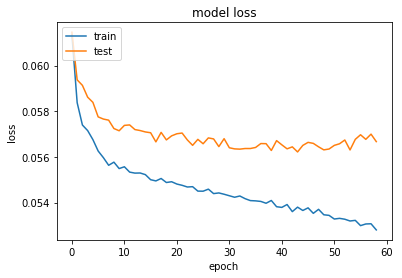

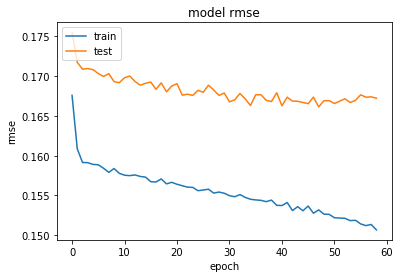

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  141.20053911209106 s =  2.35334233045578 min =  0.03922237230671777 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05863641044583925
Delay 100 ms: 0.004912926725537545
Delay 200 ms: 0.013453548291532174
Delay 300 ms: 0.02460092552535123
Delay 400 ms: 0.03715752560028401
Delay 500 ms: 0.05043601117361594
Delay 600 ms: 0.06404751175552634
Delay 700 ms: 0.07775265057347801
Delay 800 ms: 0.09138715665462037
Delay 900 ms: 0.10479066870374122
Delay 1000 ms: 0.11782517945470554

RMSE
Average rmse: 0.12493326708749368
Delay 100 ms: 0.015363342578138416
Delay 200 ms: 0.03035327727361236
Delay 300 ms: 0.05029477283882769
Delay 400 ms: 0.07265923297165718
Delay 500 ms: 0.09581314370578989
Delay 600 ms: 0.11896752598196376
Delay 700 ms: 0.1416756429724445
Delay 800 ms: 0.16367519673337244
Delay 900 ms: 0.18484056498629184
Delay 1000 ms: 0.20507340270164068

SMAPE
Average smape: 12.946256996127929
Delay 100 ms: 2.0281836314808066
Delay 200 ms: 4.743857578108825
Delay 300 ms: 7.491345845006356
Delay 400 ms: 10.071317508438707
Delay 500 ms: 12.468190177333561
Delay 600 ms: 14.69331590412252
Del

(5833, 25, 3) (5833, 10, 3)


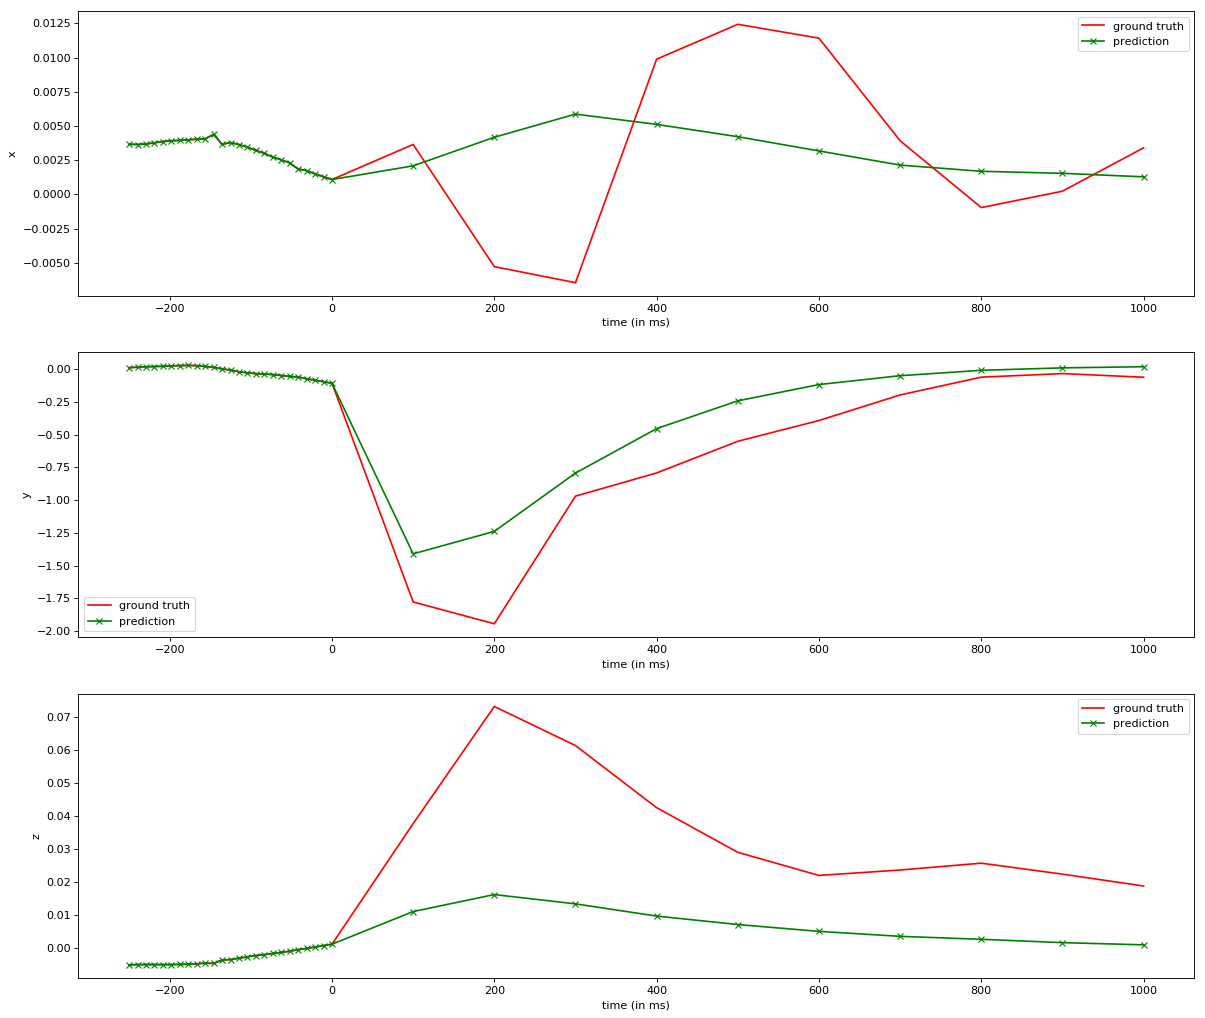

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data